In [51]:
from importlib import reload # to reload modules
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import mpl_scatter_density
import pandas as pd # Pandas
# import uproot
import pickle
import logging
import pprint
from IPython.display import Image, SVG


import os # read directories etc.
from scipy.optimize import curve_fit
from scipy.stats import chisquare, goodness_of_fit, skew, skewtest

import pylandau  # Landau Gaussian convolution

import LoadBatch
reload(LoadBatch)
from LoadBatch import *

from SensorClasses import *

verbose = False


### All the steps of the analysis put together and logically sequenced

In [2]:
### set logs level
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')

# Generic bins options, Batches import
the Batch objects are created by "logbook reader", it reads the .csv containing all the information about the batches (temperature, runs, angles, sensors etc.). Next I put all of the Batches into a dictionary for easier access

In [3]:
PIXEL_SIZE = 0.0184 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 600,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(100, 500, 1))

bins2 = (np.arange(350, 700, 1),
              np.arange(150, 500, 1))

bins3 = (np.arange(300, 800, 1),
              np.arange(0, 450, 1))

bins4 = (np.arange(500, 800, 1),
              np.arange(100, 500, 1))

### Load the dictionary of sensor names and runs
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the batches: \n{dict_of_batches}")

In [4]:
#  already run: charge:
bins_dict = {
    100:bins3, # x x
    101:bins3, # x x
    199:bins3, # x x
    201:bins1, # x x
    202:bins1, # x x
    203:bins1, # x x
    204:bins1, # x x   # weird time resolution
    205:bins4, # x x
    206:bins4, # x x
    301:bins1, # x x
    401:bins1, # x x
    402:bins1, # x x
    403:bins1, # x x
    407:bins1, # x x
    408:bins1, # x x
    409:bins1, # x x
    410:bins1, # x x
    411:bins1, # x x    sensor Ch2 in S1 probably outside area of interest
    413:bins1, # x x
    414:bins1, # x x
    501:bins2, # x x   (in all 5xx, S1 and S2: use=time in the geometry_mask) sensor Ch2 in S1 seems weird
    502:bins2, # x x
    503:bins2, # x x   sensors moved during the diffent runs (because the temperature changed, OR I EXCLUDE THEM AND STUDY THEM SEPARATELY)
    504:bins2, # x x   sensor ch4 in S1 is very irradiated and seems to have negative pulseHeight BG noise
    505:bins2, # x x   sensor Ch4 in S1 seems dead, sensor Ch2 ins S2 
    601:bins4, # x x   in all 6xx, Ch2 in S2 seem to be cut out (use=time)  Ch4 in S2 seems dead or outside area
    602:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    603:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    604:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    605:bins4, # x x   (S1: use=pulseheight,   S2: use=time)
    701:bins1, # x x
    702:bins1, # x x
    801:bins1, # x x
    802:bins1, # x x
    901:bins1, # x x  (S1: use=time)  sensor Ch3 in S1 is outside the FEi4 area (or dead)
    902:bins1, # x x  (S1: use=time)
    1001:bins2, # x x  (S1 and S2 use=time)
    1002:bins2, # x x  sensor ch4 in S2 seems dead
    1101:bins2, # x x  sensor ch3 in S2 seems weird
    1102:bins2, # x x  sensor ch2 and ch3 are outside the area
    1201:bins2, # x x  sensor ch3 in S1 is missing the name (should be 'CNM W5')
    1202:bins2, # x x
}

# Plot a single batch 
and a single oscilloscope

In [5]:
### show all information about the batch
this_batch = 401
S = 'S1'
### save into more detailed analysis instead of presentation
pres_path = f"/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/all batches/{this_batch}/detailed_analysis/"
if not os.path.exists(pres_path):
    os.mkdir(pres_path)
    
### use this directory instead: presentation path
# pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-04-03 HGTD TestBeam meeting'
# pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Thesis/Methods_plots/'
print("SAVE directory:", pres_path)

display(dict_of_batches[this_batch].__dict__)

### show all informations about each sensor
temp_dict = {}
for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
#     print(f"{S}, {ch}:", sensor.__dict__)
    temp_dict[(S,ch)] = sensor.__dict__
temp_df = pd.DataFrame(temp_dict)

display(temp_df)

SAVE directory: /home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/all batches/401/detailed_analysis/


{'batch_number': 401,
 'angle': 0.0,
 'temperature': -30.555555555555557,
 'tempA': array([-30., -30., -30., -30., -31., -31., -31., -31., -31.]),
 'tempB': array([-30., -30., -30., -30., -31., -31., -31., -31., -31.]),
 'S': {'S1': <SensorClasses.Oscilloscope at 0x7fd26544e590>,
  'S2': <SensorClasses.Oscilloscope at 0x7fd26544e9e0>}}

S1                                                      
                     Ch1               Ch2               Ch3               Ch4
name                 MCP  USTC2.1-W17-P6-A  USTC2.1-W17-P6-A  IMEv3-W12-C3-1-4
board           no_board            CERN-3            CERN-3            CERN-1
dut_position         5.0               3.0               3.0                 1
fluence                0                 0                 0                 0
transimpedance        -1              4700              4700              4700
voltage             2500               -80               -80               -80

## Load the batch
set general variables for the whole batch

In [36]:
SAVE = True

colormap = ['k','b','g','r']
threshold_charge = 4 #fC
DUTs = [3]

print("Batch: ", this_batch)
print(S)
df = load_batch(this_batch,S)
print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].temperature)

# these_bins = bins1
these_bins = bins_dict[this_batch]
time_bins = 5000
charge_bins = 500

use_for_geometry_cut = 'pulseheight'

# print(dict_of_batches[this_batch].S[S].channels['Ch3'].__dict__)

# plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='XY', mask=time_cuts,
#     bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')

# plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
#     bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')

# plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='extended', zoom_to_sensor=True,
#     bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC ')


Batch:  401
S1
MCP: 2500 V, angle: 0.0° temperature:-30.56°C


## 2D Tracks

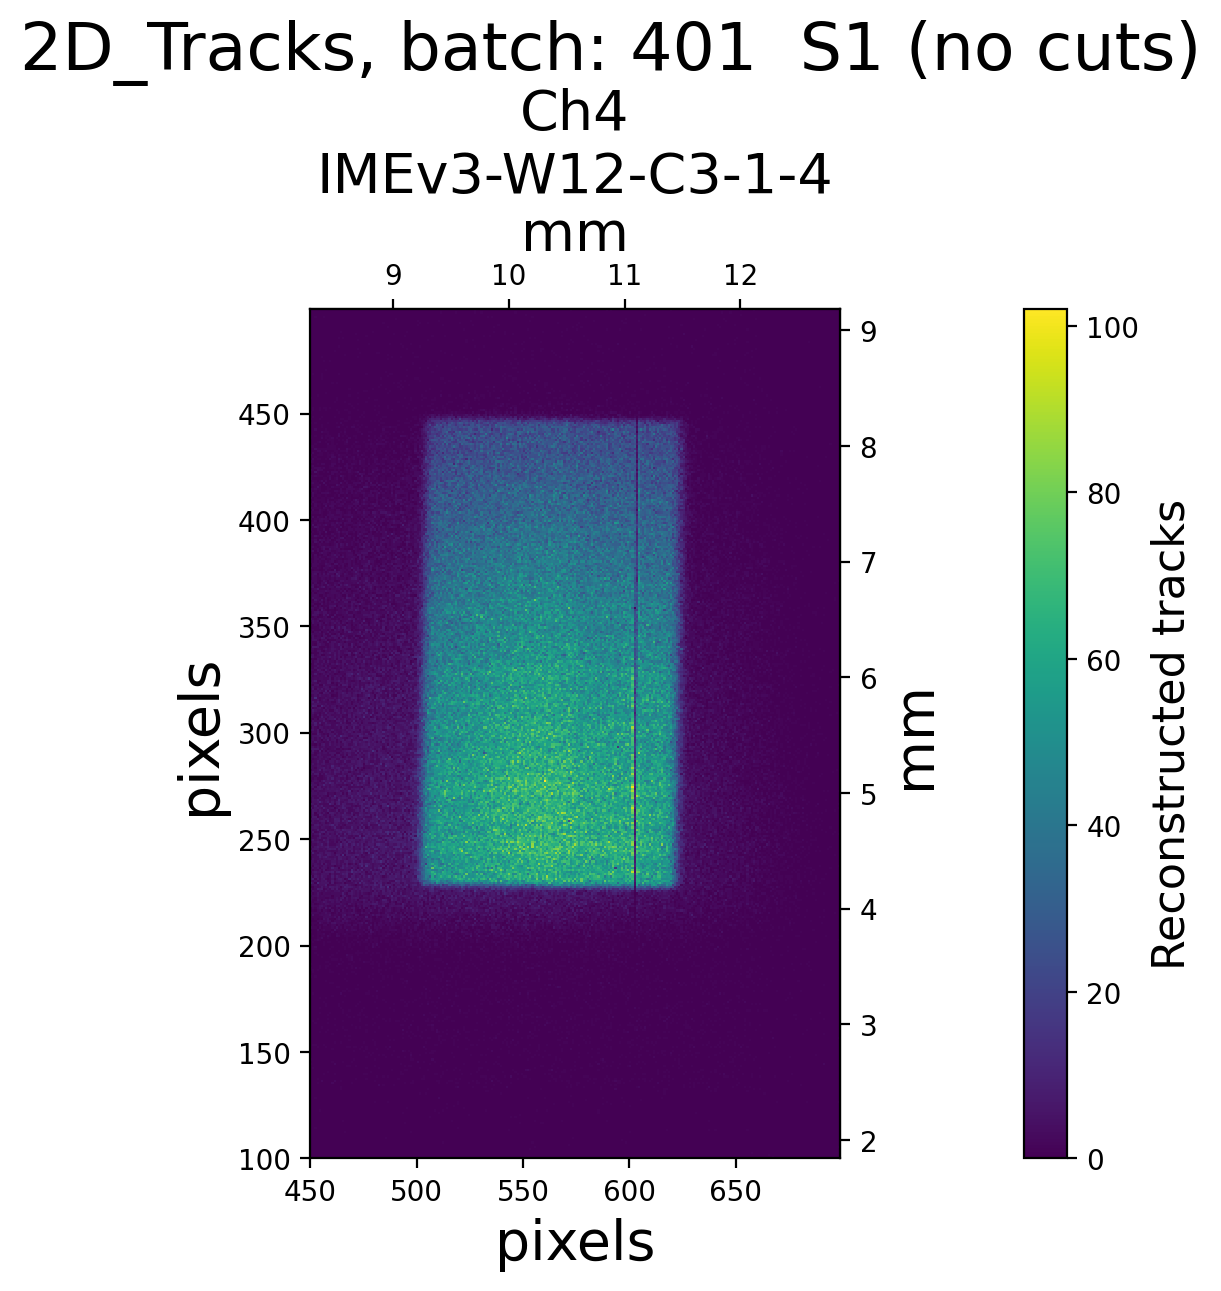

In [7]:
fig,axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} (no cuts)', savefig_path=pres_path, fmt='png')


## 1D Projection of the tracks


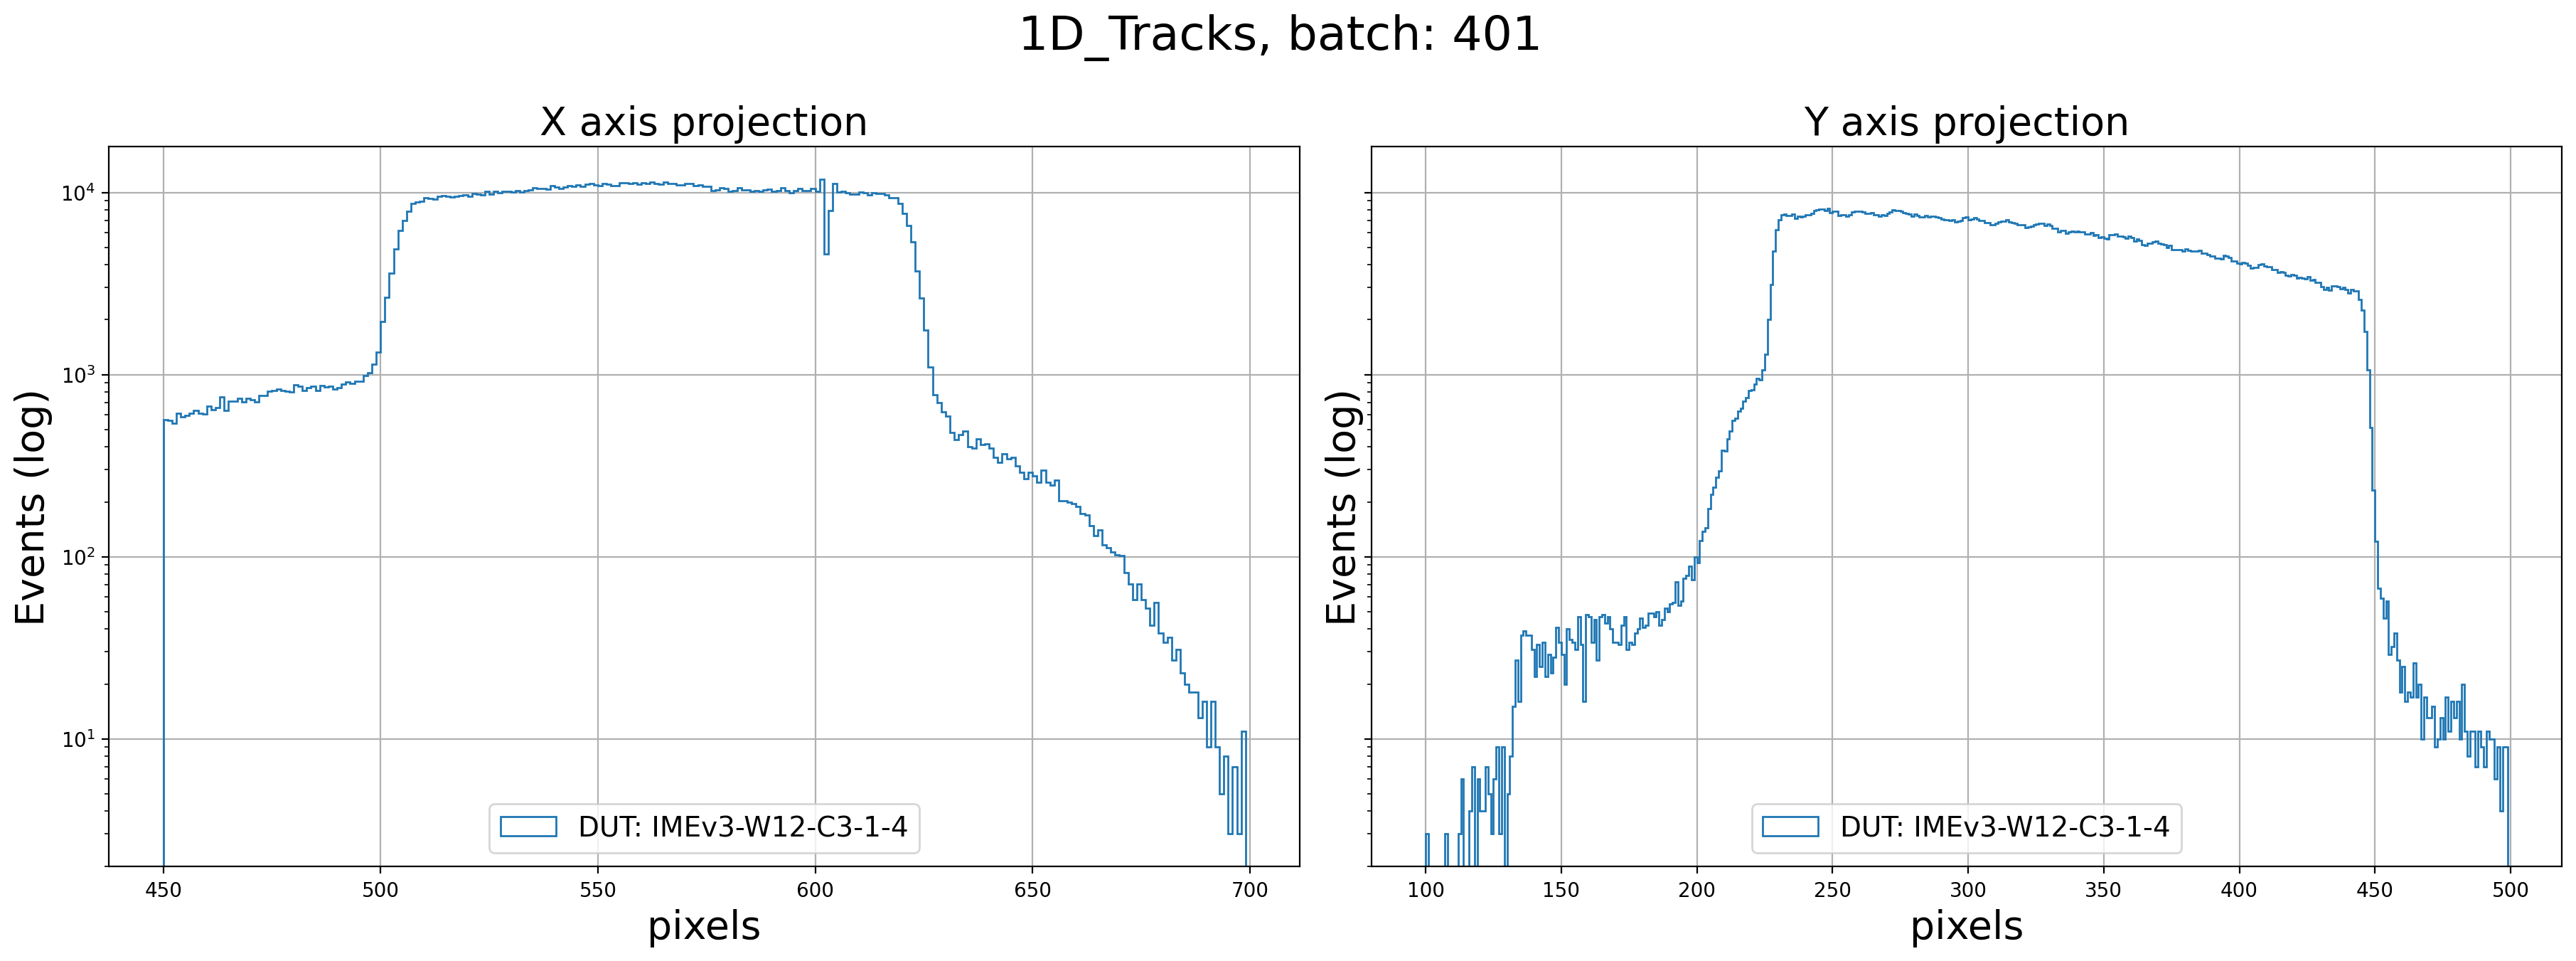

In [8]:
fig, axes = plot(df,"1D_Tracks", dict_of_batches[this_batch], S, bins=these_bins,
     n_DUT=DUTs, savefig=SAVE, savefig_path=pres_path, fmt='png', title_position=1.1)
for ax in axes:
    ax.legend(fontsize=14, loc='lower center')


# PulseHeight vs $\Delta$t plot
Using:  
https://github.com/astrofrog/mpl-scatter-density

/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


(<Figure size 2400x2400 with 2 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: IMEv3-W12-C3-1-4'}, xlabel='$\\Delta t$ [ps] (DUT 3 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

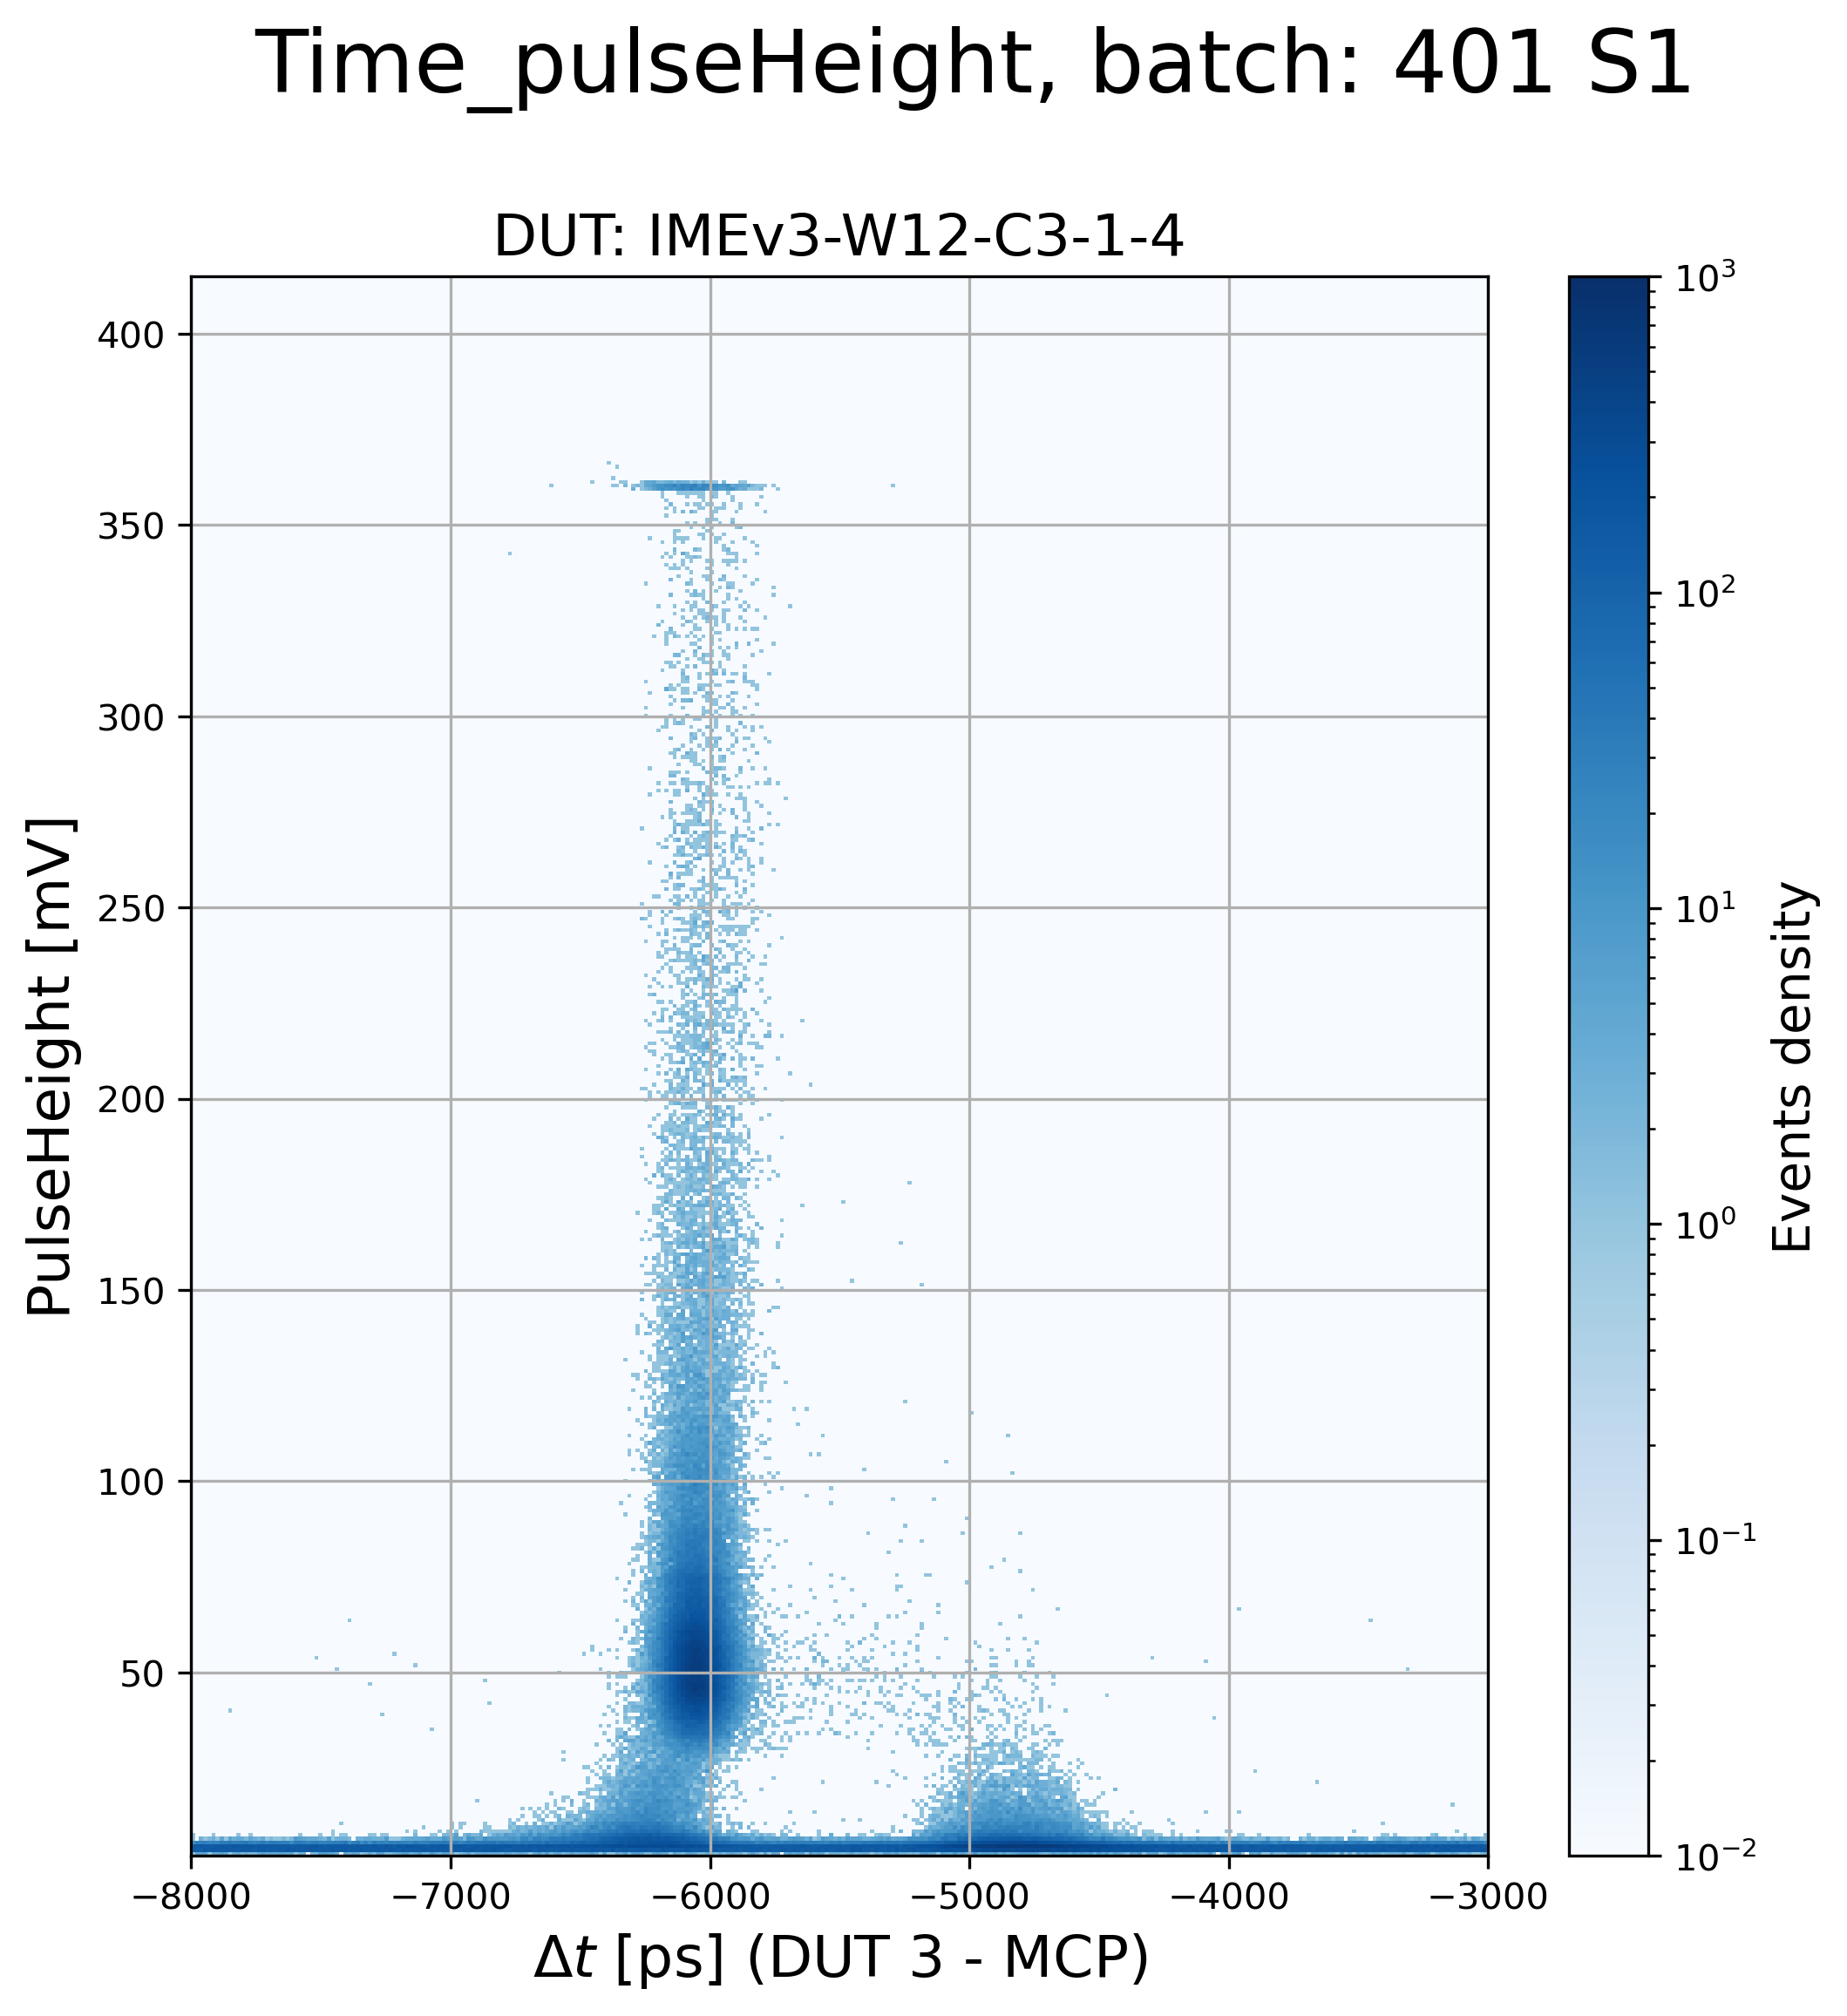

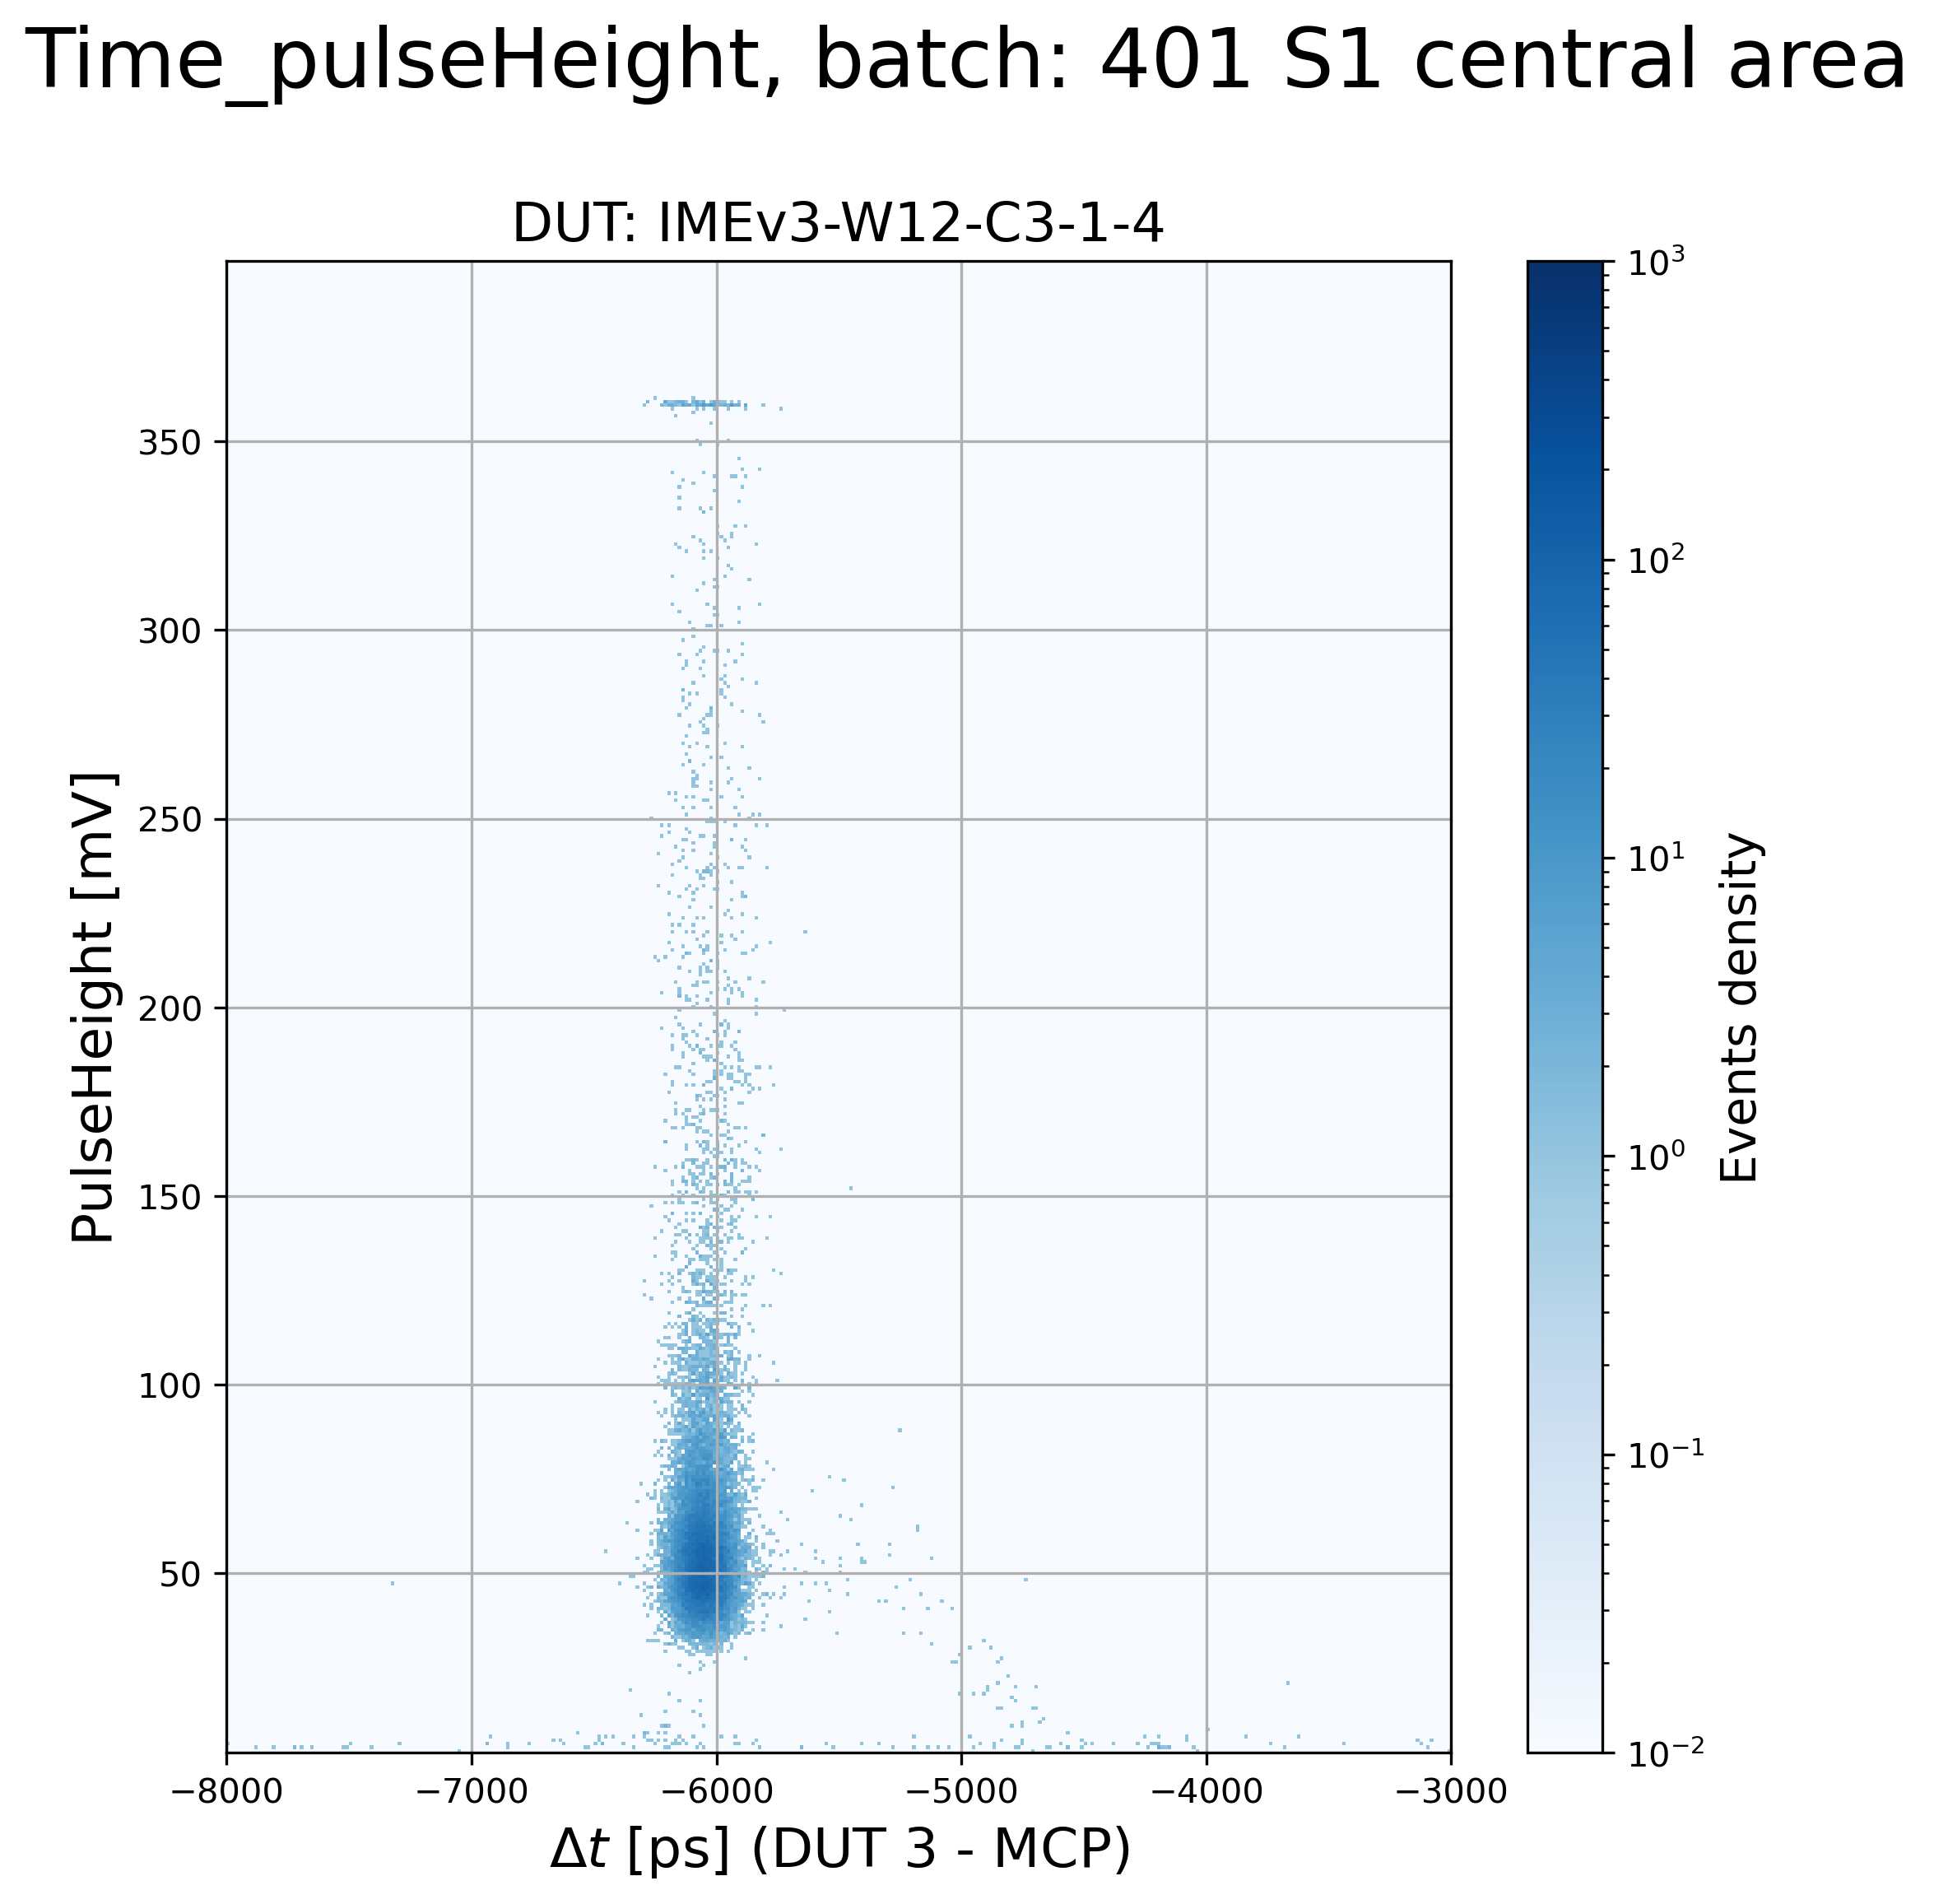

In [9]:
# I should probably calculate these ones later
# geo_cuts = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
central_sensor_area_cuts = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]


### delta time vs pulseHeight no info
plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False, title_position=1.0,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S}', savefig_path=pres_path, fmt='png')

plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False, mask=central_sensor_area_cuts, title_position=1.0,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S} central area', savefig_path=pres_path, fmt='png')

# PulseHeight distribution
to see where to apply a cut to the clean the data

(<Figure size 2000x1200 with 1 Axes>,
 <AxesSubplot:xlabel='PulseHeight [mV]', ylabel='Events (log)'>)

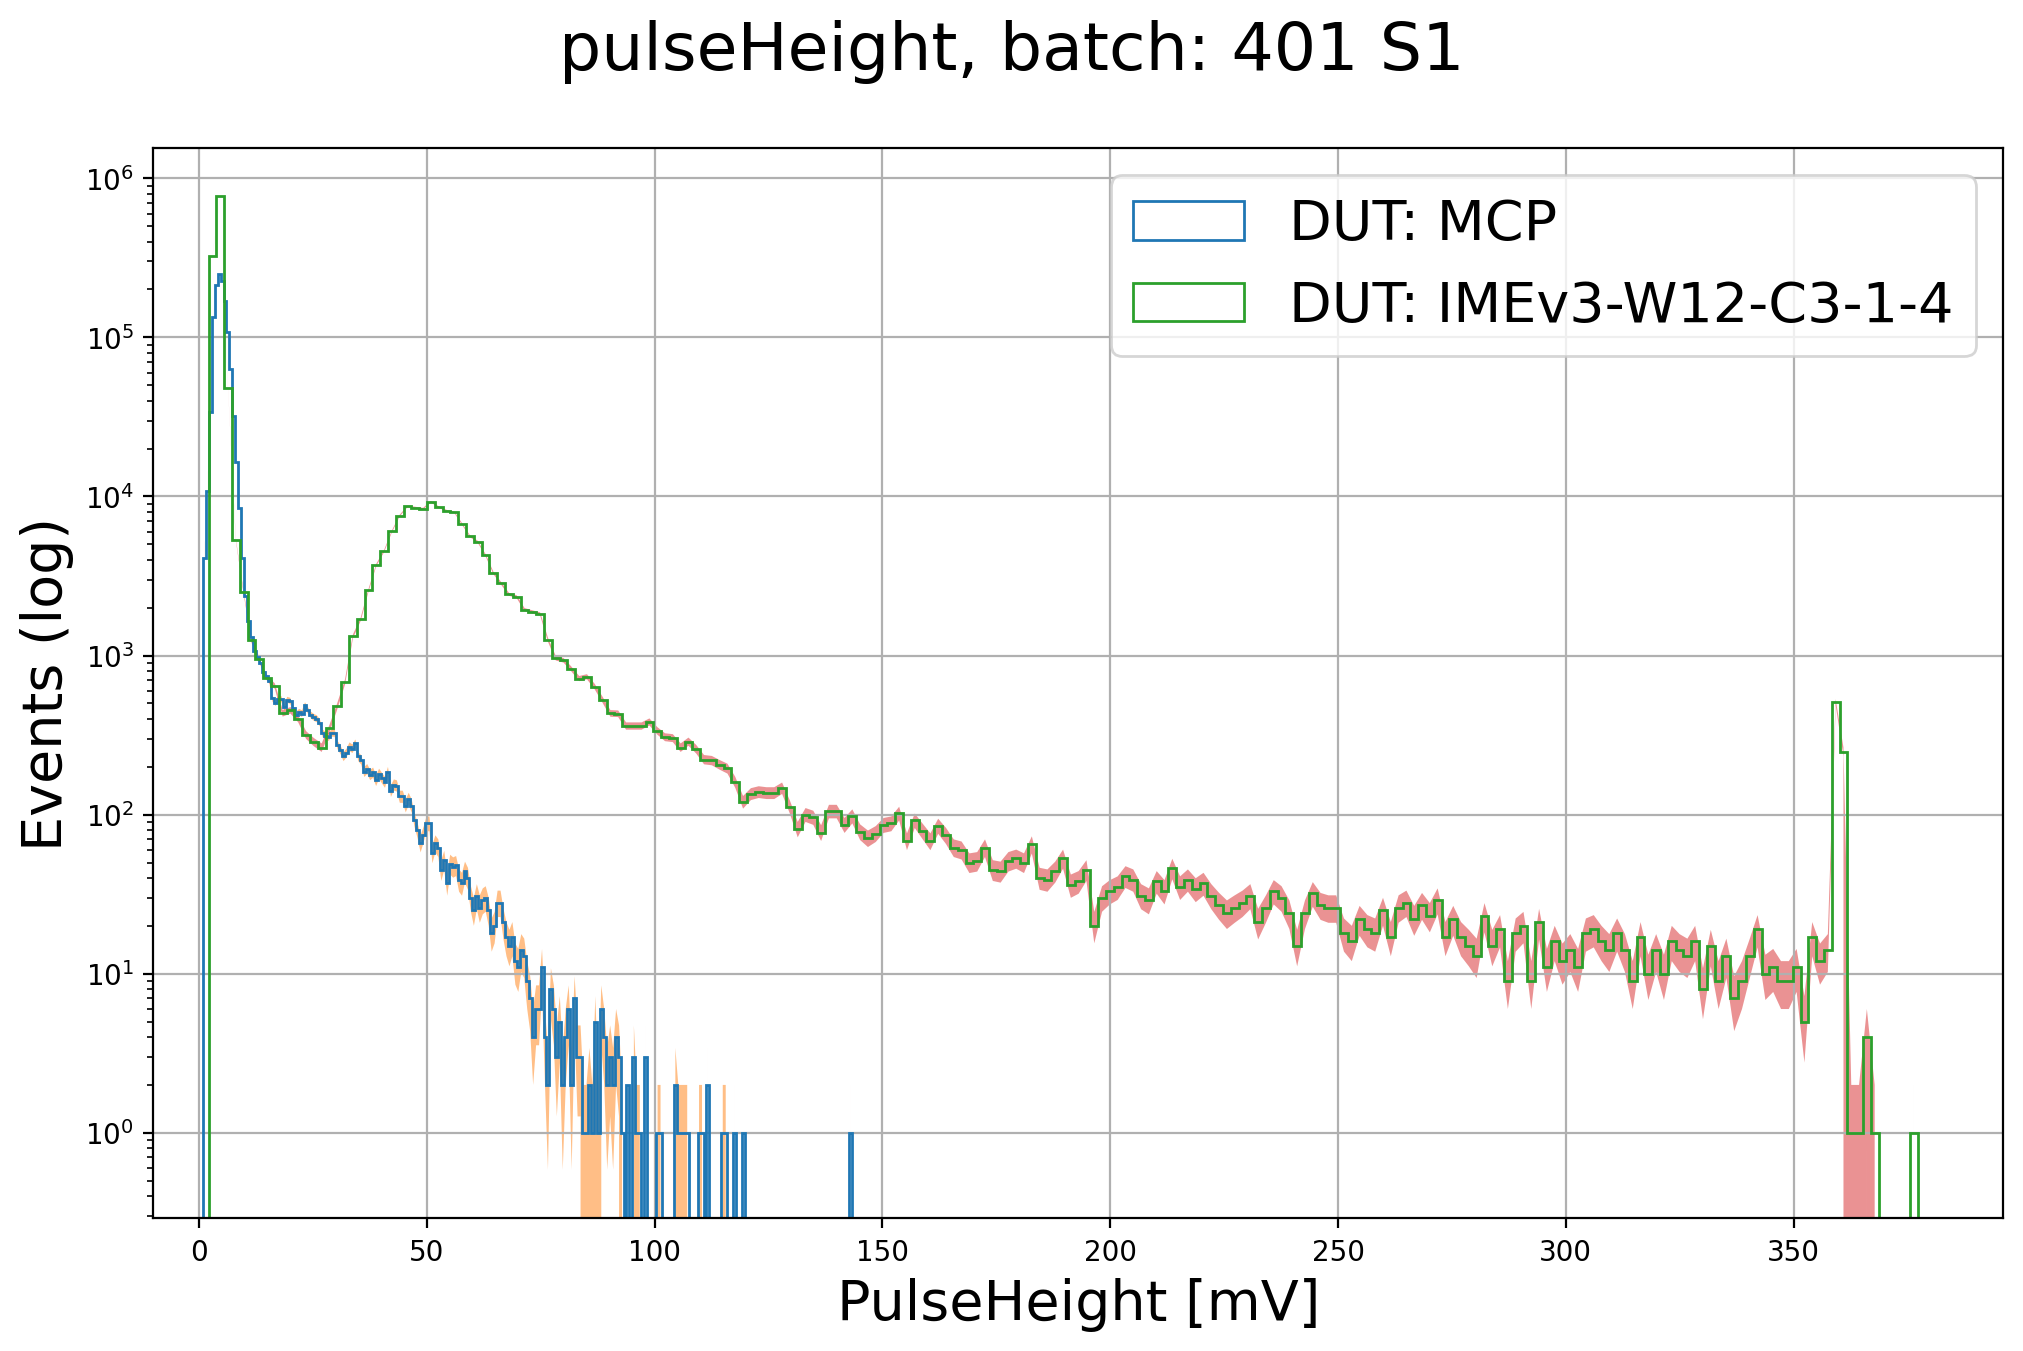

In [13]:
plot(df, "pulseHeight", dict_of_batches[this_batch], S, n_DUT=[0]+DUTs,
    savefig=SAVE, savefig_details=f'{S}', savefig_path=pres_path, fmt='png', title_position=1.1)

### Calculate the mins in the pulseHeight cut


In [14]:
mins = [find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False) if dut in DUTs else None for dut in [1,2,3]]
mins.insert(0,None)     ### insert None as the 'peak' of the MCP
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut] if dut in DUTs else None for dut in [1,2,3]]
# mins

### Combine plots of pulseHeight and 2D Tracks after cut is applied

DUT_3


''

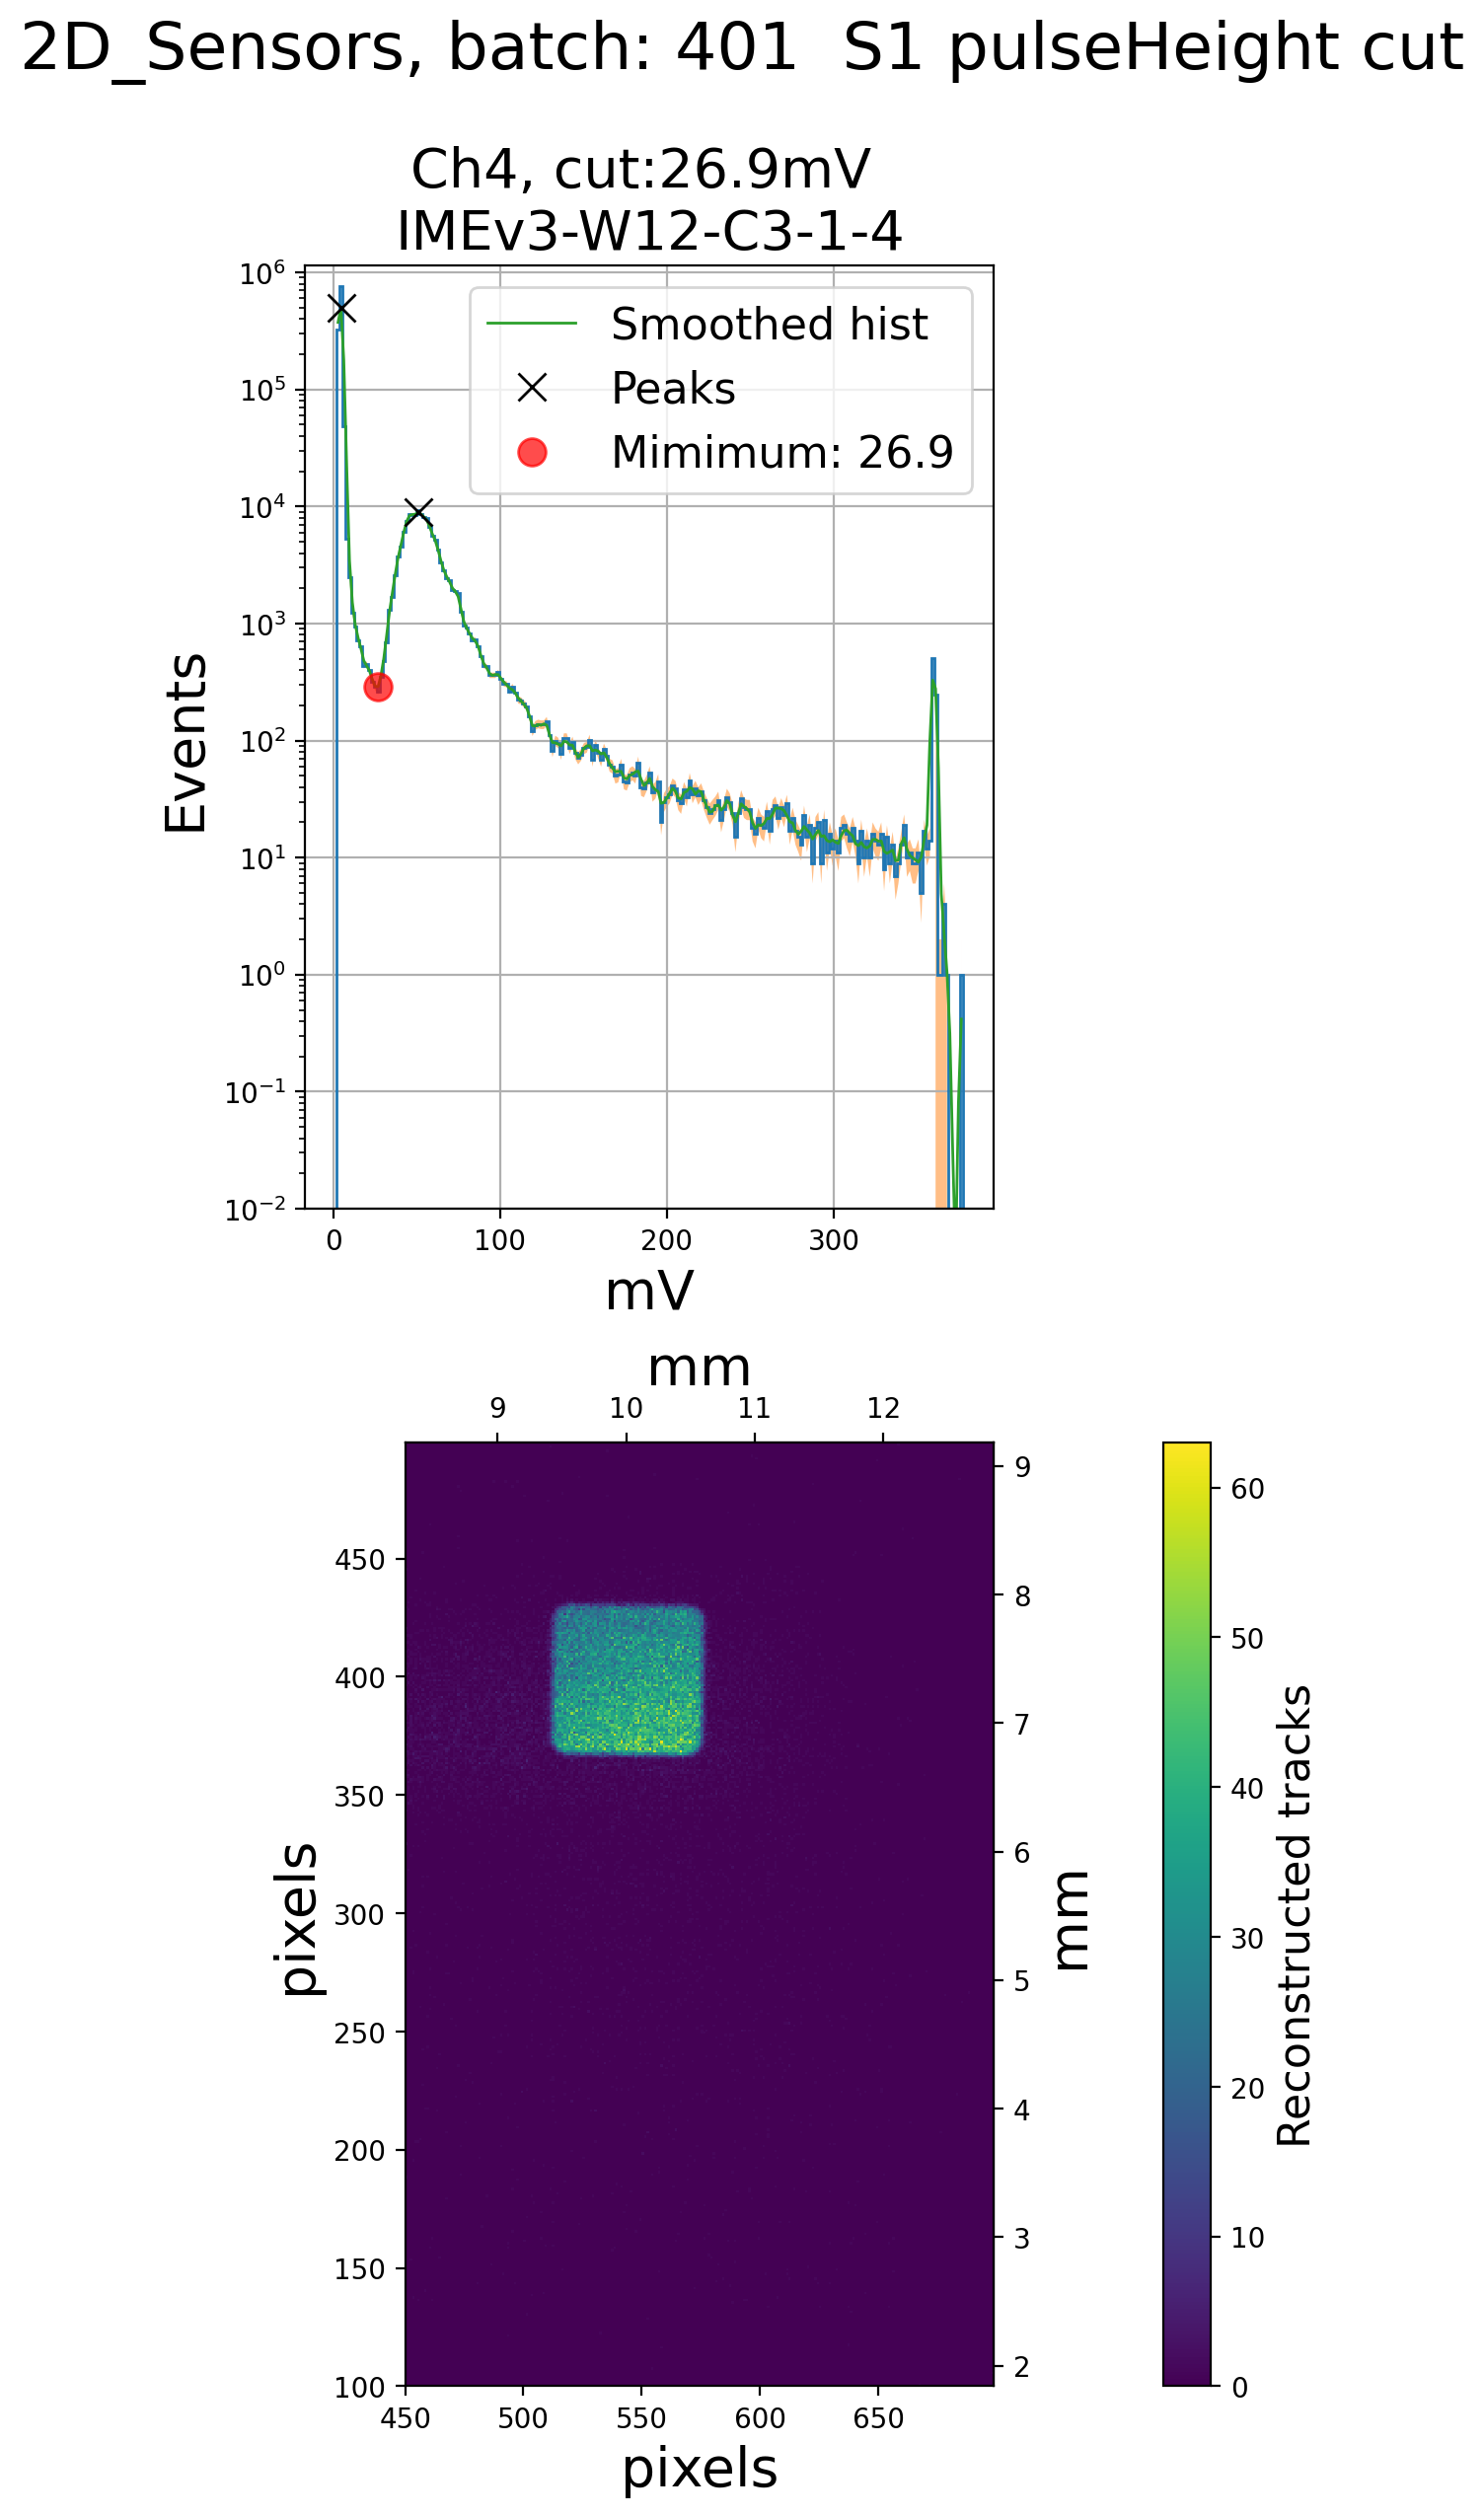

In [15]:
plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=DUTs, 
     savefig=SAVE, savefig_details=f' {S} pulseHeight cut', savefig_path=pres_path, fmt='png')
;

### With the options to:
- selecting a slightly larger area to study the outer part
- selecting only the center, to get the clearest signal 

# Time cut
Fit the $\Delta t$ with a gaussian, pick some  n*$\sigma$ interval and select events only in this window apply the fit from -20ns to +20ns so that the background is more flat
<!-- - also add full time range -->

#### Gaussian:
$$
\Large
f(x,A,\mu,\sigma,BG) = A \cdot e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2} + BG
$$

- $A:  \quad $ Amplitude (n° of events)
- $\mu: \quad $ Mean of the gaussian
- $\sigma: \quad $ Standard deviation
- $BG: \quad $  Flat background

In [16]:
### calculate the time cuts
time_cuts = [time_mask(df, dut, bins=time_bins, plot=False, sigmas=3)[0] if dut in DUTs else None for dut in [1,2,3]]


In [17]:
### actually maybe first I want a plot of the time MCP-dut without the fit
colormap = ['k','b','g','r']

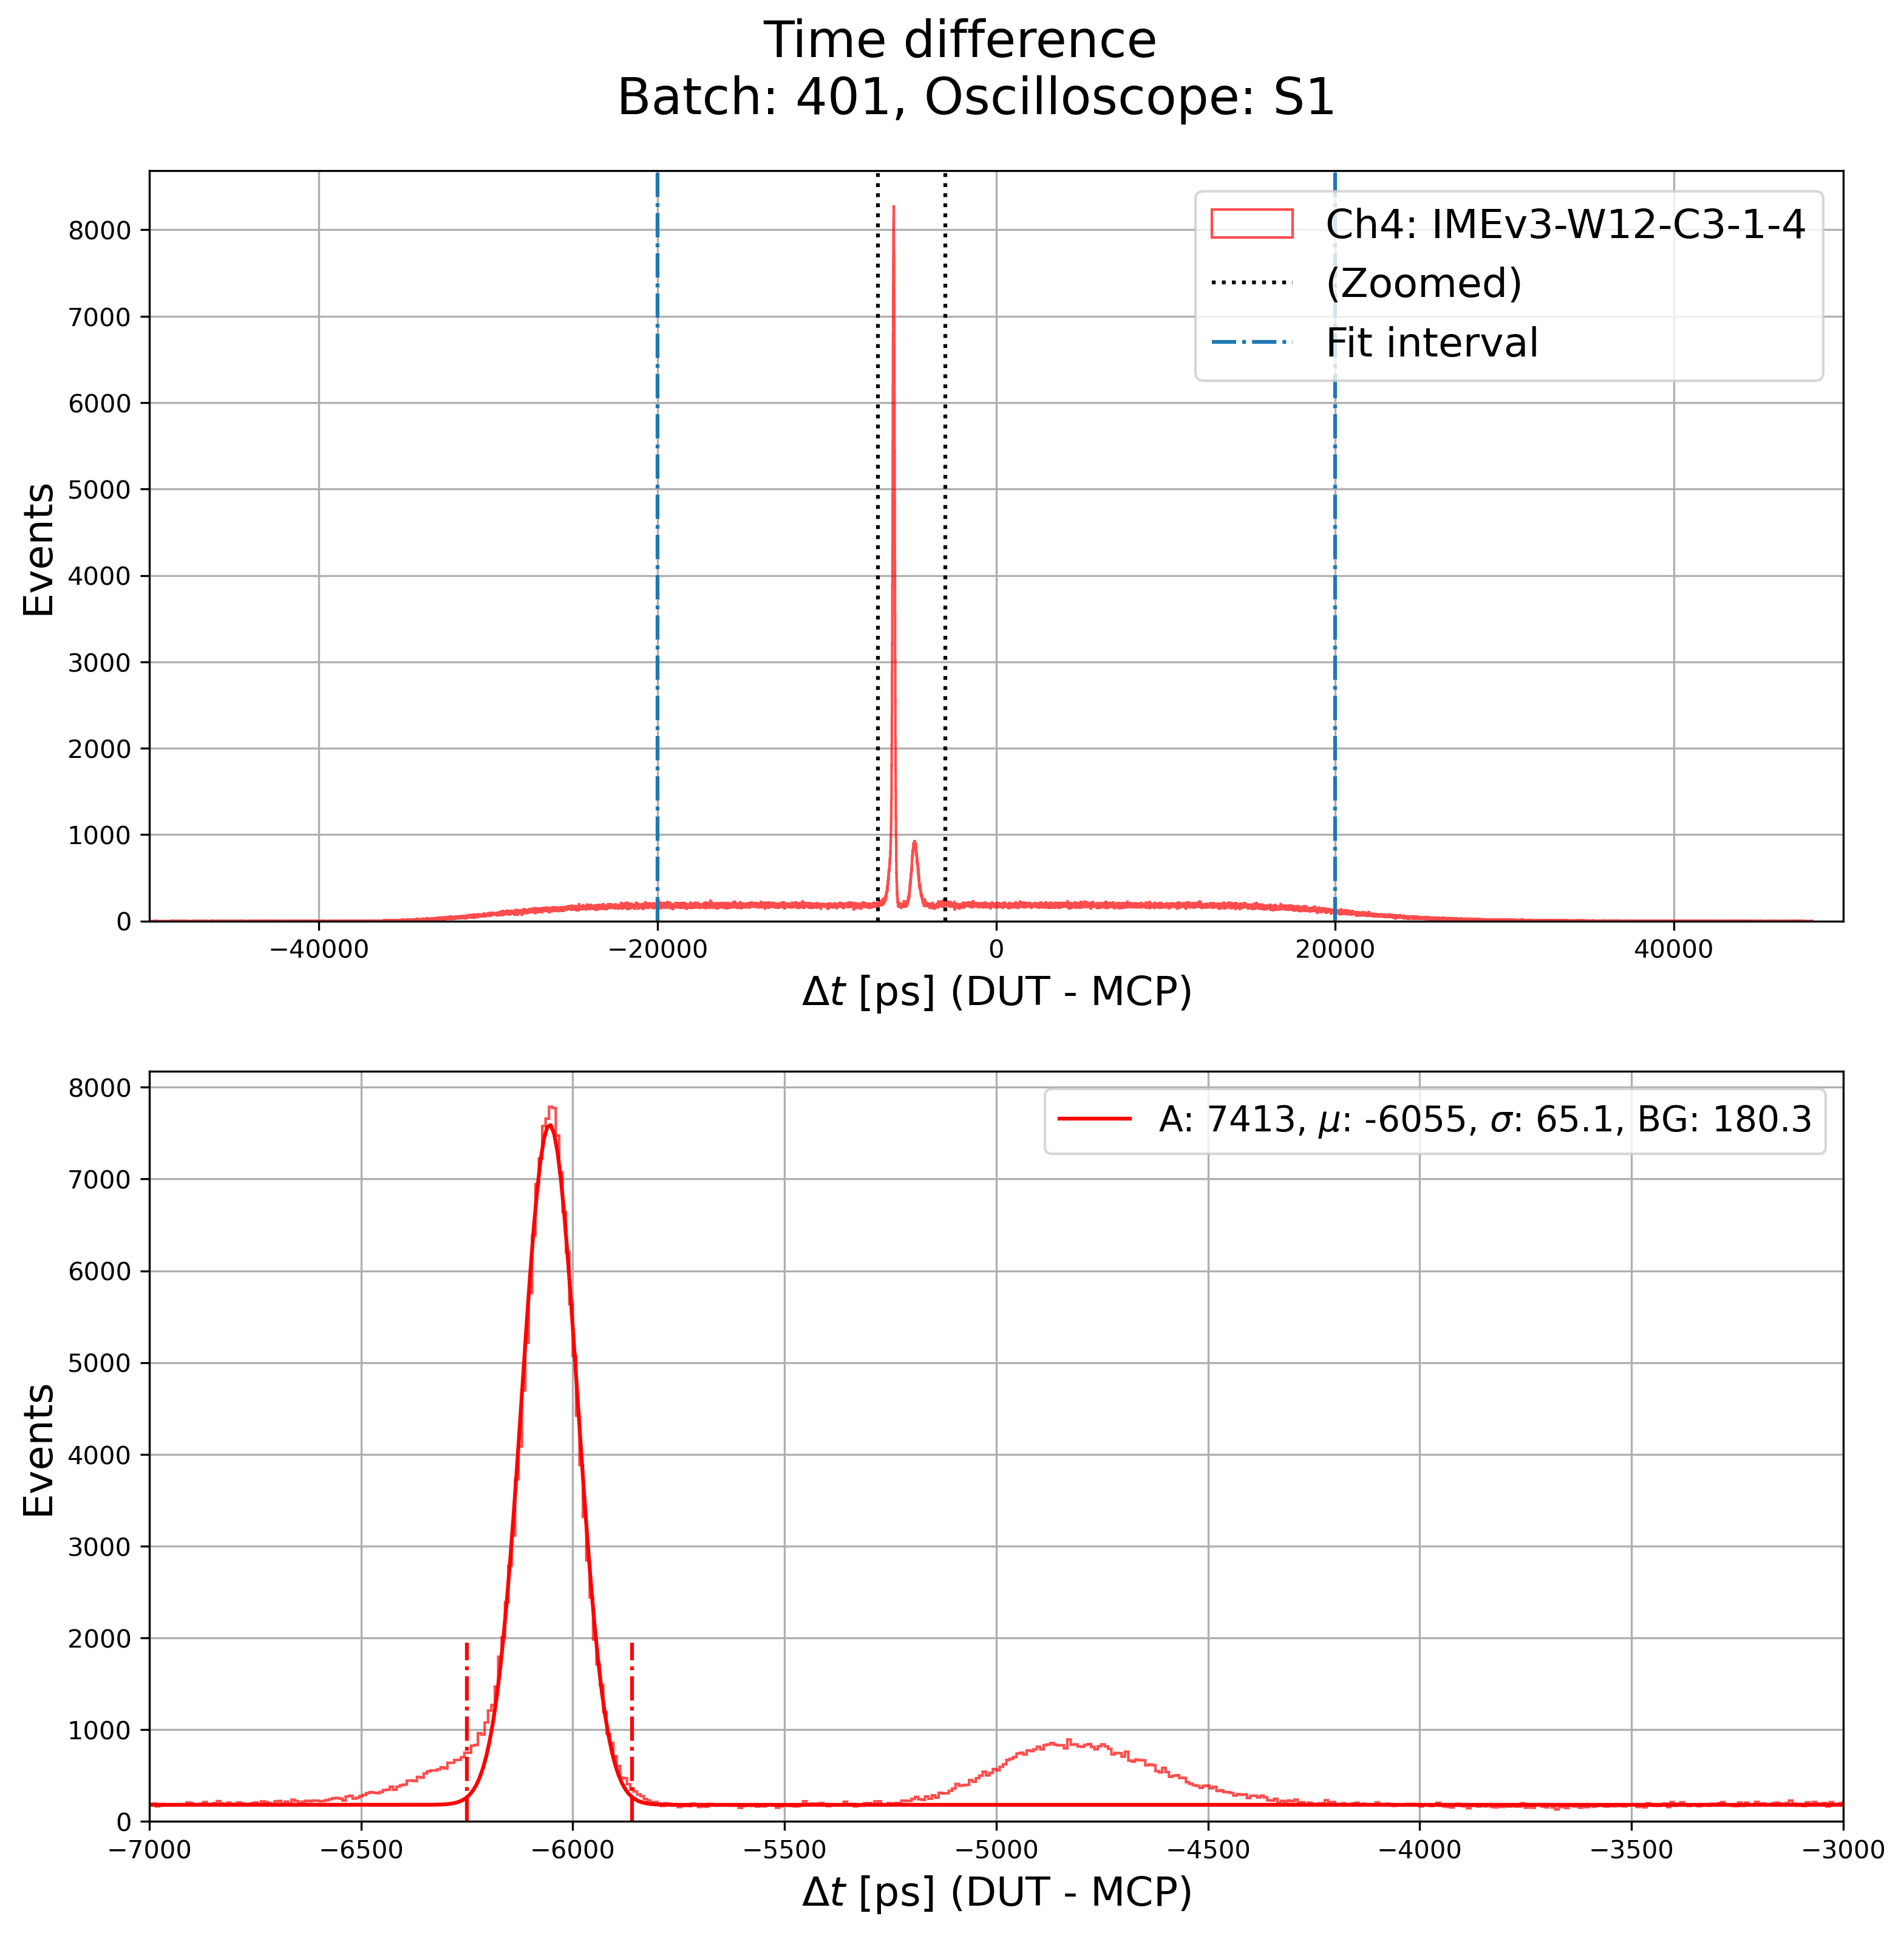

In [18]:
### now I fit between -20ns < delta t < 20ns
# SAVE = False
fig, axes = plt.subplots(figsize=(12,12),nrows=2, ncols=1, dpi=300)

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
    plot_histogram((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"]),
                   bins=15000, color=colormap[dut], linewidth=1, alpha=0.7,
                   label=f"Ch{dut+1}: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}",
                   fig_ax=(fig,axes[0]))
    
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes[1]))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes[1].plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes[1].vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    axes[1].vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes[1].plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.1f, BG: %.1f" %(param[0],param[1], param[2], param[3])) # only two decimals

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes[0].set_xlim(-50e3,50e3)
axes[0].set_xlabel(f"$\Delta t$ [ps] (DUT - MCP)", fontsize=16)
axes[0].set_ylabel("Events", fontsize=16)
axes[0].axvline(xlim[0],linestyle=':',color='k',label='(Zoomed)')
axes[0].axvline(xlim[1],linestyle=':',color='k')
axes[0].axvline(-window_limit, linestyle='-.', label='Fit interval')
axes[0].axvline(+window_limit, linestyle='-.')
axes[0].legend(fontsize=16)

axes[1].set_xlabel(f"$\Delta t$ [ps] (DUT - MCP)", fontsize=16)
axes[1].set_ylabel("Events", fontsize=16)
axes[1].set_xlim(xlim)
axes[1].legend(fontsize=14)

# ### this lines are just to visually find an interval on which to study interesting features
# axes[1].axvline(-5650, color='k')
# axes[1].axvline(-6000, color='k')

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {S}",y=.95, fontsize=20)
if SAVE:
    fig.savefig(os.path.join(pres_path,f"time_difference_{this_batch}_{S}_double_plot_zoomed_and_gauss_fit.png"), bbox_inches="tight")

# Geometry cut
The goal is to find the 'area' of the sensor to select only events that pass thru that

### Use the Tracks with a pulseHeight cut to define the 'edges' of the sensor

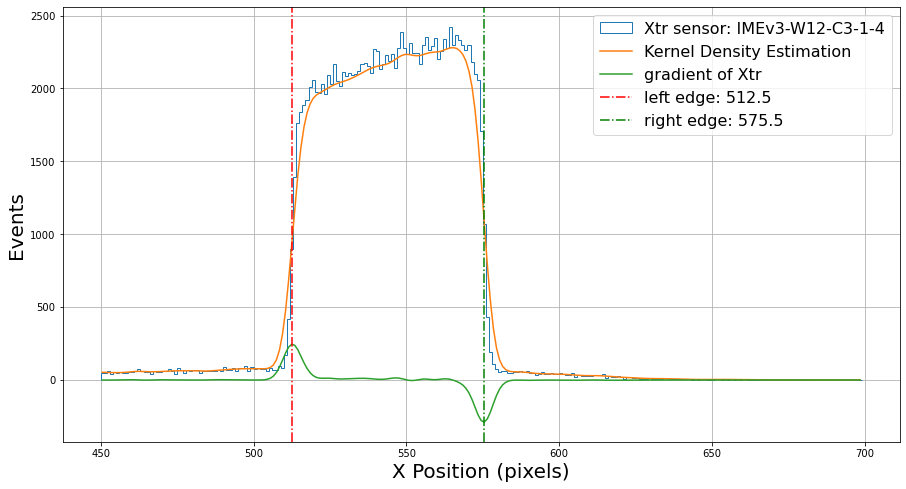

In [19]:
### I need to put all of this into the find_edges() so that they are the same
dut = 3
axis, XY_bins = 'X', 0
# axis, XY_bins = 'Y', 1

Tracks_cut = df[f'{axis}tr_{dut-1}'].loc[df[f"pulseHeight_{dut}"]>mins[dut]]
# Tracks_cut = df[f'{axis}tr_{dut-1}'].loc[time_cuts[dut-1]]  ### using time info


fig, ax = plt.subplots(figsize=(15,8))
hist, my_bins, _ = ax.hist(Tracks_cut, bins=these_bins[XY_bins], histtype='step', label=f"{axis}tr sensor: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}")

kde = gaussian_kde(Tracks_cut)
density_factor = sum(hist)*np.diff(my_bins)
bins_centers = (my_bins[1:]+my_bins[:-1])/2
values = time_limited_kde_evaluate(kde, bins_centers)*density_factor

ax.plot(bins_centers, values, label="Kernel Density Estimation")
ax.plot(bins_centers, np.gradient(values), label=f'gradient of {axis}tr')

left_edge = bins_centers[np.argmax(np.gradient(values))]
right_edge = bins_centers[np.argmin(np.gradient(values))]

ax.axvline(left_edge, color='r', linestyle='-.', label=f'left edge: {left_edge}')
ax.axvline(right_edge, color='g', linestyle='-.', label=f'right edge: {right_edge}')
# fig.suptitle("Find the edges of the sensor by applying pulseHeight cut (%.2f mV)"%mins[dut], fontsize=24, y=1.05)

ax.set_xlabel(f"{axis} Position (pixels)", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.grid('--')
ax.legend(fontsize=16, loc='best')

if SAVE:
    fig.savefig(os.path.join(pres_path,f"locating_edges_{axis}tr_batch_{this_batch}_{S}_DUT{dut}.svg"),bbox_inches='tight')

In [20]:
### calculate geometry cut (using pulseHeight)
# geo_cuts = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use='pulseheight')[0] if dut in DUTs else None for dut in [1,2,3]]
# geo_infos = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use='pulseheight')[1] if dut in DUTs else None for dut in [1,2,3]]

geo_cuts, geo_infos = zip(*[geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use='pulseheight')
                            if dut in DUTs else (None,None) for dut in [1,2,3]])

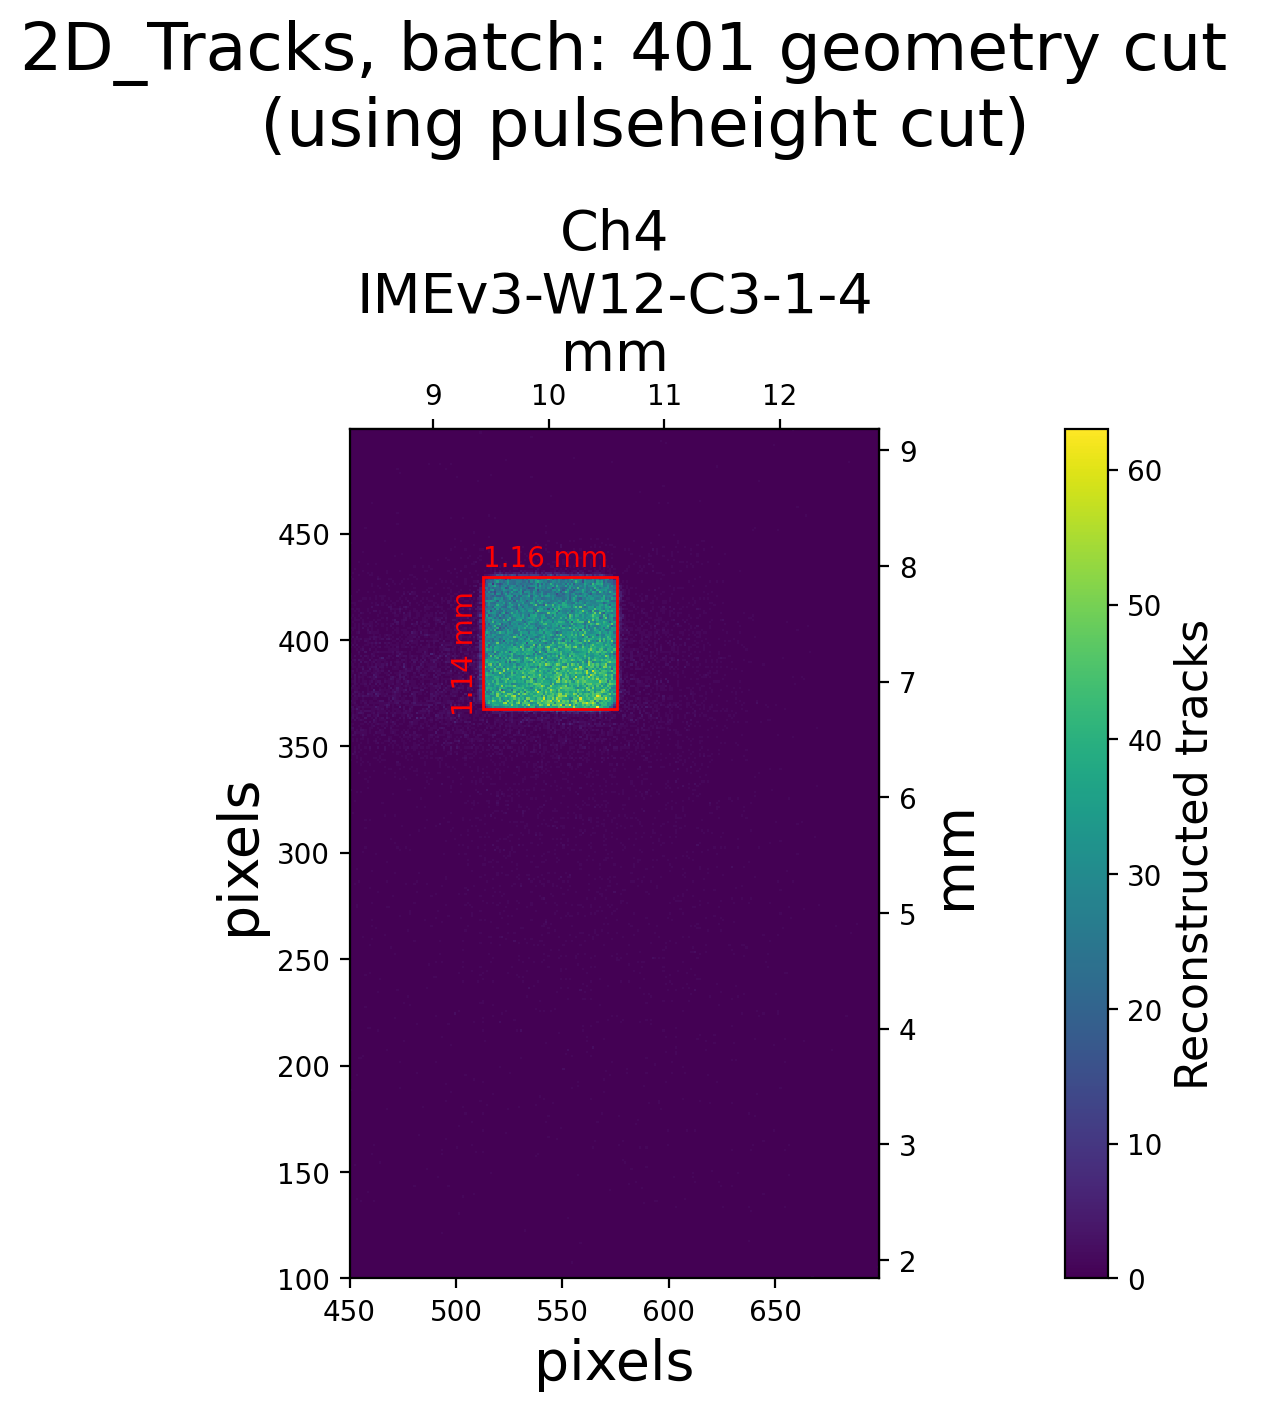

In [21]:
### All track using pulseHeight cut 

fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, mask=pulse_cuts,
     n_DUT=DUTs, savefig=False, savefig_details='geometry cut \n (using pulseheight cut)', savefig_path=pres_path, fmt='png', title_position=1.15)

for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))
    sensor_width = (geo_infos[dut-1]['right_edge']-geo_infos[dut-1]['left_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos[dut-1]['left_edge'], y=geo_infos[dut-1]['top_edge']+5, s='%.2f mm'%sensor_width, color='r')
    sensor_height = (geo_infos[dut-1]['top_edge']-geo_infos[dut-1]['bottom_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos[dut-1]['left_edge']-15, y=geo_infos[dut-1]['bottom_edge'], s='%.2f mm'%sensor_height, color='r', rotation='vertical')

if SAVE:
    fig.savefig(os.path.join(pres_path,f"2D_Tracks_{this_batch}_{S} highlight geometry cut (using pulseHeight).png"), bbox_inches='tight')
     

In [22]:
# ### All tracks with time cut

# fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, mask=time_cuts,
#      n_DUT=DUTs, savefig=SAVE, savefig_details=' (with time cut)', savefig_path=pres_path, fmt='png')

### Geometry cut using time information
if the pulseHeight cut fails (very likely in the case of irradiated sensors), the geometry cut could be done with time information instead

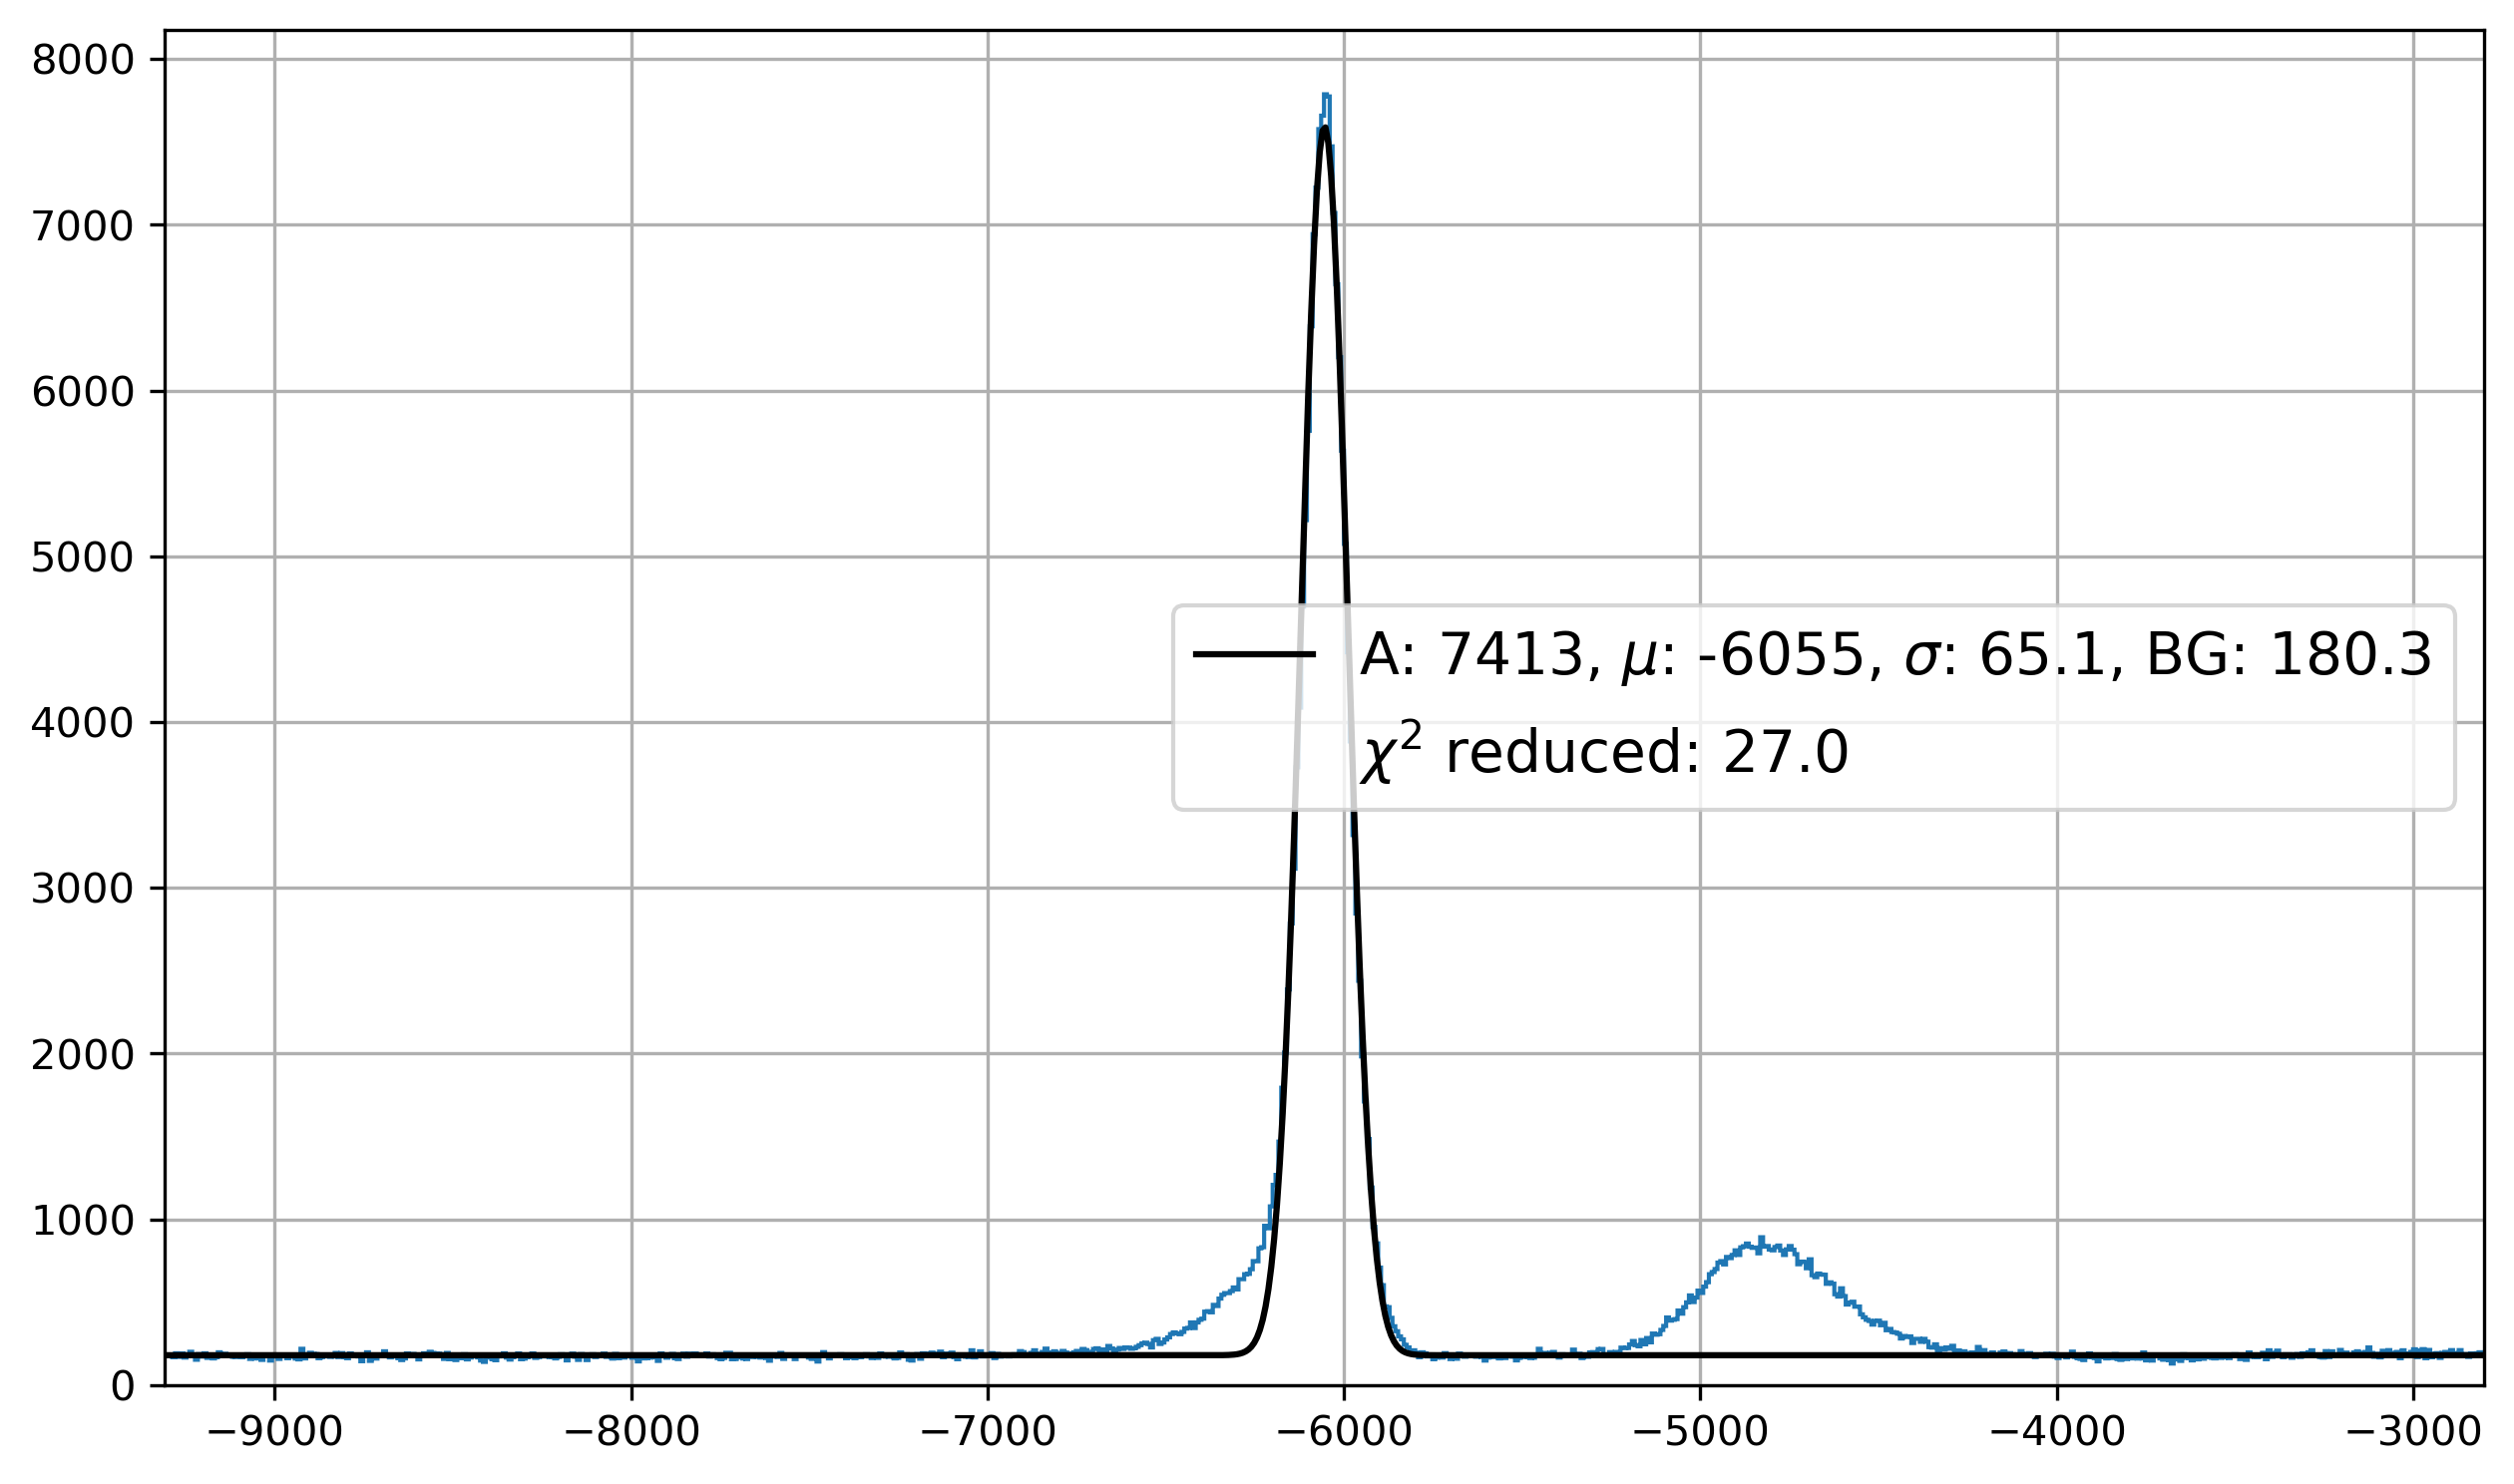

In [23]:
### calculate geometry cut (using time)
# geo_cuts_time = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use='time', plot=True)[0] if dut in DUTs else None for dut in [1,2,3]]
# geo_infos_time = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use='time', plot=False)[1] if dut in DUTs else None for dut in [1,2,3]]

geo_cuts_time, geo_infos_time = zip(*[geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='normal', use='time', plot=True) 
                                      if dut in DUTs else (None,None) for dut in [1,2,3]])

In [24]:
# fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=DUTs, mask=time_cuts,
#                  savefig=False, savefig_details='geometry cut \n (using pulseHeight cut)', savefig_path=pres_path, fmt='png', title_position=1.1)

# for i,dut in enumerate(DUTs):
#     axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))
#     sensor_width = (geo_infos[dut-1]['right_edge']-geo_infos[dut-1]['left_edge'])*PIXEL_SIZE
#     axes[i].text(x=geo_infos[dut-1]['left_edge'], y=geo_infos[dut-1]['top_edge']+5, s='%.2f mm'%sensor_width, color='r')
#     sensor_height = (geo_infos[dut-1]['top_edge']-geo_infos[dut-1]['bottom_edge'])*PIXEL_SIZE
#     axes[i].text(x=geo_infos[dut-1]['left_edge']-15, y=geo_infos[dut-1]['bottom_edge'], s='%.2f mm'%sensor_height, color='r', rotation='vertical')

# if SAVE:
#     fig.savefig(os.path.join(pres_path,f"2D_Tracks_{this_batch}_{S} highlight geometry cut (using pulseHeight).png"), bbox_inches='tight')
    

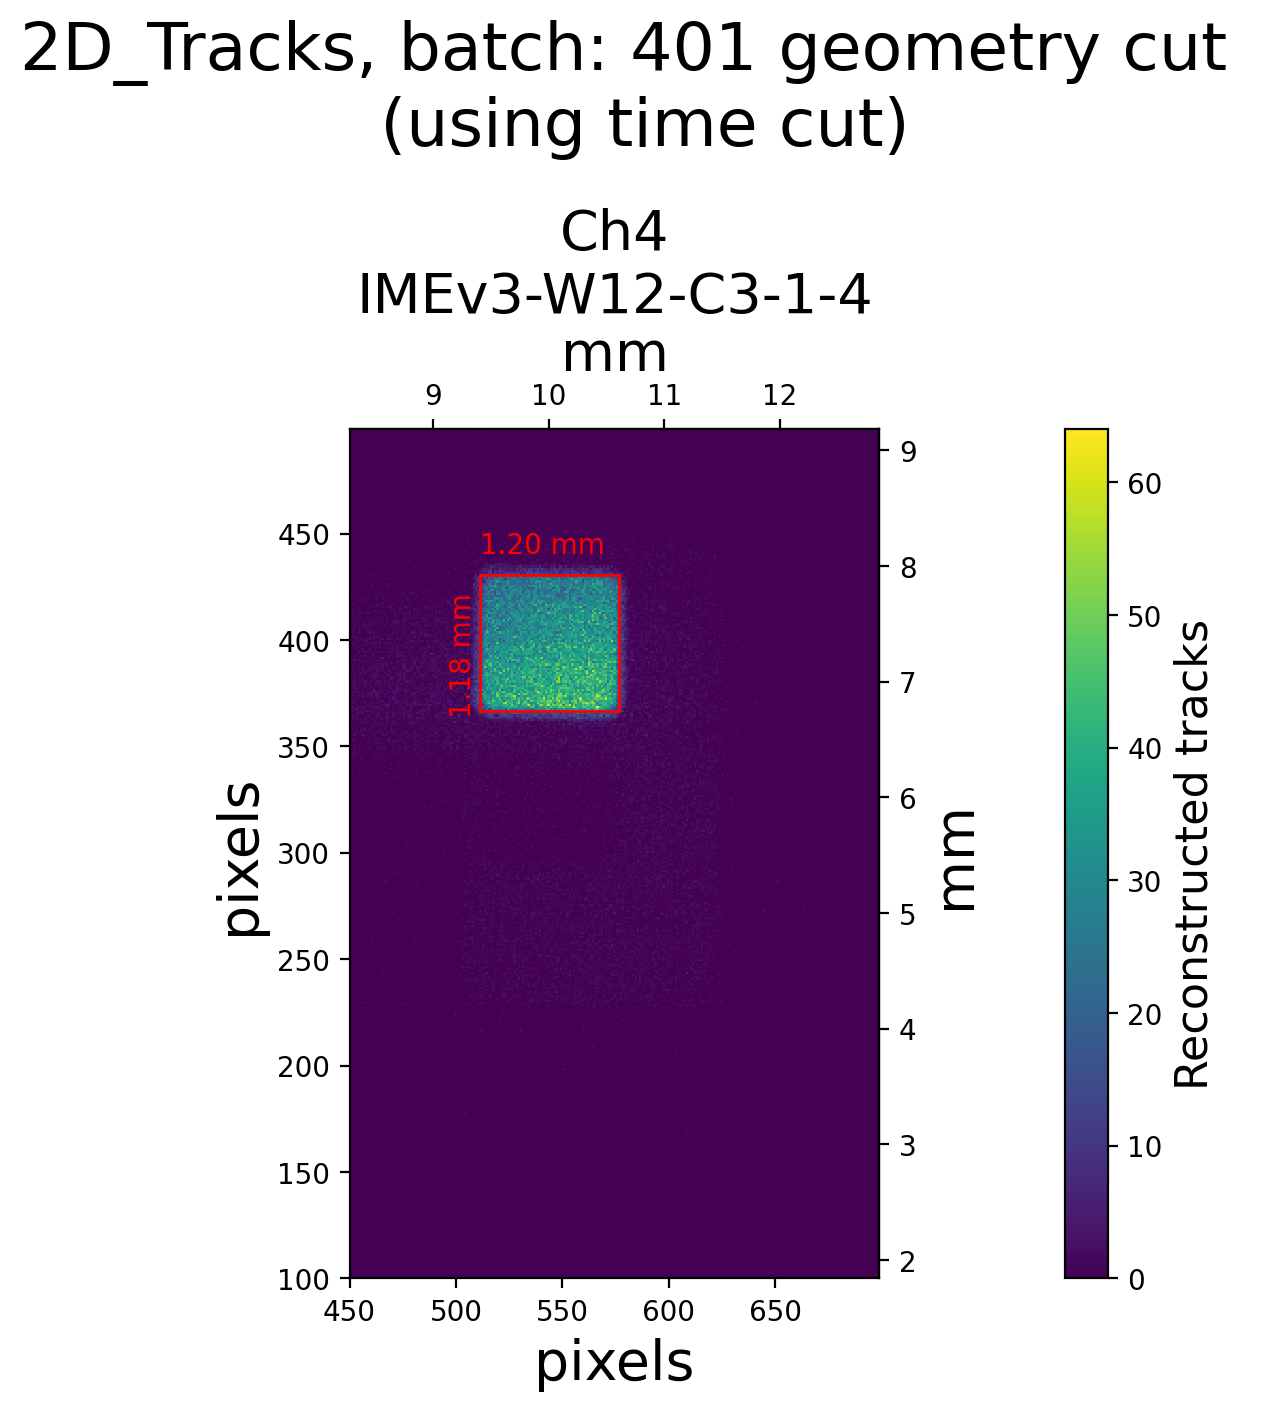

In [25]:
fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, mask=time_cuts,
     n_DUT=DUTs, savefig=False, savefig_details='geometry cut \n (using time cut)', savefig_path=pres_path, fmt='png', title_position=1.15)

for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos_time[dut-1]))
    sensor_size = (geo_infos_time[dut-1]['right_edge']-geo_infos_time[dut-1]['left_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos_time[dut-1]['left_edge'], y=geo_infos_time[dut-1]['top_edge']+10, s='%.2f mm'%sensor_size, color='r')
    sensor_height = (geo_infos_time[dut-1]['top_edge']-geo_infos_time[dut-1]['bottom_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos_time[dut-1]['left_edge']-15, y=geo_infos_time[dut-1]['bottom_edge'], s='%.2f mm'%sensor_height, color='r', rotation='vertical')

if SAVE:
    fig.savefig(os.path.join(pres_path,f"2D_Tracks_{this_batch}_{S} highlight geometry cut (using time).png"), bbox_inches='tight')
    

## Charge distribution, cuts and fit

In [26]:
### CALCULATE ALL THE CUTS
mins = [find_min_btw_peaks(df[f"pulseHeight_{dut}"], bins='rice', plot=False) if dut in DUTs else None for dut in [1,2,3]]

print(f"USING ''{use_for_geometry_cut}'' FOR GEOMETRY CUT")

geo_cuts, geo_infos = zip(*[geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', use=use_for_geometry_cut)
                            if dut in DUTs else (None,None) for dut in [1,2,3]])
extended_geo_cuts = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='extended', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
time_cuts = [time_mask(df, DUT_number=dut, sigmas=3)[0] if dut in DUTs else None for dut in [1,2,3]]
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] if dut in DUTs else None for dut in [1,2,3]]

all_cuts = [np.logical_and(np.logical_and(geo_cuts[dut-1], time_cuts[dut-1]), pulse_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]

fit_cuts = [np.logical_and(df[f"charge_{dut}"]>0, all_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]

USING ''pulseheight'' FOR GEOMETRY CUT


### Saving the charge data (with cuts) into .csv so that I can fit it with ROOT

In [24]:
# transimpedance = 3*[4700]
# np.savetxt(f"./ROOT Langaus fit/charge_data_all_cuts_{this_batch}_{S}_{dut}.csv",
#            df[f'charge_{dut}'].loc[all_cuts[dut-1]]/transimpedance[dut-1], delimiter=',')

In [30]:
colormap = ['k','b','g','r','violet']

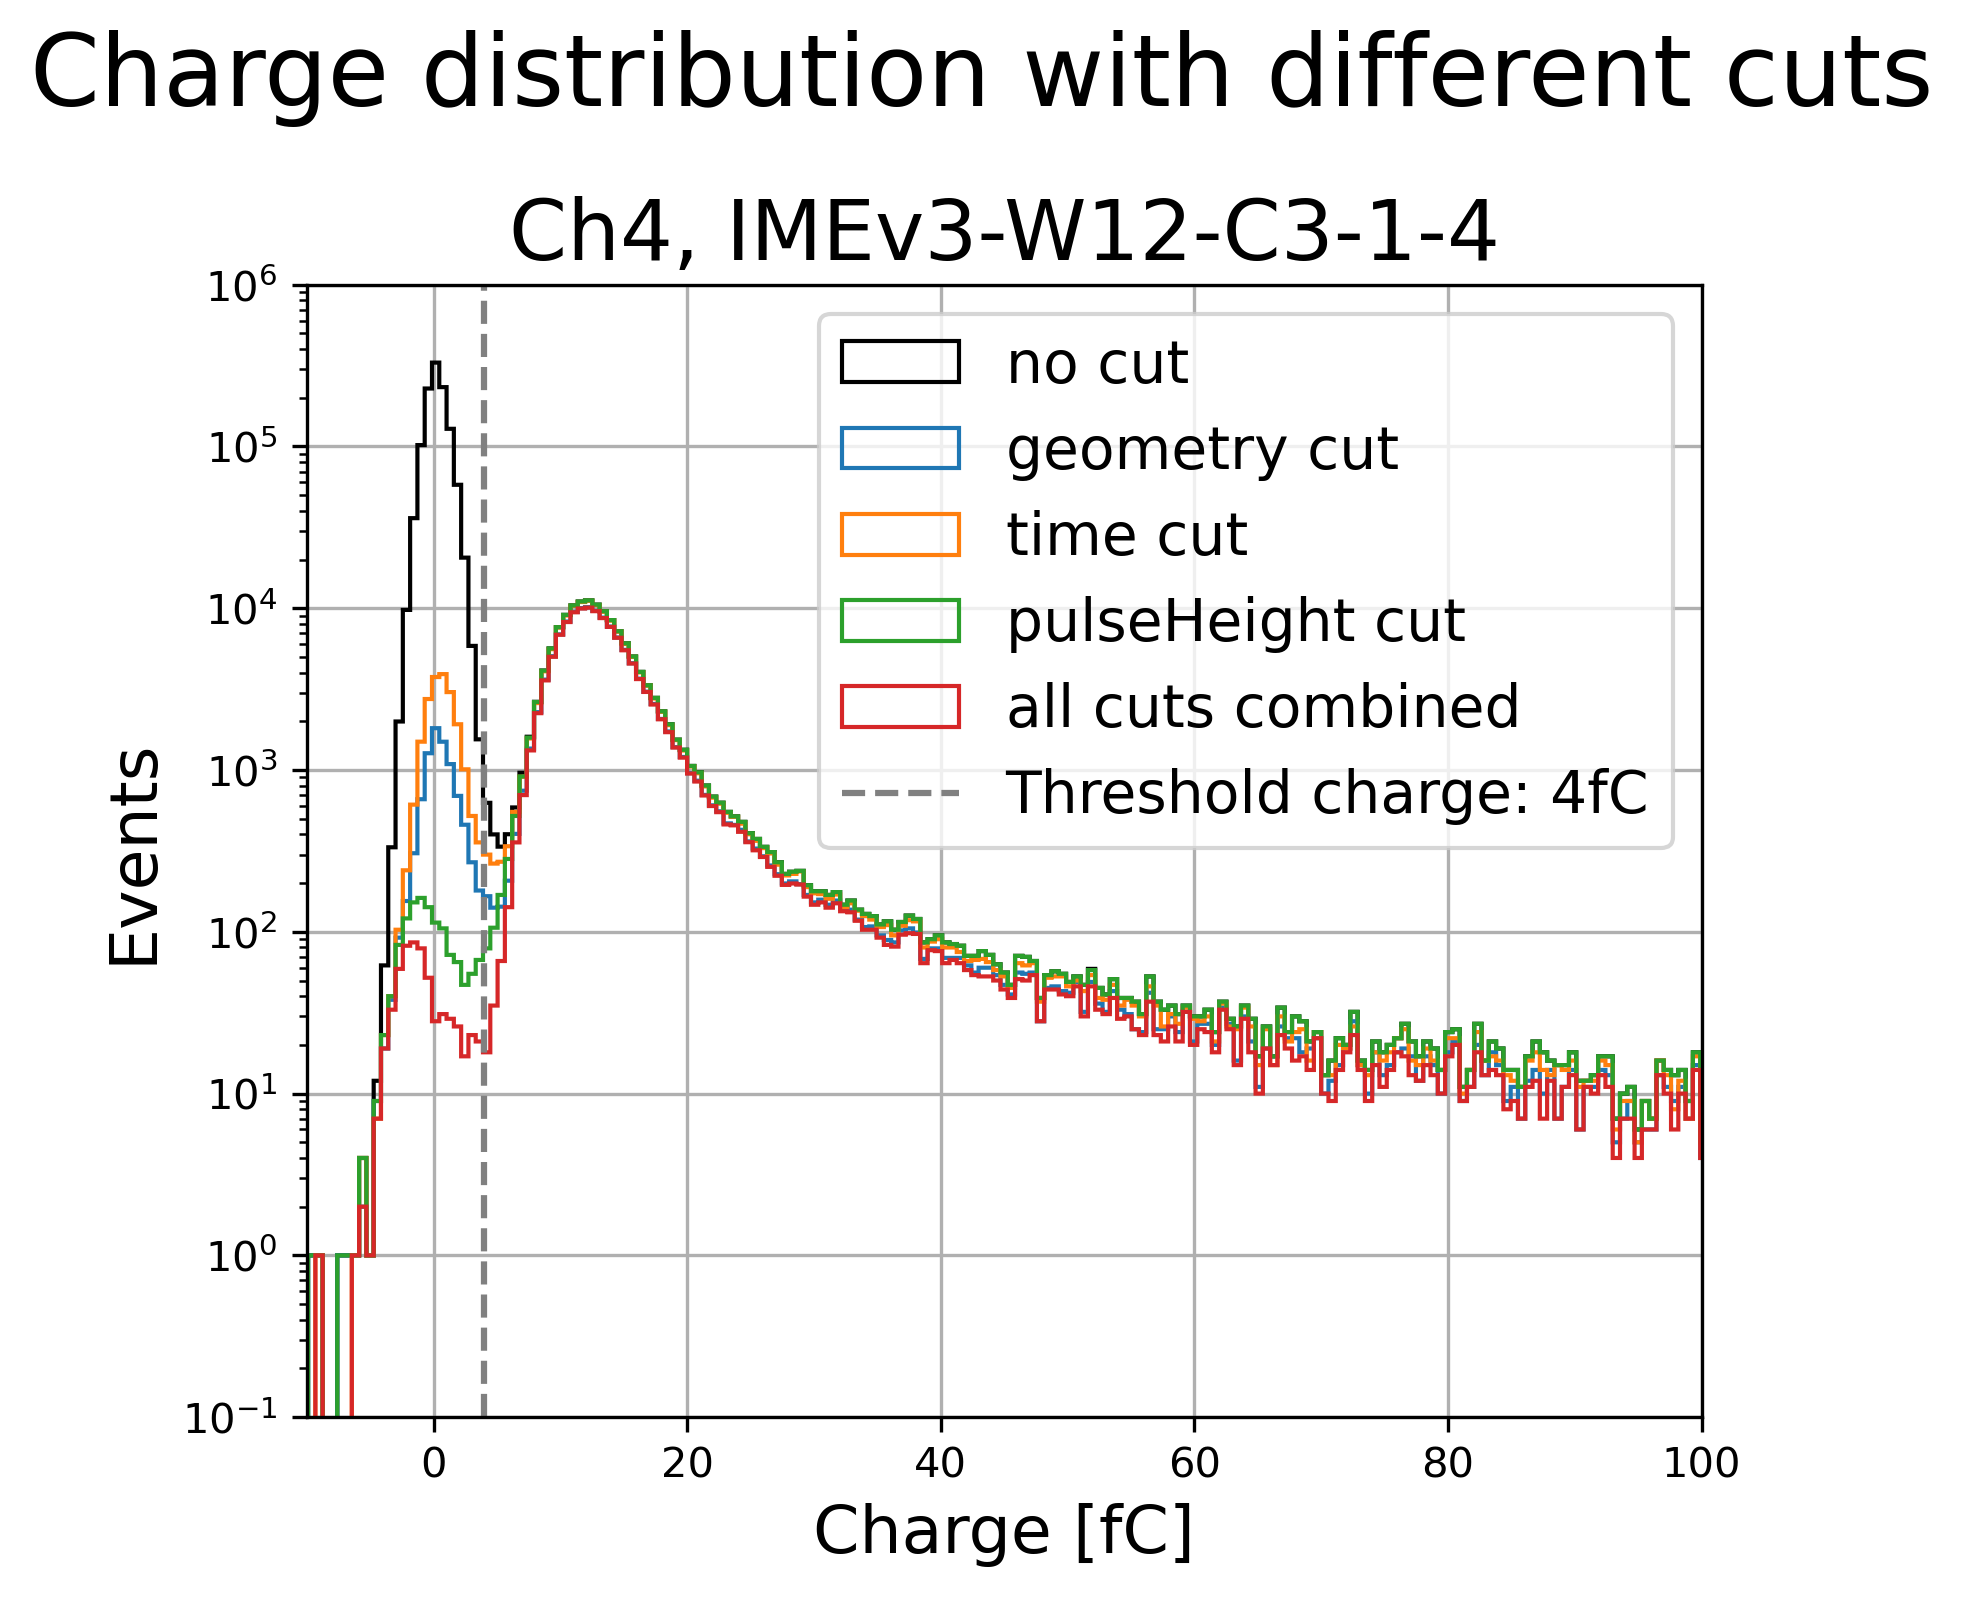

In [32]:

fig, axes = plt.subplots(figsize=(6*len(DUTs),5), ncols=len(DUTs), dpi=300)

### if there is only on dut
if len(DUTs)==1: axes = [axes]

transimpedance = [4700]*3   ### apparently the transimpedance is wrong

for i,dut in enumerate(DUTs):
    hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}']/transimpedance[dut-1], bins=1000,
                                          color=colormap[0], label=f"no cut",
                                          fig_ax=(fig,axes[i]))
    
    hist_geo_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"geometry cut",
                                                   fig_ax=(fig,axes[i]))
    
    hist_time_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"time cut",
                                                   fig_ax=(fig,axes[i]))
    
    hist_pulse_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"pulseHeight cut",
                                                   fig_ax=(fig,axes[i]))
    
    hist_all_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[all_cuts[dut-1]]/transimpedance[dut-1]), bins=my_bins,
                                                   histtype='step', alpha=1, label=f"all cuts combined",
                                                   fig_ax=(fig,axes[i]))
    
#     hist_time_geo_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[np.logical_and(time_cuts[dut-1], geo_cuts[dut-1])]/transimpedance[dut-1]), bins=my_bins,
#                                                    histtype='step', alpha=1, label=f"time cuts and geo cuts",
#                                                    fig_ax=(fig,axes[i]))
    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)
    
    axes[i].axvline(threshold_charge, linestyle='--', color='grey', label=f'Threshold charge: {threshold_charge}fC')
    
    axes[i].semilogy()
    axes[i].set_xlim(-10, 100)
    axes[i].set_ylim(1e-1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f"Ch{dut+1}, {dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').name}",fontsize=20)
    
    ### if I want to hightlight an interval
#     interesting_interval = (5,40)
#     axes[i].axvspan(*interesting_interval, ymin=0, ymax=1, alpha=0.4, color='red', label='Events?')
    axes[i].legend(fontsize=14)

fig.suptitle(f"Charge distribution with different cuts", fontsize=24, y=1.05)

if SAVE:
    fig.savefig(os.path.join(pres_path,f'Charge_distribution_different_cuts_batch_{this_batch}_{S}.png'), bbox_inches='tight')

   ------------------------------------------------------------------
  | Welcome to ROOT 6.30/04                        https://root.cern |
  | (c) 1995-2024, The ROOT Team; conception: R. Brun, F. Rademakers |
  | Built for linuxx8664gcc on Mar 04 2024, 12:51:52                 |
  | From heads/latest-stable@                                        |
  | With c++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0                   |
  | Try '.help'/'.?', '.demo', '.license', '.credits', '.quit'/'.q'  |
   ------------------------------------------------------------------


Processing charge_fit.C(401,"S1",3)...
size: 128401
Fitting...
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      517.052
NDf                       =          201
Edm                       =  1.09339e-05
NCalls                    =          217
Width                     =     0.685456   +/-   0.00566768   	 (limited)
MP                        =      11.3955   +/-   0.0105214  

Info in <TCanvas::Print>: SVG file /home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/all batches/401/charge_data_all_cuts_401_S1_3_Charge_fit_ROOT_double_plot.svg has been created


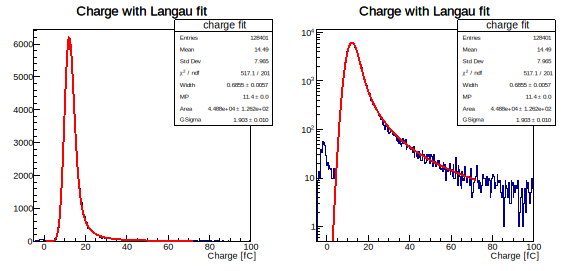

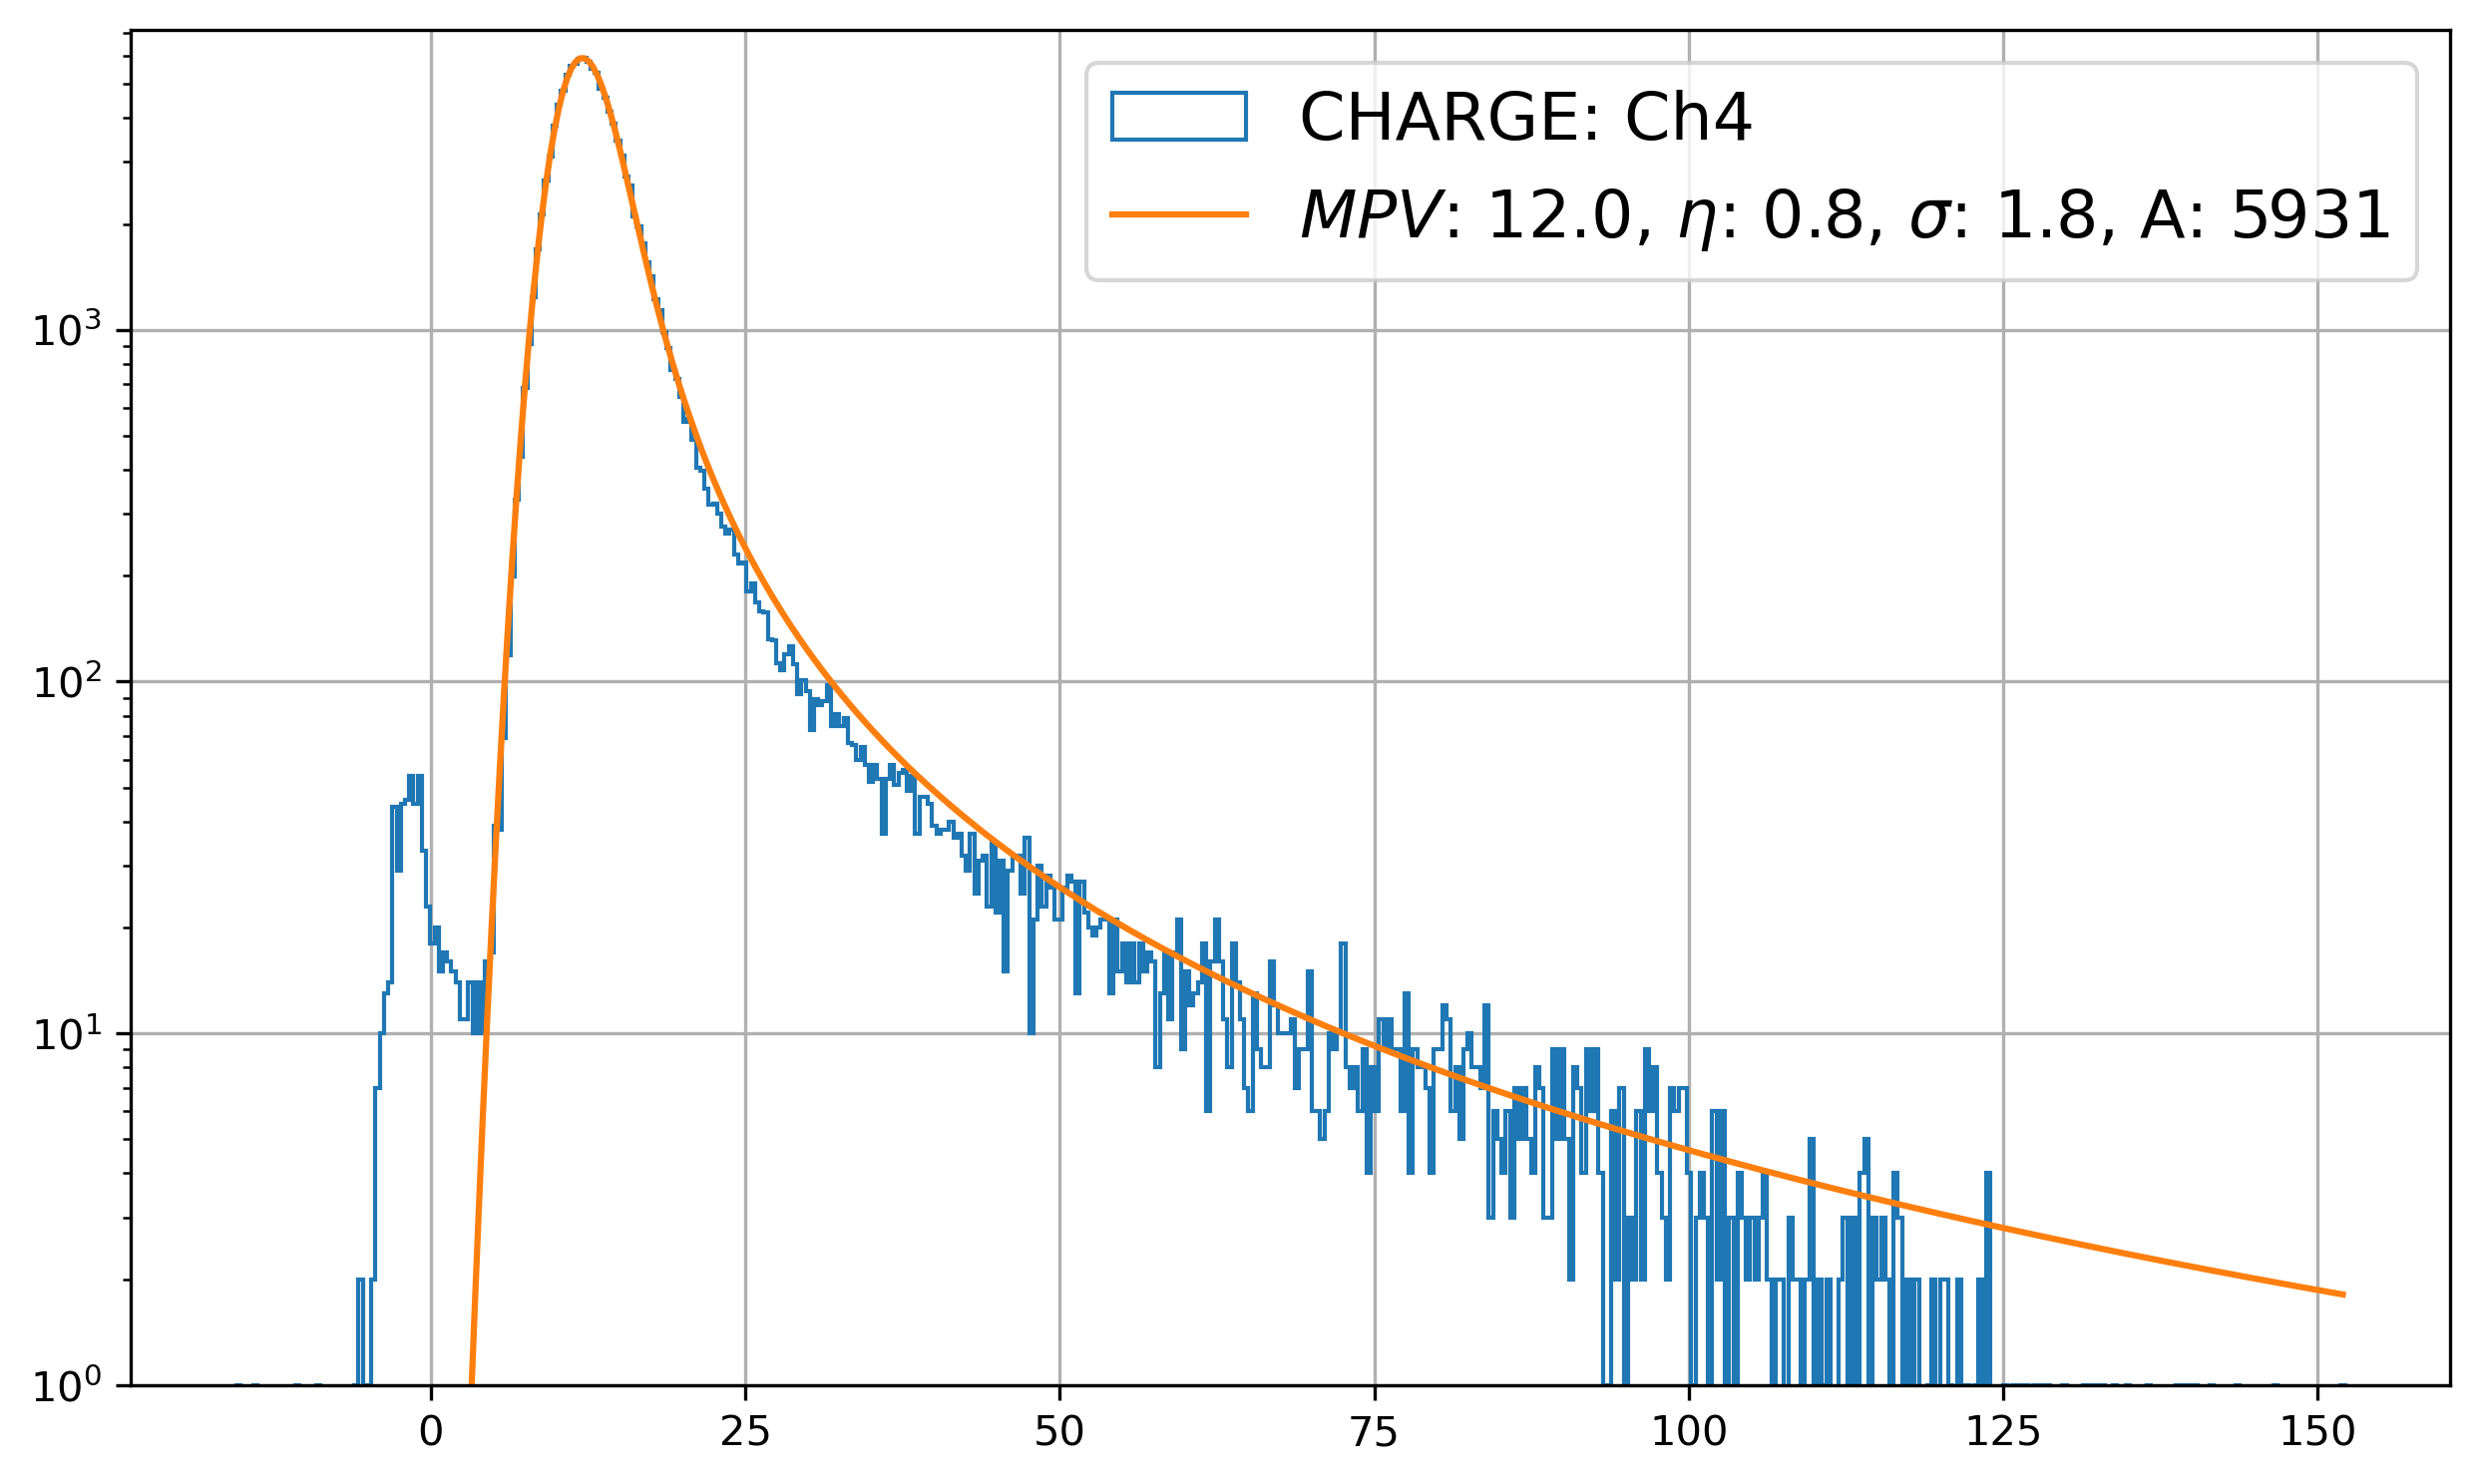

In [52]:
dir_path = f'/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/all batches/{this_batch}'
ROOT_fit_dir = f"/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/ROOT Langaus fit/"
my_transimpedance = 4700

for dut in DUTs:
    charge_fit(df, dut, mask=all_cuts[dut-1], transimpedance=my_transimpedance, bins=charge_bins,
              plot=True, savefig=os.path.join(pres_path,f"charge_plot_fit_{this_batch}_{S}_{dut}.png"))

    np.savetxt(os.path.join(dir_path, f"charge_data_all_cuts_{this_batch}_{S}_{dut}.csv"),
               df[f'charge_{dut}'].loc[all_cuts[dut-1]]/my_transimpedance, delimiter=',')
    os.chdir(ROOT_fit_dir)
    run_root_string = f'root -b -q "charge_fit.C({this_batch},\\"{S}\\",{dut})"'
    os.system(run_root_string)
    
os.chdir("/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis")
SVG(f"../various plots/all batches/{this_batch}/charge_data_all_cuts_{this_batch}_{S}_{dut}_Charge_fit_ROOT_double_plot.svg")


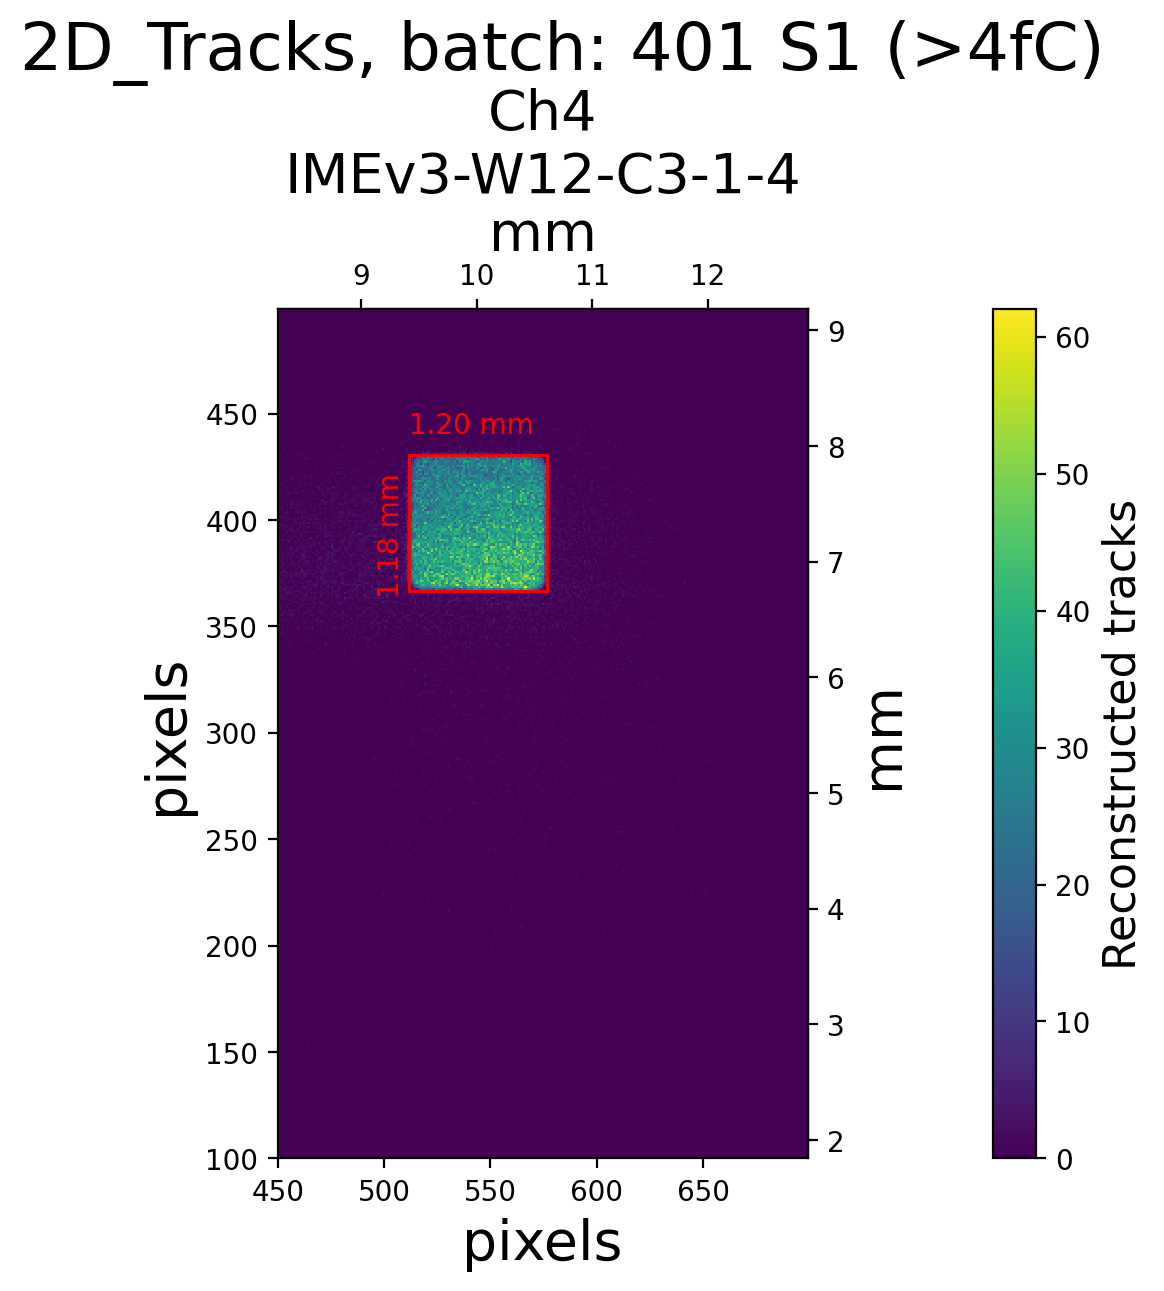

In [55]:
### I'm looking at the charge that "seems" a signal
charge_mask = [df[f'charge_{dut}']/4700>threshold_charge if dut in DUTs else None for dut in [1,2,3]]

fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, mask=charge_mask,
     n_DUT=DUTs, savefig=False, savefig_details=f'{S} (>4fC)', savefig_path=pres_path, fmt='png')

for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos_time[dut-1]))
    sensor_size = (geo_infos_time[dut-1]['right_edge']-geo_infos_time[dut-1]['left_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos_time[dut-1]['left_edge'], y=geo_infos_time[dut-1]['top_edge']+10, s='%.2f mm'%sensor_size, color='r')
    sensor_height = (geo_infos_time[dut-1]['top_edge']-geo_infos_time[dut-1]['bottom_edge'])*PIXEL_SIZE
    axes[i].text(x=geo_infos_time[dut-1]['left_edge']-15, y=geo_infos_time[dut-1]['bottom_edge'], s='%.2f mm'%sensor_height, color='r', rotation='vertical')

if SAVE:
    fig.savefig(os.path.join(pres_path,f'2D_Tracks_highlighting_events_higher_charge_{this_batch}_{S}.png'), bbox_inches='tight')
    

### Gaussian*Langau fit
I should put at least this as an option in plot()

/tmp/ipykernel_97058/1093225570.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))/(len(hist_all_cut)-len(param))
/tmp/ipykernel_97058/1093225570.py:21: RuntimeWarning: invalid value encountered in divide
  chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))/(len(hist_all_cut)-len(param))
/tmp/ipykernel_97058/1093225570.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit", co

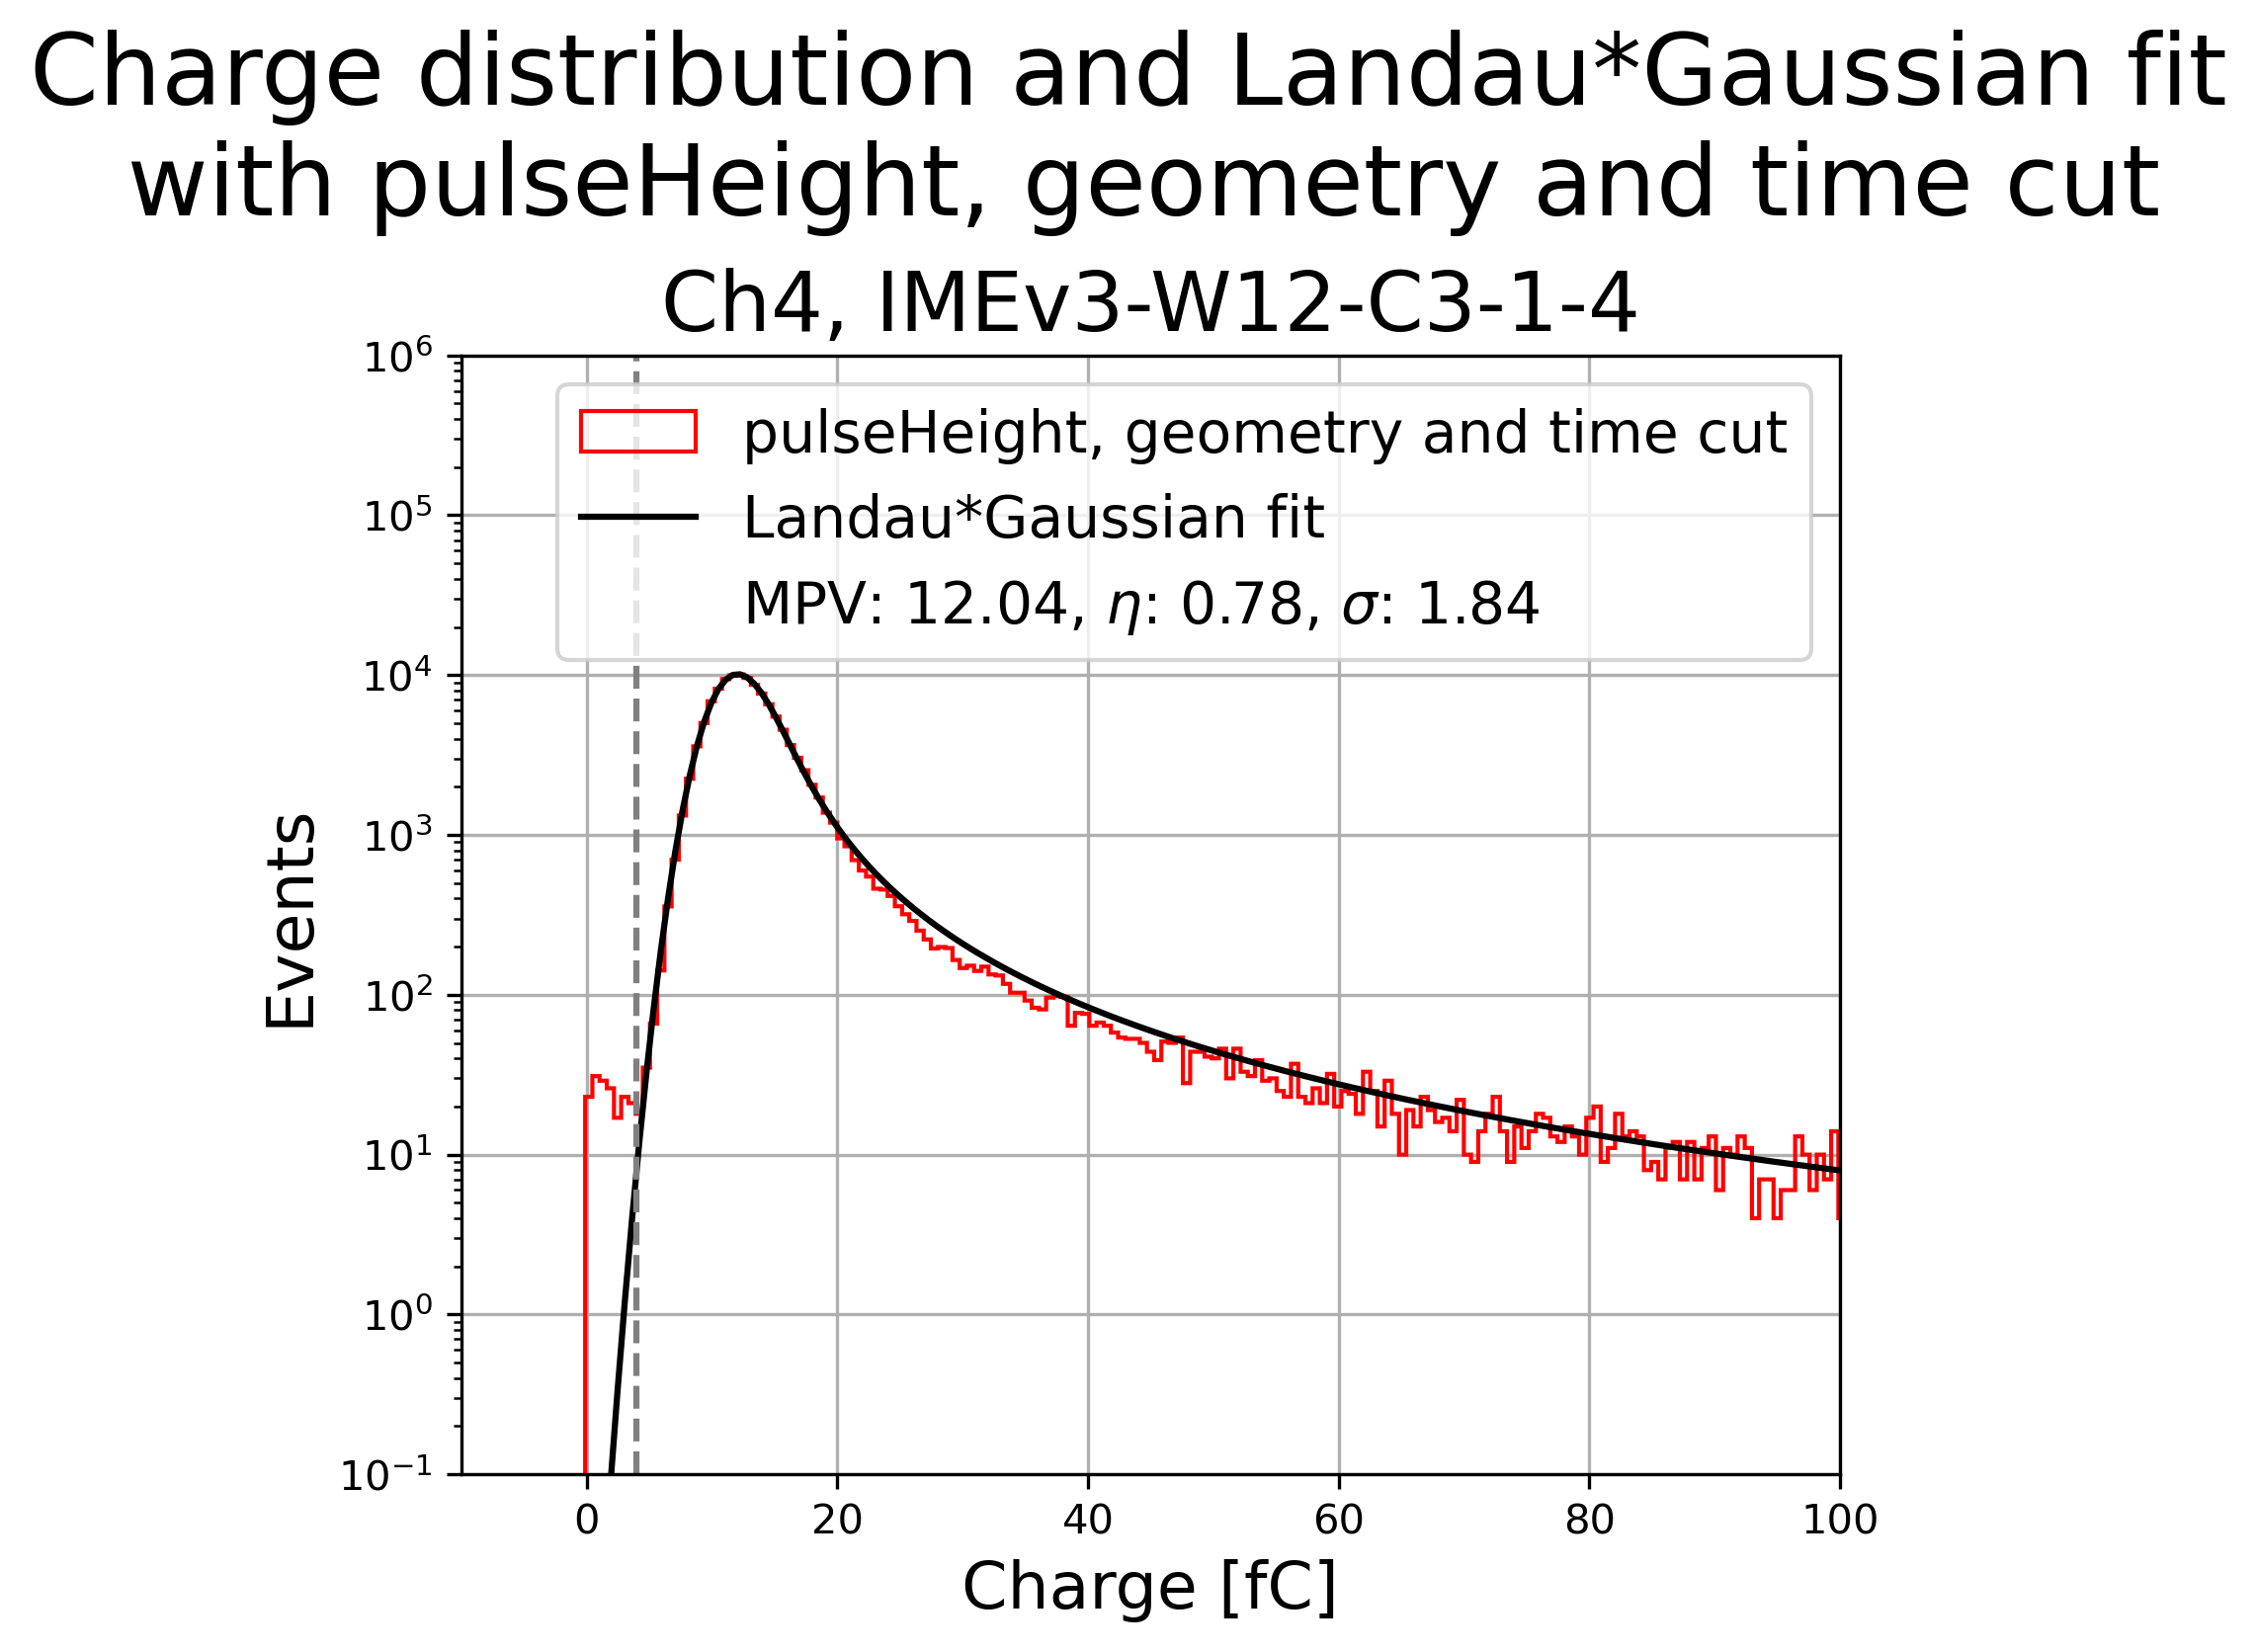

In [29]:
### with PULSEHEIGHT cut, TIME cut and AREA OF THE SENSOR (geometry cut)
### this is no longer useful, as the fit are now done using ROOT

fig, axes = plt.subplots(figsize=(6*len(DUTs),5), ncols=len(DUTs), dpi=300)

### if there is only one dut
if len(DUTs)==1: axes = [axes]

for i,dut in enumerate(DUTs):
#     transimpedance = dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance
    transimpedance = 4700    ### I want to use the same 'my_bins' as the plot just before
    hist_all_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[fit_cuts[dut-1]]/transimpedance), bins=my_bins,
                                           histtype='step', alpha=1, label=f"pulseHeight, geometry and time cut", color='red',
                                           fig_ax=(fig,axes[i]))

    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)

    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_all_cut, p0=(my_bins[np.argmax(hist_all_cut)],1,1,np.max(hist_all_cut)))
#     param, covariance = charge_fit(df, dut, mask=all_cuts[dut-1], transimpedance=transimpedance, plot=False)
    chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))/(len(hist_all_cut)-len(param))
#     axes[i].plot([],[],linewidth=0, label="$\chi^2$ reduced: "+f"%.1f"%chi2_reduced)
    
    axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit", color='black')
    
    axes[i].semilogy()
    axes[i].set_xlim(-10, 100)
    axes[i].set_ylim(1e-1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f"Ch{dut+1}, {dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').name}",fontsize=20)
    legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
    handles, labels = axes[i].get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label=legend_text))
    axes[i].legend(handles=handles, fontsize=14);
    axes[i].axvline(threshold_charge, linestyle='--', color='grey', label=f'Threshold charge: {threshold_charge}fC')
    
fig.suptitle(f"Charge distribution and Landau*Gaussian fit\n with pulseHeight, geometry and time cut", fontsize=24, y=1.1)

if SAVE:
    fig.savefig(os.path.join(pres_path,f"Charge_distribution_with_langau_fit_{this_batch}.png"),bbox_inches='tight')


In [30]:
# chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))/(len(hist_all_cut)-len(param))

In [57]:
chi2_reduced = sum((hist_all_cut-pylandau.langau(bins_centers,*param))**2/pylandau.langau(bins_centers,*param))#/(len(hist_all_cut)-len(param))
chi2_reduced

RuntimeError: Cannot calculate MPV, check function parameters and file bug report!

/tmp/ipykernel_97058/1623183372.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")


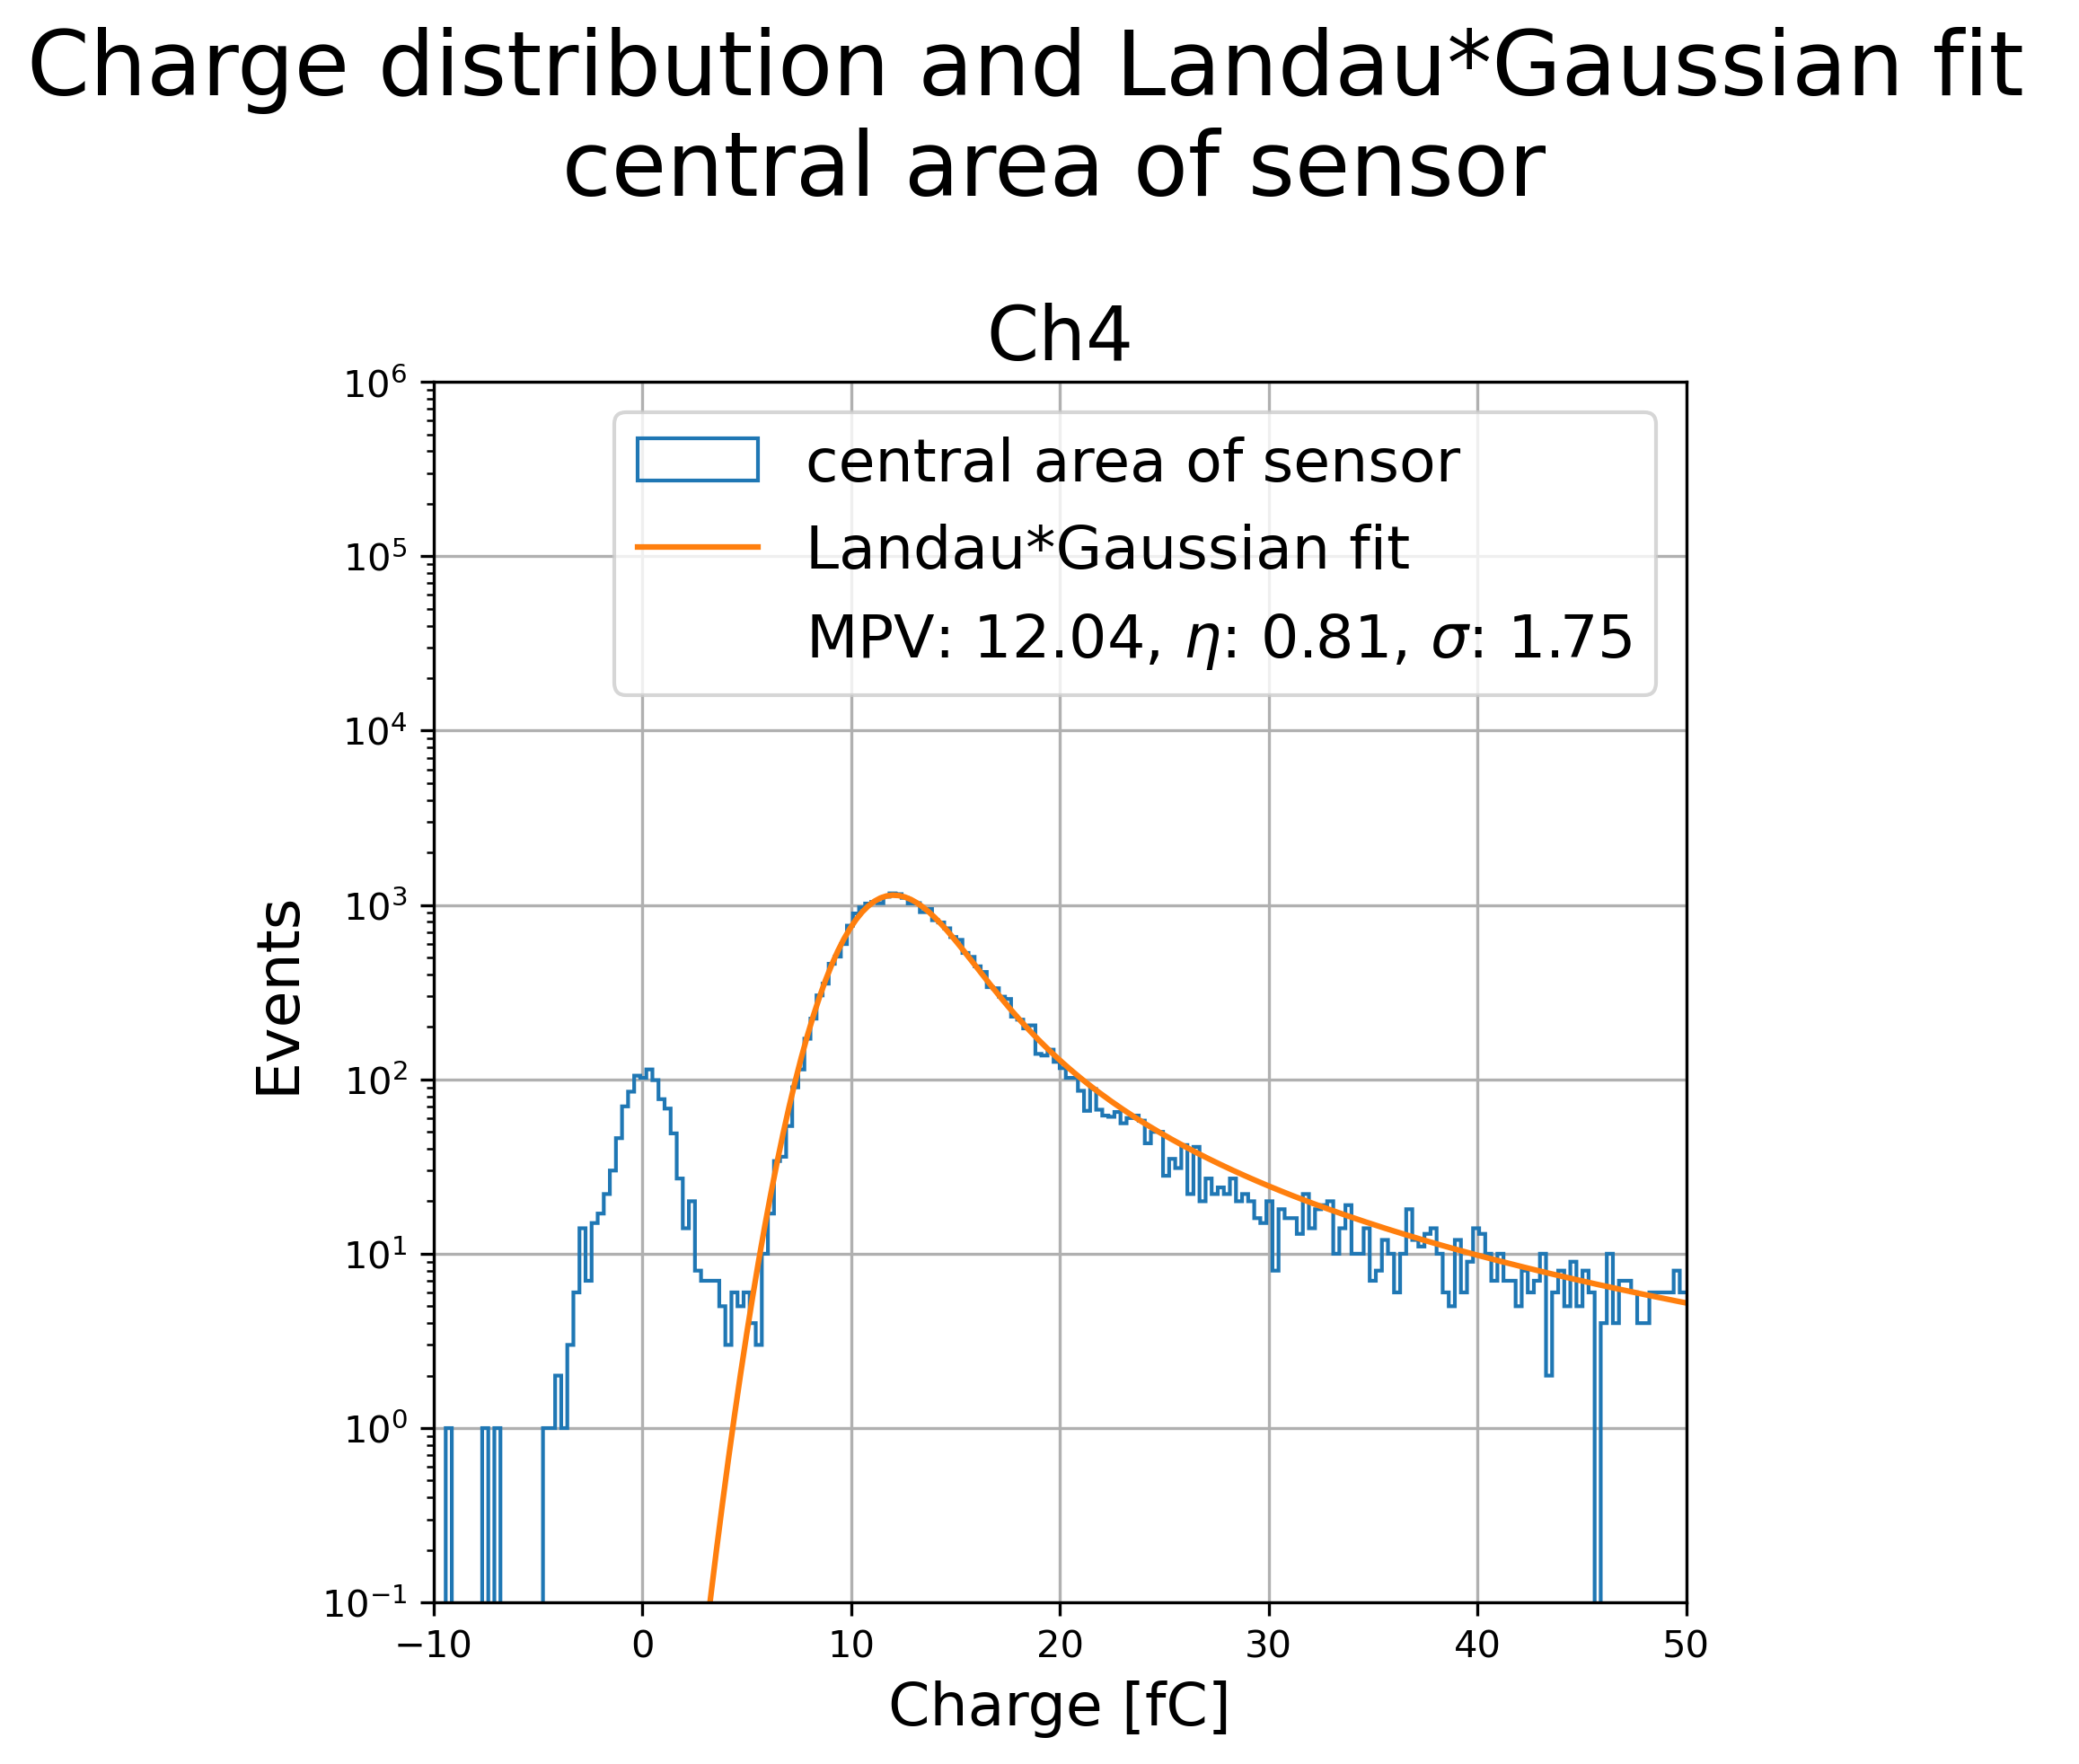

In [32]:
### with only CENTRAL AREA OF THE SENSOR (geometry cut)

fig, axes = plt.subplots(figsize=(6*len(DUTs),6), ncols=len(DUTs), dpi=300)
### if there is only on dut
axes = [axes]

for i,dut in enumerate(DUTs):
#     transimpedance = dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance
    transimpedance = 4700
    hist_center_cut,my_bins,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[central_sensor_area_cuts[dut-1]]/transimpedance), bins='auto',
                                           histtype='step', alpha=1, label=f"central area of sensor",
                                           fig_ax=(fig,axes[i]))

    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)

    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_center_cut, p0=(my_bins[np.argmax(hist_center_cut)],1,1,np.max(hist_center_cut)))
    axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
    
    axes[i].semilogy()
    axes[i].set_xlim(-10, 50)
    axes[i].set_ylim(0.1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f'Ch{dut+1}',fontsize=20)
    legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
    handles, labels = axes[i].get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label=legend_text))
    axes[i].legend(handles=handles, fontsize=16);
    
fig.suptitle(f"Charge distribution and Landau*Gaussian fit \n central area of sensor", fontsize=24, y=1.1)

if SAVE:
    fig.savefig(f"../various plots/Charge_distribution_fit_{this_batch}.svg",bbox_inches='tight')


# Time resolution


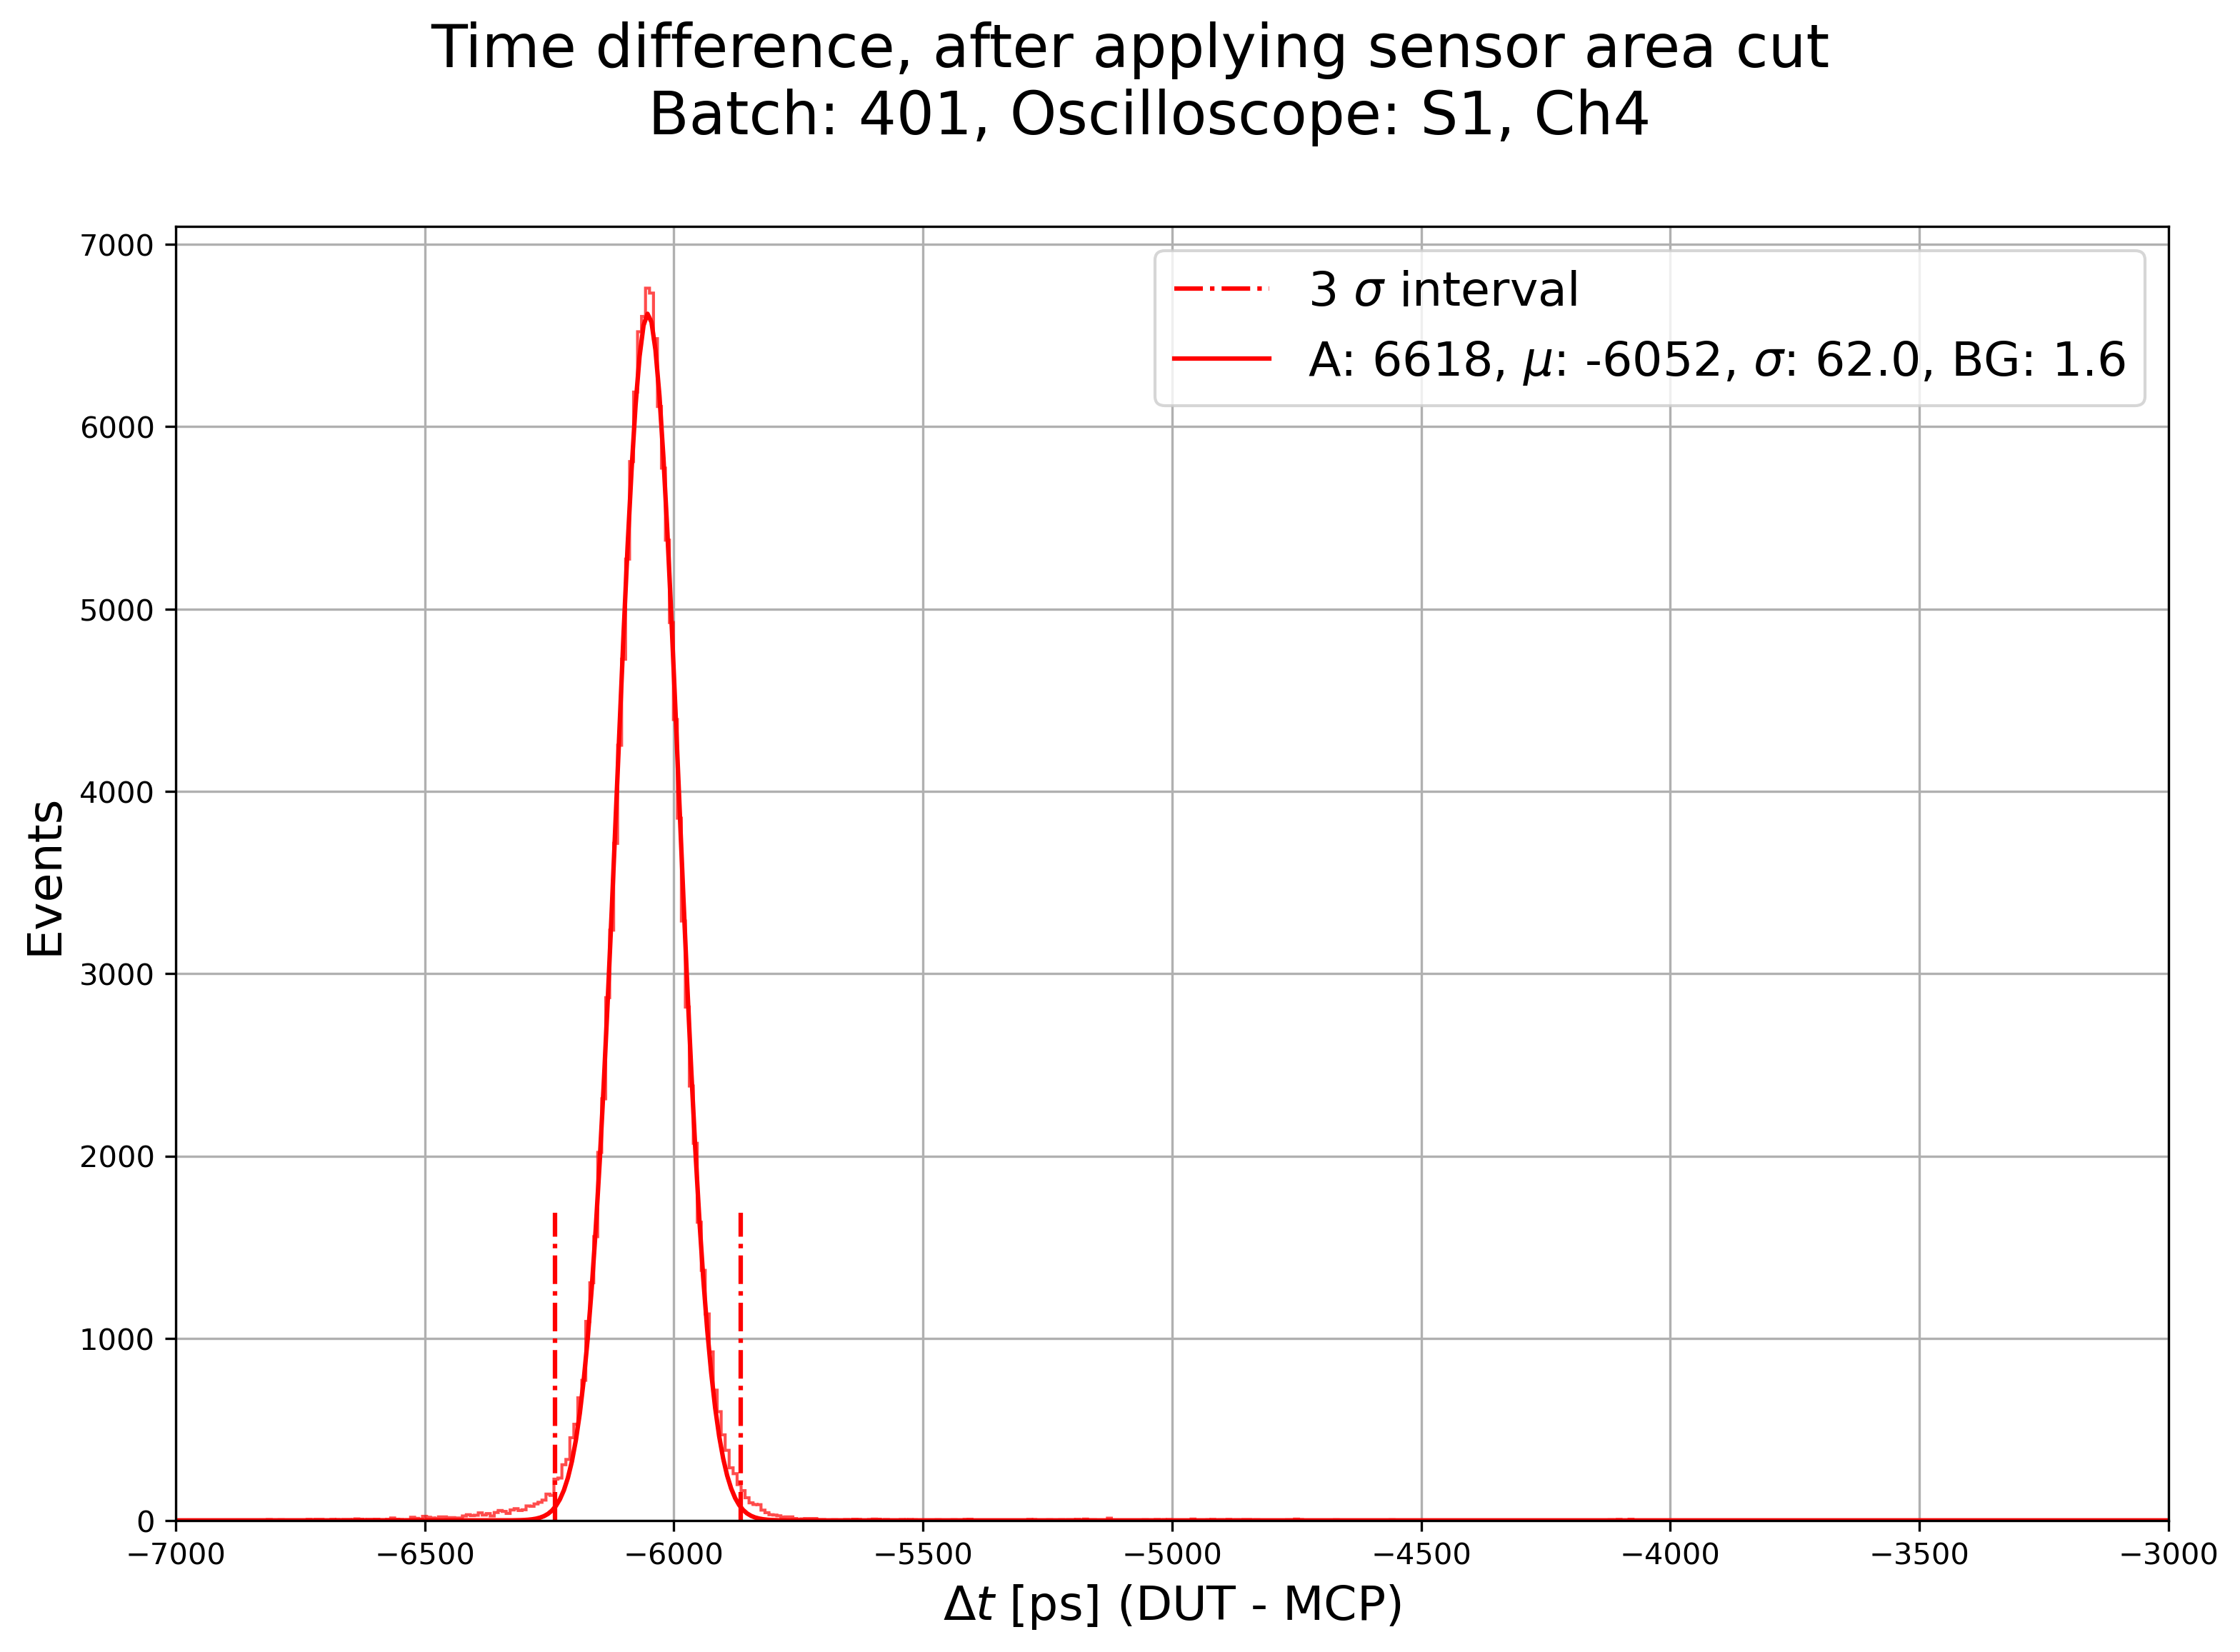

In [58]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)
# pulse_geo_cuts = [np.logical_and(geo_cuts[dut-1], pulse_cuts[dut-1]) for dut in DUTs]

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    dut_cut = np.logical_and(window_fit, geo_cuts[dut-1])
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
    axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.1f, BG: %.1f" %(param[0],param[1], param[2], param[3])) # only two decimals

axes.set_xlabel(f"$\Delta t$ [ps] (DUT - MCP)", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference, after applying sensor area cut \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_zoomed_and_gauss_fit_with_cuts.png"), bbox_inches="tight")

### Now trying only the central 0.5x0.5 mm²
Basically no difference

In [59]:
# central_sensor_area_cuts = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use='pulseheight')[0] if dut in DUTs else None for dut in [1,2,3]]
# central_sensor_area_info = [geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use='pulseheight')[1] if dut in DUTs else None for dut in [1,2,3]]

central_sensor_area_cuts, central_sensor_area_info = zip(*[geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use='pulseheight')
                                                           if dut in DUTs else (None,None) for dut in [1,2,3]])

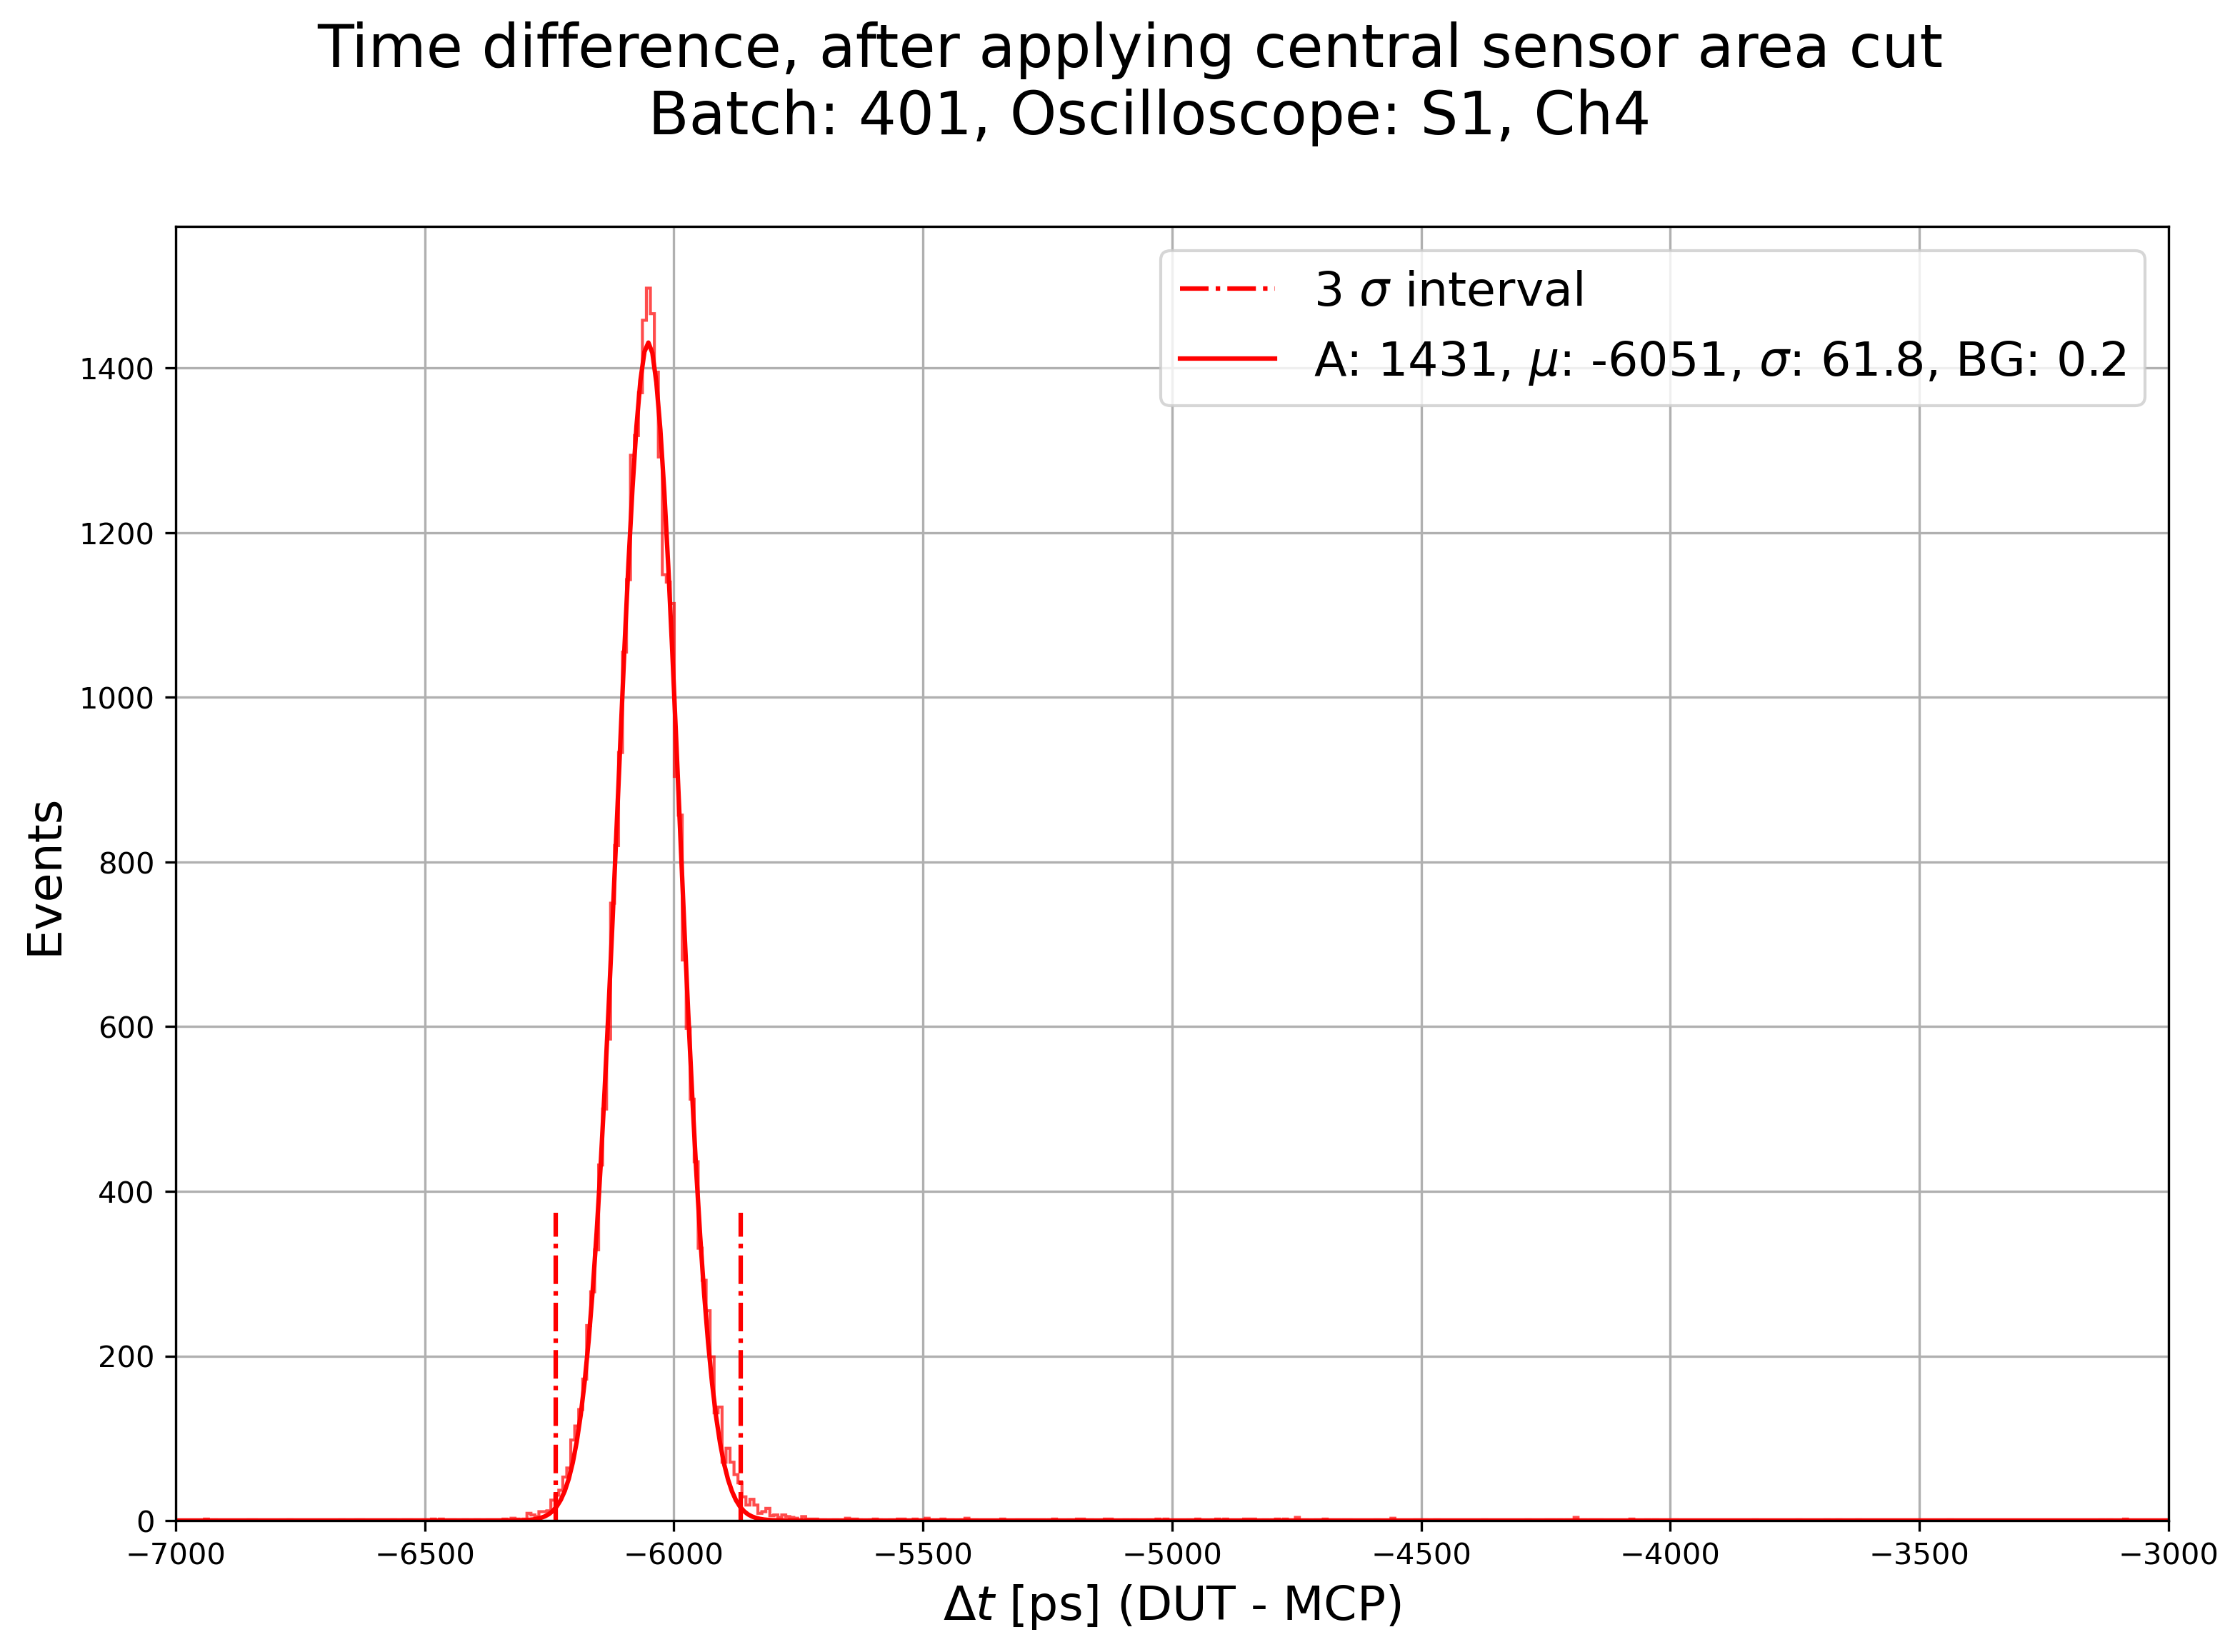

In [60]:
### ONLY CENTRAL AREA
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    dut_cut = np.logical_and(window_fit, central_sensor_area_cuts[dut-1])
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
    axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.1f, BG: %.1f" %(param[0],param[1], param[2], param[3])) # only two decimals

axes.set_xlabel(f"$\Delta t$ [ps] (DUT - MCP)", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference, after applying central sensor area cut \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_zoomed_and_gauss_fit_with_cuts.png"), bbox_inches="tight")

## Plotting both peaks and comparing
(maybe this part should be later)

parenthesis about the second/third peak in the $\Delta t$

In [61]:
SAVE = True

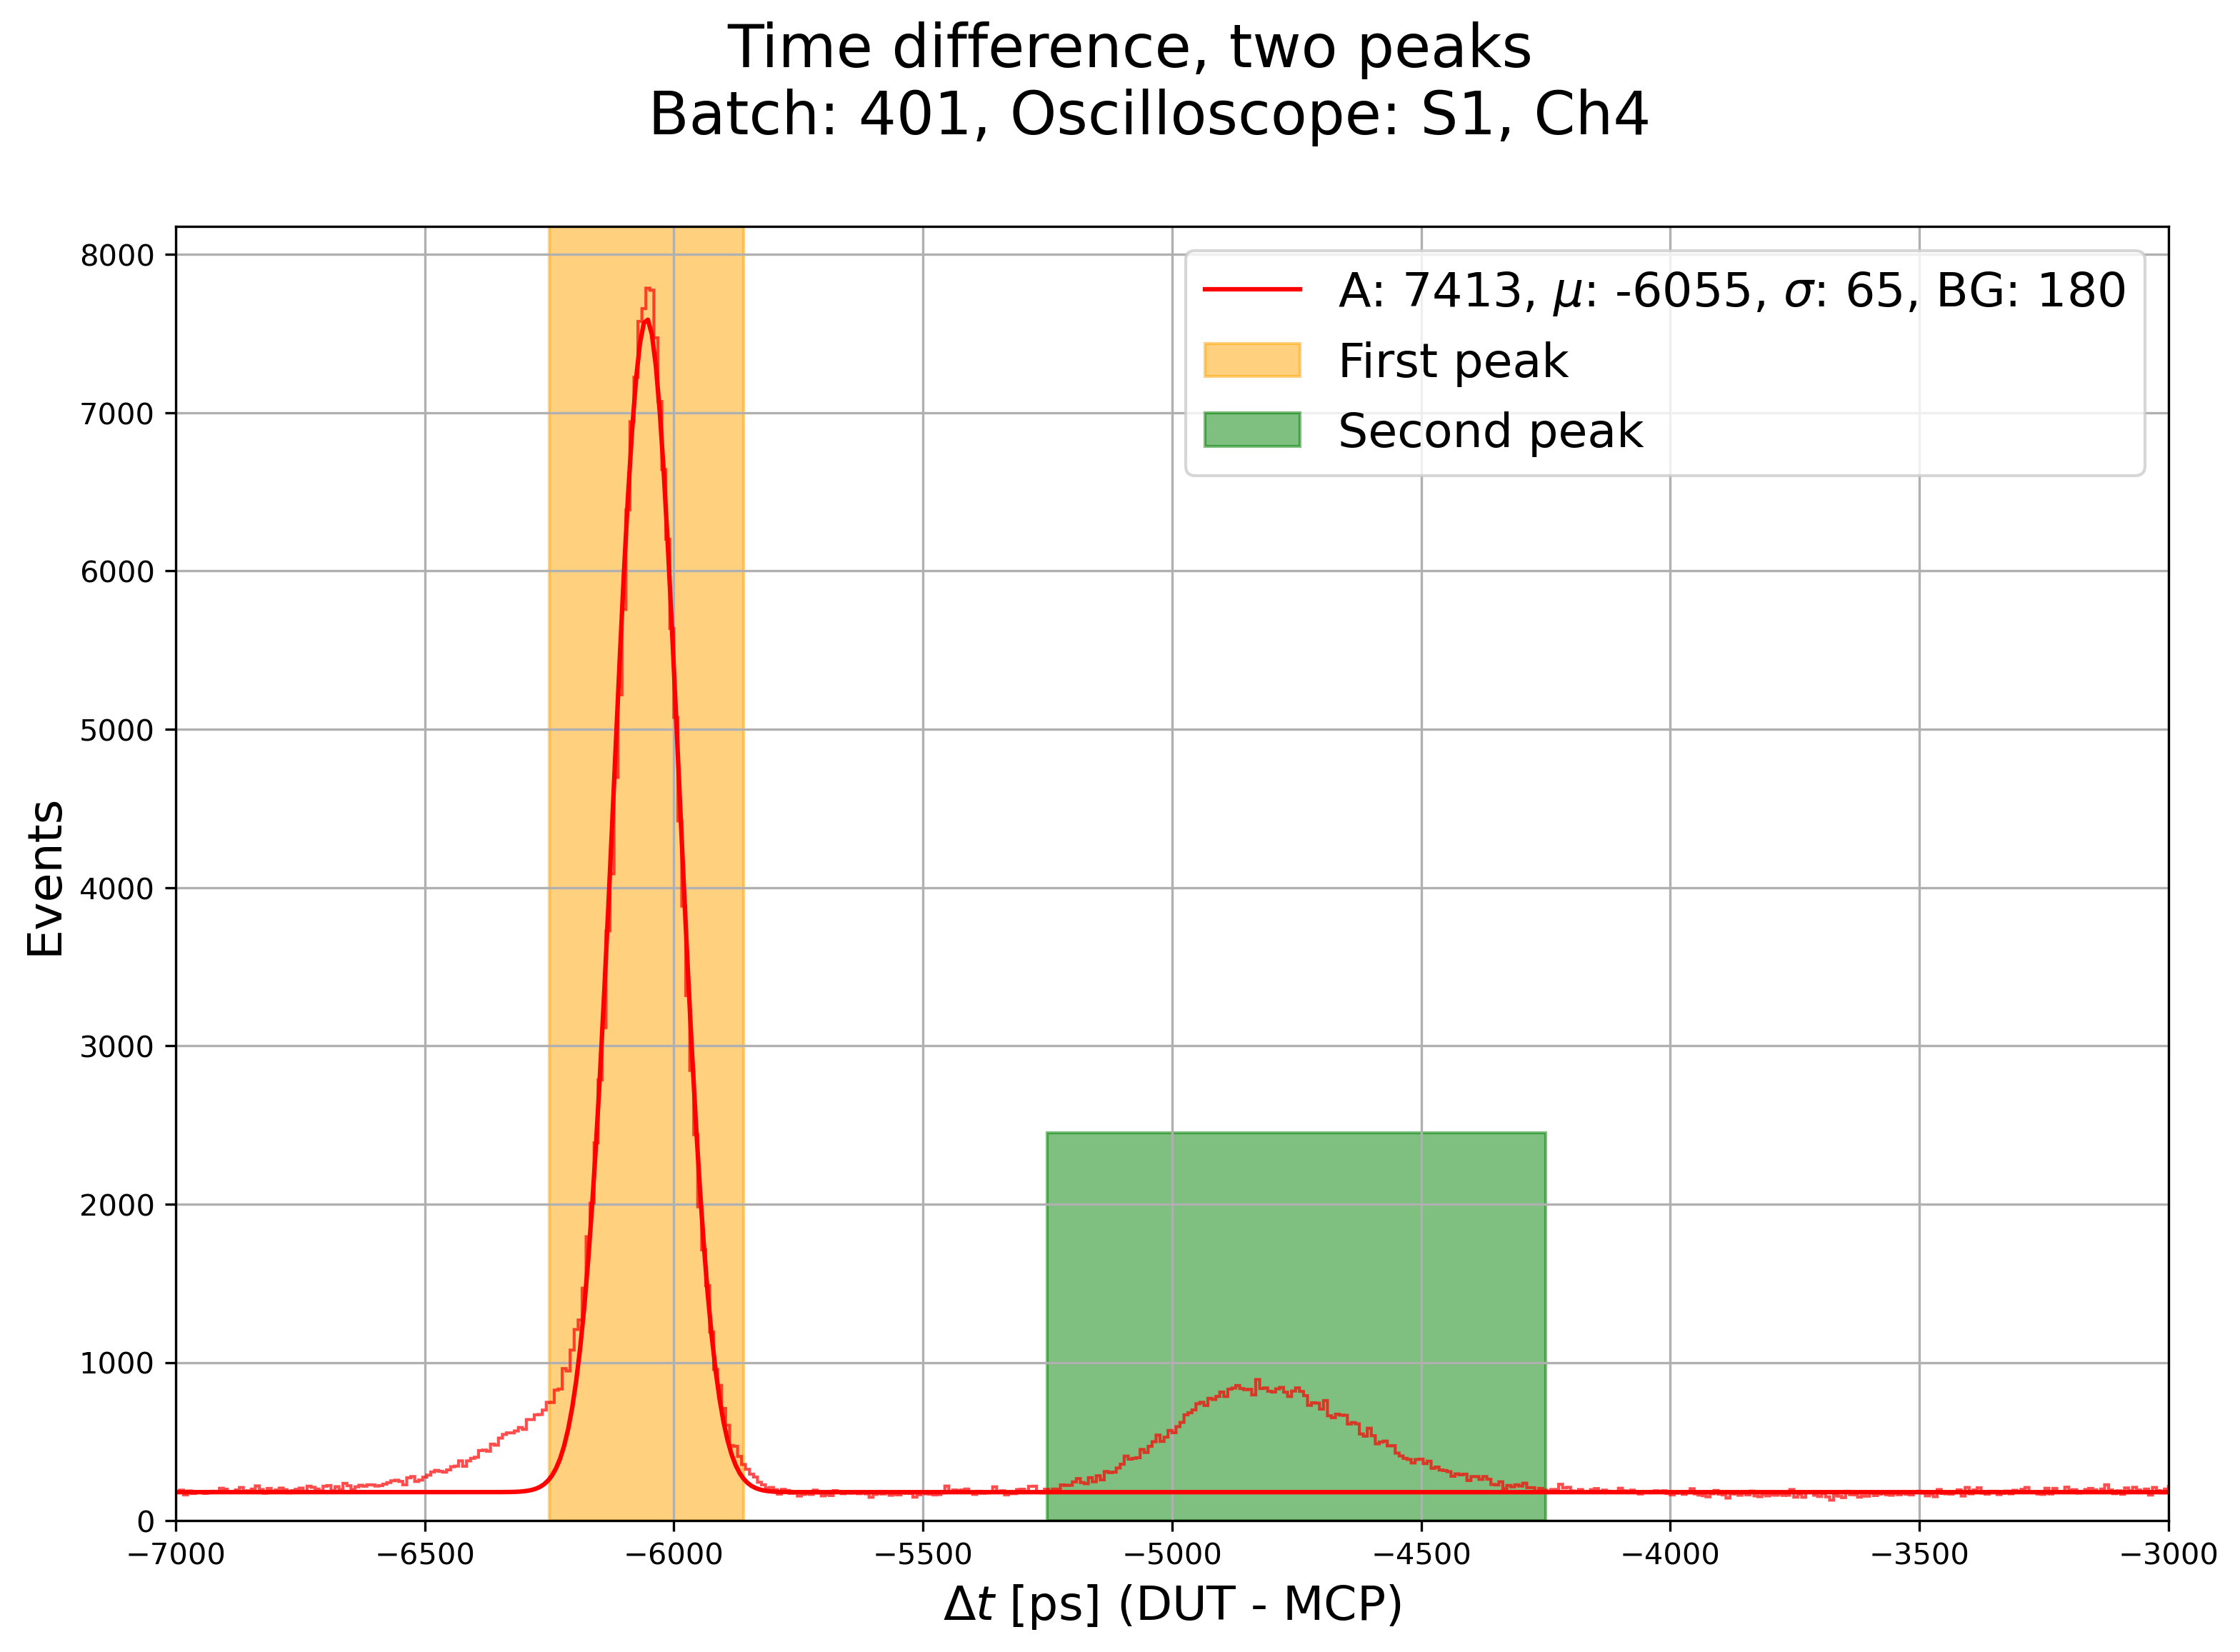

In [62]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

# for dut in DUTs:
one_dut = 3
for dut in [one_dut]:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]

    ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals

    ### this lines are just to visually find an interval on which to study interesting features
    
interesting_interval_1 = (left_base, right_base)
axes.axvspan(interesting_interval_1[0], interesting_interval_1[1], ymin=0, ymax=1, alpha=0.5, color='orange', label='First peak')

interesting_interval_2 = (-5250, -4250)
axes.axvspan(interesting_interval_2[0], interesting_interval_2[1], ymin=0, ymax=0.3, alpha=0.5, color='green', label='Second peak')

axes.set_xlabel(f"$\Delta t$ [ps] (DUT - MCP)", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-3e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference, two peaks \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_one_dut_with_both_peaks_simple.png"), bbox_inches="tight")

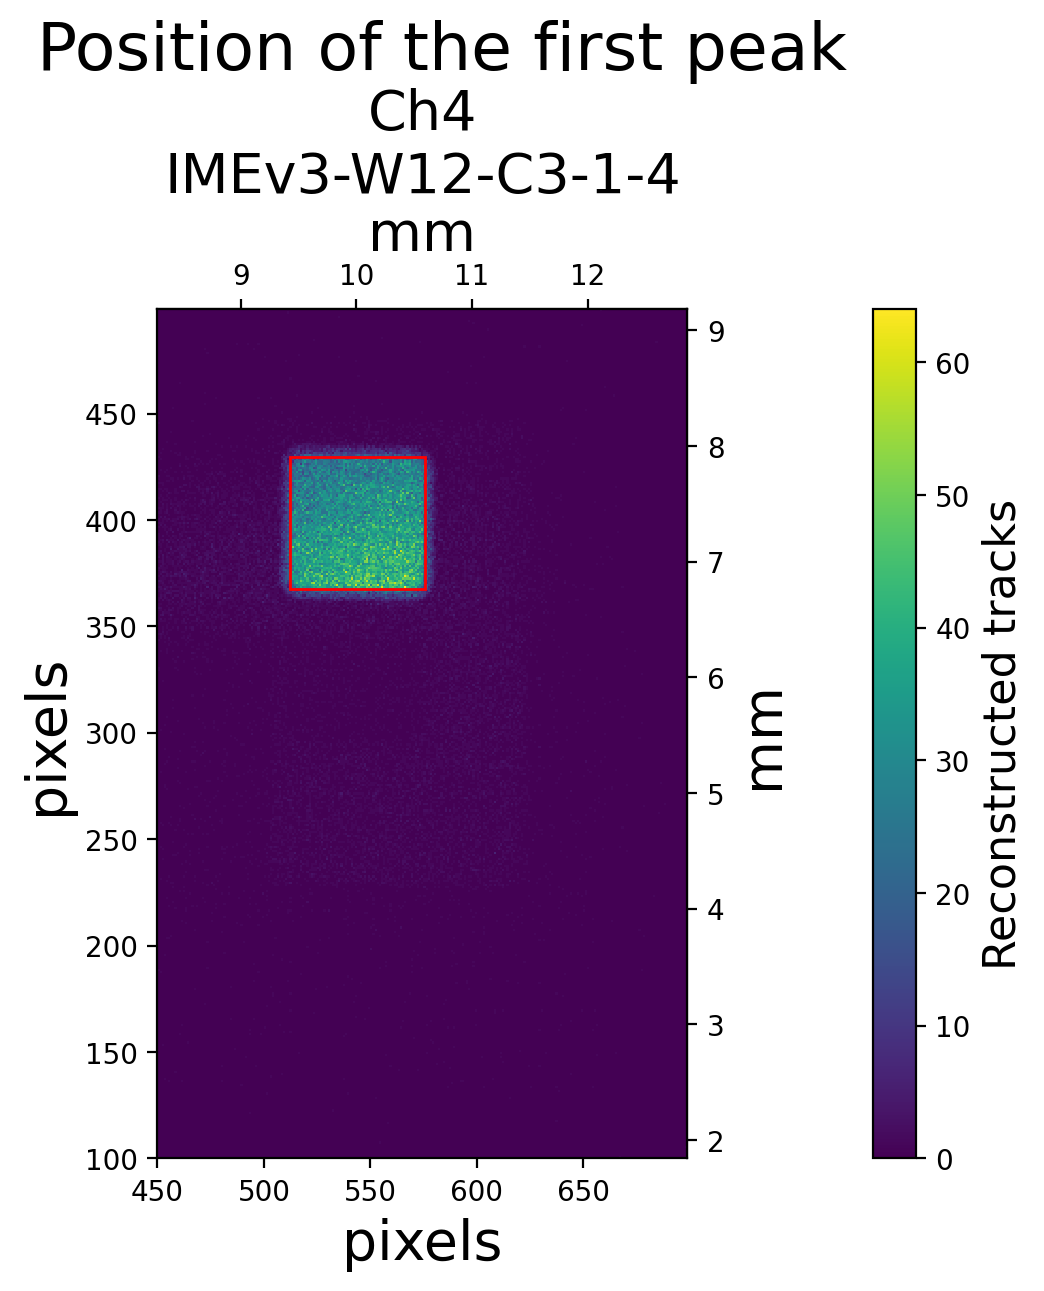

In [63]:
first_peak = [np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> interesting_interval_1[0],
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< interesting_interval_1[1]) for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[one_dut], mask=first_peak,
                    savefig=False, savefig_path=pres_path, savefig_details=f" position of second peak",fmt='png')
fig.suptitle("Position of the first peak", fontsize=24, y=1.05)

ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[one_dut-1]))

if SAVE:
    fig.savefig(os.path.join(pres_path, f"2D Tracks {this_batch}_{S}_one_dut_with_first_peak.png"), bbox_inches="tight")


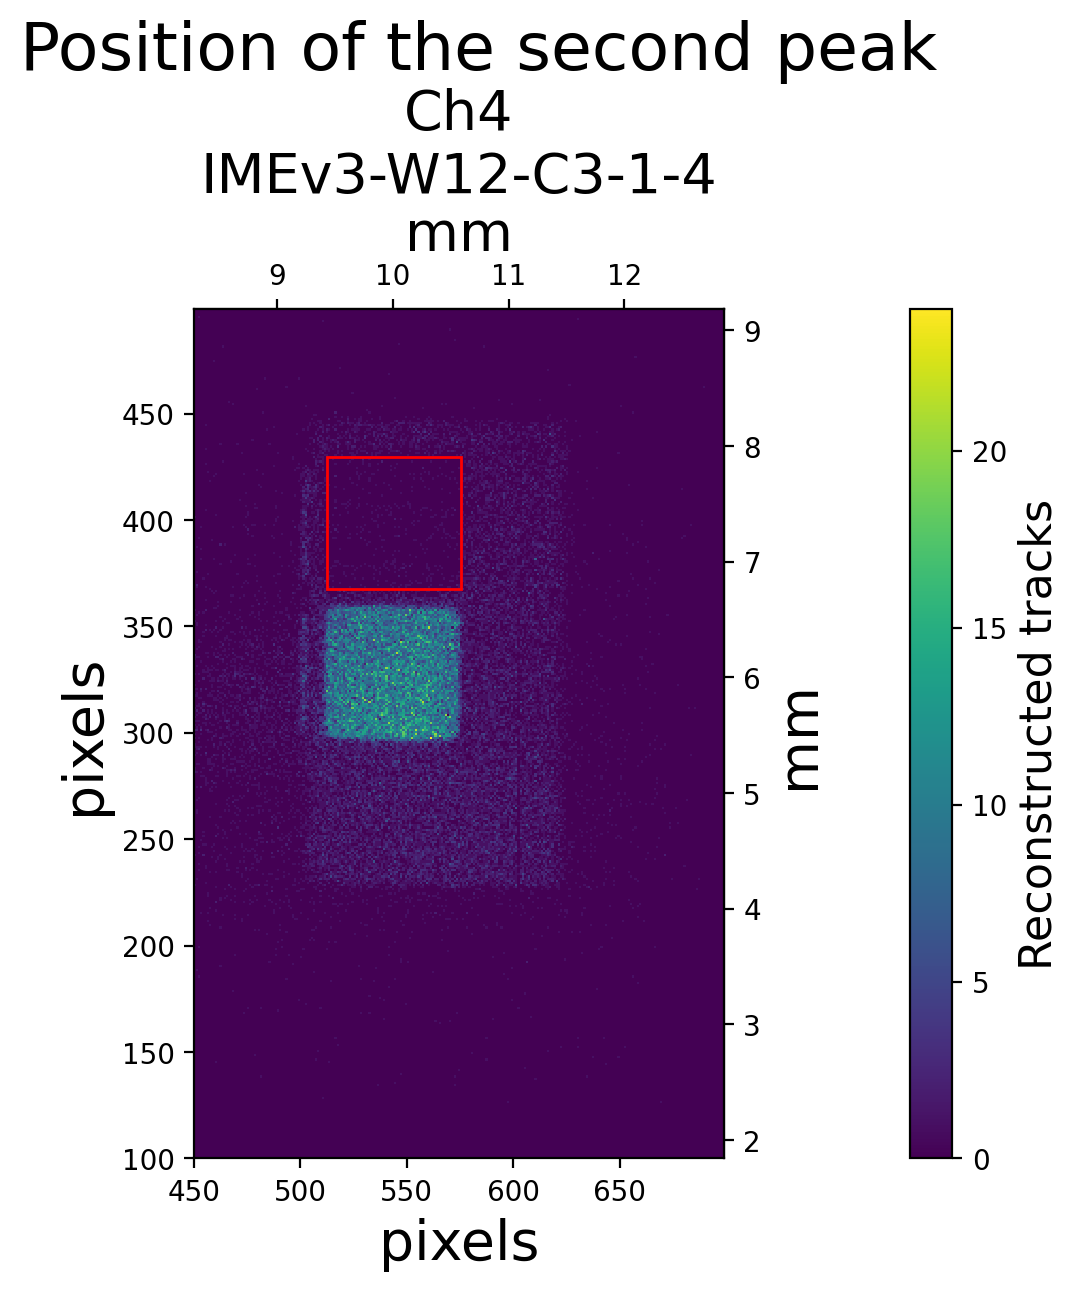

In [64]:
second_peak = [np.logical_and((df[f"timeCFD20_{one_dut}"]-df["timeCFD50_0"])> interesting_interval_2[0],
                               (df[f"timeCFD20_{one_dut}"]-df["timeCFD50_0"])< interesting_interval_2[1]) for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[one_dut], mask=second_peak,
                    savefig=False, savefig_path=pres_path, savefig_details=f" position of second peak",fmt='png')
fig.suptitle("Position of the second peak", fontsize=24, y=1.05)

ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[one_dut-1]))

if SAVE:
    fig.savefig(os.path.join(pres_path, f"2D Tracks {this_batch}_{S}_one_dut_with_second_peak.png"), bbox_inches="tight")


## PulseHeight and charge of the second peak?
I don't understand how there is an event if there is no charge??

[]

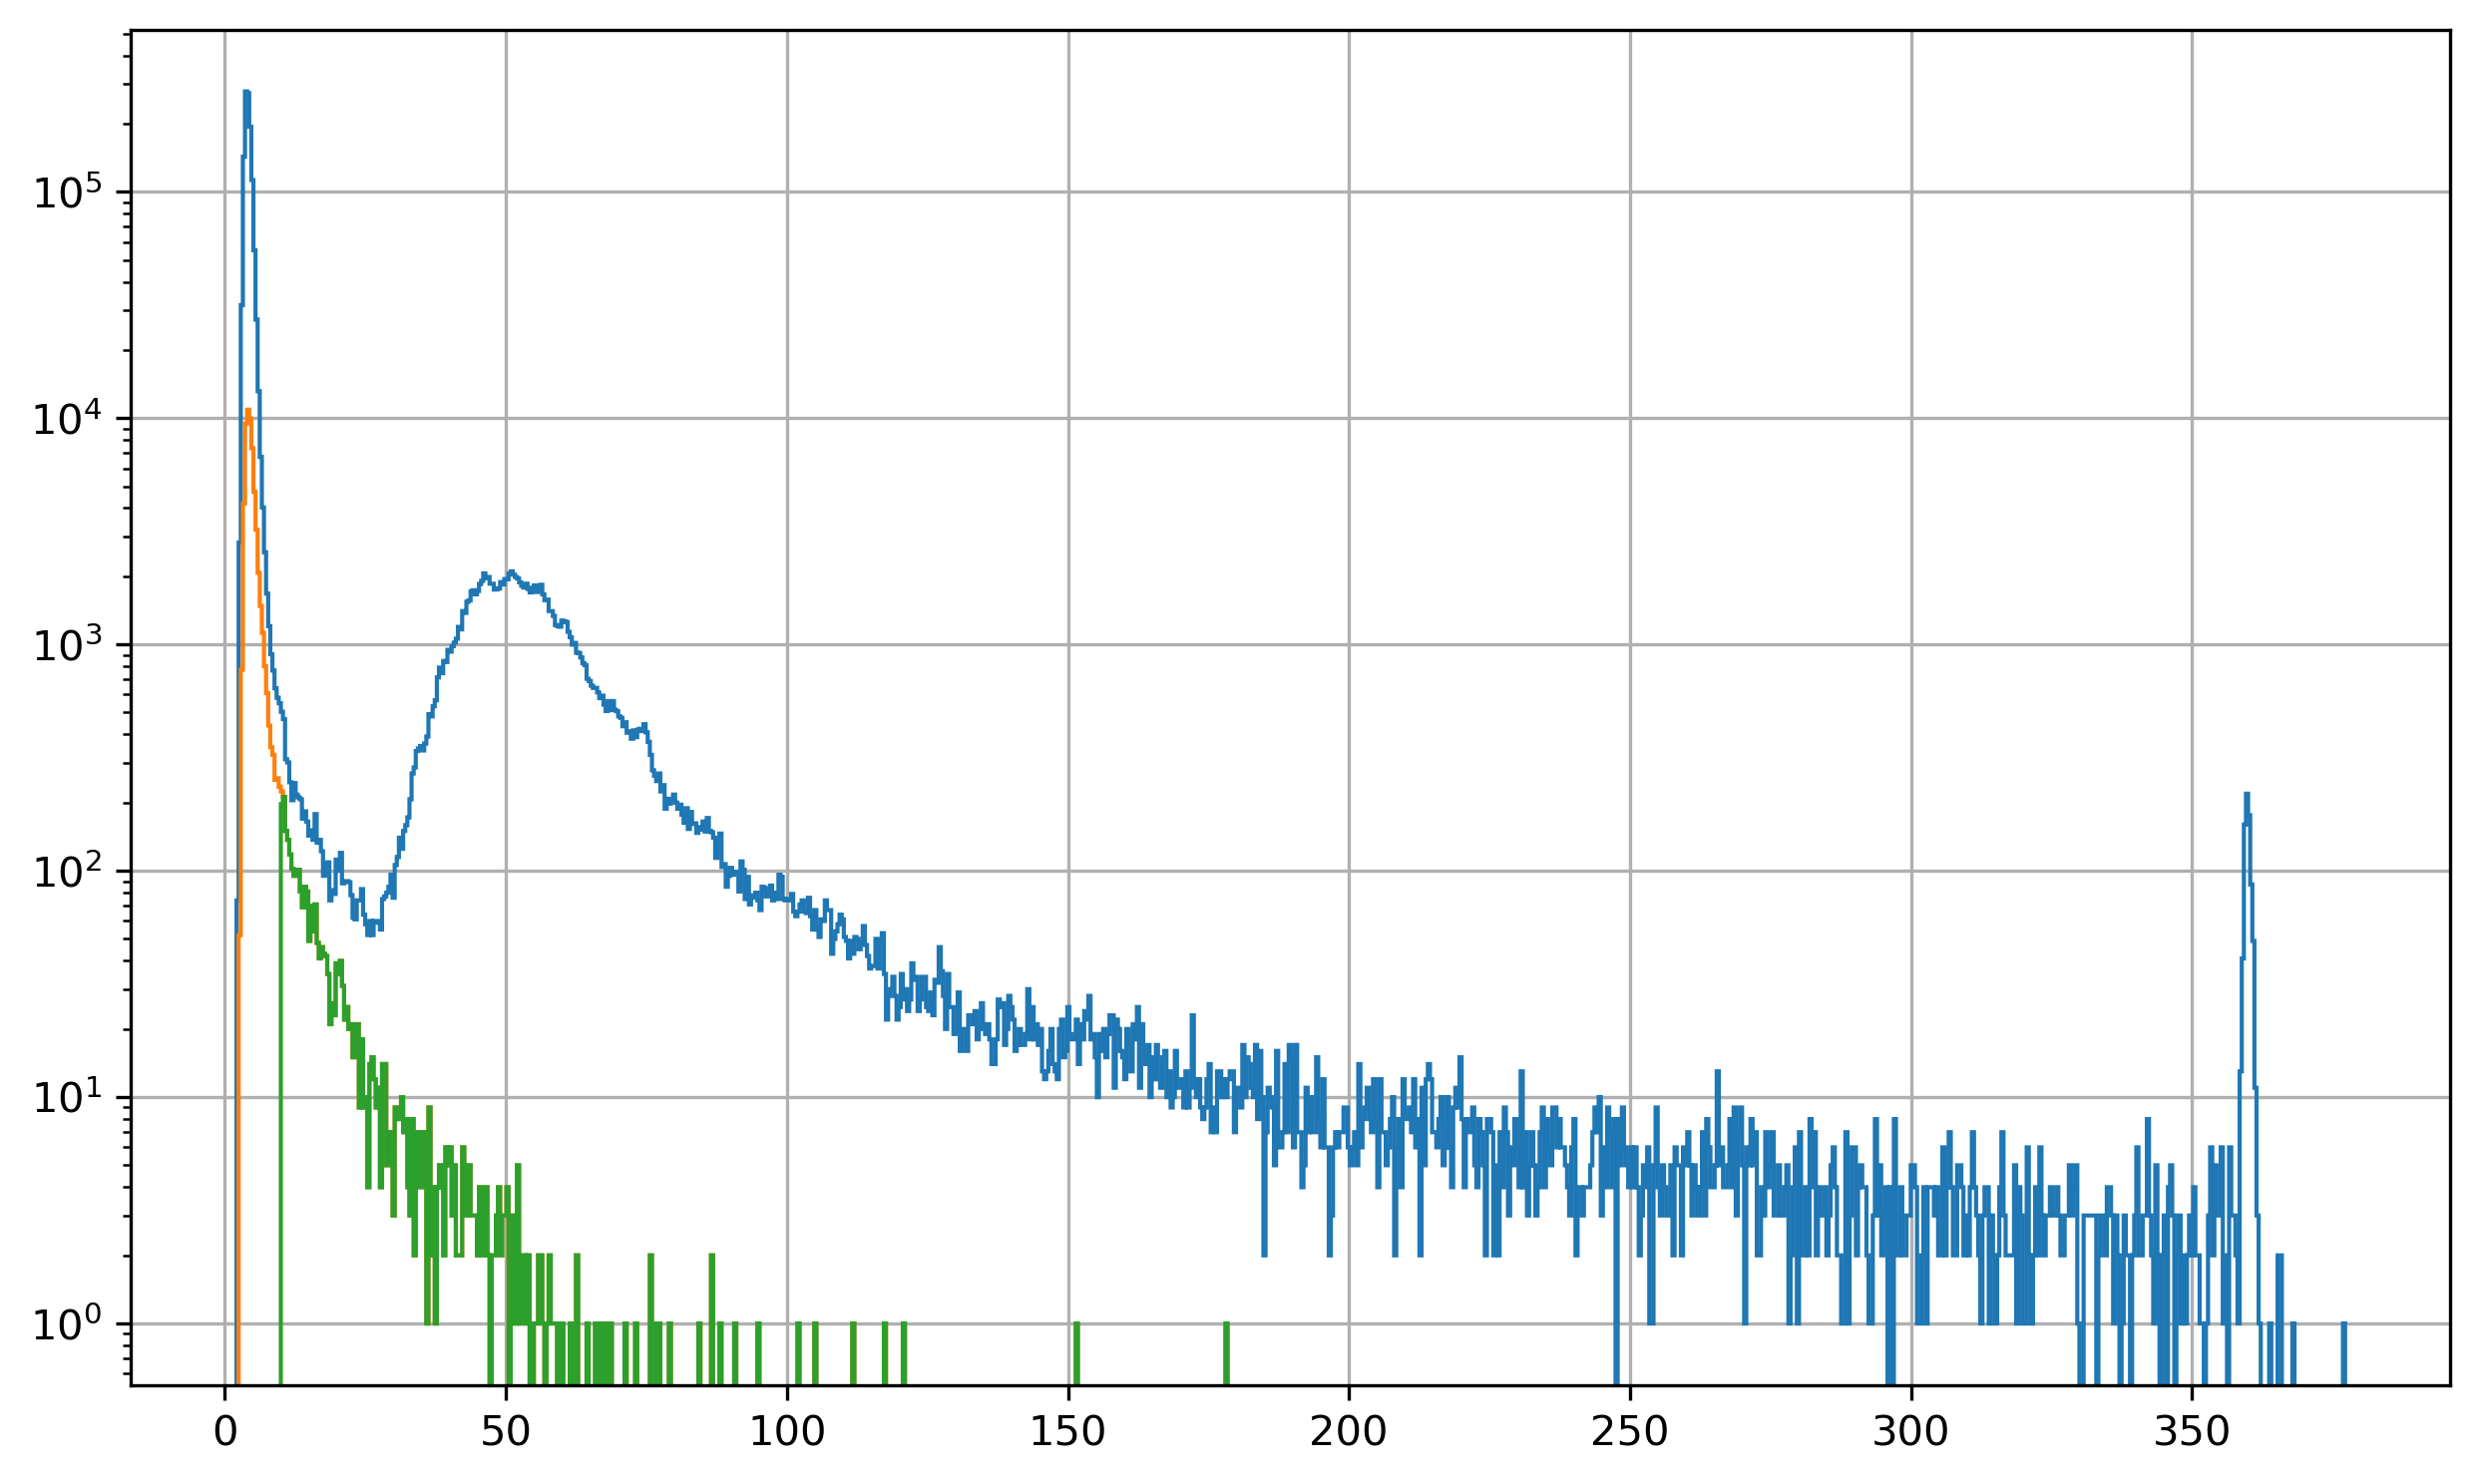

In [65]:
# fig, ax = plot(df,"Charge", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[one_dut], mask=second_peak,
#                     savefig=False, savefig_path=pres_path, savefig_details=f" position of second peak",fmt='png')

_,my_bins,_,fig,ax = plot_histogram(df[f"pulseHeight_{one_dut}"],bins=1000)
plot_histogram(df[f"pulseHeight_{one_dut}"].loc[second_peak[one_dut-1]],fig_ax=(fig,ax), bins=my_bins)
plot_histogram(df[f"pulseHeight_{one_dut}"].loc[np.logical_and(
    df[f"pulseHeight_{one_dut}"]>10,second_peak[one_dut-1])],fig_ax=(fig,ax), bins=my_bins);

ax.semilogy()

[]

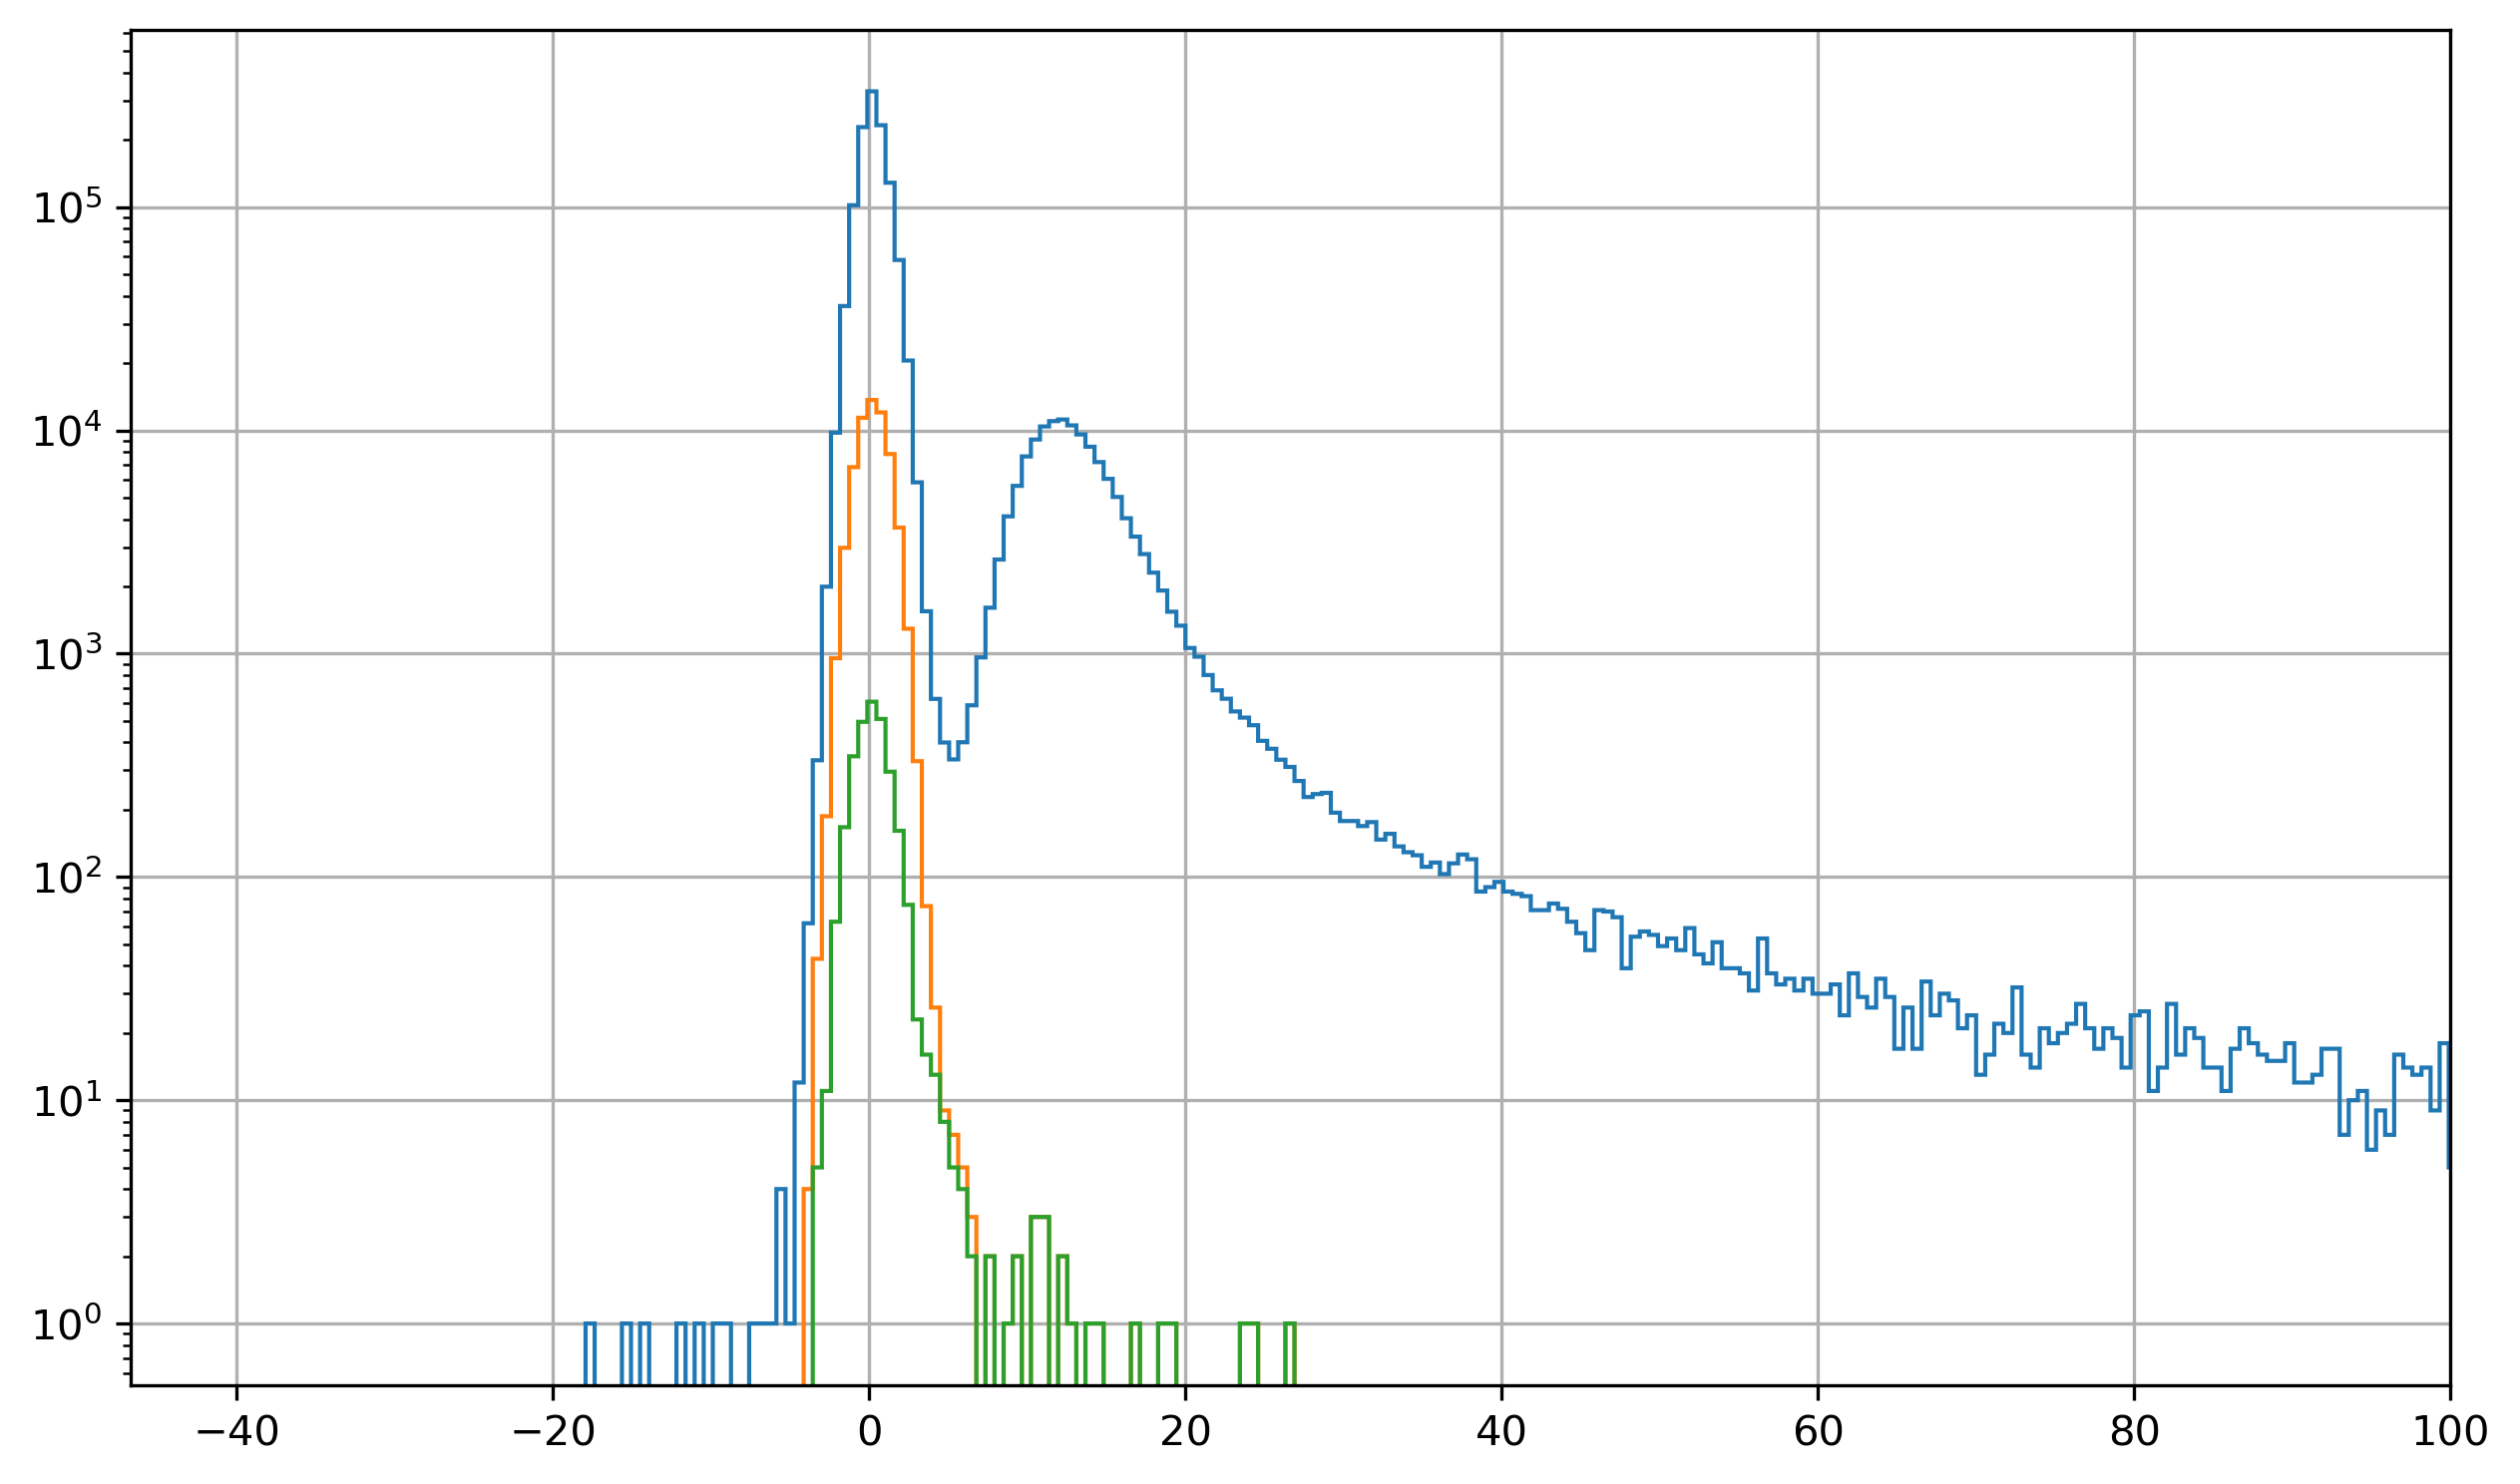

In [66]:
_,my_bins,_,fig,ax = plot_histogram(df[f"charge_{one_dut}"]/4700,bins=1000)
plot_histogram(df[f"charge_{one_dut}"].loc[second_peak[one_dut-1]]/4700,fig_ax=(fig,ax), bins=my_bins)
plot_histogram(df[f"charge_{one_dut}"].loc[np.logical_and(
    df[f"pulseHeight_{one_dut}"]>10,second_peak[one_dut-1])]/4700,fig_ax=(fig,ax), bins=my_bins);
ax.set_xlim(None,100)

ax.semilogy()

## Plots of the wide bottom of the gaussian  (!!)
I could also use this to find what is the collected charge of the particles that go thru the edge

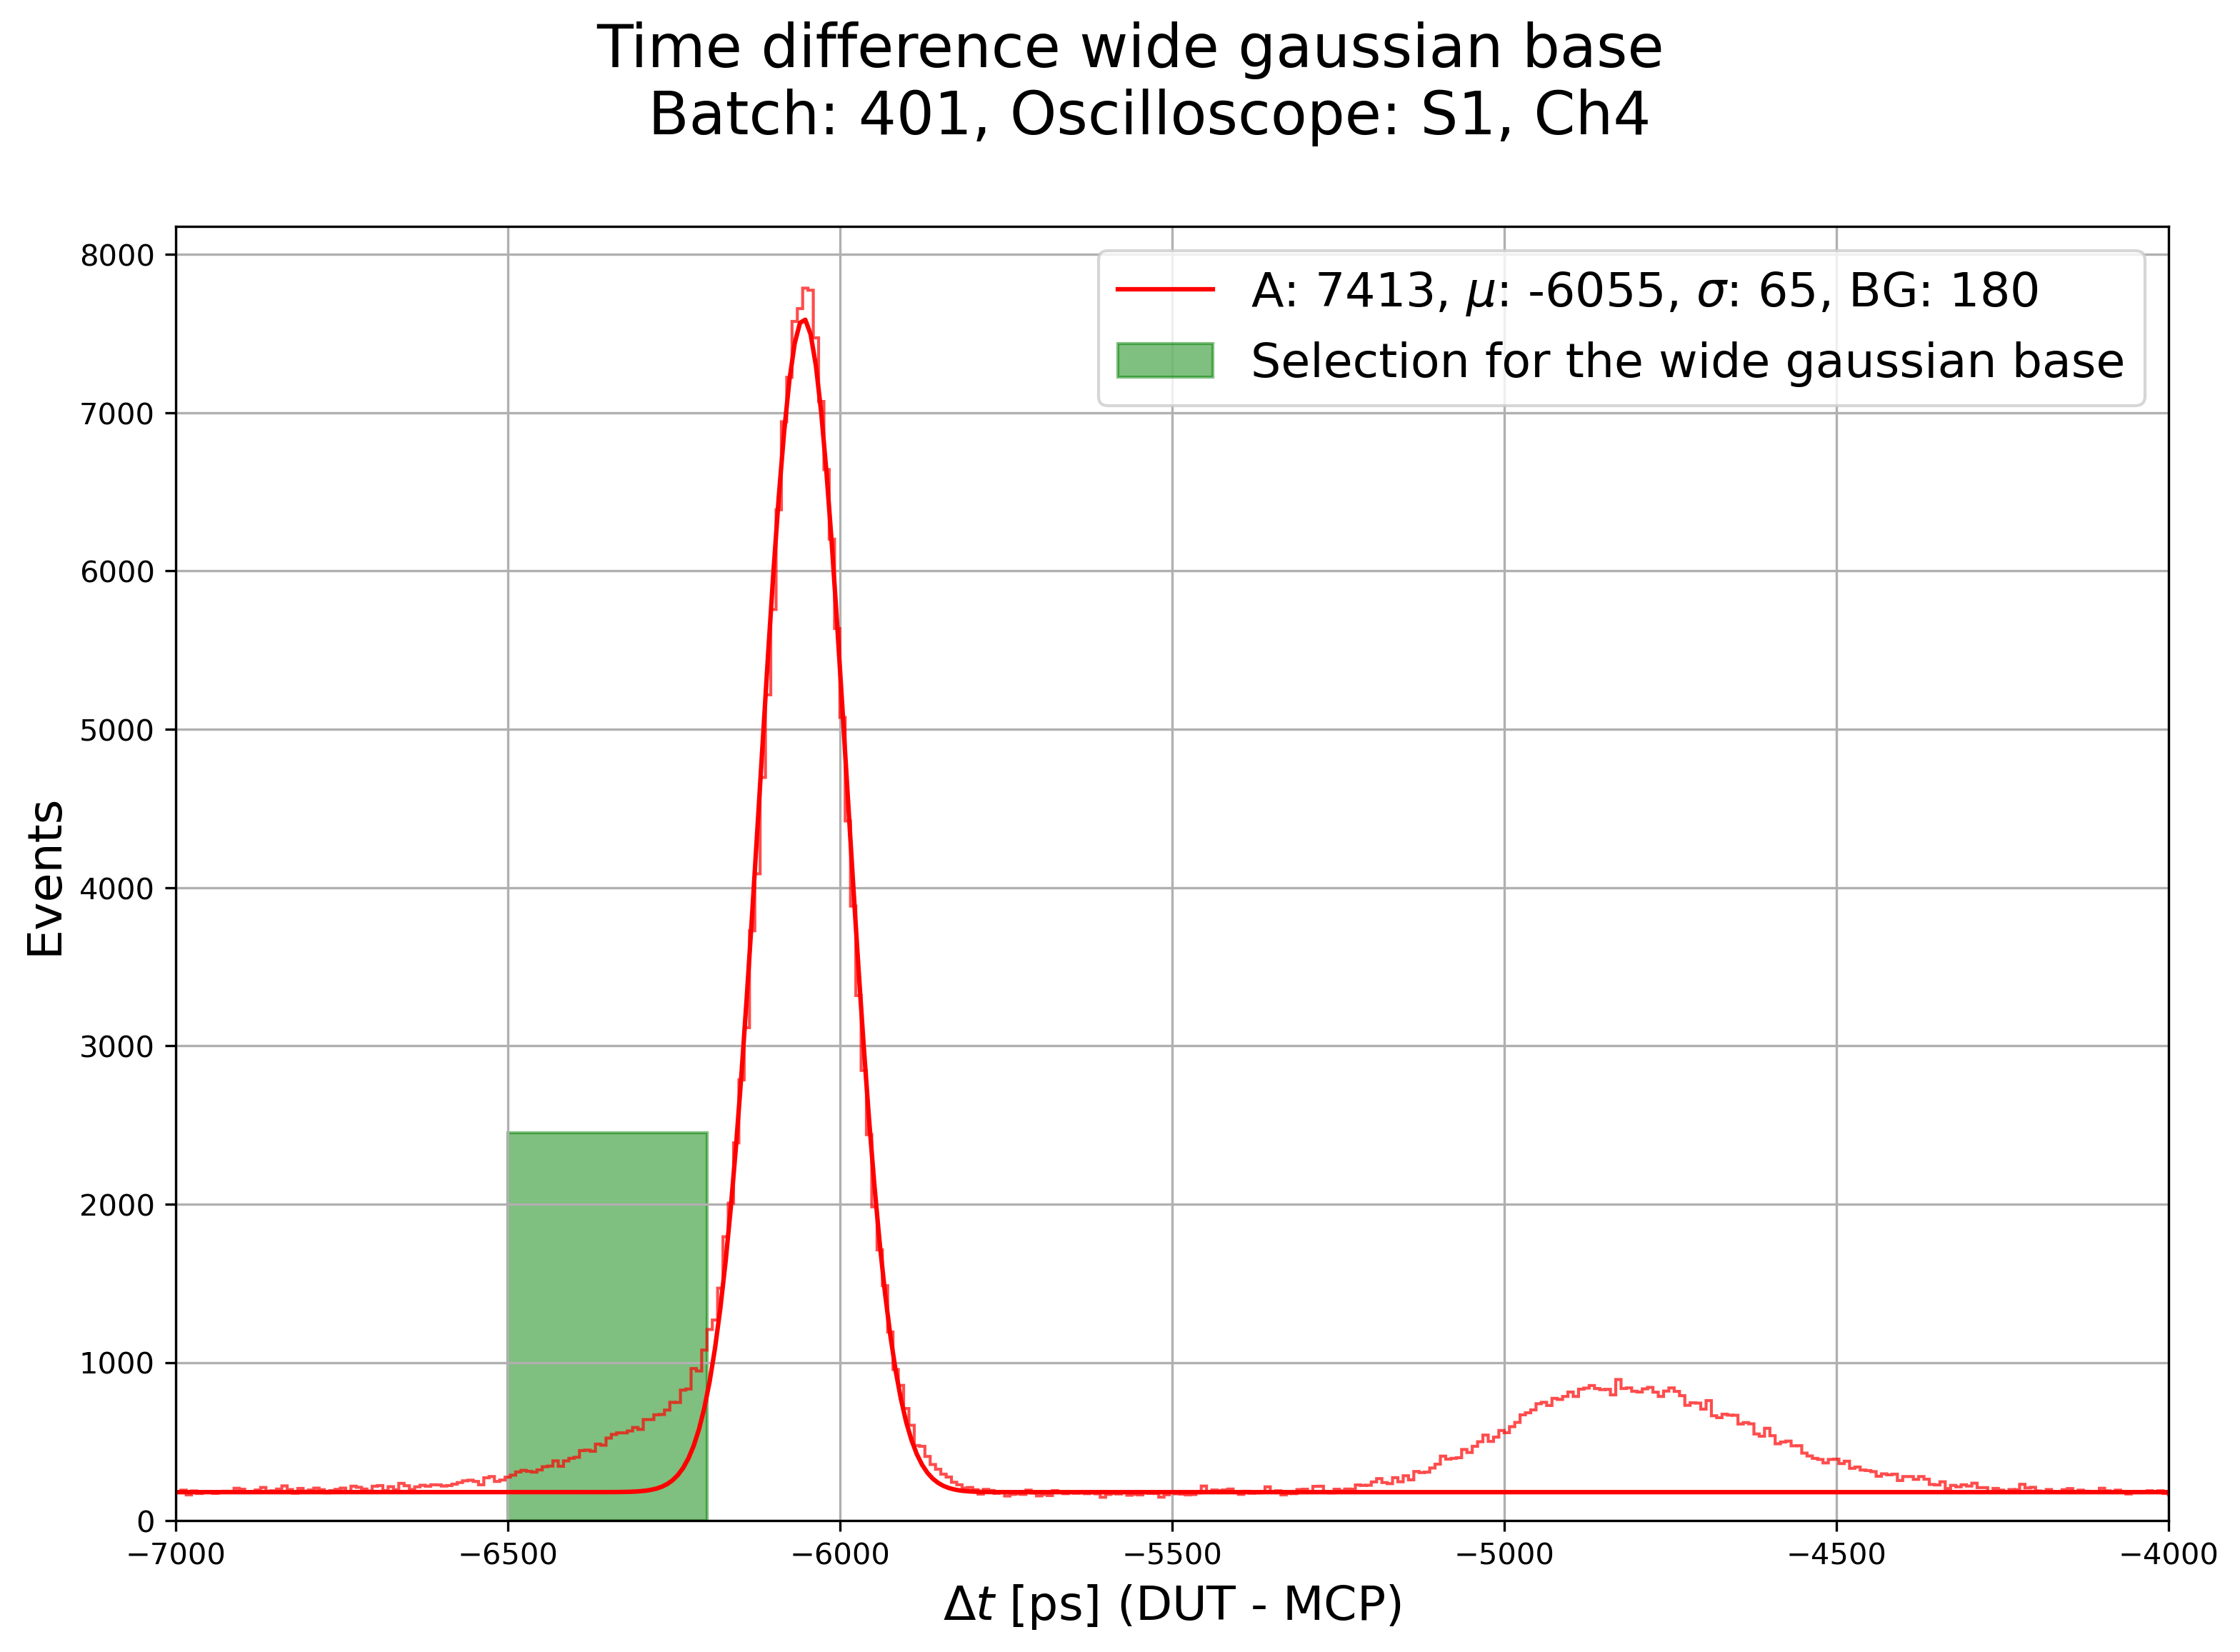

In [67]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)

for dut in [one_dut]:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[window_fit]-df["timeCFD50_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    
    number_of_sigmas = 3
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
#     axes.vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.', label=f'{number_of_sigmas} $\sigma$ interval')
#     axes.vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
#     ### add units to the parameters
    axes.plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals

    ### this lines are just to visually find an interval on which to study interesting features
# interesting_interval = (-6700, -6350)
interesting_interval = (-6500, -6200)

axes.axvspan(*interesting_interval, ymin=0, ymax=0.3, alpha=0.5, color='green', label='Selection for the wide gaussian base')

axes.set_xlabel(f"$\Delta t$ [ps] (DUT - MCP)", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-4e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time difference wide gaussian base \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_difference_{this_batch}_{S}_one_dut_with_wide gaussian_left.png"), bbox_inches="tight")

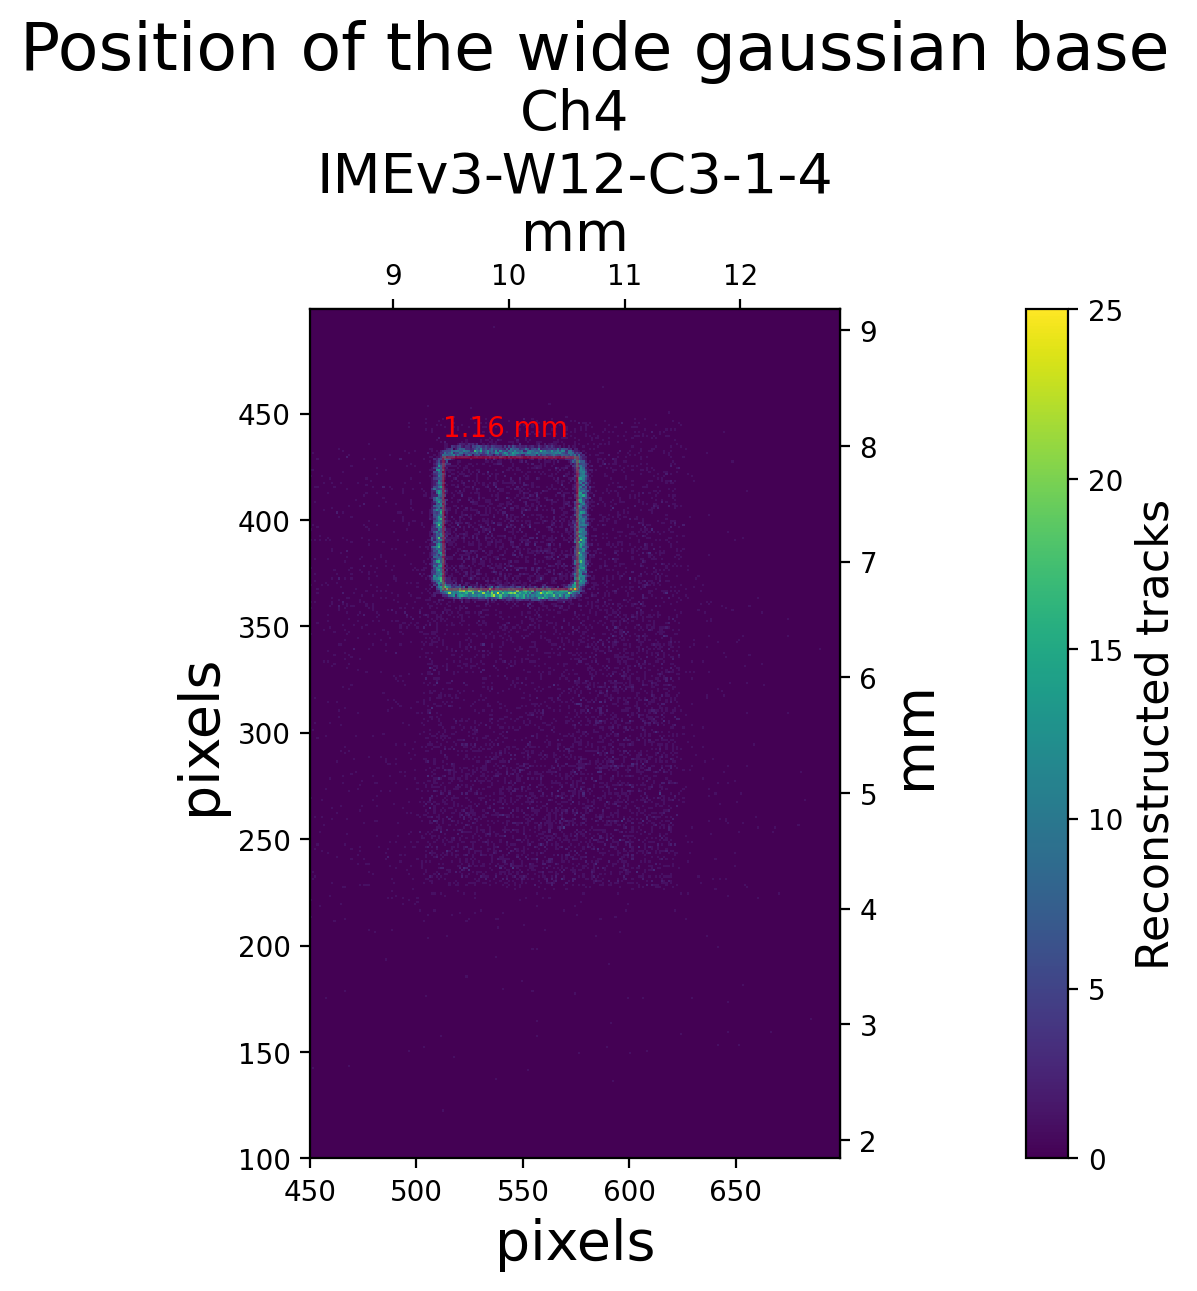

In [68]:
wide_bottom = [np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> interesting_interval[0],
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< interesting_interval[1]) for dut in [1,2,3]]

dut = 3
fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[dut], mask=wide_bottom,
                    savefig=False, savefig_path=pres_path, savefig_details=f" positions of wide gaussian base_left", fmt='png')

fig.suptitle("Position of the wide gaussian base", fontsize=24, y=1.05)
ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1], alpha=.3))

sensor_size = (geo_infos[dut-1]['right_edge']-geo_infos[dut-1]['left_edge'])*PIXEL_SIZE
ax[0].text(x=geo_infos[dut-1]['left_edge'], y=geo_infos[dut-1]['top_edge']+10, s='%.2f mm'%sensor_size, color='r')
    
if SAVE:
    fig.savefig(os.path.join(pres_path, f"2D Tracks {this_batch}_{S}_one_dut_with_wide_gaussian_base_left.png"), bbox_inches="tight")


In [44]:
### now same thing but right side, this one is not necessary because the
### RIGHT SIDE OF THE ASYMMETRY IS DUE TO THE CFD VALUES

/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/LoadBatch.py:484: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  


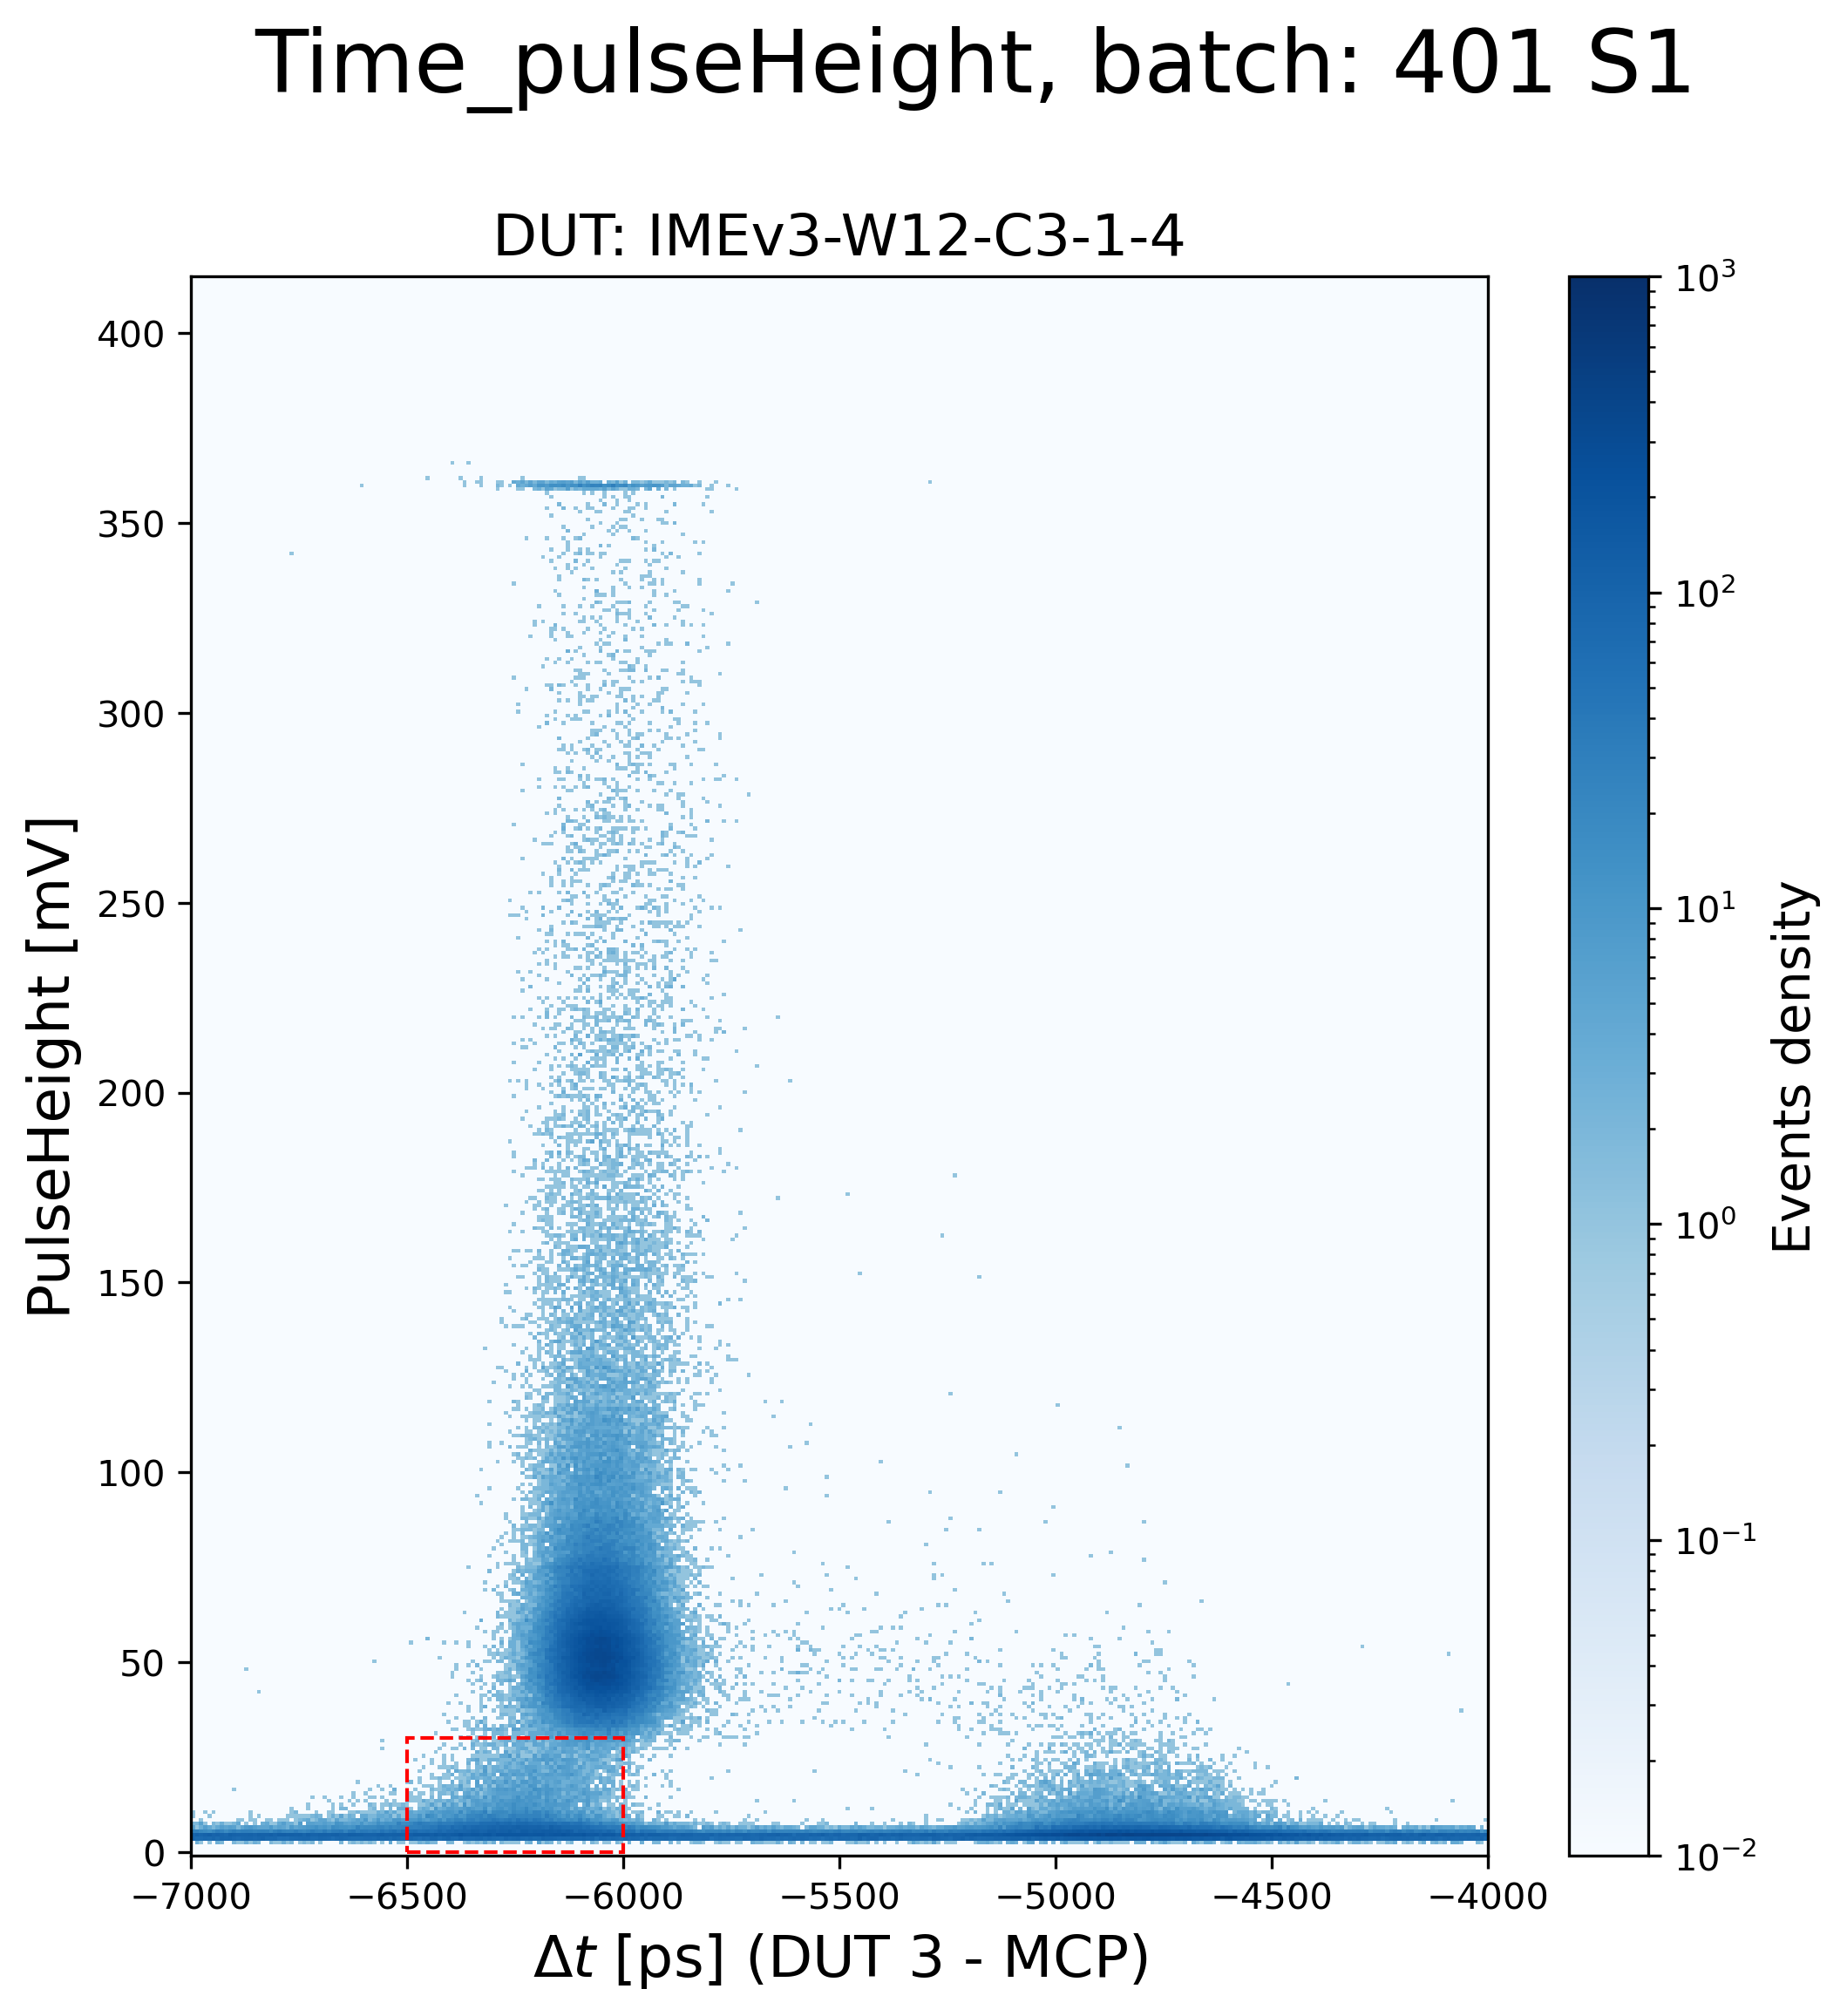

In [69]:
### NOW I SELECT AN AREA IN THE 2D SPACE OF TIME, PULSEHEIGHT TO BETTER FIND THE EDGES
fig, axes = plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False, title_position=1.0,
     n_DUT=[one_dut], savefig=SAVE, savefig_details=f'{S}', savefig_path=pres_path, fmt='png')
        ### X_left, X_right, Y_bottom, Y_top
select_area = (-6.5e3, -6e3, 0, 30)
axes[0].add_patch(rectangle_from_geometry_cut(*select_area, fill=False, color='r', linestyle='--'))
axes[0].set_xlim(-7e3,-4e3)
axes[0].set_ylim(-1,None)
axes[0].grid(False)

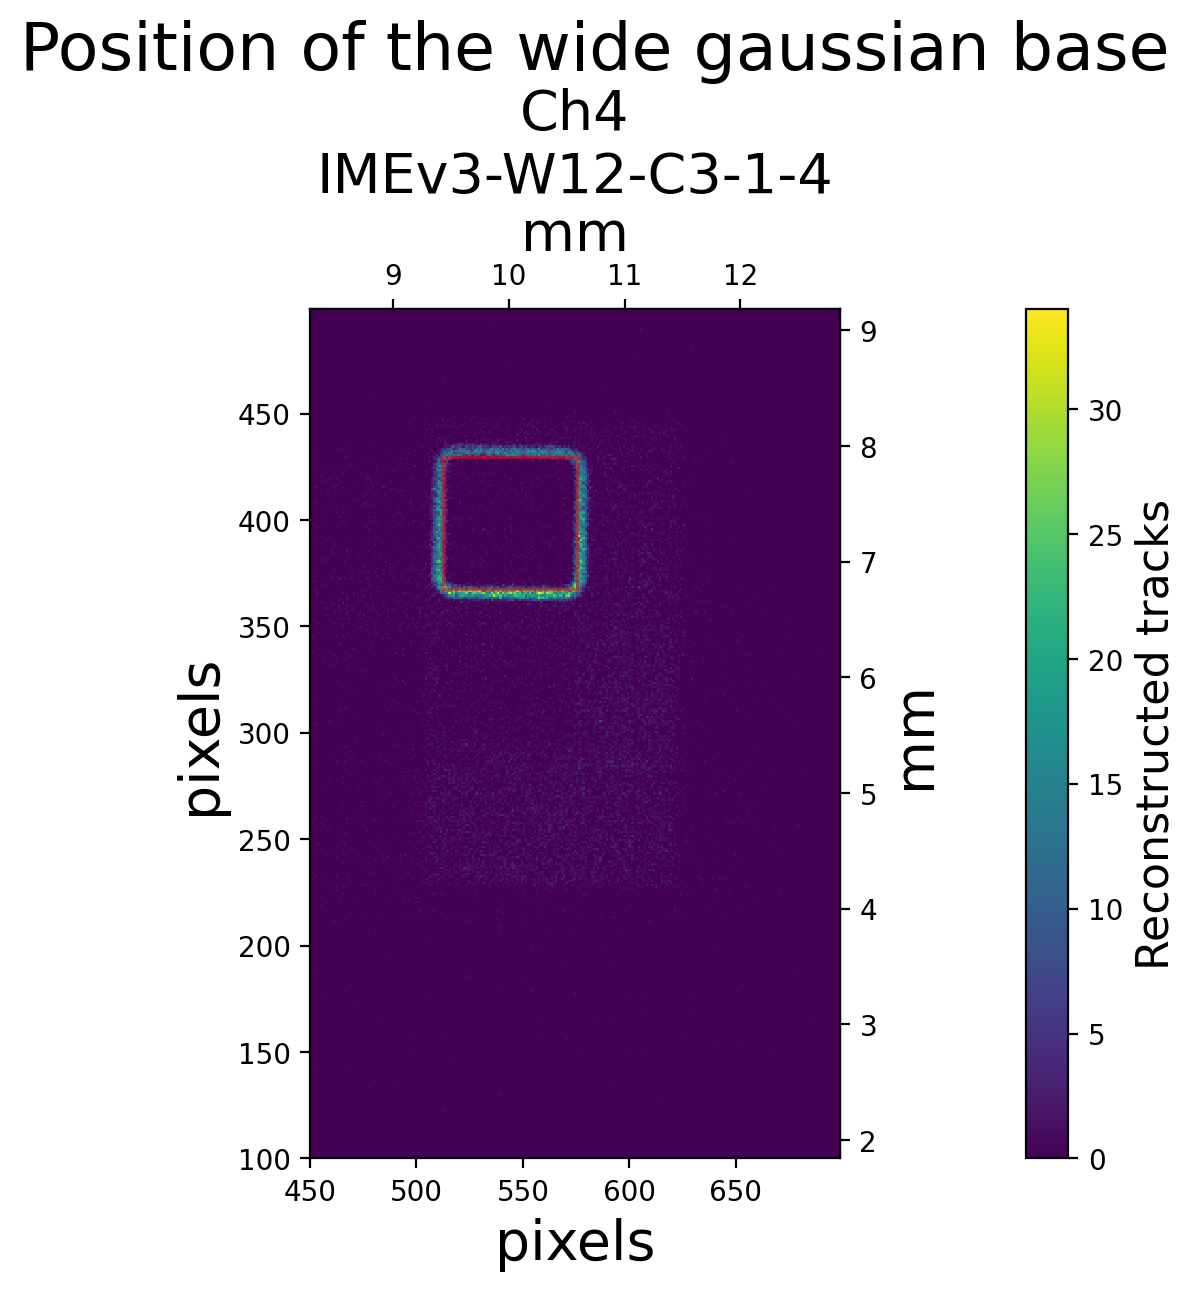

In [70]:
### on the RIGHT side
### OLD ONE WITH DUT:CDF50 AND MCP:CFD20

select_area_time_cut = [np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> select_area[0],
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< select_area[1]) for dut in [1,2,3]]

select_area_pulse_cut = [np.logical_and(df[f"pulseHeight_{dut}"]> select_area[2],
                               df[f"pulseHeight_{dut}"]< select_area[3]) for dut in [1,2,3]]

select_area_cut = [np.logical_and(select_area_time_cut[dut-1], select_area_pulse_cut[dut-1]) for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[3], mask=select_area_cut,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" positions of wide gaussian base_right", fmt='png')

fig.suptitle("Position of the wide gaussian base", fontsize=24, y=1.05)
ax[0].add_patch(rectangle_from_geometry_cut(**geo_infos[2], alpha=.5))

#### Now plot the charge of these events

## $\Delta t$ vs pulseHeight plot

(<Figure size 2400x2400 with 2 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: IMEv3-W12-C3-1-4'}, xlabel='$\\Delta t$ [ps] (DUT 3 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

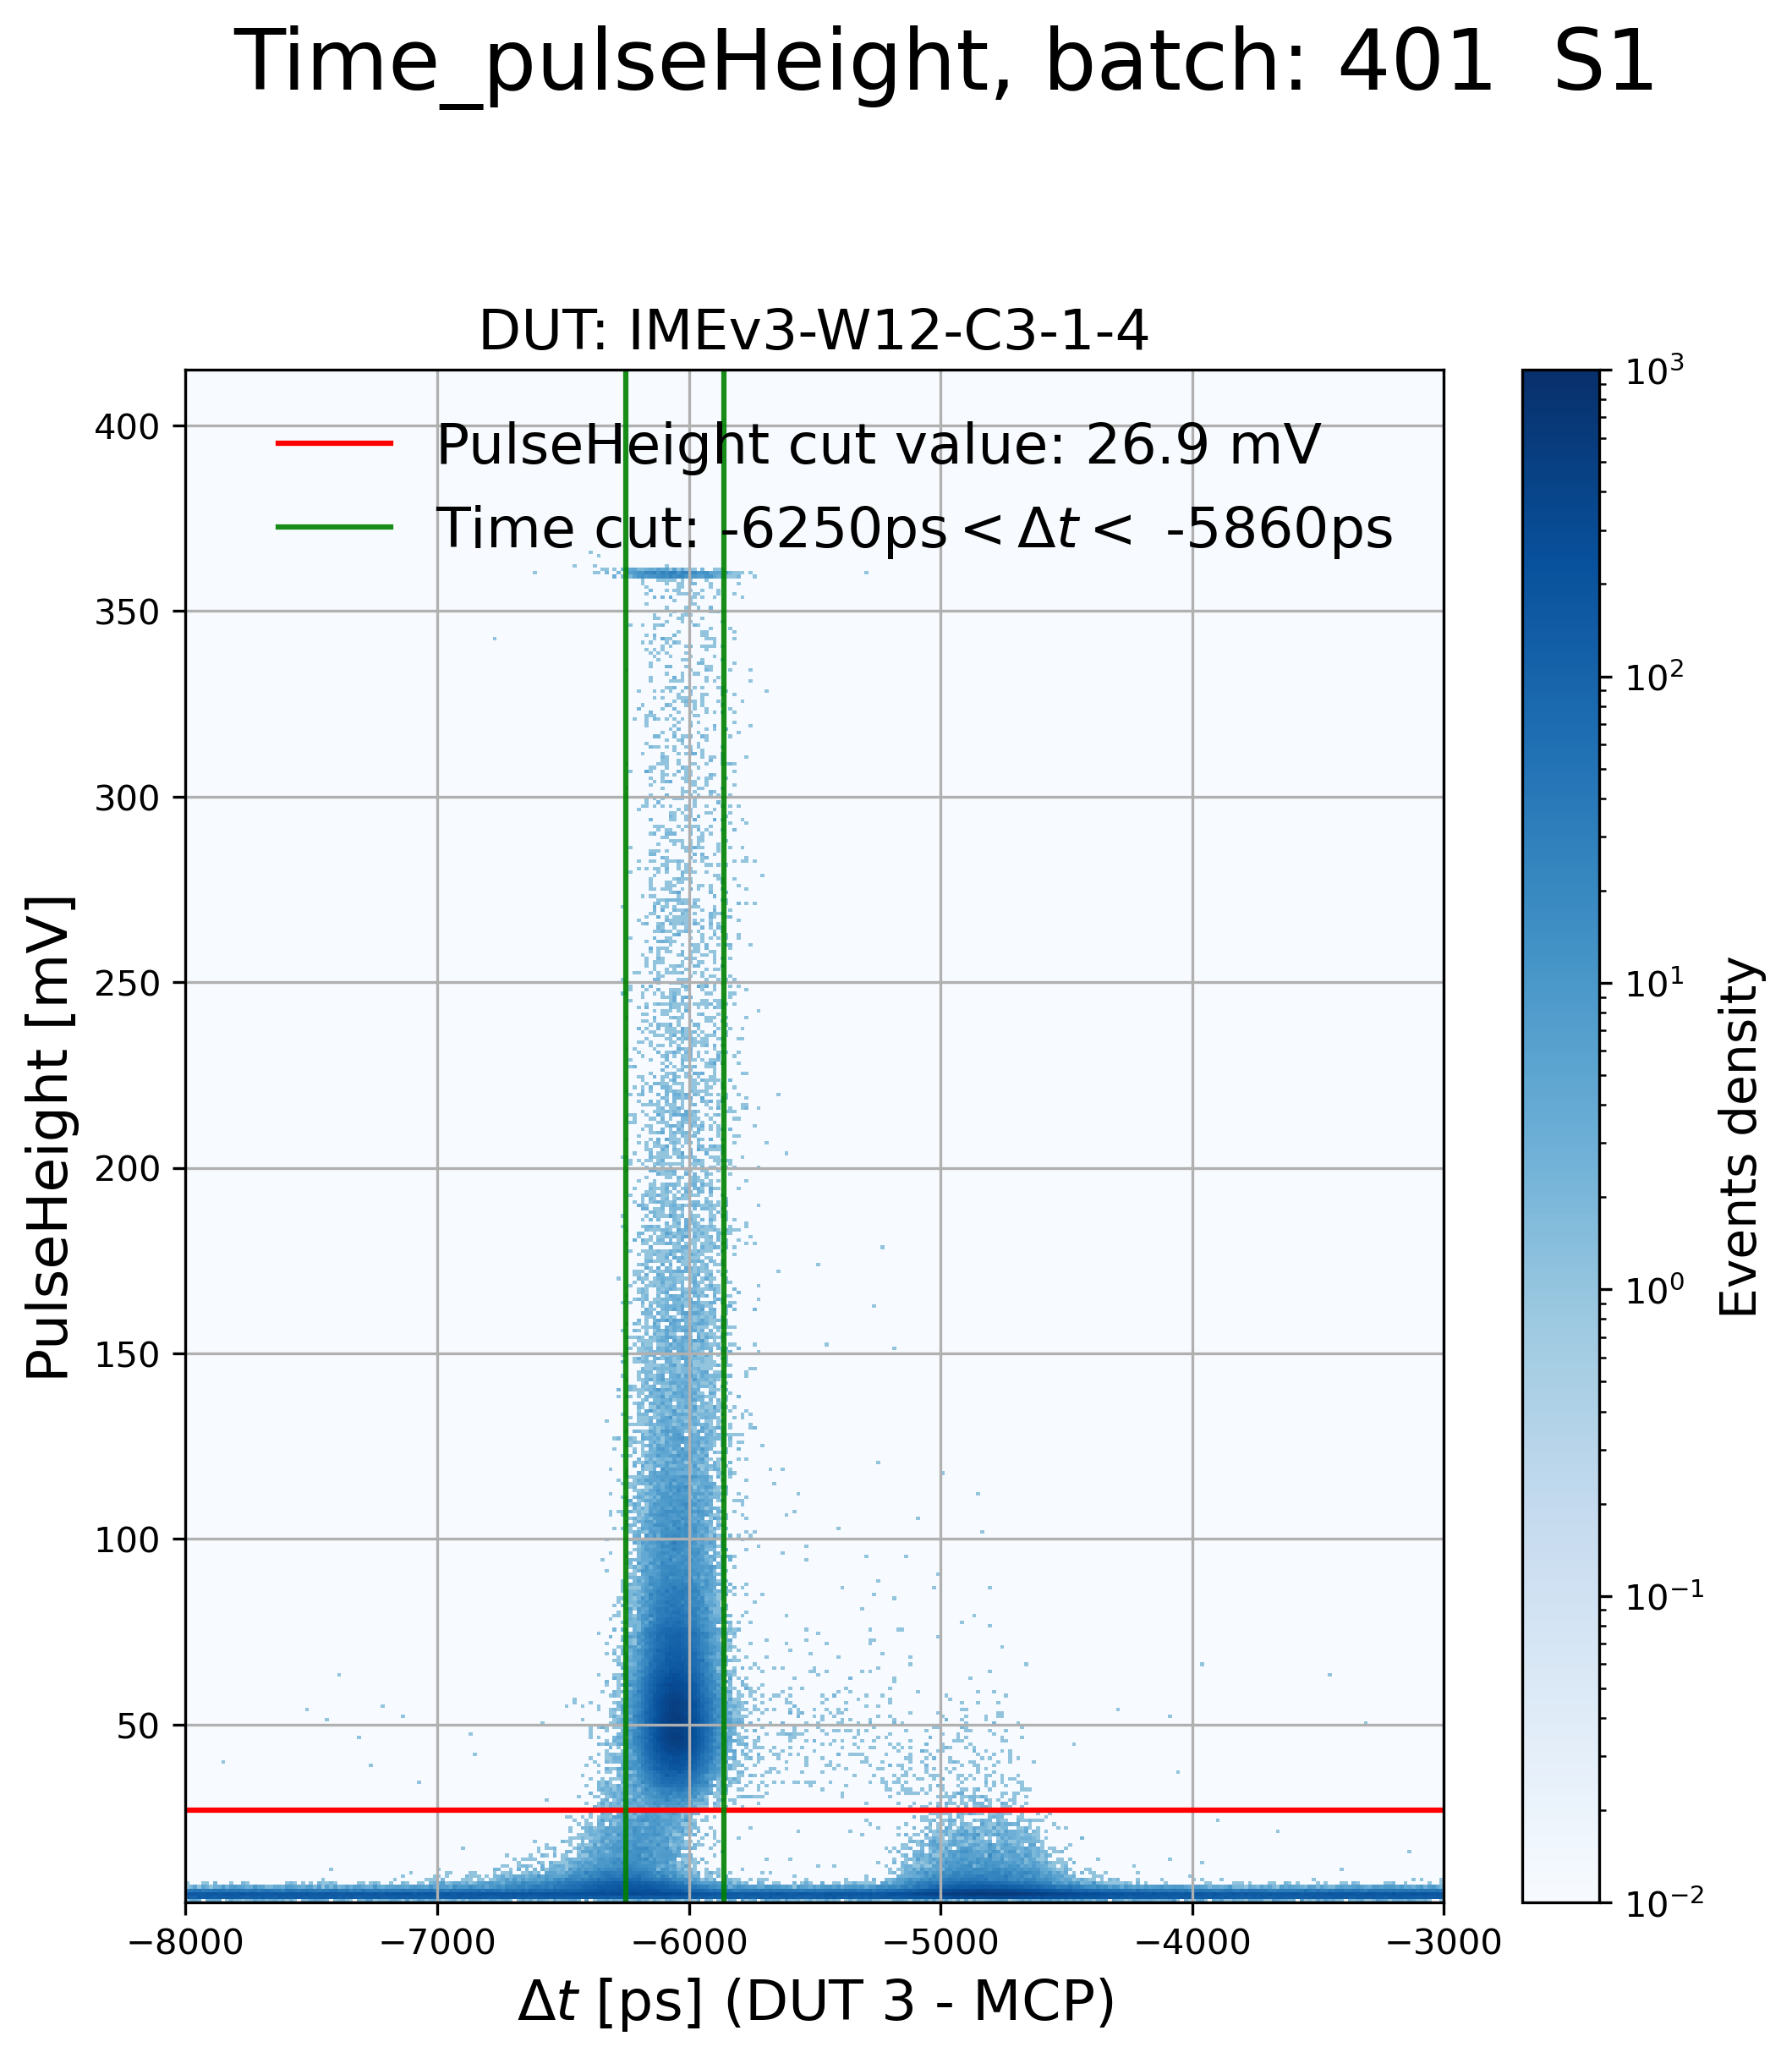

In [71]:
### delta time vs pulseHeight with info
# SAVE = False
plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000, extra_info=False,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S}', savefig_path=pres_path, fmt='png')

(<Figure size 2400x2400 with 2 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: IMEv3-W12-C3-1-4'}, xlabel='$\\Delta t$ [ps] (DUT 3 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

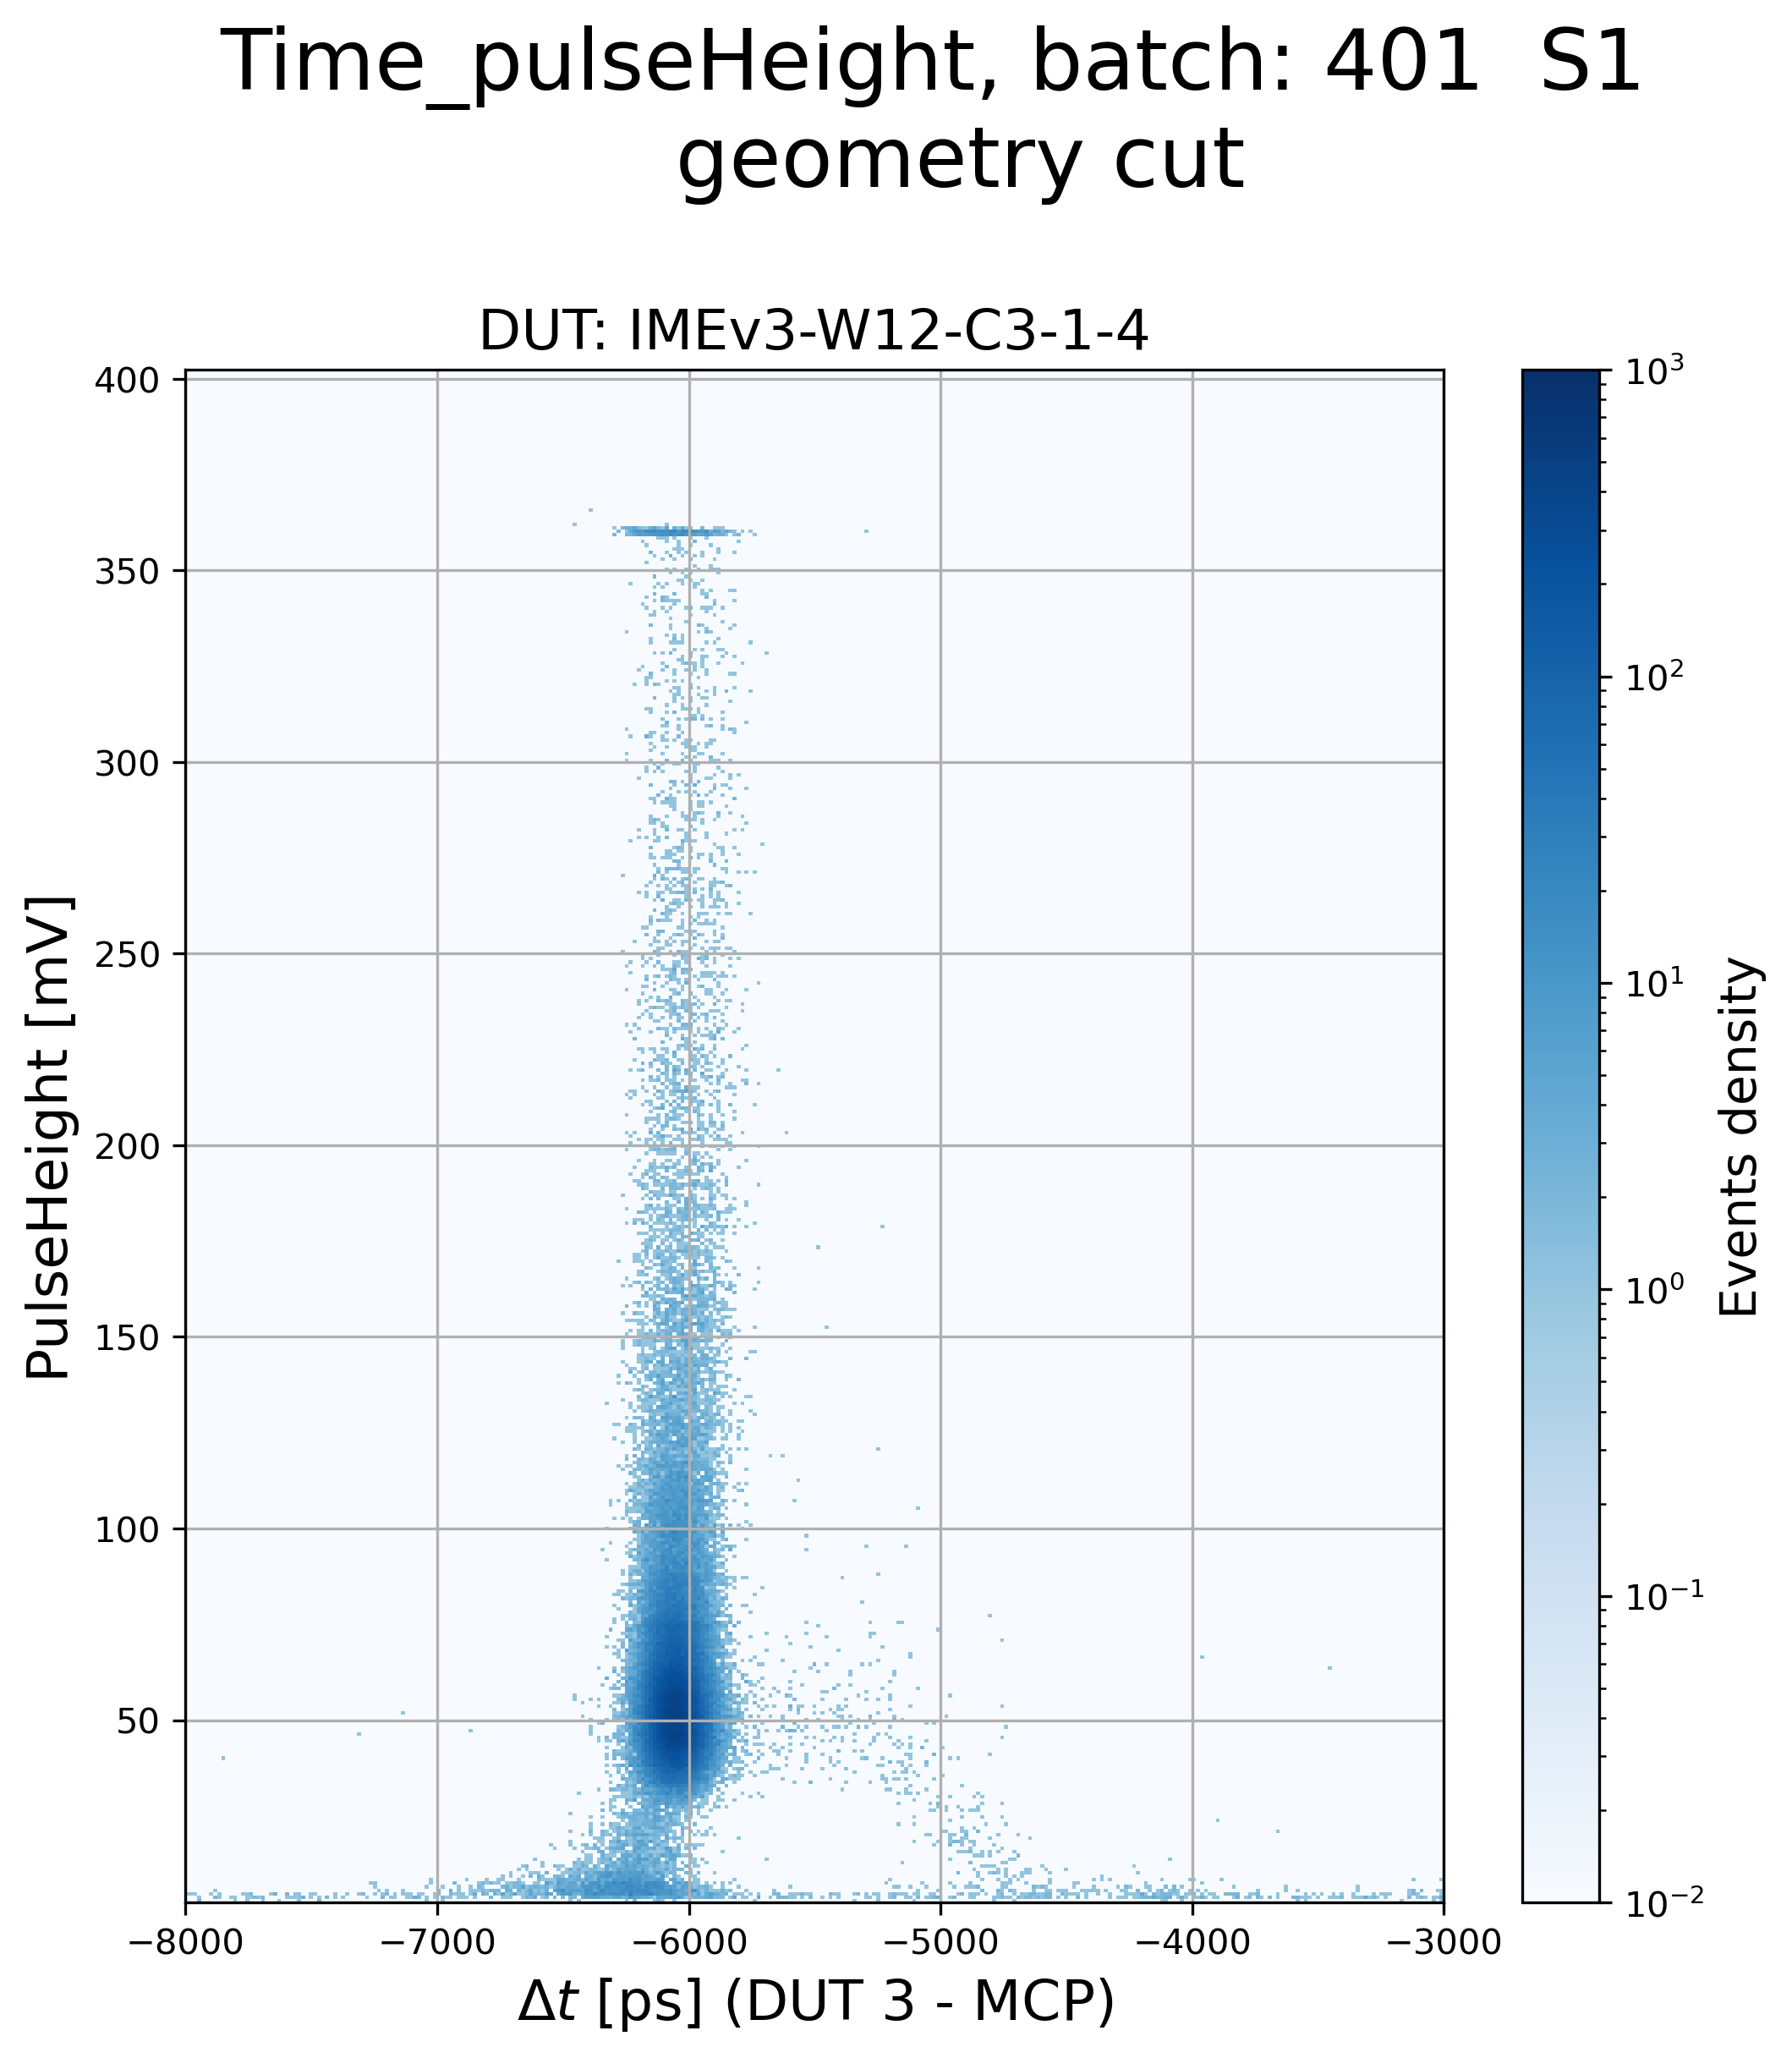

In [72]:
### delta time vs pulseHeight CENTRAL AREA OF SENSOR without info

plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000, info=False, extra_info=False, mask=geo_cuts,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} \n geometry cut', savefig_path=pres_path, fmt='png')


# Noise

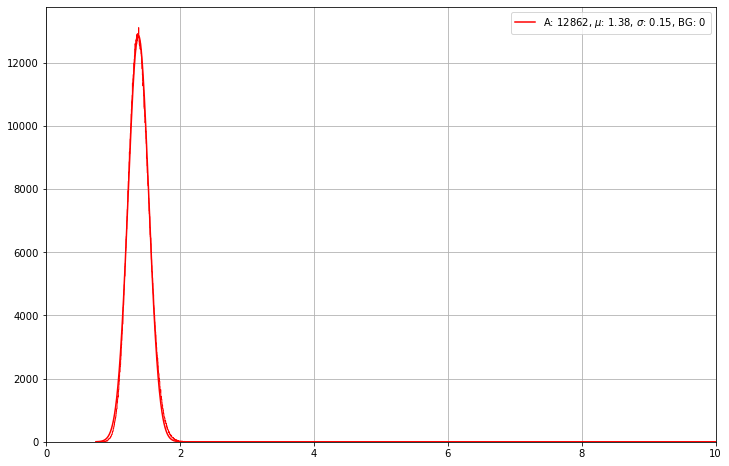

In [74]:
noise_cuts = []  ### define a 'noise cut' as events with pulseheight 3x the noise
### does not seem to be super useful, initially at least
fig, ax = plt.subplots(figsize=(12,8))
for dut in [1,2,3]:
    if dut not in DUTs:
        noise_cuts.append(None)
        continue
    hist,my_bins,_,_,_ = plot_histogram(df[f'noise_{dut}'], fig_ax=(fig,ax), color=colormap[dut])
    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],2,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
    ax.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])
    ax.plot([],[], color=colormap[dut], label="A: %.0f, $\mu$: %.2f, $\sigma$: %.2f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals
    noise_cuts.append(df[f'pulseHeight_{dut}']<param[1]+5*param[2])
    
ax.set_xlim(0,10)
ax.legend()
# ax.semilogy()

(<Figure size 1200x1200 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Ch4\nIMEv3-W12-C3-1-4'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

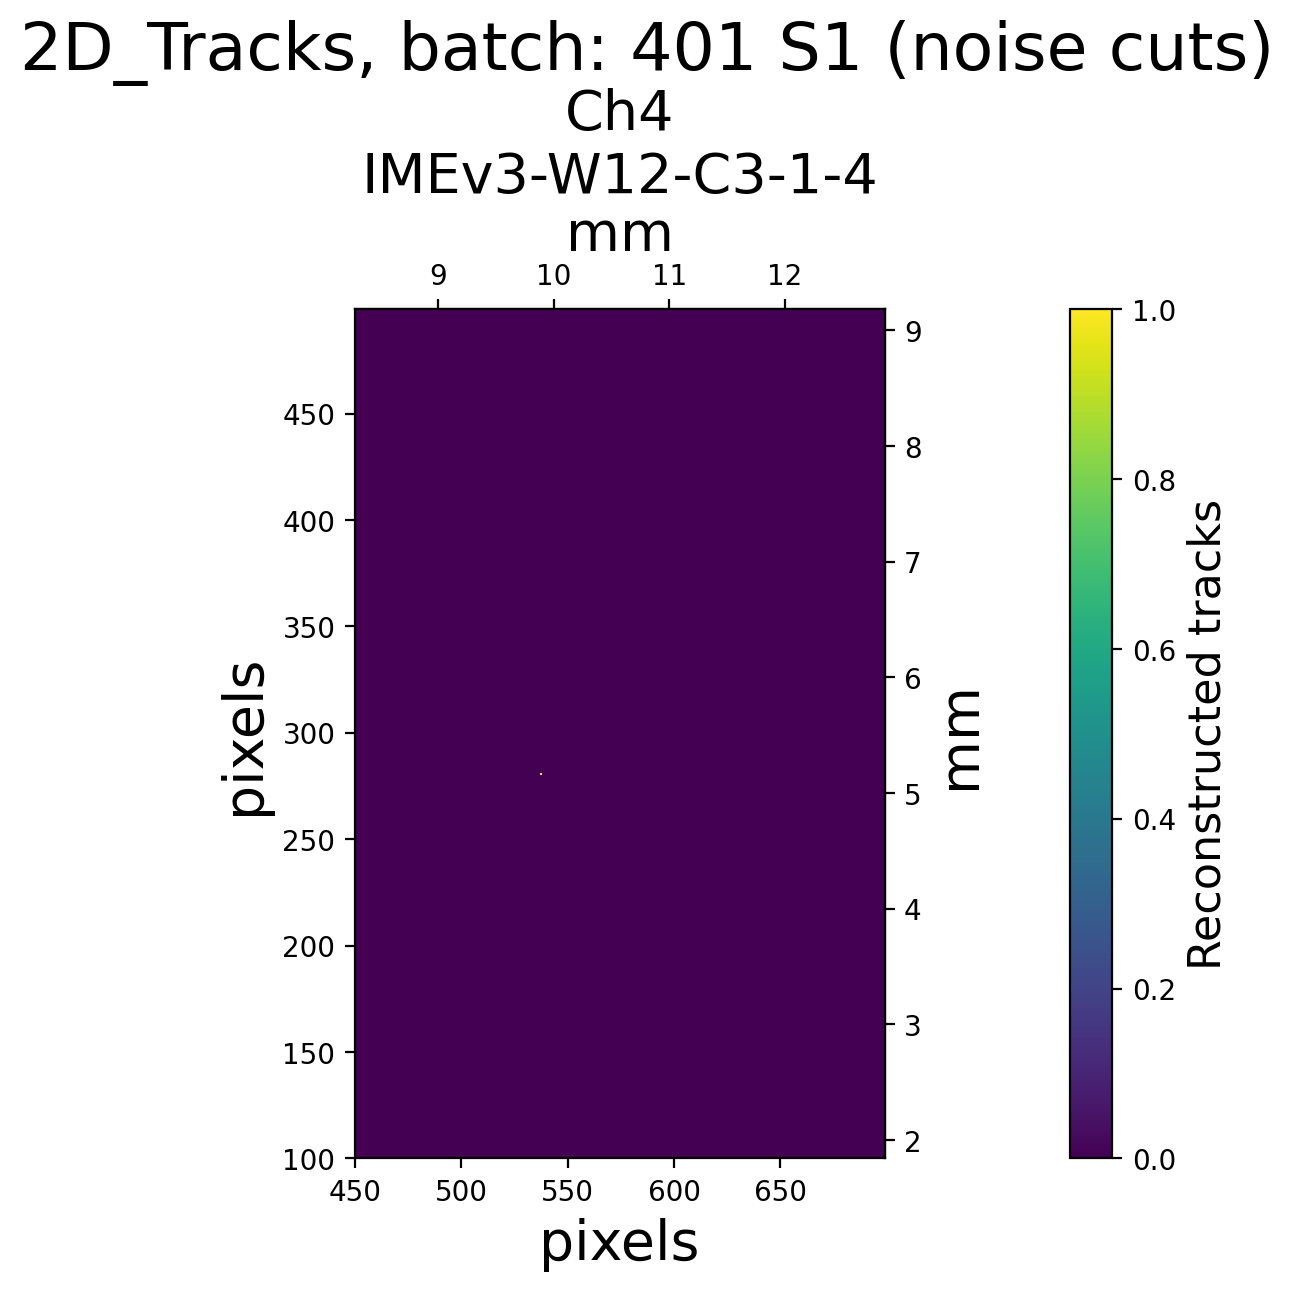

In [75]:
plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, mask=noise_cuts,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S} (noise cuts)', savefig_path=pres_path, fmt='png')

### Studying what events cause the peak of noise below zero, CHARGE

In [51]:
df[f'charge_{dut}'].loc[all_cuts[dut-1]]

NameError: name 'all_cts' is not defined

In [ ]:
### Noisy charge without cuts

noise_charge = [np.logical_and(df[f'charge_{dut}']/
                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance > interesting_interval[0],
                               df[f'charge_{dut}']/
                dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance < interesting_interval[1])
                for dut in [1,2,3]]

fig, ax = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[1,2,3], mask=noise_charge,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" tracks of charge noise peak", fmt='png')

fig.suptitle("Tracks of the charge noise peak", fontsize=24, y=1.05)


## Efficiency

In [ ]:
SAVE = True

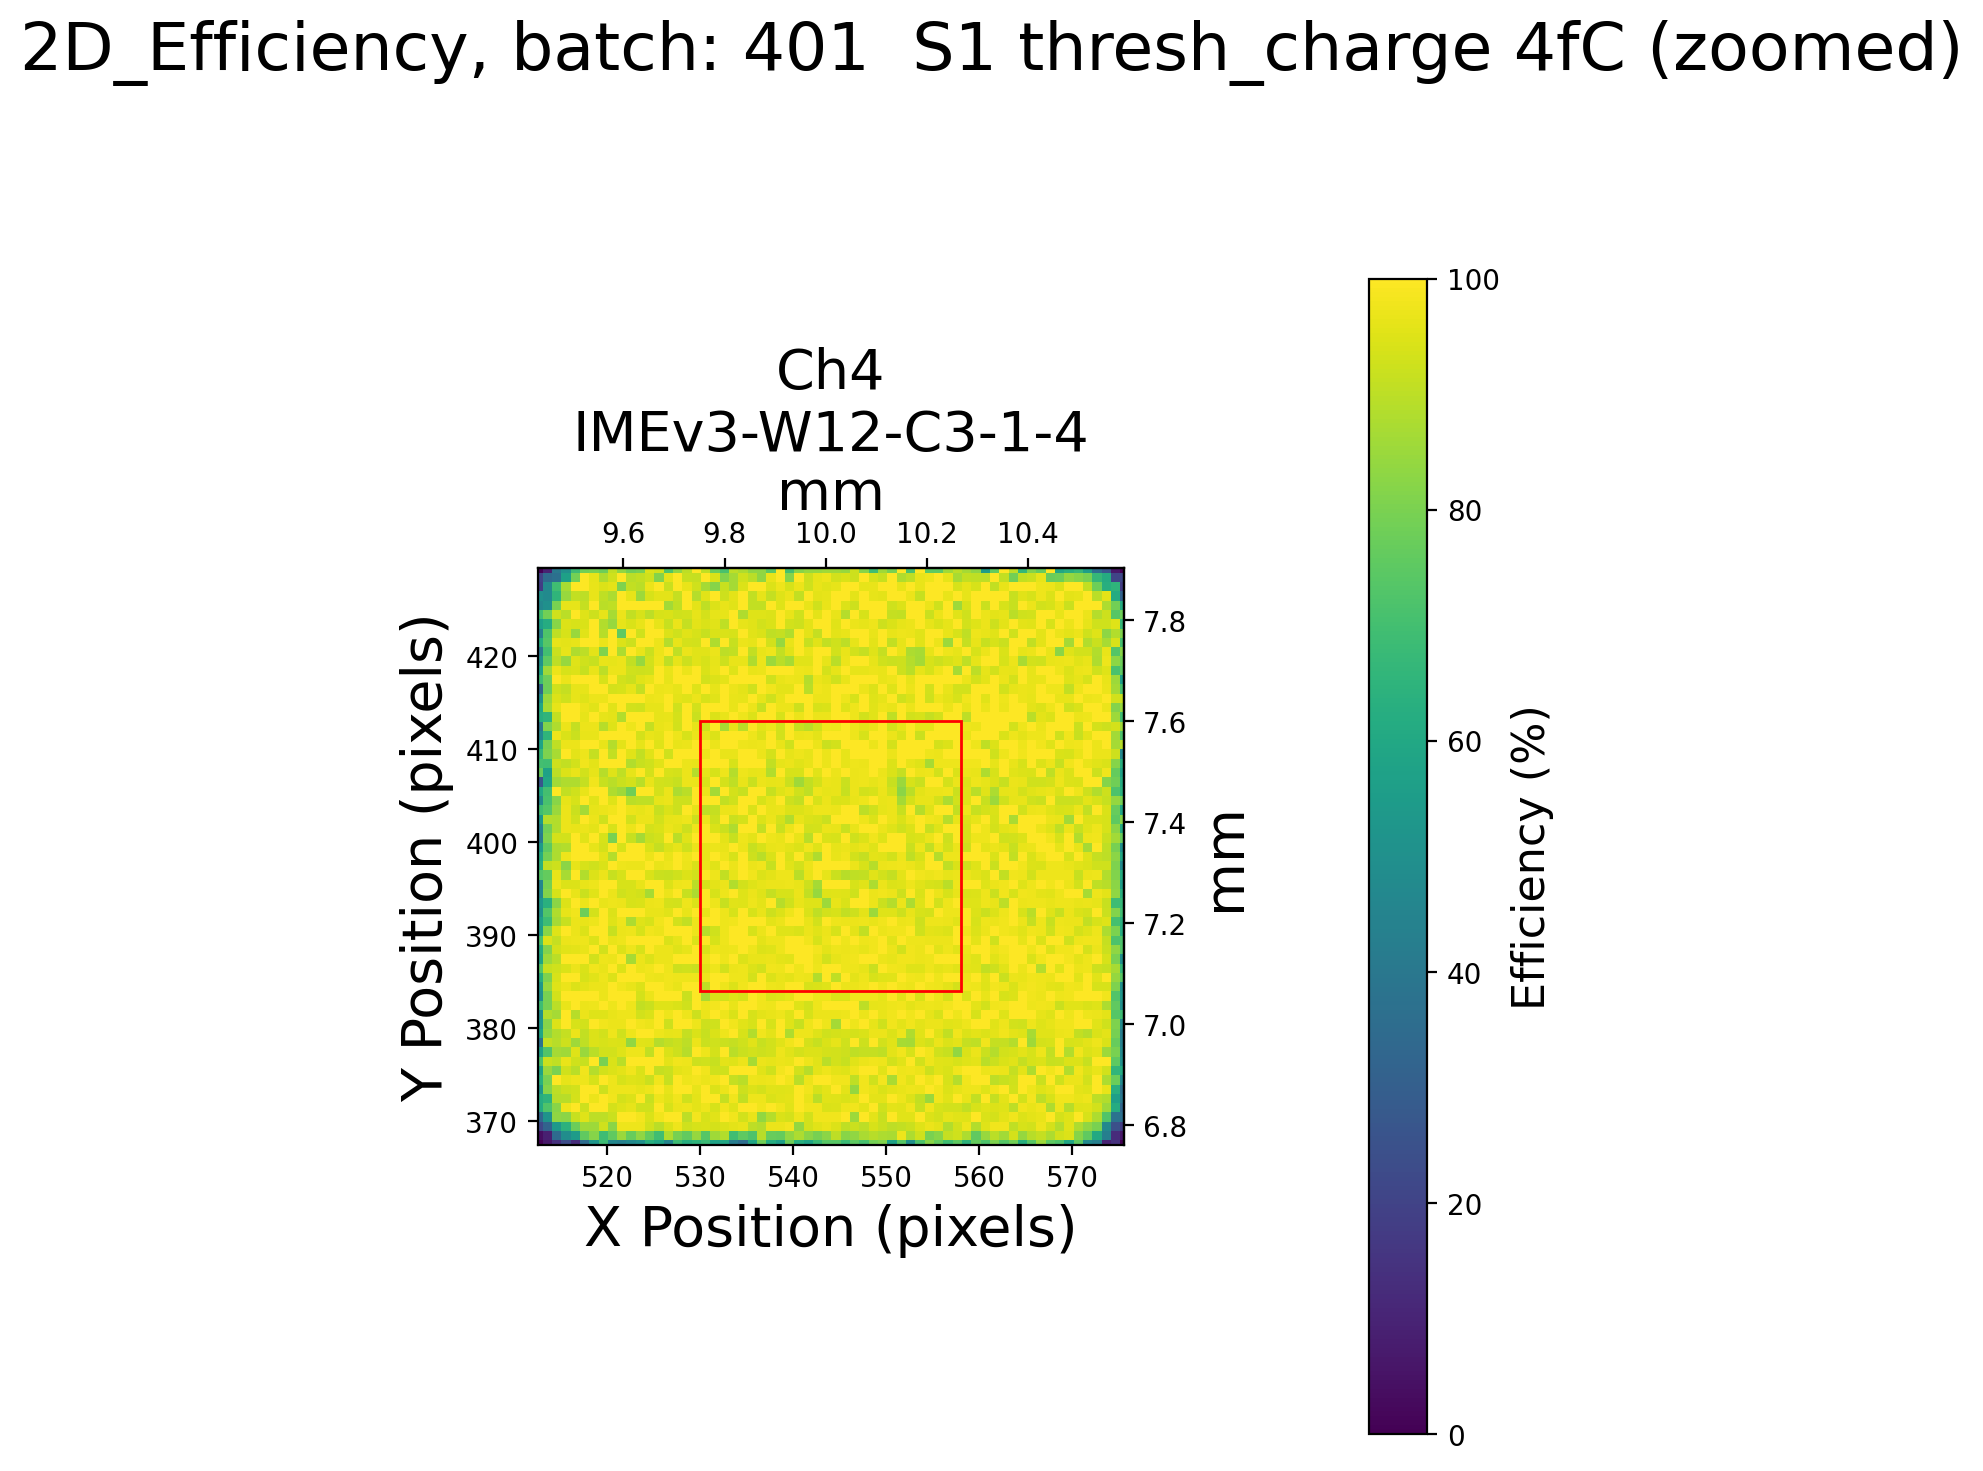

In [79]:
### without cuts (only selecting sensor area)
central_sensor_area_cuts, central_sensor_area_info = zip(*[geometry_mask(df, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use=use_for_geometry_cut) if dut in DUTs else (None,None) for dut in [1,2,3]])

fig, axes = plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='normal', zoom_to_sensor=True,
    bins=these_bins, n_DUT=DUTs, savefig=False, savefig_details=f' {S} thresh_charge {threshold_charge}fC (zoomed)', 
    savefig_path=pres_path, fmt='png')

### I want to draw the red square of the center onto these plots
for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**central_sensor_area_info[dut-1]))

if SAVE:
    fig.savefig(os.path.join(pres_path,f'2D Efficiency_{this_batch}_{S}_with_center_highlight.png'), bbox_inches='tight')
    

In [ ]:
# ### efficiency with time cut
# fig, axes = plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='normal', mask=time_cuts, zoom_to_sensor=True, 
#                  bins=these_bins, n_DUT=DUTs,# efficiency_lim=(0.4,1),
#                  savefig=SAVE, savefig_details=f'{S} thresh_charge {threshold_charge}fC \n(zoomed with cuts)', savefig_path=pres_path, fmt='png')


In [80]:
this_mask = [np.logical_and(pulse_cuts[dut-1], time_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]


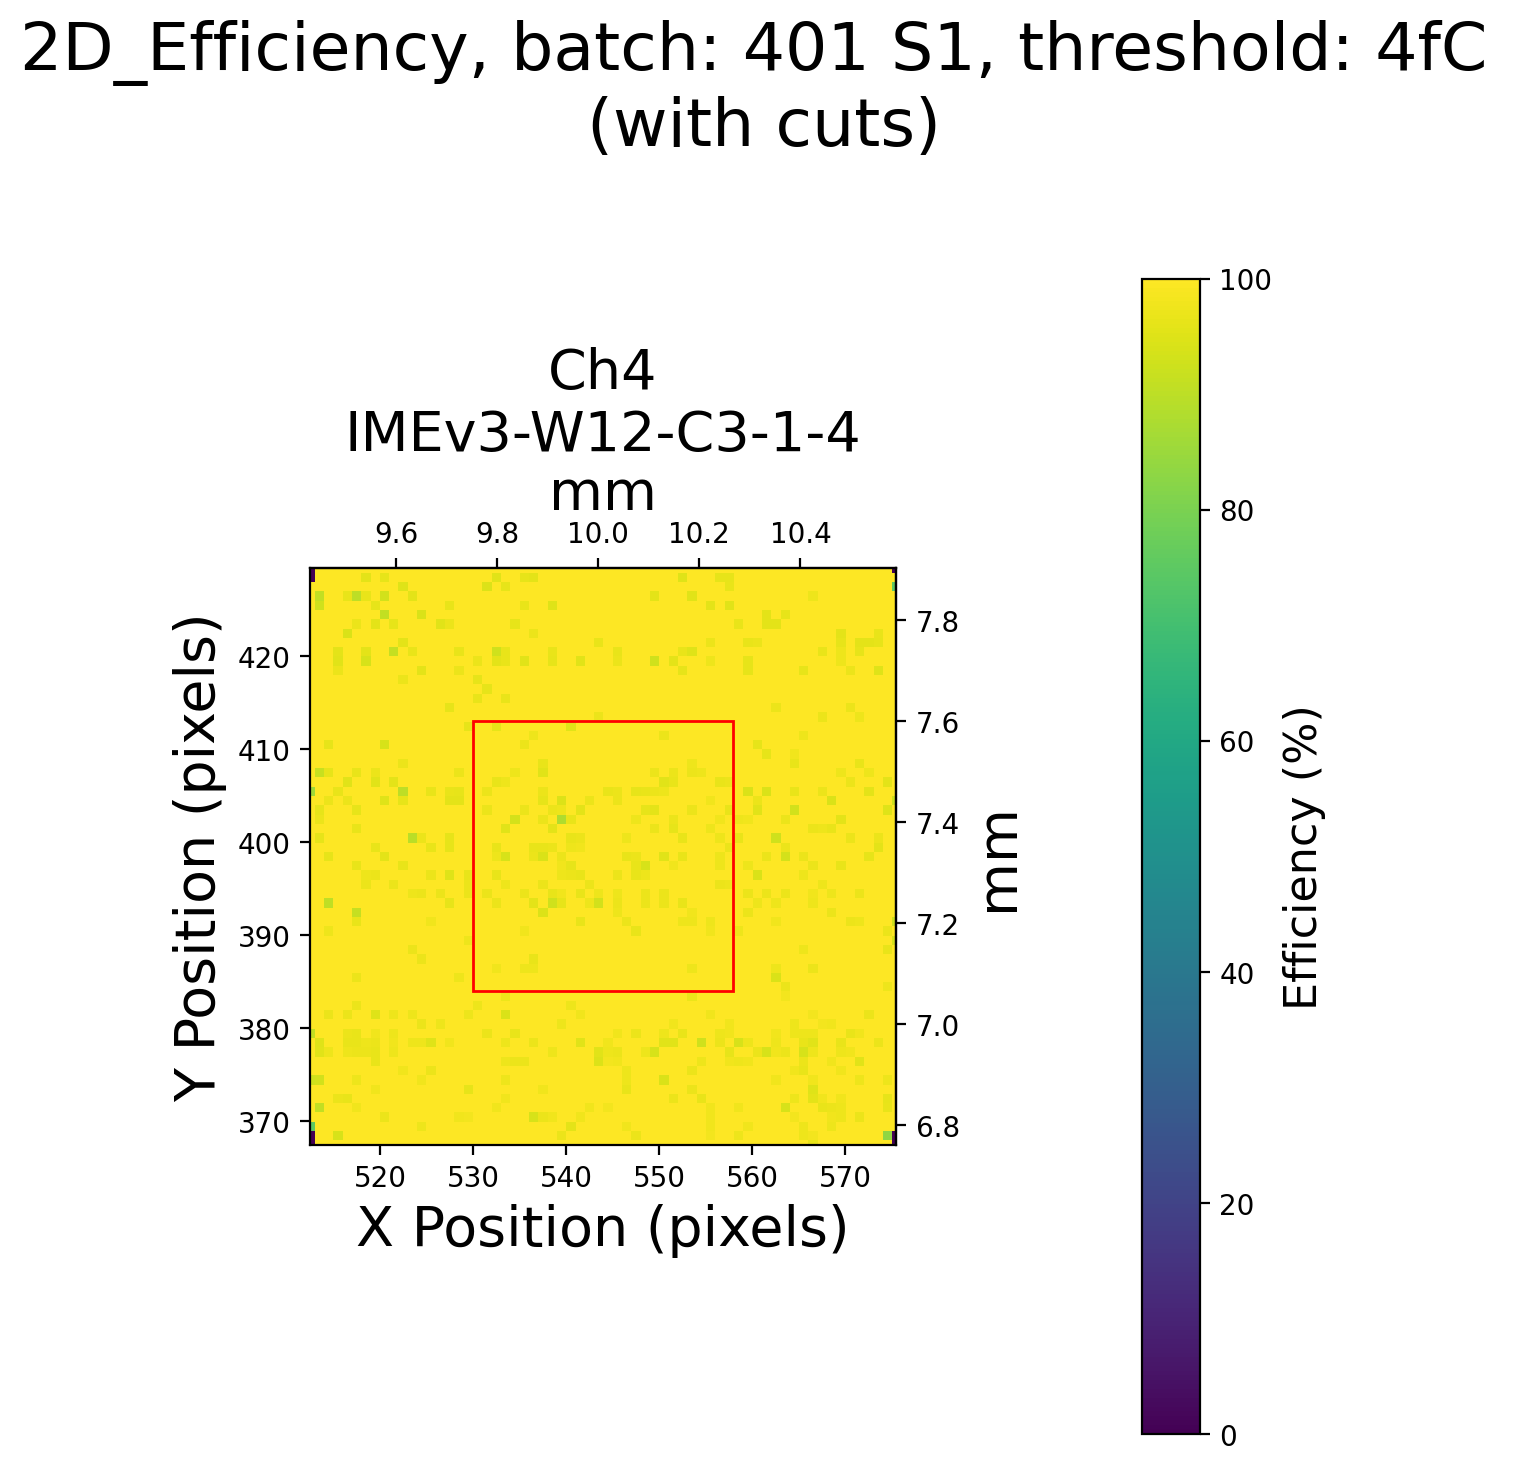

In [81]:
fig, axes = plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='normal', zoom_to_sensor=True,
    bins=these_bins, n_DUT=DUTs, mask=this_mask,
     savefig=False, savefig_details=f'{S}, threshold: {threshold_charge}fC \n(with cuts)', savefig_path=pres_path, fmt='png')

### I want to draw the red square of the center onto these plots
for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**central_sensor_area_info[dut-1]))
#     axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))
    
if SAVE:
    fig.savefig(os.path.join(pres_path,f'2D Efficiency_{this_batch}_{S}_with_cuts_with_center_highlight.png'), bbox_inches='tight')
    

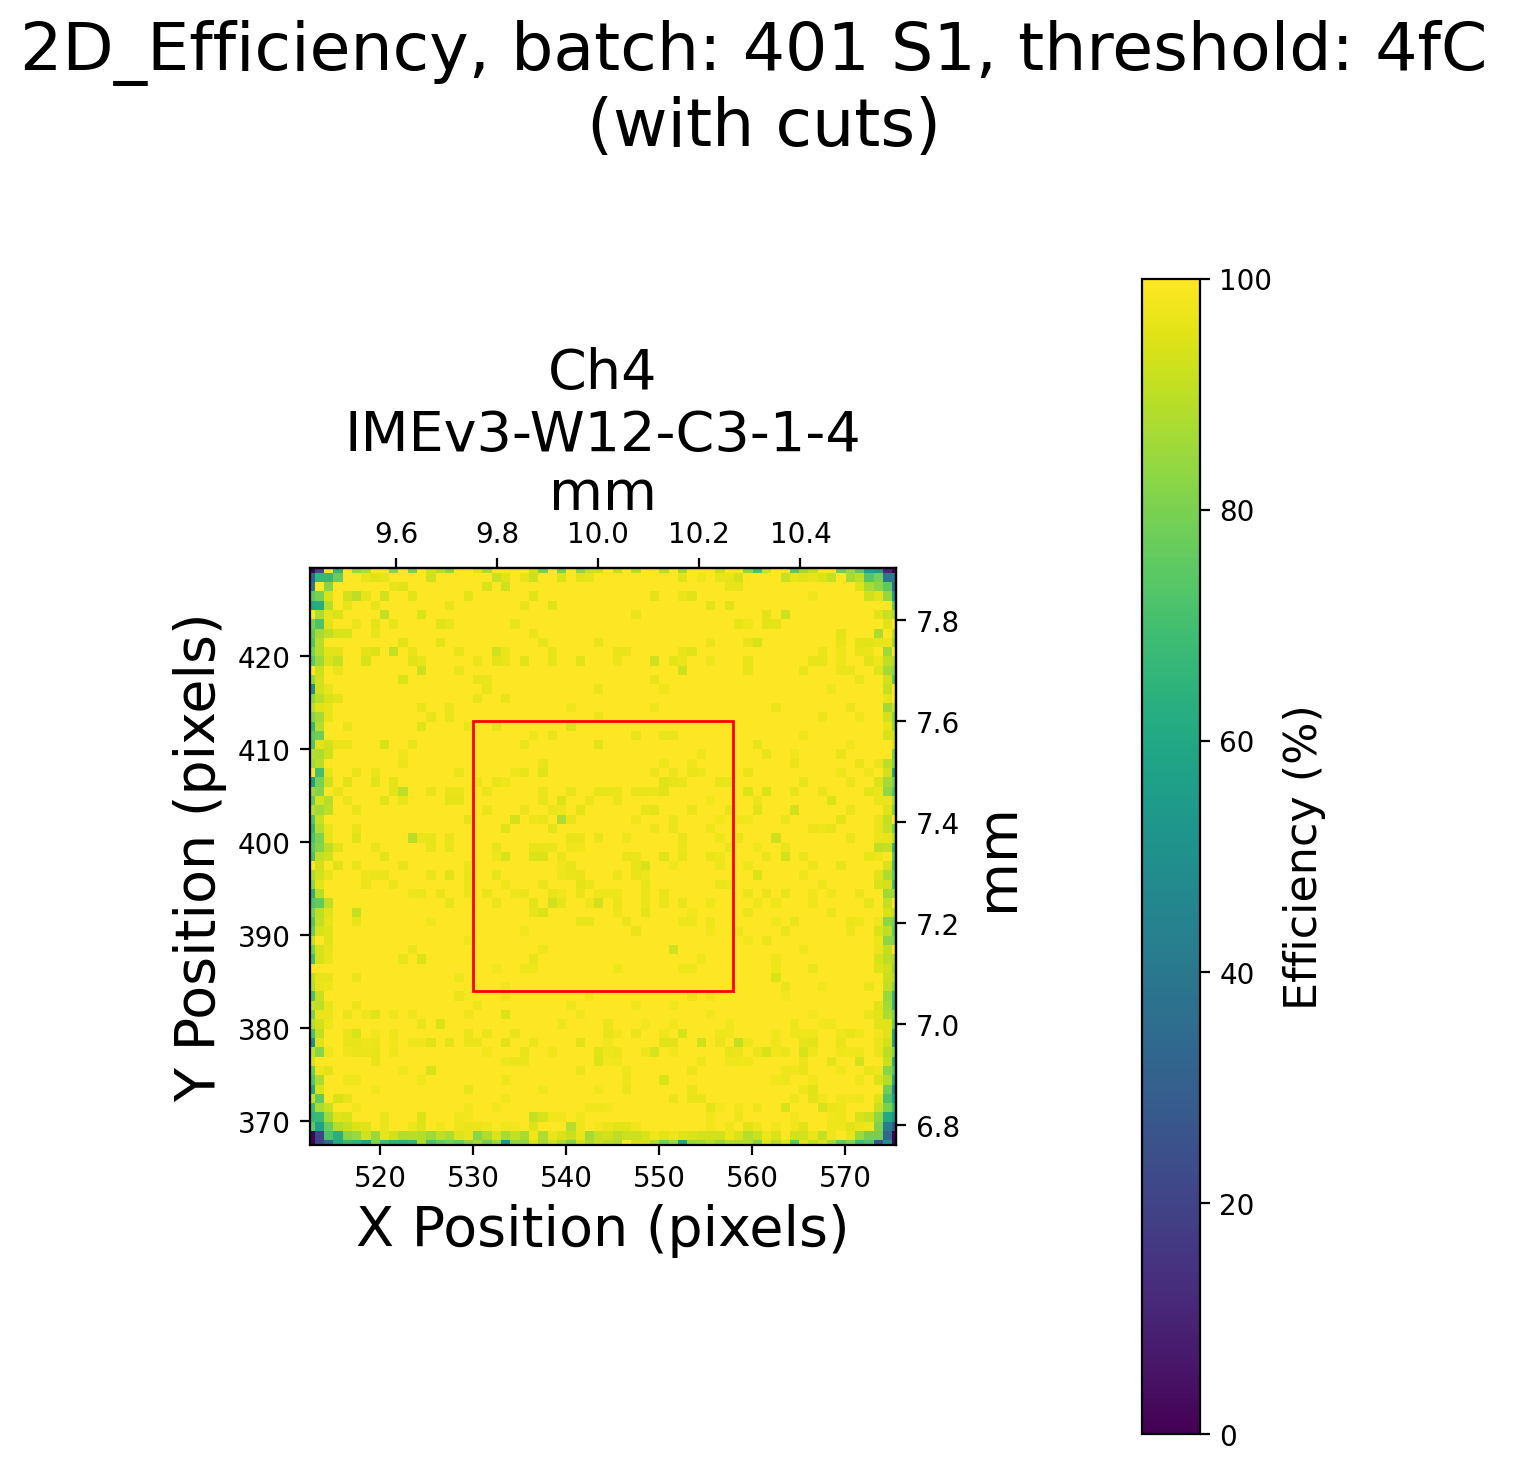

In [82]:
fig, axes = plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='normal', zoom_to_sensor=True,
    bins=these_bins, n_DUT=DUTs, mask=time_cuts,
     savefig=False, savefig_details=f'{S}, threshold: {threshold_charge}fC \n(with cuts)', savefig_path=pres_path, fmt='png')

### I want to draw the red square of the center onto these plots
for i,dut in enumerate(DUTs):
    axes[i].add_patch(rectangle_from_geometry_cut(**central_sensor_area_info[dut-1]))
#     axes[i].add_patch(rectangle_from_geometry_cut(**geo_infos[dut-1]))
    
if SAVE:
    fig.savefig(os.path.join(pres_path,f'2D Efficiency_{this_batch}_{S}_with_time_cut_with_center_highlight.png'), bbox_inches='tight')
    

''

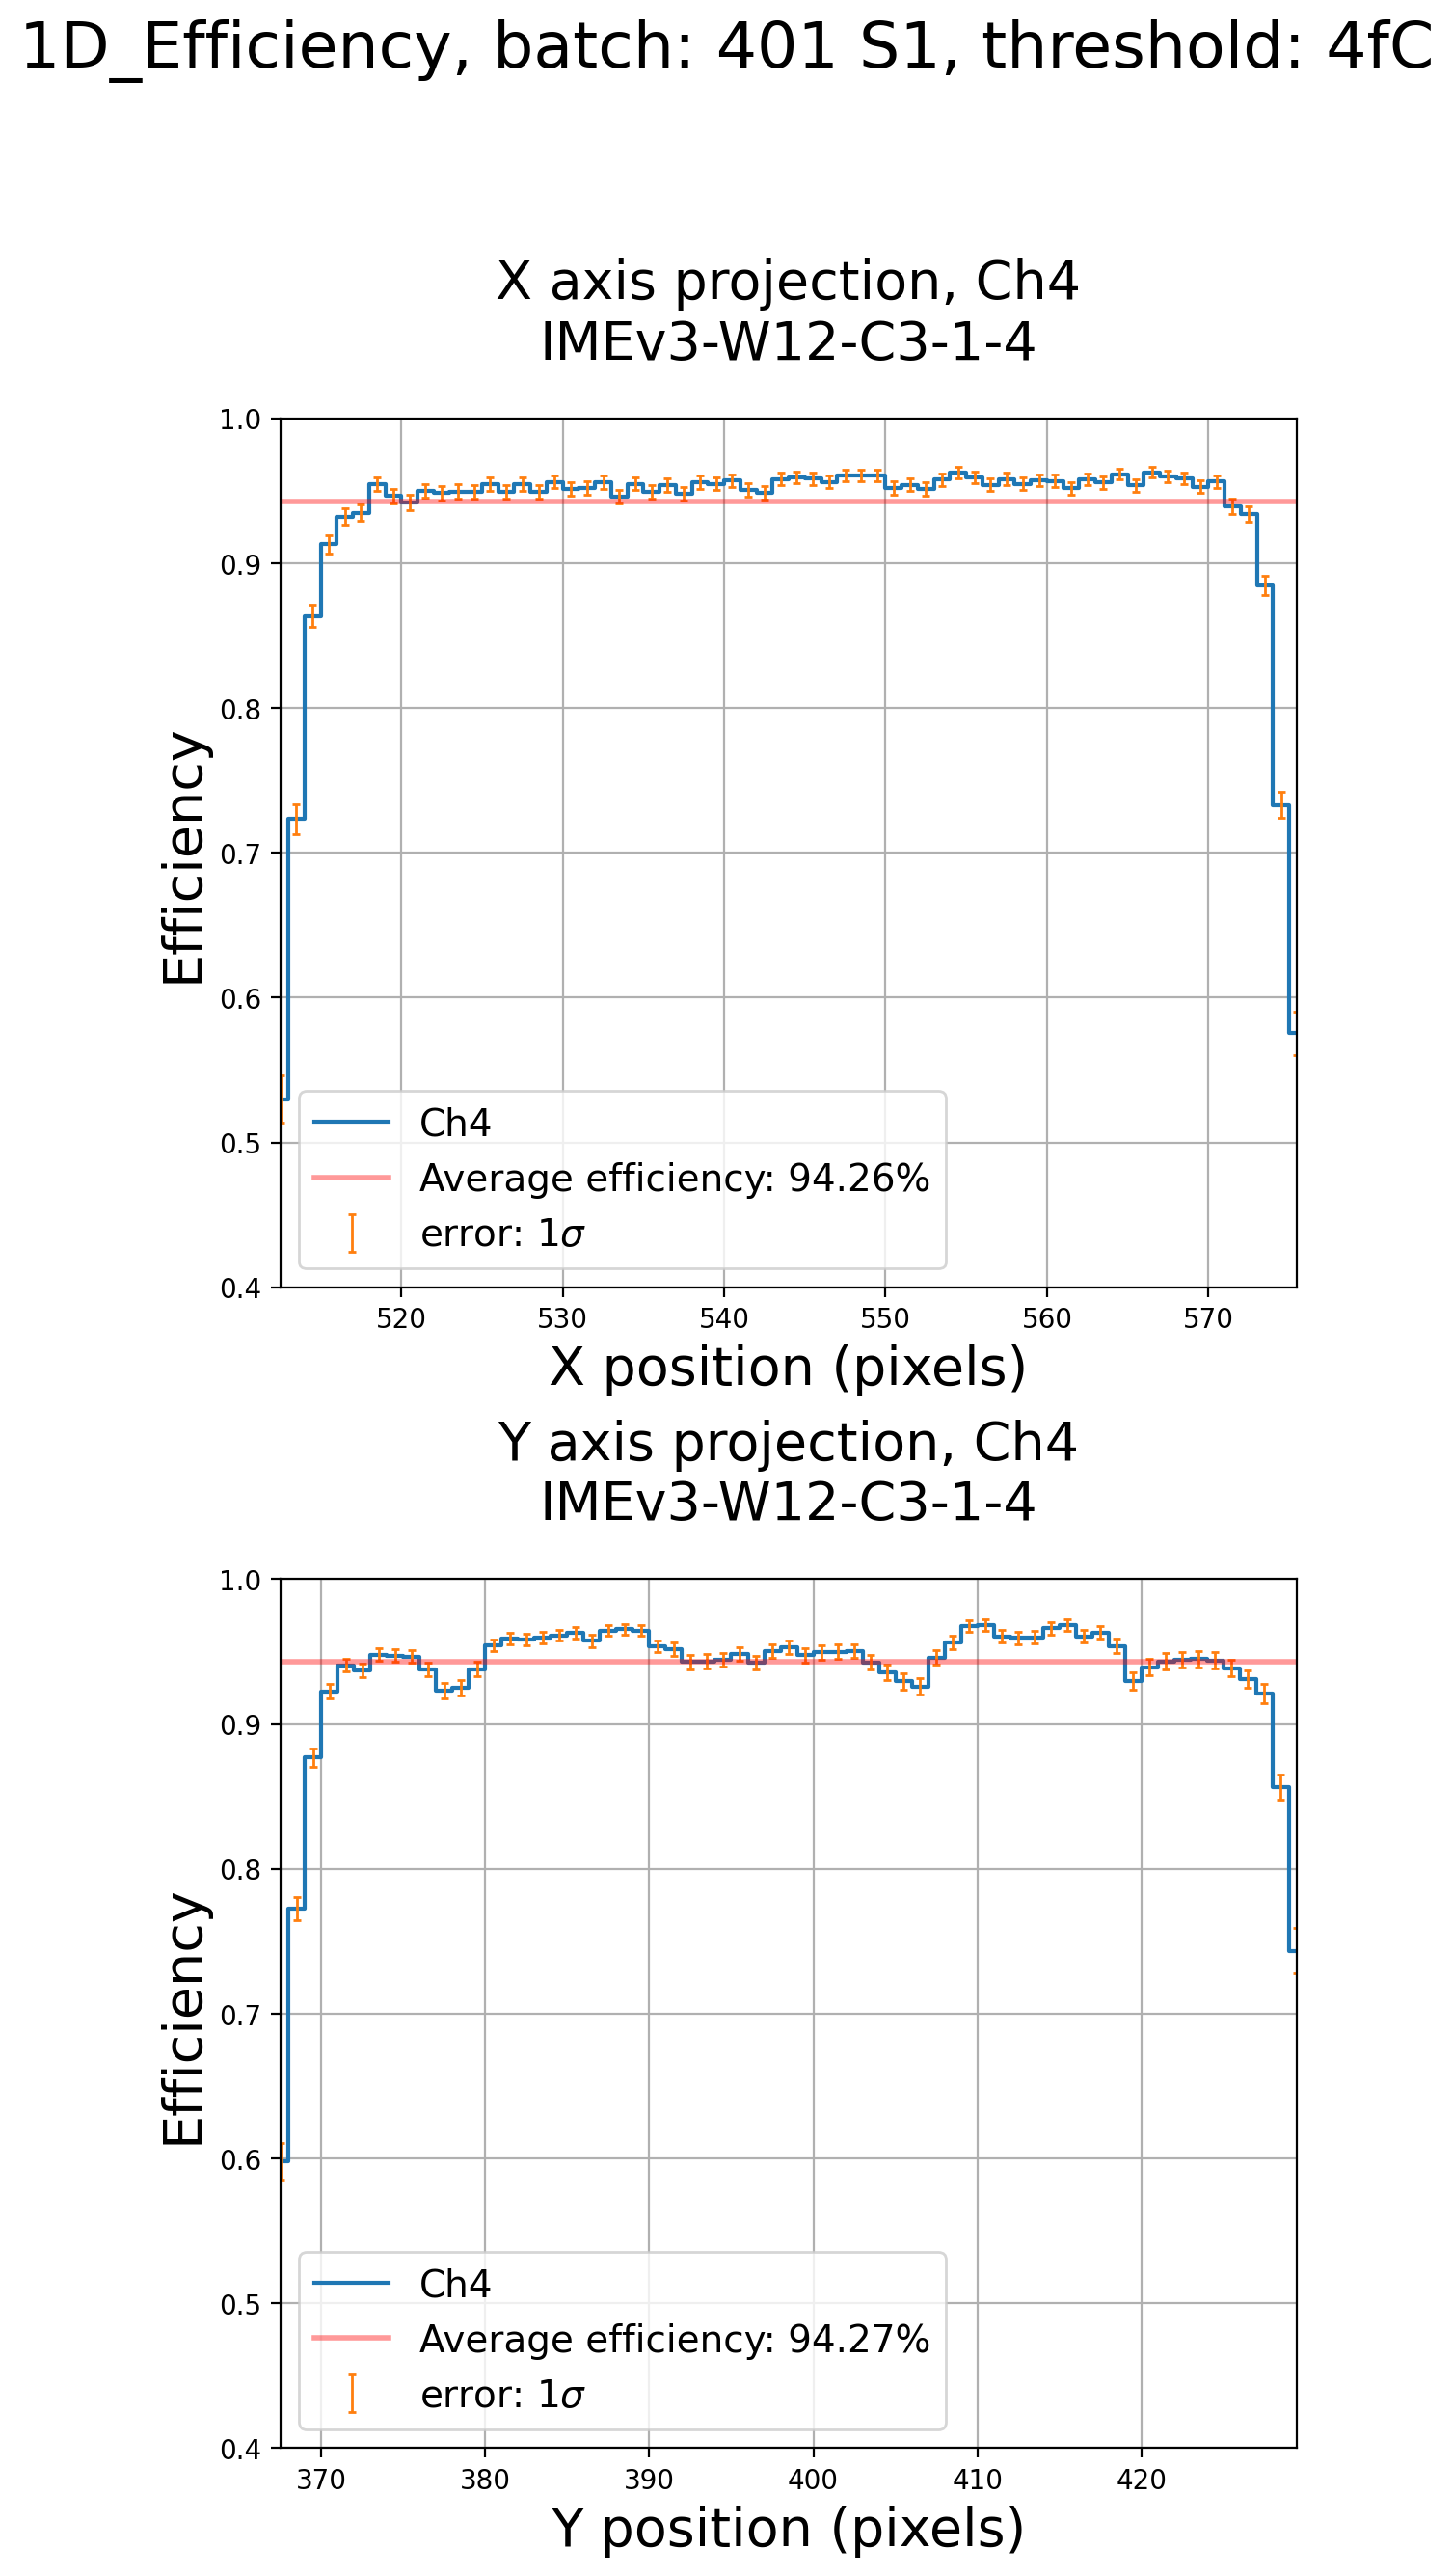

In [83]:
plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='normal', zoom_to_sensor=True,
    bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S}, threshold: {threshold_charge}fC',
    savefig_path=pres_path, fmt='png')
;

''

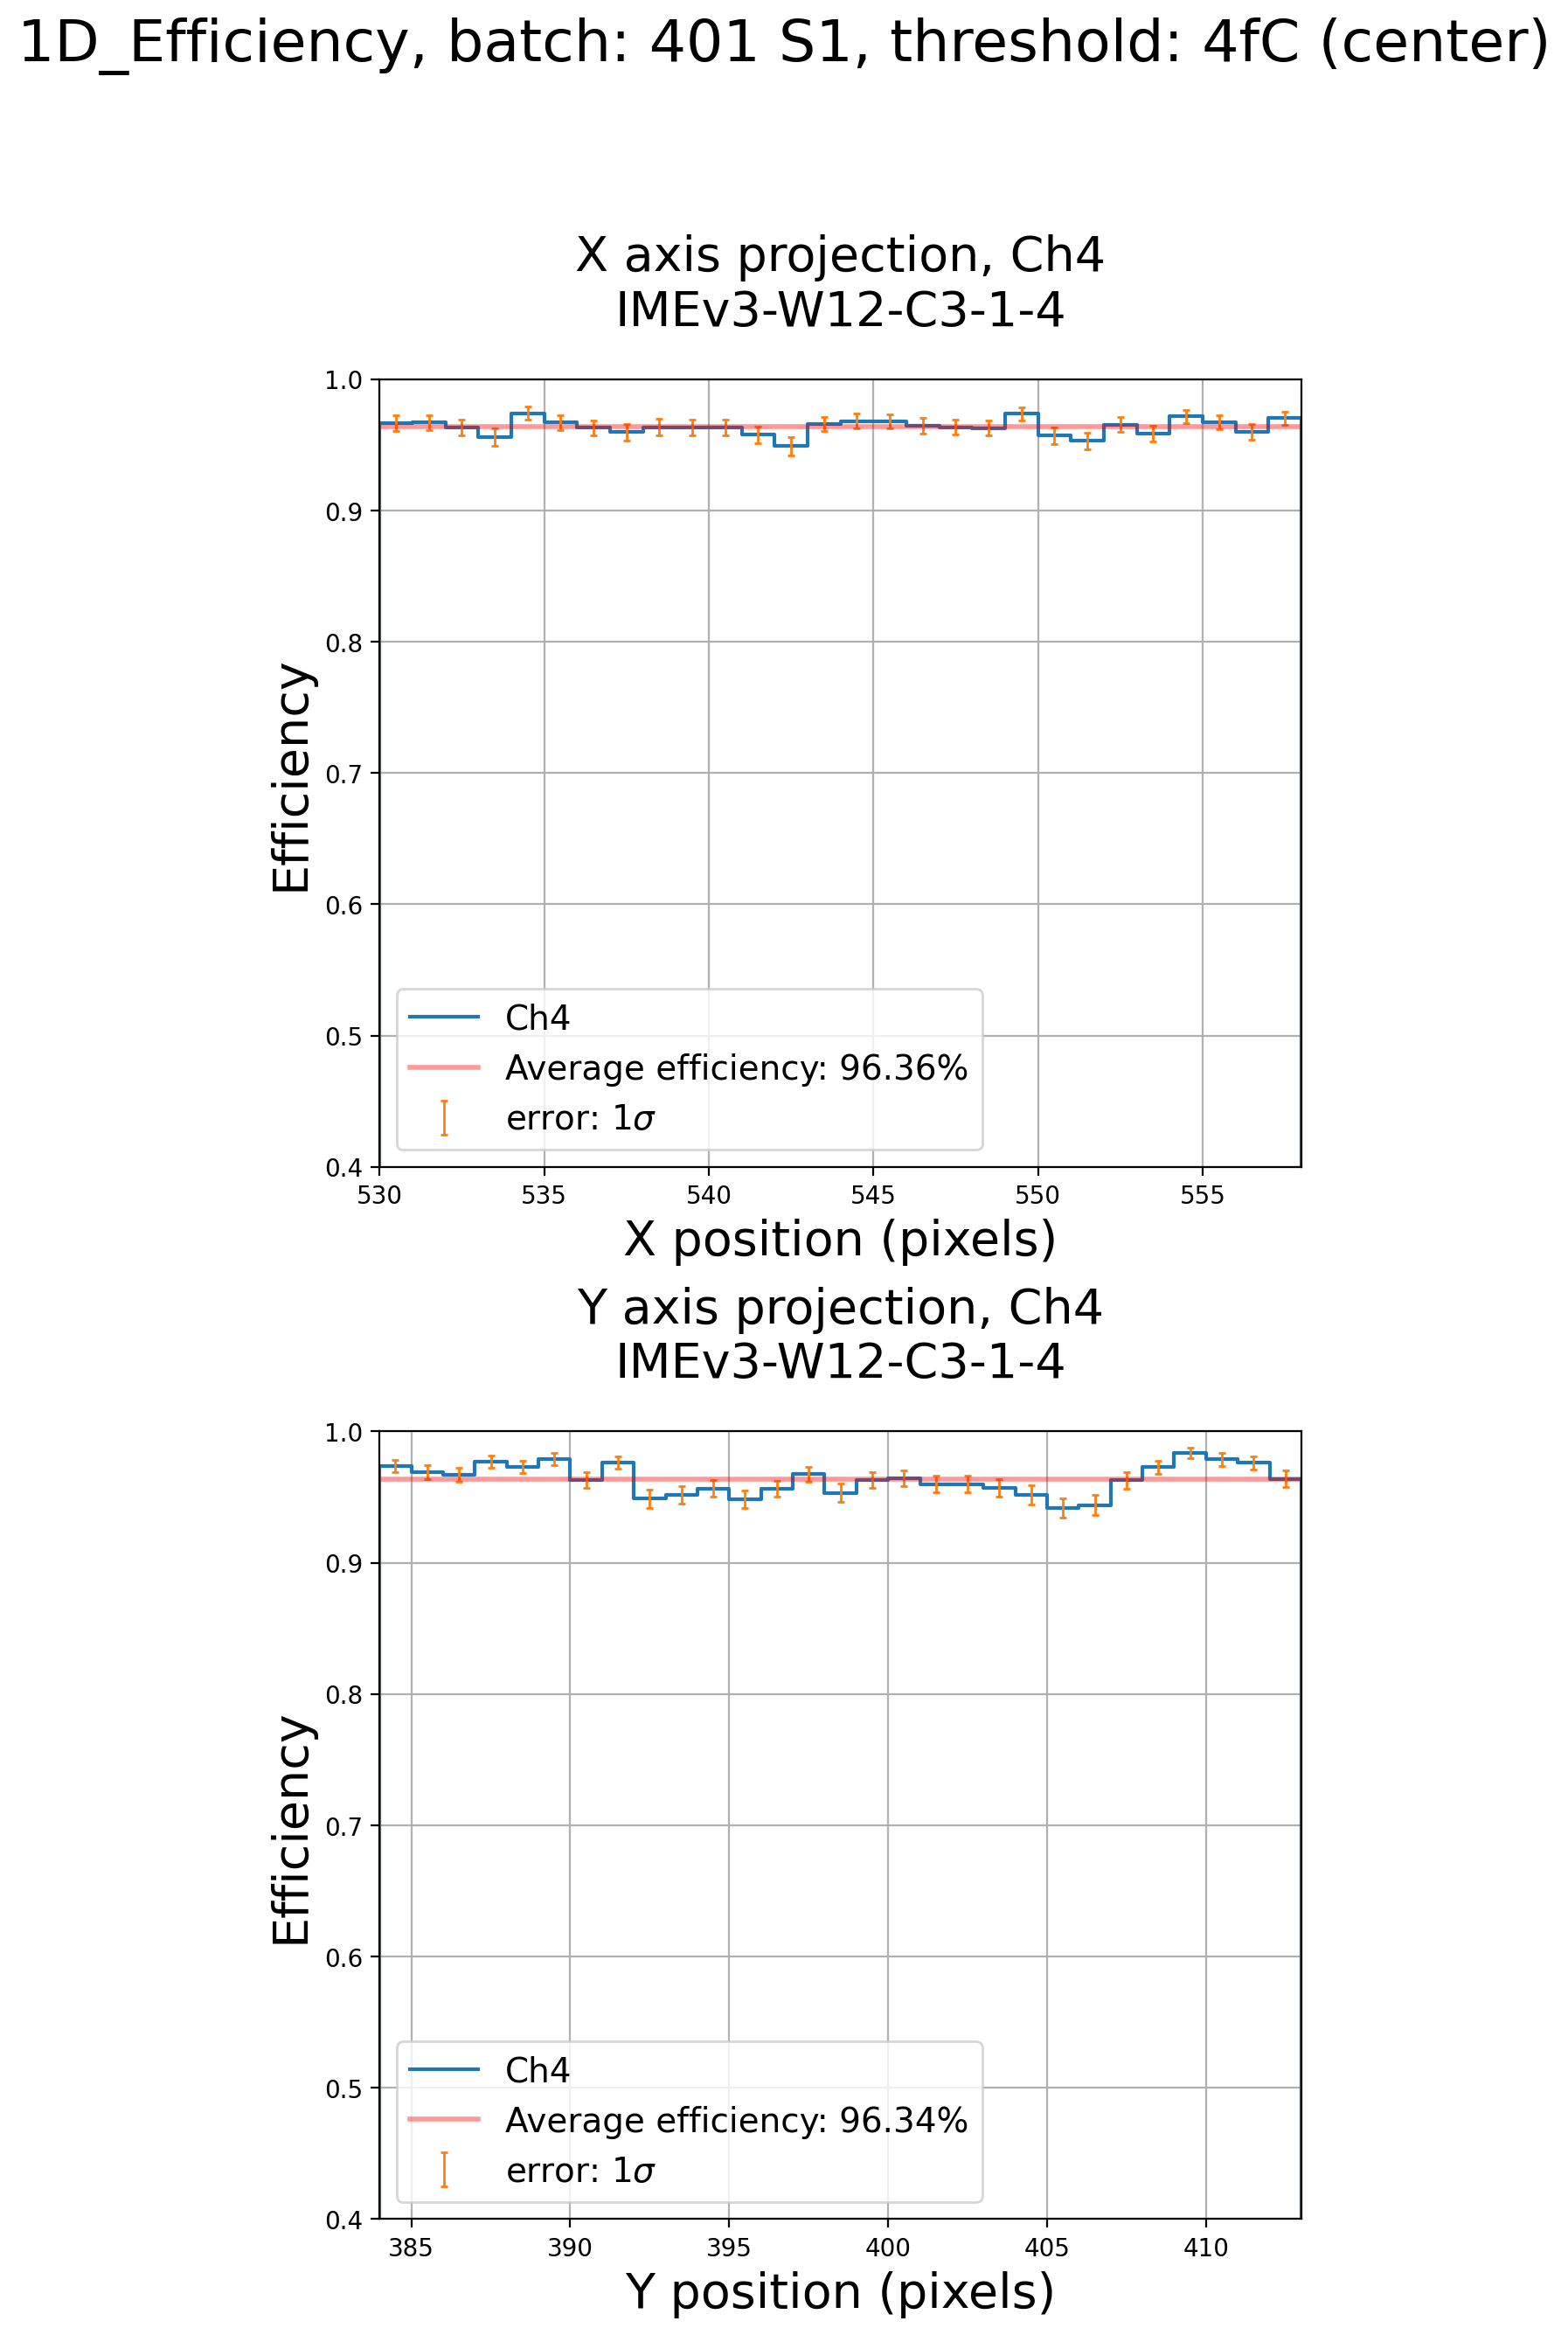

In [84]:
SAVE = True
plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='center', zoom_to_sensor=True,
    bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S}, threshold: {threshold_charge}fC (center)',
    savefig_path=pres_path, fmt='png')
;

''

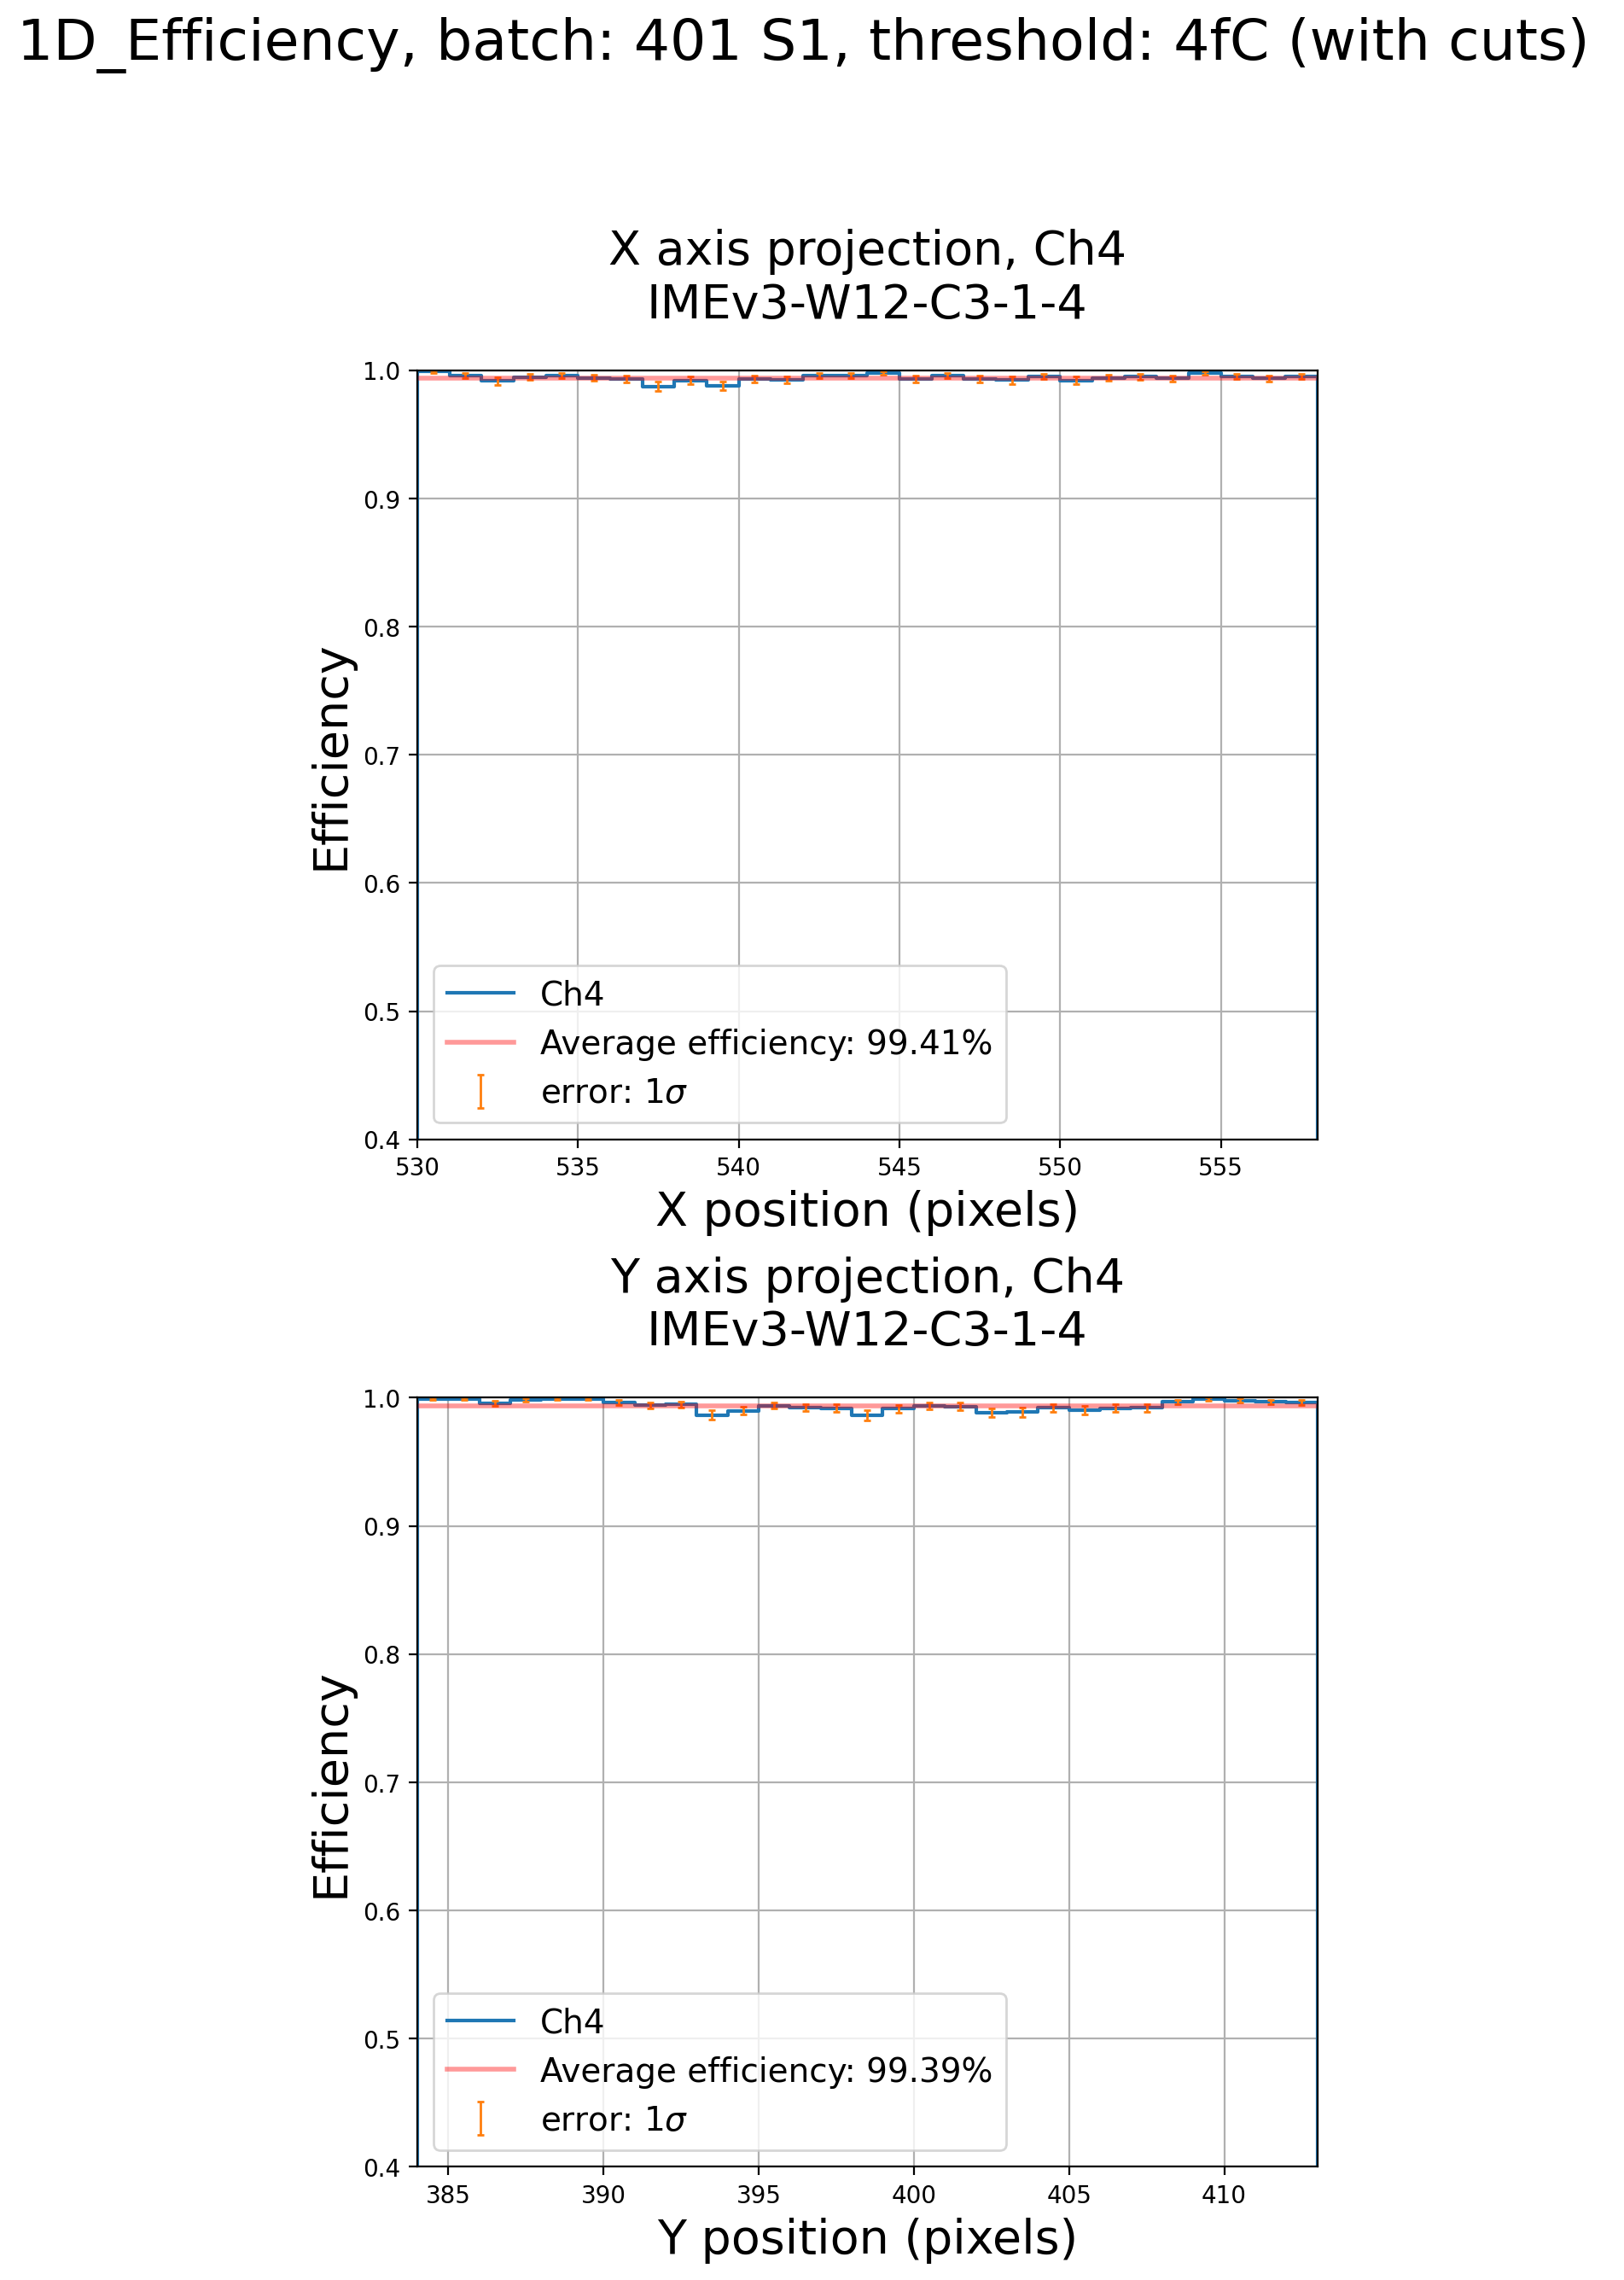

In [85]:
### 1D projections of effiency with all cuts 

plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=4700, geometry_cut='center', mask=this_mask, zoom_to_sensor=True,
    bins=these_bins, n_DUT=DUTs, savefig=SAVE, savefig_details=f'{S}, threshold: {threshold_charge}fC (with cuts) ',
    savefig_path=pres_path, fmt='png')
;

## Total efficiency

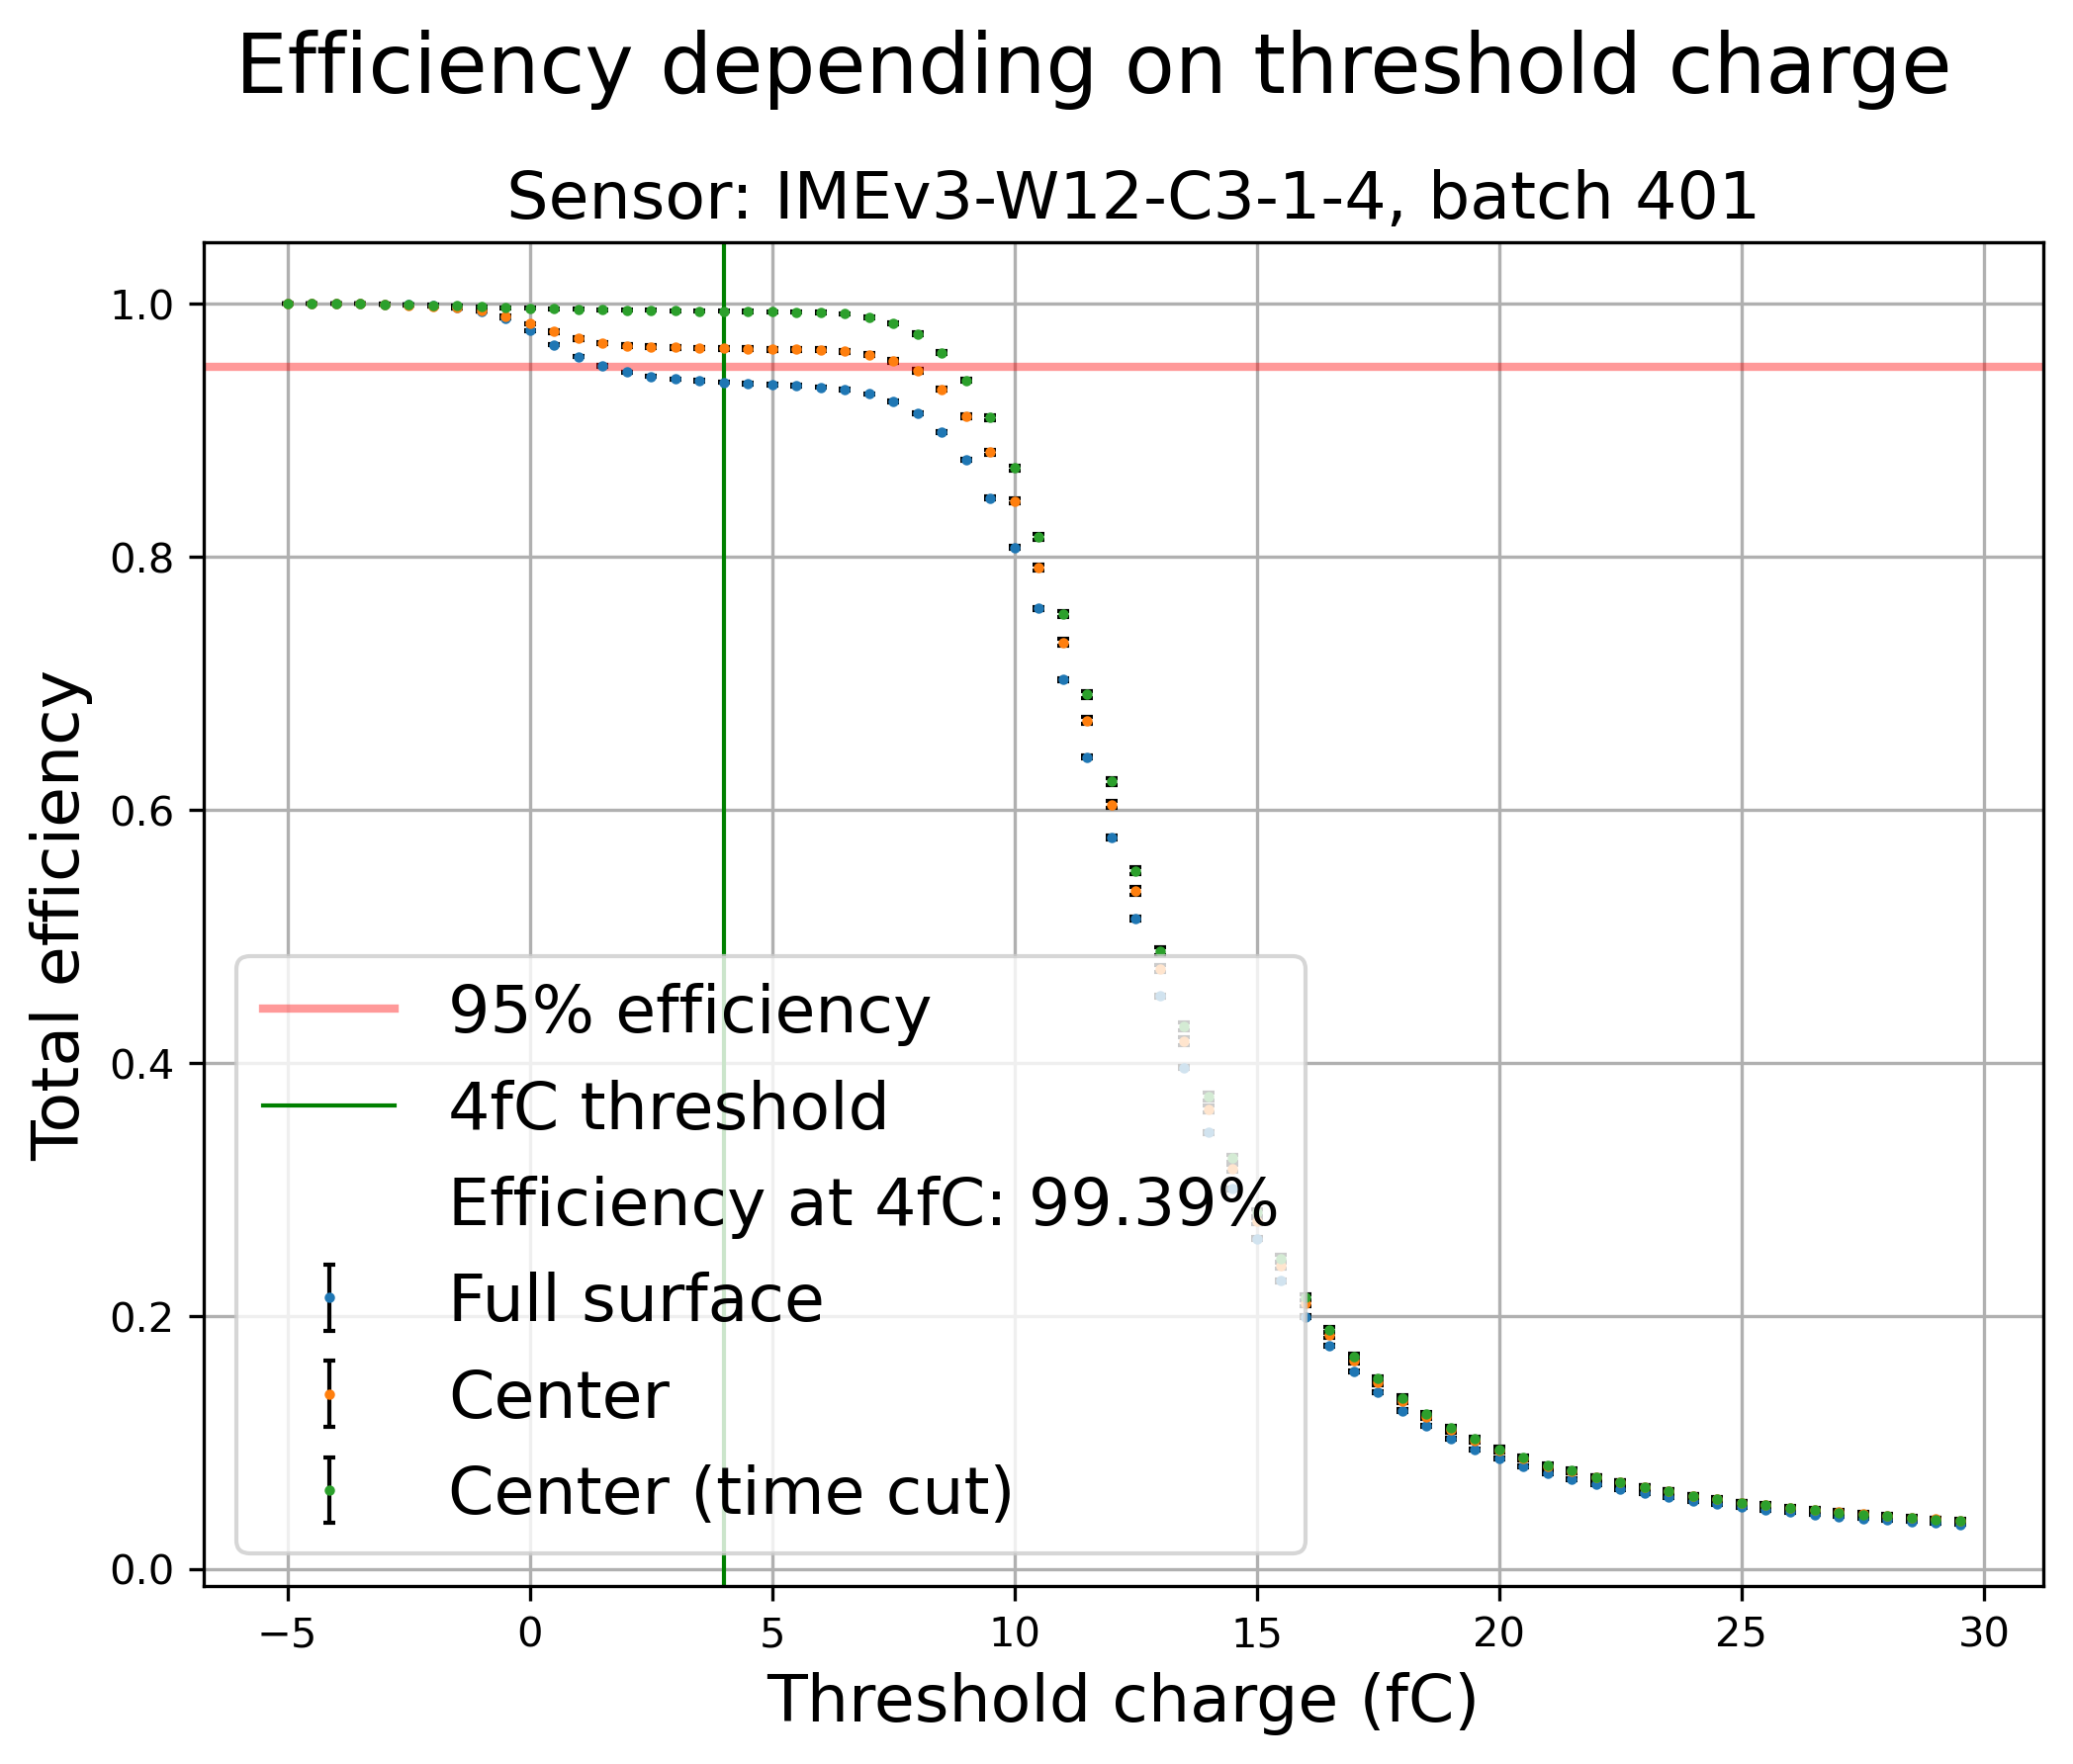

In [86]:
# transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in [1,2,3]]
transimpedance = [4700]*3
threshold_range = np.arange(-5, 30, 0.5)

fig, axes = plt.subplots(figsize=(8*len(DUTs),6),ncols=len(DUTs), dpi=300)
axes = np.atleast_1d(axes)

for i,dut in enumerate(DUTs):
    efficiency_normal = []
    error_normal = []
    
    efficiency_center = []
    error_center = []
    
    efficiency_timecut = []
    error_timecut = []

    for charge in threshold_range:
        ### efficiency with geometry cut
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[geo_cuts[dut-1]]/transimpedance[dut-1], charge)
        efficiency_normal.append(eff)
        error_normal.append(err)
        ### efficiency with geometry cut (center)
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[central_sensor_area_cuts[dut-1]]/transimpedance[dut-1], charge)
        efficiency_center.append(eff)
        error_center.append(err)
        ### efficiency with time cut (HAVEN'T DONE IT YET)
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[np.logical_and(central_sensor_area_cuts[dut-1], time_cuts[dut-1])]/transimpedance[dut-1], charge)
        efficiency_timecut.append(eff)
        error_timecut.append(err)
        
        if charge==4:
            eff_at_4fC = eff

    ### geometry cut
    axes[i].errorbar(threshold_range, efficiency_normal, yerr=error_normal, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Full surface")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")
    ### geometry cut (center)
    axes[i].errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")
    ### time cut (center)
    axes[i].errorbar(threshold_range, efficiency_timecut, yerr=error_timecut, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center (time cut)")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")

    axes[i].set_title(f" Sensor: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}, batch {this_batch}",fontsize=16)
    axes[i].set_xlabel("Threshold charge (fC)",fontsize=16)
    axes[i].set_ylabel("Total efficiency",fontsize=16)
    axes[i].axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
    axes[i].axvline(4, label="4fC threshold", color='g', linewidth=1)
    axes[i].plot([],[], label="Efficiency at 4fC: %.2f"%(eff_at_4fC*100)+"%", linewidth=0)
    axes[i].grid('--')
    axes[i].legend(fontsize=16)
fig.suptitle(f"Efficiency depending on threshold charge",fontsize=20,y=1)

if SAVE:
    fig.savefig(os.path.join(pres_path,f"Efficiency depending on threshold charge batch {this_batch} {S}.png"), bbox_inches='tight')

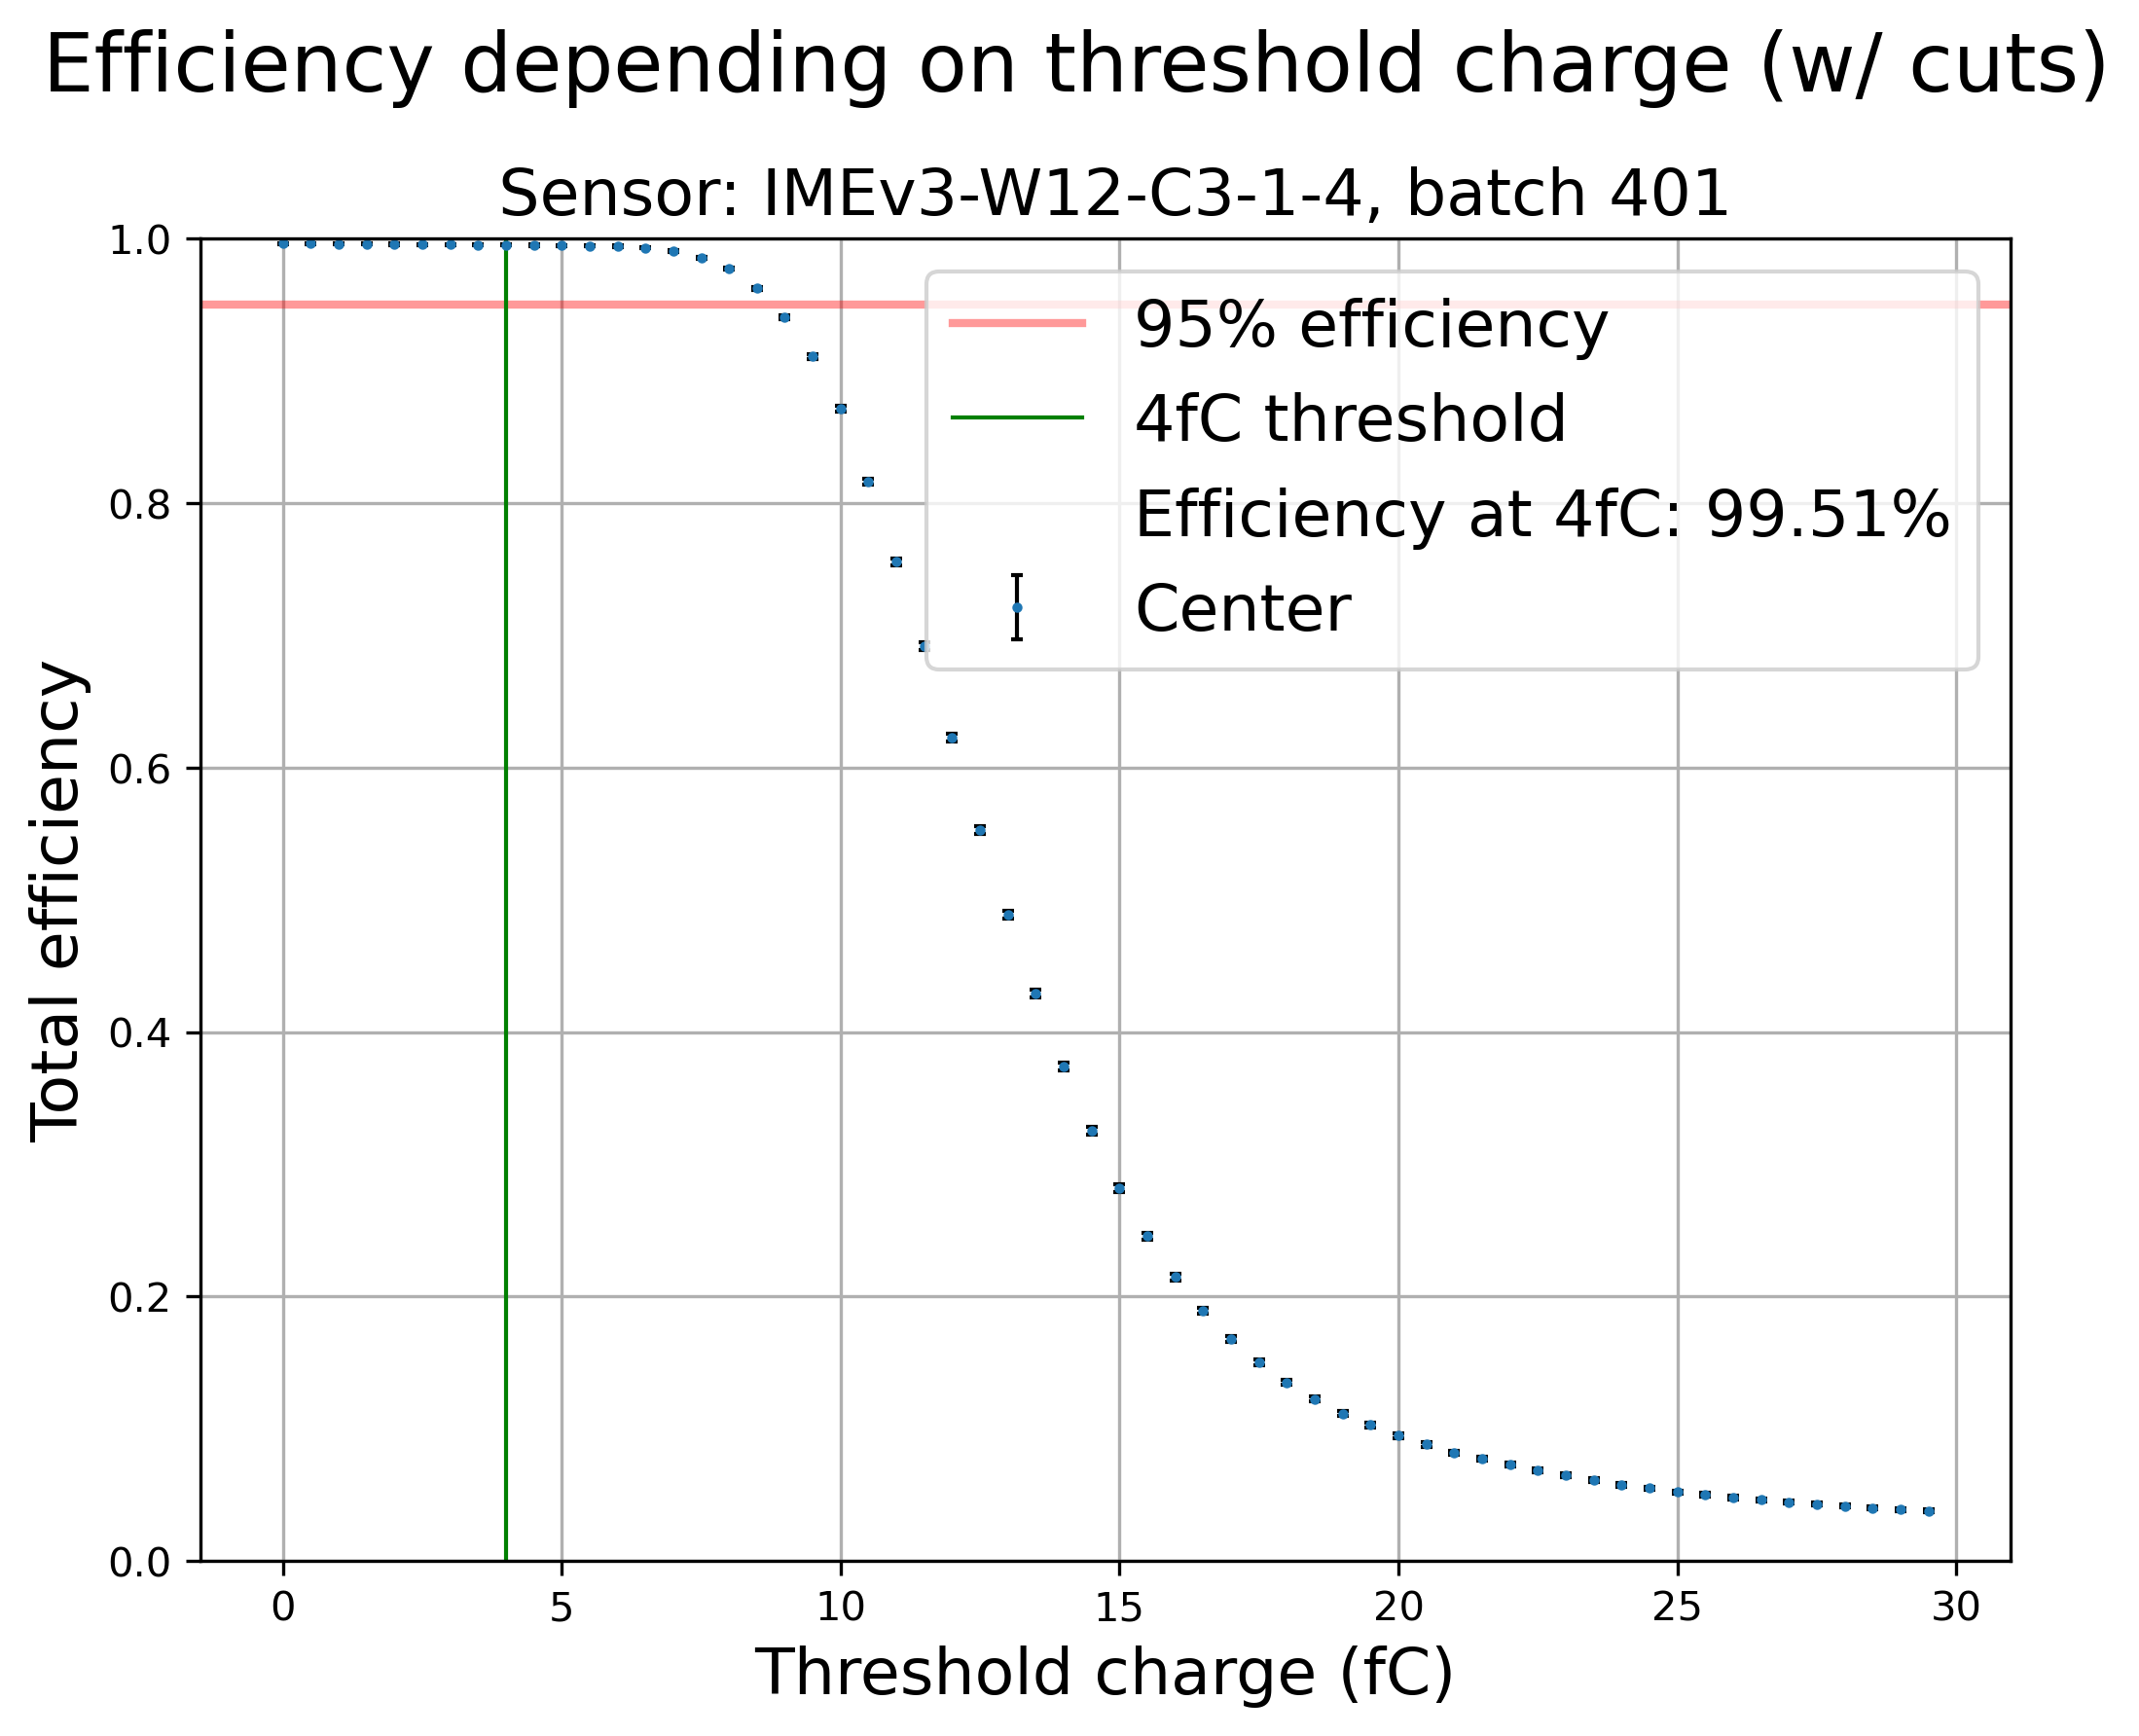

In [87]:

transimpedance = [4700]*3
threshold_range = np.arange(0, 30, 0.5)

fig, axes = plt.subplots(figsize=(8*len(DUTs),6),ncols=len(DUTs), dpi=300)
axes = np.atleast_1d(axes)

for i,dut in enumerate(DUTs):
    efficiency_center = []
    error_center = []
    for charge in threshold_range:
        ### efficiency with geometry cut (center)
        eff, err = efficiency_error(df[f"charge_{dut}"].loc[np.logical_and(central_sensor_area_cuts[dut-1], all_cuts[dut-1])]/transimpedance[dut-1], charge)
        efficiency_center.append(eff)
        error_center.append(err)
        
        if charge==4:
            eff_at_4fC = eff

    ### geometry cut (center)
    axes[i].errorbar(threshold_range, efficiency_center, yerr=error_center, marker='.', markersize=3, linewidth=0,
                elinewidth=1, ecolor='k', capsize=1.5,
                label=f"Center")#, #tracks: {df[f'charge_{dut}'].loc[geometry].size}")

    axes[i].set_title(f" Sensor: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}, batch {this_batch}",fontsize=16)
    axes[i].set_xlabel("Threshold charge (fC)",fontsize=16)
    axes[i].set_ylabel("Total efficiency",fontsize=16)
    axes[i].axhline(0.95, label="95% efficiency", color='r', alpha=0.4, linewidth=2)
    axes[i].axvline(4, label="4fC threshold", color='g', linewidth=1)
    axes[i].plot([],[], label="Efficiency at 4fC: %.2f"%(eff_at_4fC*100)+"%", linewidth=0)
    axes[i].grid('--')
    axes[i].set_ylim(0,1)
    axes[i].legend(fontsize=16)
    
fig.suptitle(f"Efficiency depending on threshold charge (w/ cuts)",fontsize=20,y=1)

if SAVE:
    fig.savefig(os.path.join(pres_path,f"Efficiency depending on threshold charge (with cuts) batch {this_batch} {S}.png"), bbox_inches='tight')

## Time Resolution

In [ ]:
# SAVE = False

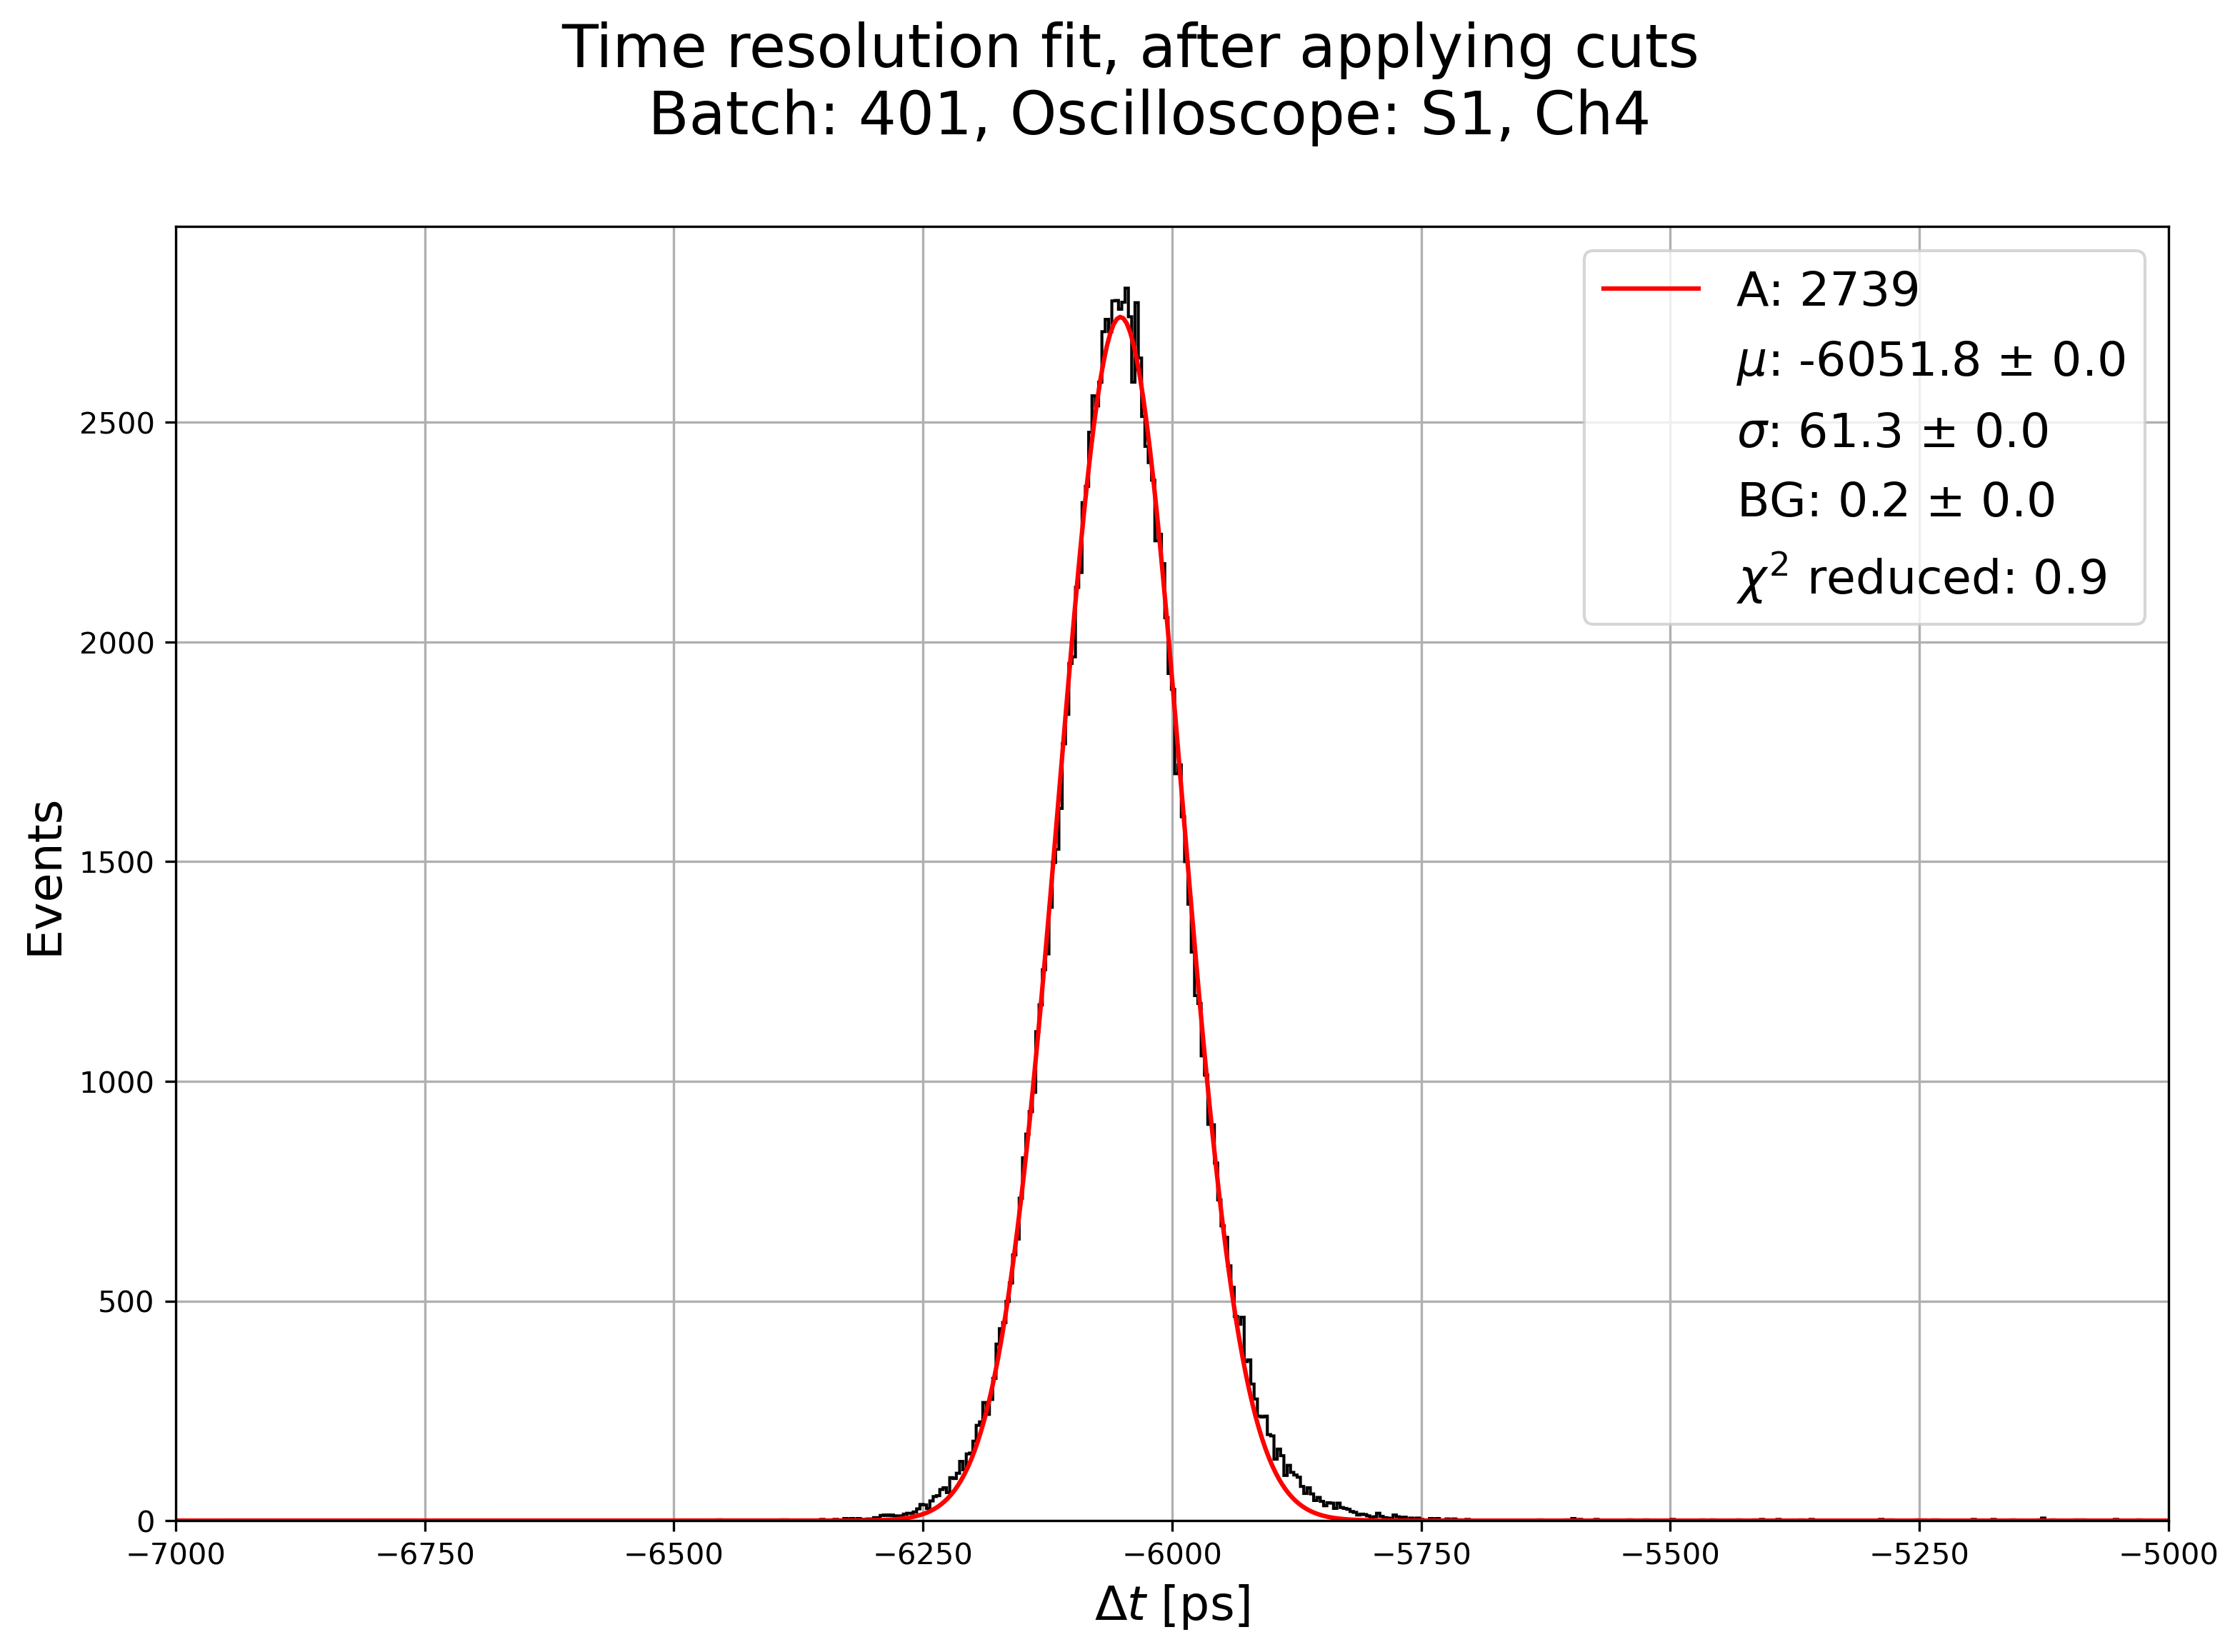

In [88]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=1, dpi=300)
# pulse_geo_cuts = [np.logical_and(geo_cuts[dut-1], pulse_cuts[dut-1]) for dut in DUTs]

for dut in DUTs:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])> -window_limit,
                               (df[f"timeCFD20_{dut}"]-df["timeCFD50_0"])< +window_limit)
#     dut_cut = np.logical_and(window_fit, all_cuts[dut-1])
#     dut_cut = np.logical_and(window_fit, np.logical_and(pulse_cuts[dut-1],geo_cuts[dut-1]))

### ONLY EVENTS WITH CHARGE OVER THE THRESHOLD CHARGE
    dut_cut = np.logical_and(df[f"charge_{dut}"]>threshold_charge,
                             np.logical_and(window_fit, np.logical_and(pulse_cuts[dut-1], geo_cuts[dut-1])))
        
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut]),
                                         bins='auto', color='k', linewidth=1, alpha=1,
                                         fig_ax=(fig,axes))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist), bins_centers[np.argmax(hist)], 100, np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}"
    axes.plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut])

    ### add units to the parameters
    axes.plot([],[], label="A: %.0f" %param[0], color=colormap[dut]) # only two decimals
    axes.plot([],[],linewidth=0, label="$\mu$: %.1f $\pm$ %.1f"%(param[1],covar[1,1]**0.5))
    axes.plot([],[],linewidth=0, label="$\sigma$: %.1f $\pm$ %.1f"%(param[2],covar[2,2]**0.5))
    axes.plot([],[],linewidth=0, label="BG: %.1f $\pm$ %.1f"%(param[3],covar[3,3]**0.5))
    ### maybe I should just make the chi² into a function
    chi2_reduced = sum((hist-my_gauss(bins_centers,*param))**2/my_gauss(bins_centers,*param))/(len(hist)-len(param))
    axes.plot([],[],linewidth=0, label="$\chi^2$ reduced: "+f"%.1f"%chi2_reduced)
#     skewness = skew(df[f"timeCFD20_{dut}"].loc[dut_cut]-df["timeCFD50_0"].loc[dut_cut])
#     axes.plot([],[],linewidth=0, label=f"skewness: {skewness}")
    
axes.set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes.set_ylabel("Events", fontsize=16)

xlim = (-7e3,-5e3)
# xlim = (-10e3,0)
axes.set_xlim(xlim)
axes.legend(fontsize=16)

fig.suptitle(f"Time resolution fit, after applying cuts \
\n Batch: {this_batch}, Oscilloscope: {S}, Ch{dut+1}",y=1, fontsize=20)

if SAVE:
    fig.savefig(os.path.join(pres_path, f"time_resolution_{this_batch}_{S}_zoomed_and_gauss_fit_with_cuts.png"), bbox_inches="tight")

 ### Testing different CFD thresholds
 
 This is giving different results than the normal fit, I may have to check why

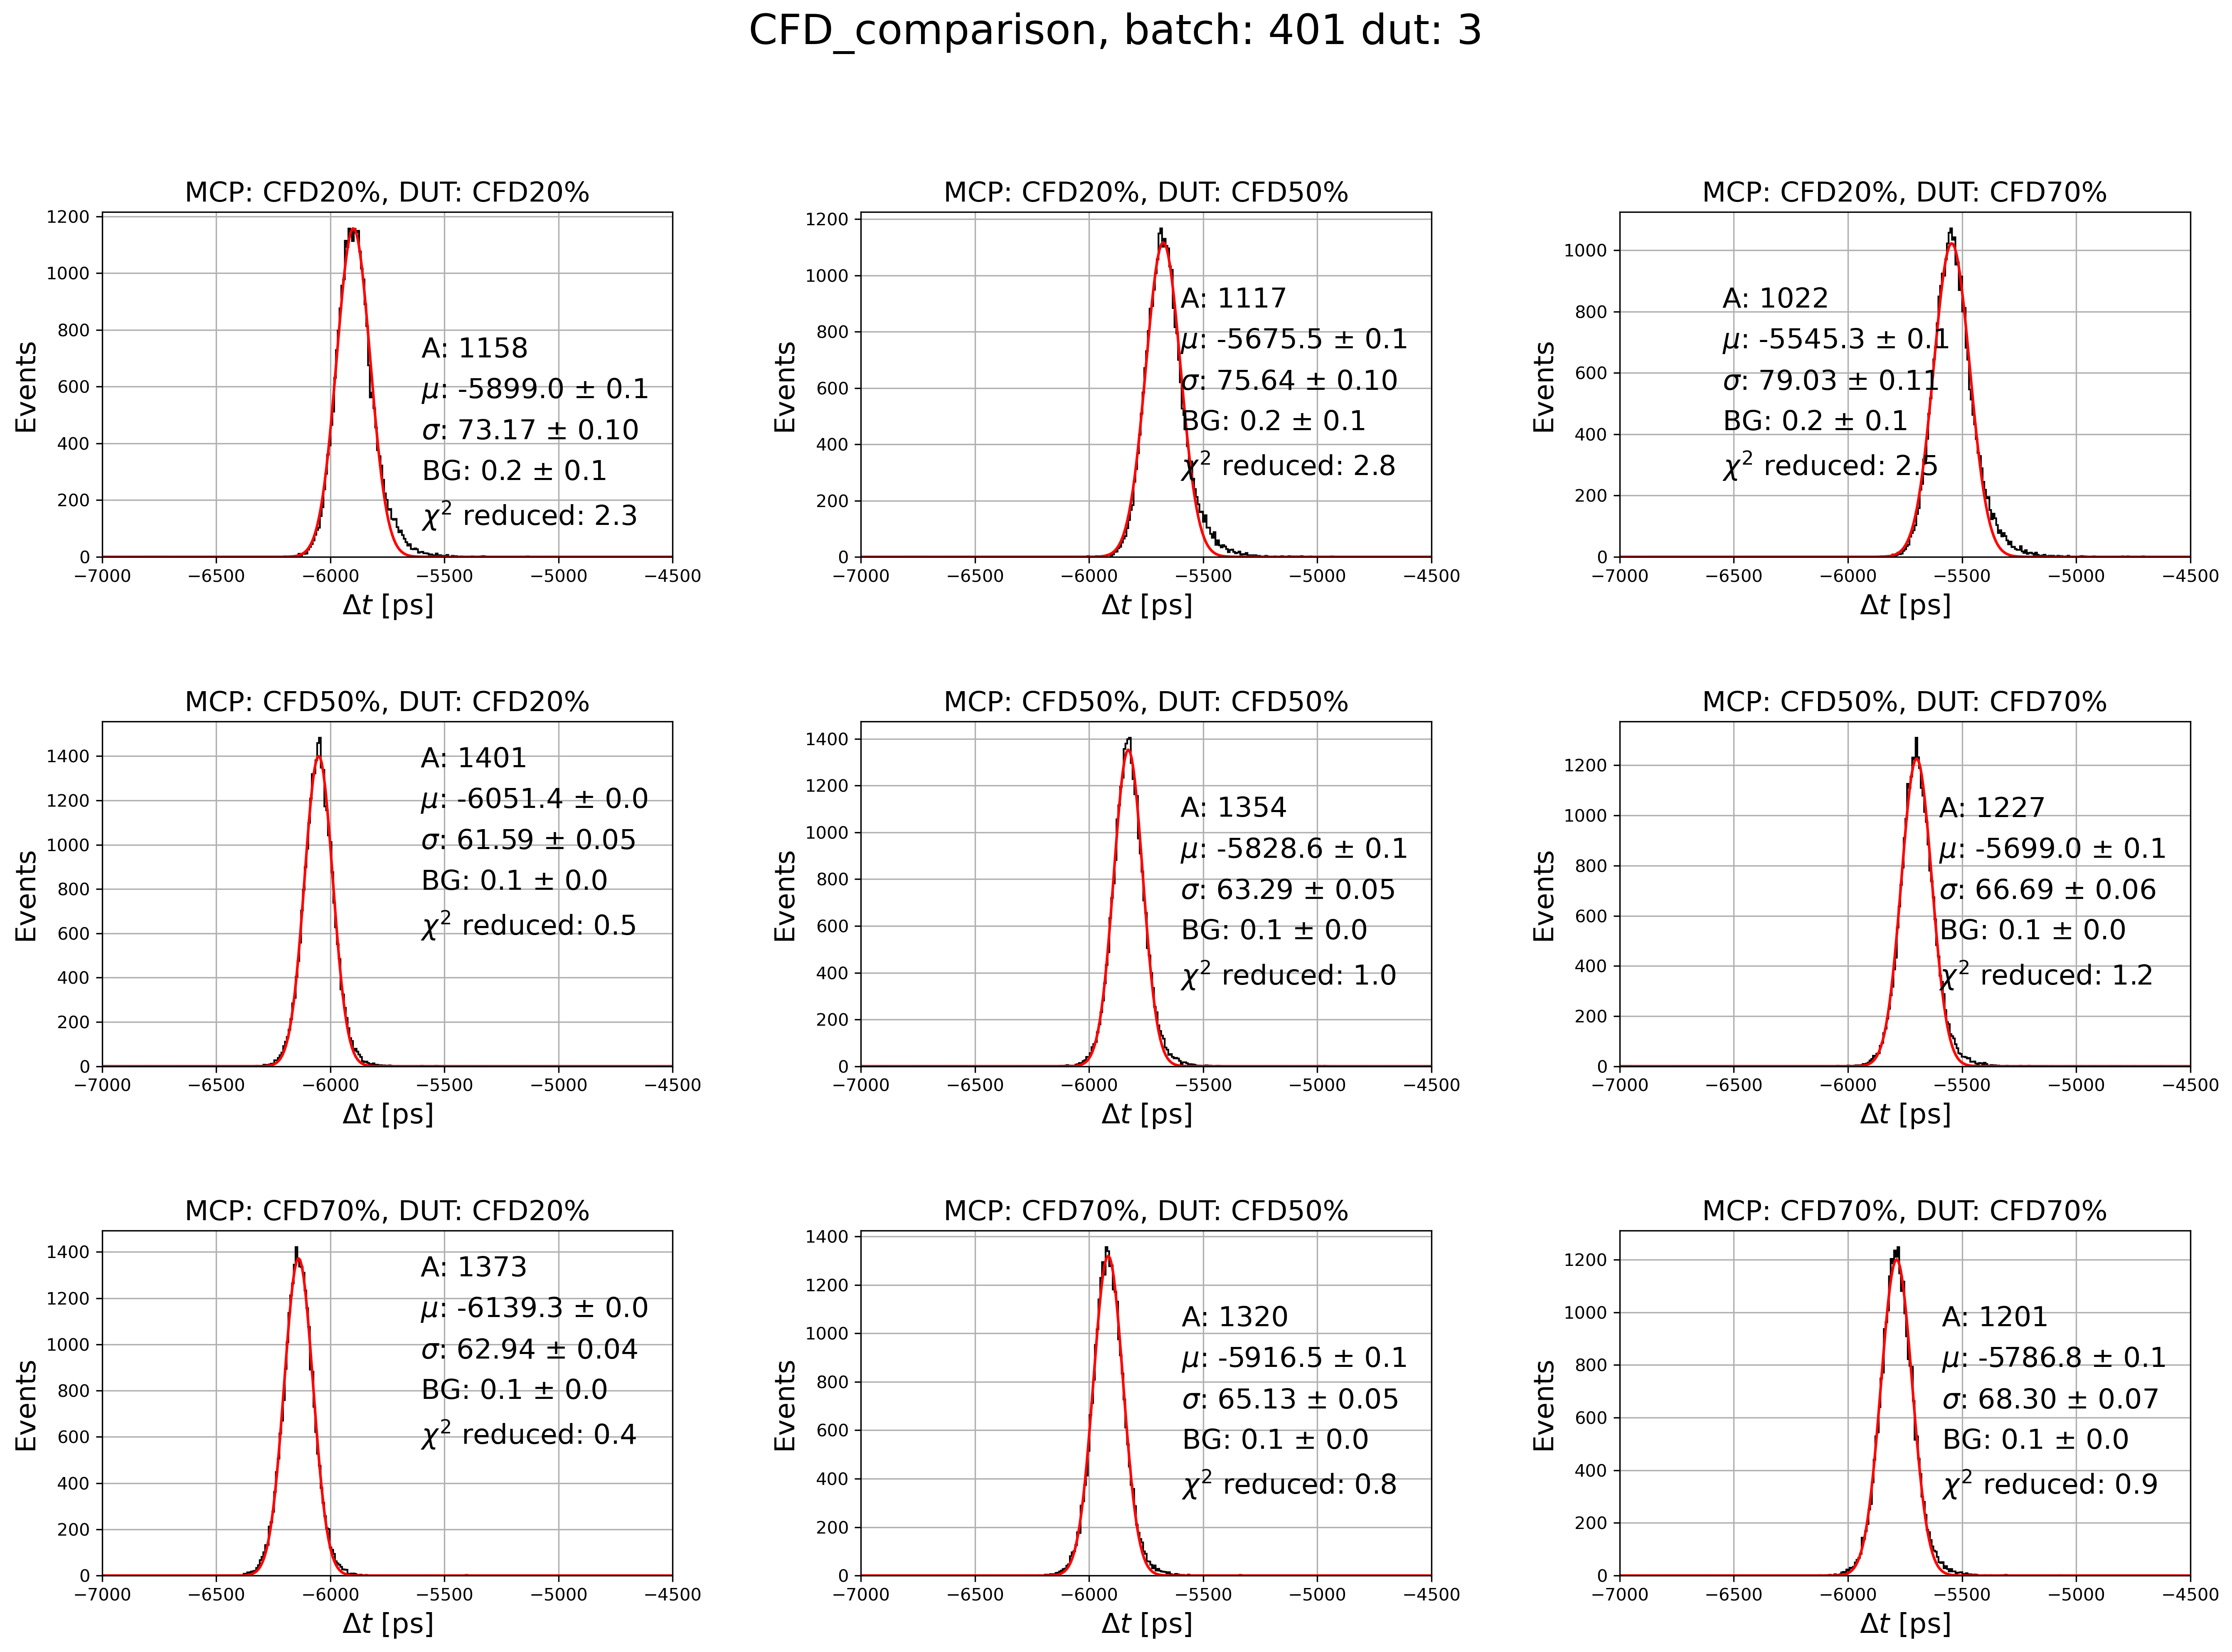

In [94]:
CFD_values = (20, 50,70)
axes_size = len(CFD_values)

MCP_resolution = 36.52

# dut = 2
# window_limit = 20e3

# CFD_mask = [np.logical_and(charge_cuts[dut-1], geo_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]
CFD_mask = [np.logical_and(pulse_cuts[dut-1], central_sensor_area_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]

### ONLY EVENTS WITH CHARGE OVER THE THRESHOLD CHARGE
dut_cut = [np.logical_and(df[f"charge_{dut}"]>threshold_charge,
                        np.logical_and(pulse_cuts[dut-1], central_sensor_area_cuts[dut-1]))
           if dut in DUTs else None for dut in [1,2,3]]
    
for dut in DUTs:
    plot(df, 'CFD_comparison', dict_of_batches[this_batch], S, n_DUT=dut, CFD_values=CFD_values, mask=dut_cut,
         savefig=SAVE, savefig_path=pres_path);


In [ ]:
time_resolution_table = np.array(time_resolution_table).reshape(axes_size,axes_size)
chi2_table = np.array(chi2_table).reshape(axes_size,axes_size)

print(time_resolution_table)
print(chi2_table)

In [ ]:
SAVE = False

# Investigating the horizontal lines, e.g. batch 401, S2, dut 2
This part needs fixing

In [ ]:
geometry_cut, info = geometry_mask(df, DUT_number=2, bins=these_bins, bins_find_min='rice', only_select='normal', use='pulseheight')

In [ ]:
### define the area to analize the line and compare it with a small area just above it
bottom_line, top_line = 255, 256
bottom_above, top_above = 262,263

line_cut = np.logical_and(df['Ytr_1']>=bottom_line, df['Ytr_1']<=top_line)
above_line_cut = np.logical_and(df['Ytr_1']>=bottom_above, df['Ytr_1']<=top_above)

tot_cut = np.logical_and(geometry_cut,line_cut),
tot_cut2 = np.logical_and(geometry_cut,above_line_cut)

info.update({'bottom_edge':bottom_line, 'top_edge':top_line})
info_above = info.copy()
info_above.update({'bottom_edge':bottom_above, 'top_edge':top_above})

In [ ]:
SAVE = True
fig, axes = plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, n_DUT=[2],# mask=tot_cut,
                    savefig=SAVE, savefig_path=pres_path, savefig_details=f" position of the line",fmt='png')
fig.suptitle("Investigating horizontal 'lines'", fontsize=24, y=1.05, ha='center')
axes[0].add_patch(rectangle_from_geometry_cut(**info, lw=0.5))
axes[0].add_patch(rectangle_from_geometry_cut(**info_above, lw=0.5, ec='b'))

fig.savefig(os.path.join(pres_path, "2D Tracks, Horizontal lines.png"), bbox_inches="tight")


 ### Plotting the *time vs pulseheight* density

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16,9), subplot_kw={'projection':'scatter_density'})

plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000, mask=3*[tot_cut],
     n_DUT=[2], savefig=SAVE, savefig_details=f' {S} investigating line', savefig_path=pres_path, fmt='png', extra_info=True,
    fig_ax=(fig,axes[0]))

plot(df, "Time_pulseHeight", dict_of_batches[this_batch], S, bins=10000, mask=3*[tot_cut2],
     n_DUT=[2], savefig=SAVE, savefig_details=f' {S} investigating line', savefig_path=pres_path, fmt='png', extra_info=True,
    fig_ax=(fig,axes[1]))

axes[0].set_title("On the line", fontsize=20)
axes[1].set_title("Above the line", fontsize=20)


# axes[0].legend(fontsize=16, loc='best', framealpha=0)
# axes[1].legend(fontsize=16, loc='best', framealpha=0)

fig.savefig(os.path.join(pres_path, "Time_vs_pulseheight density, horizontal lines.png"), bbox_inches="tight")


 ### Plotting the *pulseHeight* 

In [ ]:
DUTs = [2]
dut = 2
fig, ax = plt.subplots(figsize=(16,9), ncols=1, dpi=300)

transimpedance = dict_of_batches[this_batch].S[S].get_sensor(f'Ch_{dut+1}').transimpedance 

hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[tot_cut]/transimpedance, bins=500,
                                      color='r', label=f"charge on the line",
                                      fig_ax=(fig,ax))

hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[tot_cut2]/transimpedance, bins=my_bins,
                                      color='b', label=f"charge above the line",
                                      fig_ax=(fig,ax))
ax.semilogy()
ax.set_xlim(-10, 100)
ax.legend(fontsize=20)
fig.suptitle("Charge distribution, comparing on the line and above", fontsize=24)

fig.savefig(os.path.join(pres_path, "Charge, Horizontal lines.png"), bbox_inches="tight")


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), dpi=200)

hist, my_bins,_,_,_ = plot_histogram(df[f'pulseHeight_{dut}'].loc[tot_cut], bins=200,
                                     color='r', label='On the line', fig_ax=(fig,ax))
hist, _,_,_,_ = plot_histogram(df[f'pulseHeight_{dut}'].loc[tot_cut2], bins=my_bins,
                               color='b', label='Above the line', fig_ax=(fig,ax))
ax.legend(fontsize=20)
# plot(df.loc[tot_cut], "pulseHeight", dict_of_batches[this_batch], S, bins=200,
#      n_DUT=[2], savefig=SAVE, savefig_details=f' {S} investigating line', savefig_path=pres_path, fmt='png', extra_info=True,
#     fig_ax=(fig,ax))
fig.suptitle("PulseHeight distribution, comparing on the line and above", fontsize=24)

fig.savefig(os.path.join(pres_path, "PulseHeight, Horizontal lines.png"), bbox_inches="tight")


# WAVEFORM

## LeCroy Oscilloscope .trc parser

In [98]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from LoadBatch import *
from SensorClasses import *
import lecroyparser


### time stamp:1685233458 (for run 9620)
trc_file_path = "/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Data_TestBeam/2023_May/Oscilloscope_raw_1/C2WF00000.trc"
trc_file_path2 = "/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Data_TestBeam/2023_May/Oscilloscope_raw_1/data_1685454190/C2WF00000.trc"

data = lecroyparser.ScopeData(trc_file_path)

data.__dict__.keys()

dict_keys(['path', 'data', 'endianness', 'posWAVEDESC', 'commOrder', 'templateName', 'commType', 'waveDescriptor', 'userText', 'trigTimeArray', 'waveArray1', 'instrumentName', 'instrumentNumber', 'traceLabel', 'waveArrayCount', 'verticalGain', 'verticalOffset', 'nominalBits', 'horizInterval', 'horizOffset', 'vertUnit', 'horUnit', 'triggerTime', 'recordType', 'processingDone', 'timeBase', 'verticalCoupling', 'bandwidthLimit', 'waveSource', 'x', 'y'])

In [96]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [ ]:
# CFD_idx = np.argmax(data.y[one_point+left_edge:one_point+right_edge]>pulseHeight_max*0.7)

# data.x[one_point+left_edge:one_point+right_edge][CFD_idx]

## Waveform plot

In [ ]:
colormap = ['k','b','g','r']

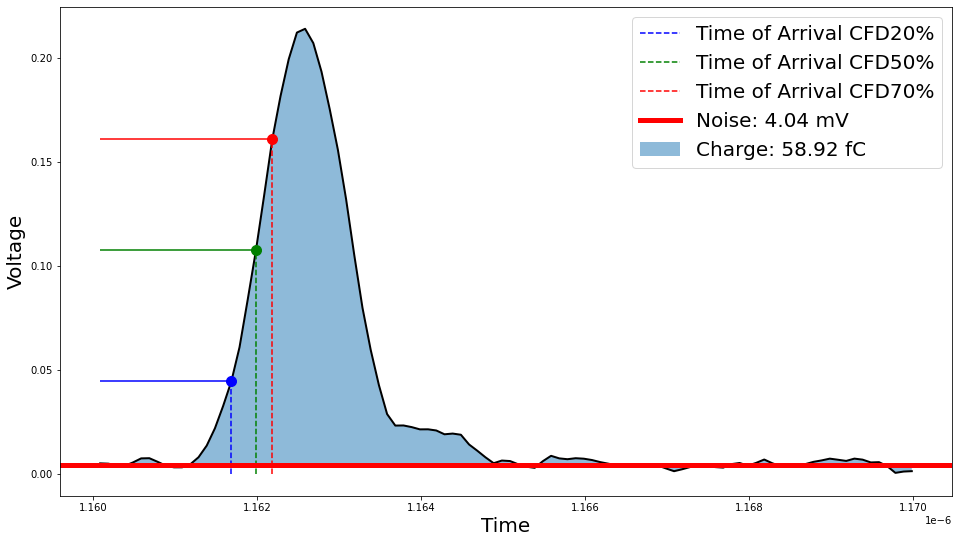

In [99]:
# one_point = 13000
# left_edge = 150
# right_edge = 250

left_x = 1.16e-06 #1.16e-6
window = 1e-8
window_cut = np.logical_and(data.x>left_x, data.x<(left_x+window))

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data.x[window_cut], data.y[window_cut],
       'k', linewidth=2)
pulseHeight_max = np.max(data.y[window_cut])

for i,CFD_value in enumerate((20,50,70)): ### find the first point where the pulse becomes higher the the CFD
    idx = np.argmax(data.y[window_cut]>pulseHeight_max*CFD_value/100)
    ### time of arrival lines
    ax.vlines(data.x[window_cut][idx],0,data.y[window_cut][idx],
             color=colormap[i+1], linestyle='--', label=f'Time of Arrival CFD{CFD_value}%')
    ### horizontal CFD lines
    ax.hlines(data.y[window_cut][idx], data.x[window_cut][0], data.x[window_cut][idx],
             color=colormap[i+1])
    ### waveform
    ax.plot(data.x[window_cut][idx], data.y[window_cut][idx],
        'o', markersize=10, color=colormap[i+1])

ax.axhline(np.average(data.y), color='red', linewidth=5, label=f"Noise: %.2f mV"%(np.average(data.y)*1e3))
charge_value = np.trapz(y=data.y[window_cut]-np.average(data.y),x=data.x[window_cut])/4700 * 10**15 # fC
ax.fill_between(data.x[window_cut], data.y[window_cut], np.average(data.y),
               alpha=0.5, label=f"Charge: %.2f fC"%charge_value)

ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Voltage', fontsize=20)


ax.legend(fontsize=20)
# ax.set_title('Waveform', fontsize=18)
# fig.savefig(os.path.join(pres_path, "Waveform of particle, channel2, with CFD.png"), bbox_inches="tight")


In [100]:
### looking at single runs 
S_run = 'S1'
dir_path = f"../Data_TestBeam/2023_May/{S_run}/"
run = 9620
## 

if run>9999:    file_path = f"tree0{run}.root"
elif run<=9999: file_path = f"tree00{run}.root"

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "noise", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

try:
    df_run = root_to_df(os.path.join(dir_path, file_path), branches)
except FileNotFoundError:
    logging.error("Batch file not found")

df_run = root_to_df(os.path.join(dir_path, file_path), branches)
df_run = df_run.drop(columns=columns_to_remove)

DUTs = [1]
use_for_geometry_cut = "pulseheight"
# plot(df_run,"2D_Sensors", dict_of_batches[401], this_scope='S1', bins=large_bins,
#     savefig=False, savefig_details=f"_single_run_{run}")
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

In [ ]:
# ### CALCULATE ALL THE CUTS
# mins = [find_min_btw_peaks(df_run[f"pulseHeight_{dut}"], bins='rice', plot=False) if dut in DUTs else None for dut in [1,2,3]]

# print(f"USING ''{use_for_geometry_cut}'' FOR GEOMETRY CUT")

# geo_cuts, geo_infos = zip(*[geometry_mask(df_run, DUT_number=dut, bins=these_bins, bins_find_min='rice', use=use_for_geometry_cut)
#                             if dut in DUTs else (None,None) for dut in [1,2,3]])
# extended_geo_cuts = [geometry_mask(df_run, DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='extended', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
# time_cuts = [time_mask(df_run, DUT_number=dut, sigmas=3)[0] if dut in DUTs else None for dut in [1,2,3]]
# pulse_cuts = [df_run[f'pulseHeight_{dut}']>mins[dut-1] if dut in DUTs else None for dut in [1,2,3]]

# all_cuts = [np.logical_and(np.logical_and(geo_cuts[dut-1], time_cuts[dut-1]), pulse_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]

# fit_cuts = [np.logical_and(df_run[f"charge_{dut}"]>0, all_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]

In [ ]:
# print(df_run["timeCFD20_1"].size)
# plot_histogram(df_run["timeCFD20_1"], bins=1000)
# plt.plot(range(df_run["timeCFD20_1"].size), np.array(df_run["timeCFD20_1"].sort_values()))
plot_histogram(np.diff(df_run["timeCFD20_1"].sort_values())[np.diff(df_run["timeCFD20_1"].sort_values())<10]);

## Investigating the clipping in PulseHeight

/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


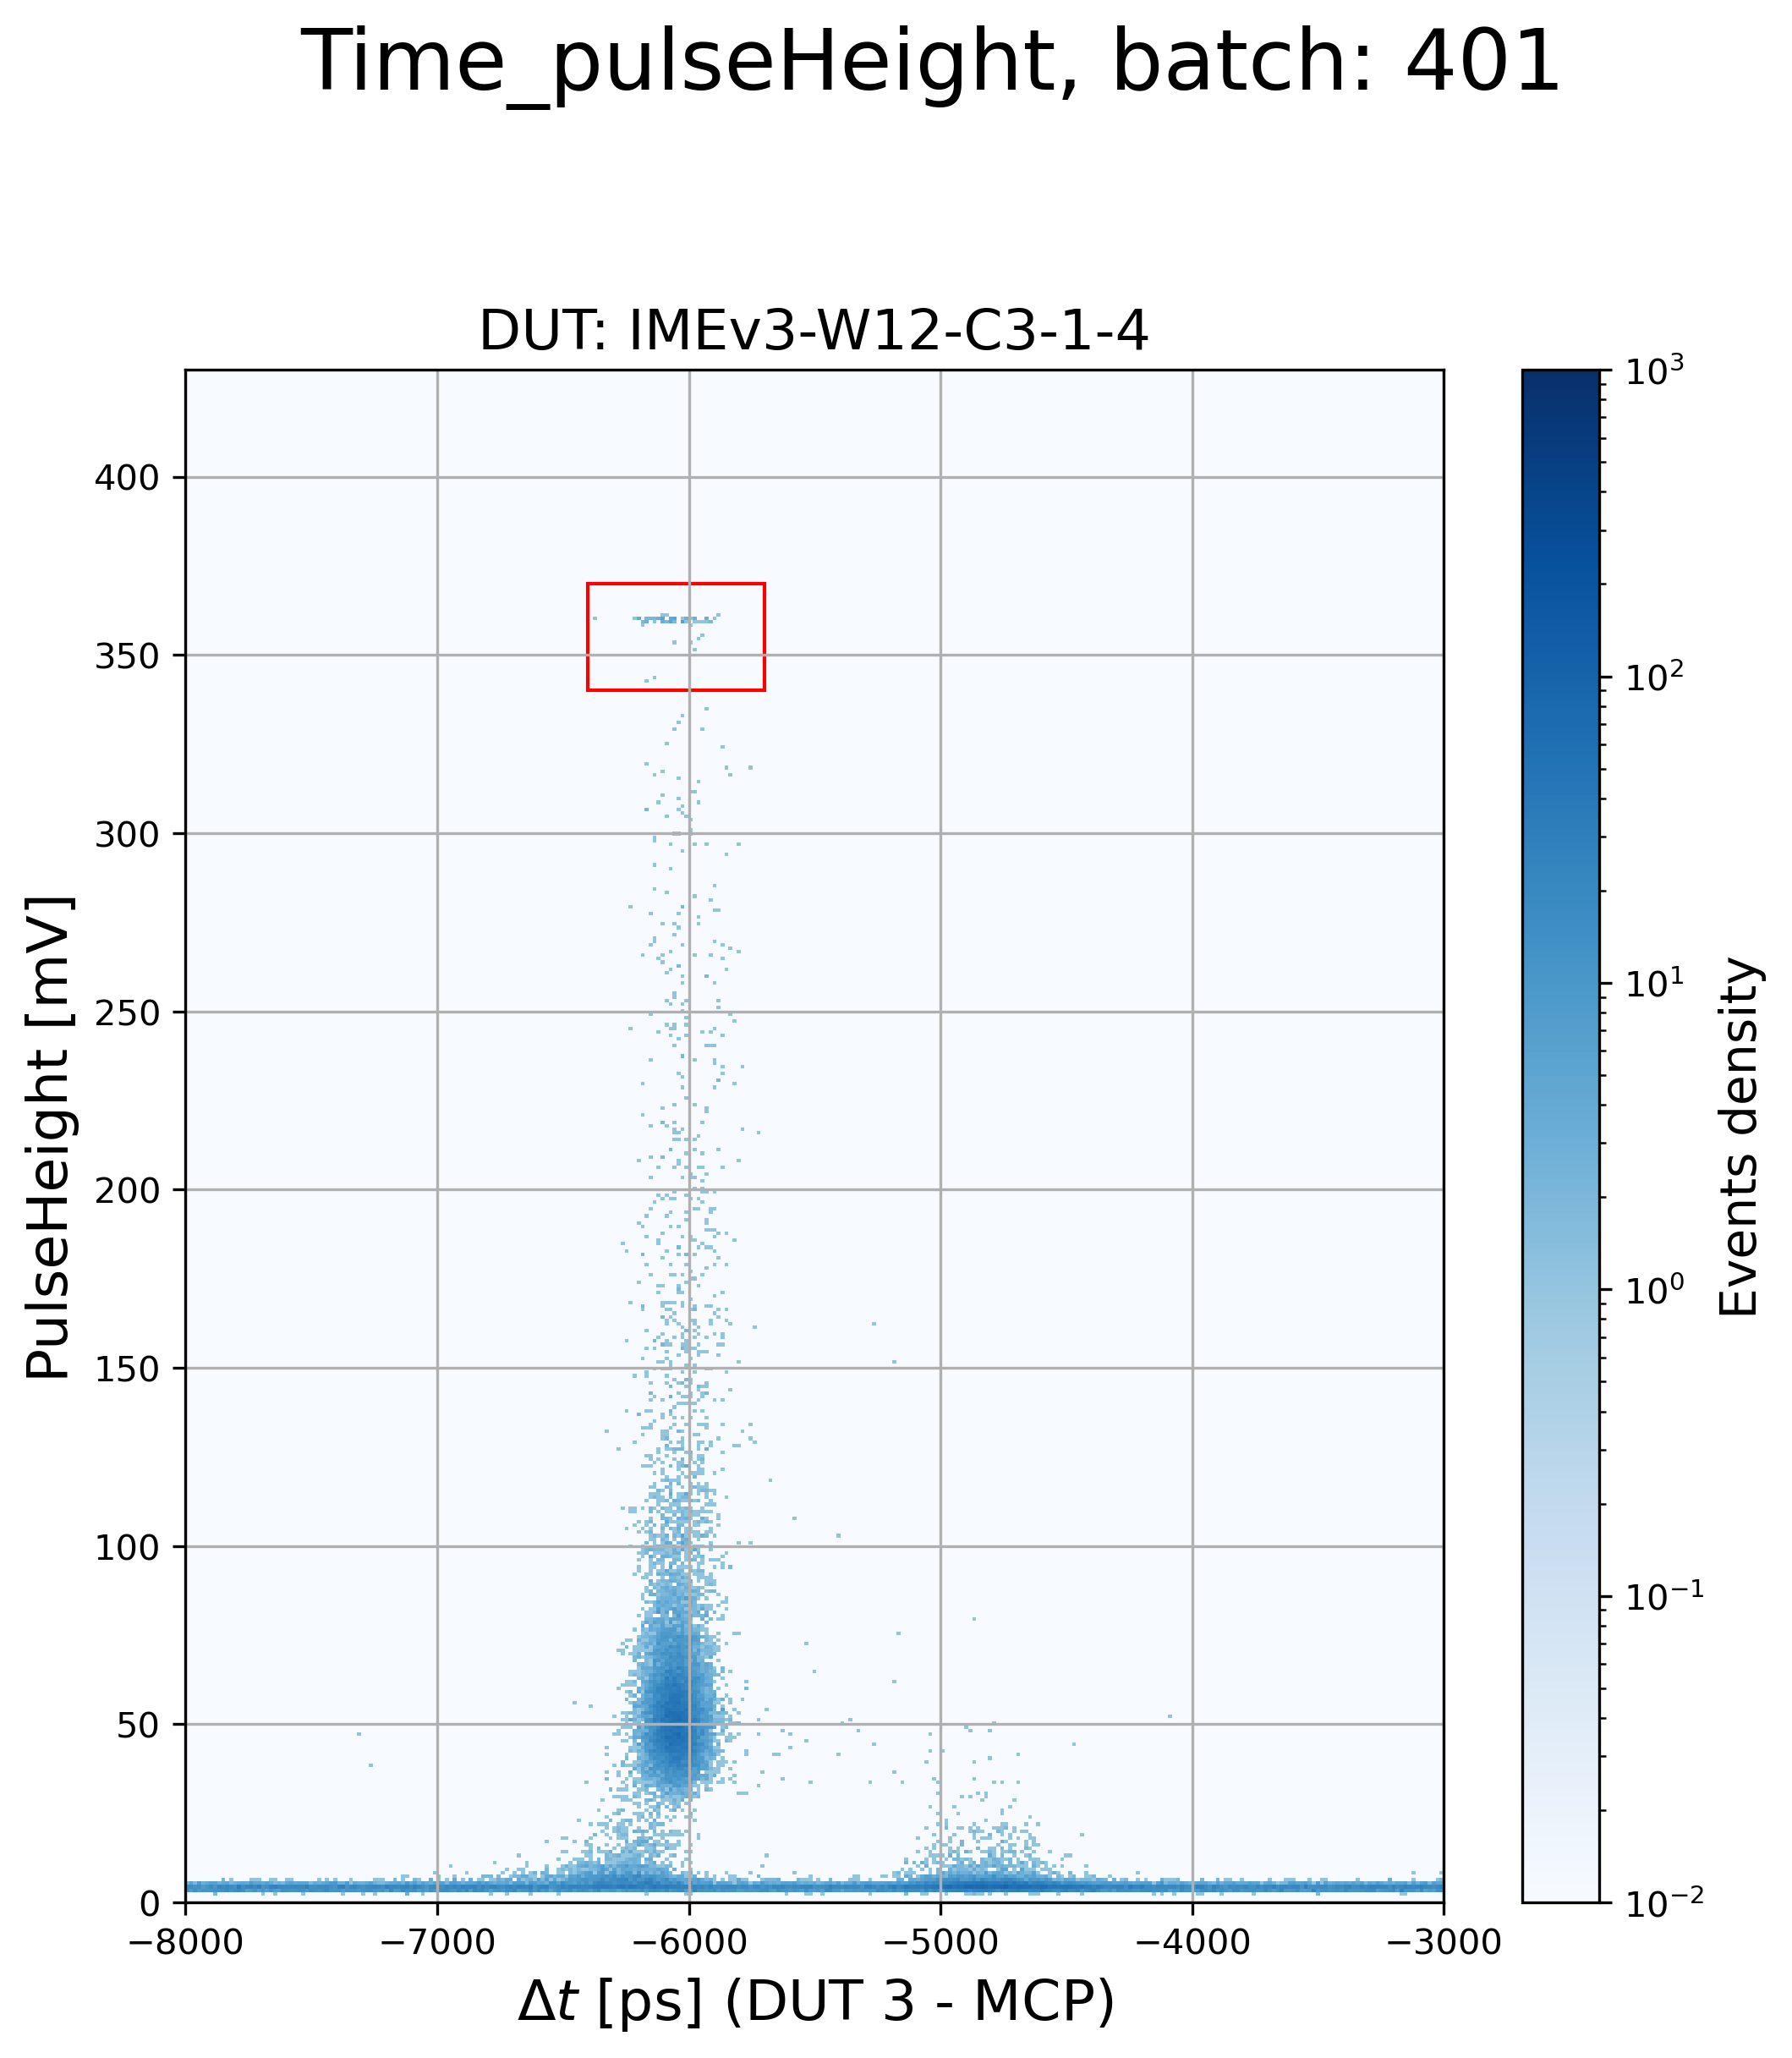

In [106]:
fig,axes = plot(df_run,"Time_pulseHeight",dict_of_batches[401],"S1", n_DUT=[3],info=False, extra_info=False)
axes[0].set_ylim(0,430)
axes[0].add_patch(Rectangle((-6.4e3,340),700,30, color='r', fill=False))

fig.savefig(os.path.join(pres_path, "Time_vs_PulseHeight_investigating_clipping.png"), bbox_inches="tight")


In [ ]:
# time_data_cut = df_run["timeCFD50_0"].loc[all_cuts[0]]-df_run["timeCFD20_1"].loc[all_cuts[0]]
# time_data_cut


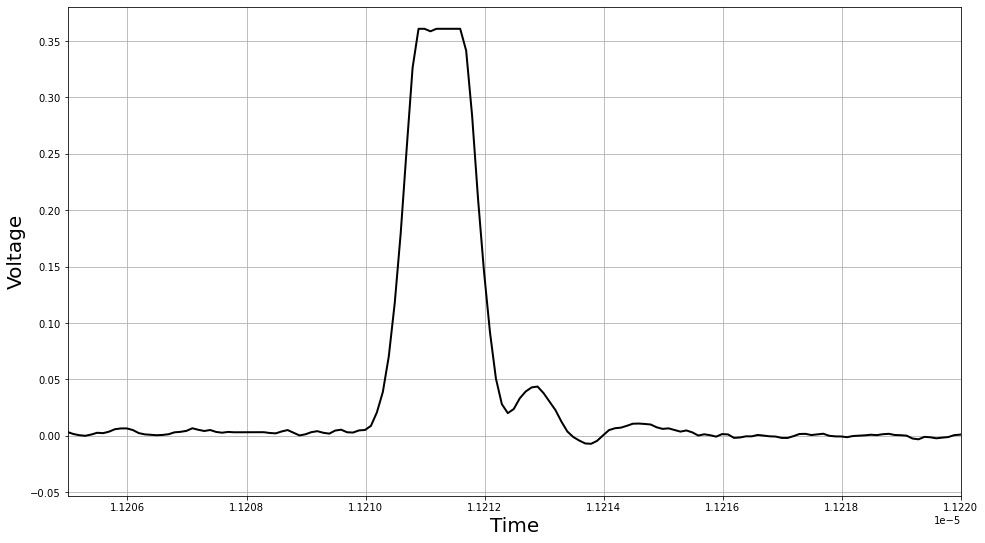

In [110]:
fig, ax = plt.subplots(figsize=(16,9))
event_number = 1211
ax.plot(data.x, data.y, 'k', linewidth=2)
left_x, right_x = 1.1205e-5,1.122e-5

ax.set_xlim(left_x, right_x)
# ax.set_xlim(time_data_cut.iloc[0]/1e9,time_data_cut.iloc[len(time_data_cut)//100]/1e9 + 500/1e9)

integral_filter = np.logical_and(data.x > left_x, data.x < right_x)
np.trapz(y=data.y[integral_filter]-np.average(data.y), x=data.x[integral_filter]) * 10**15 / 4700

ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Voltage', fontsize=20)
ax.grid('--')

fig.savefig(os.path.join(pres_path, "Waveform of clipped pulse.png"), bbox_inches="tight")


In [111]:
data.x[-1]- data.x[0]

0.00024899200332439975

17.73643680773424

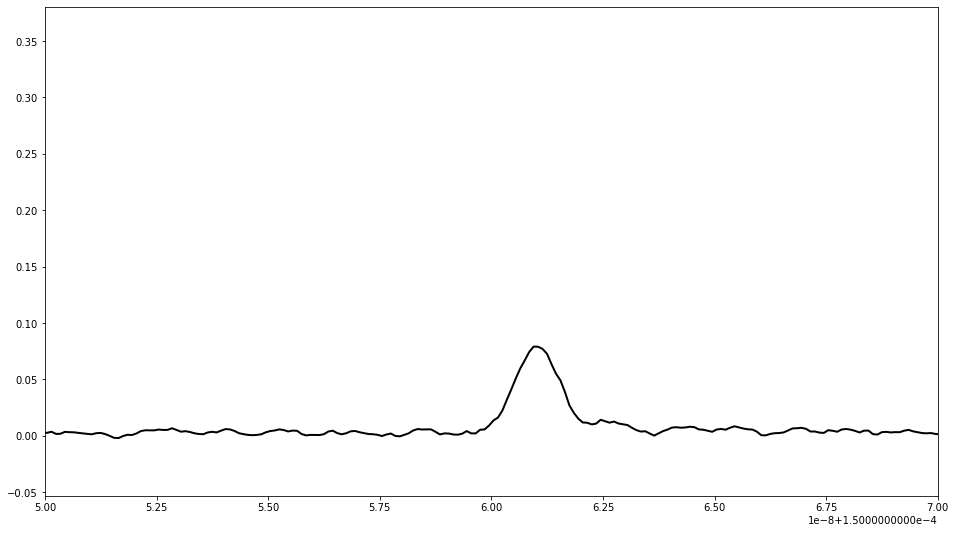

In [112]:
fig, ax = plt.subplots(figsize=(16,9))
event_number = 1211
ax.plot(data.x, data.y, 'k', linewidth=2)
left_x = 1.5005e-4
window = 2e-8
ax.set_xlim(left_x, left_x+window)

integral_filter = np.logical_and(data.x > left_x, data.x < (left_x+window))
np.trapz(y=data.y[integral_filter]-np.average(data.y), x=data.x[integral_filter])/4700 * 10**15

17.73643680773424

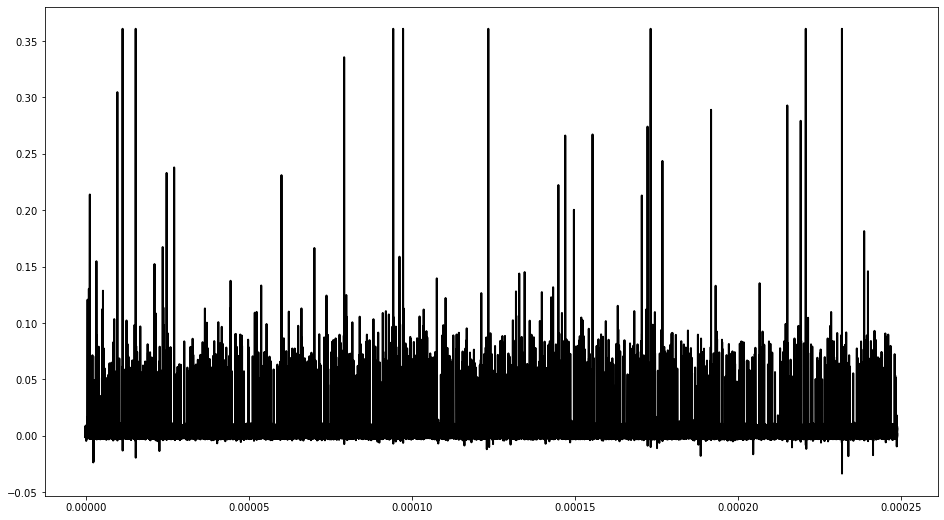

In [113]:
fig, ax = plt.subplots(figsize=(16,9))
event_number = 1211
ax.plot(data.x, data.y, 'k', linewidth=2)
left_x = 1.5005e-4
window = 2e-8
# ax.set_xlim(left_x, left_x+window)

integral_filter = np.logical_and(data.x > left_x, data.x < (left_x+window))
np.trapz(y=data.y[integral_filter]-np.average(data.y), x=data.x[integral_filter])/4700 * 10**15